In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [2]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [3]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [4]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [8]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [9]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 2858

Testing
Number of Labels: 1311


In [10]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [12]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [14]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.3688 - loss: 1.2308 - val_accuracy: 0.5400 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.7008 - loss: 0.7322 - val_accuracy: 0.6941 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.7678 - loss: 0.5803 - val_accuracy: 0.7666 - val_loss: 0.5769 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.8323 - loss: 0.4576 - val_accuracy: 0.7918 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8553 - loss: 0.3718 - val_accuracy: 0.8398 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8961 - loss: 0.2896 - val_accuracy: 0.8673 - val_loss: 0.3505 - learning_rate: 0.0010
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9074 - loss: 0.26

In [15]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9530 - loss: 0.5638
Test accuracy: 95.1945%


In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       300
           1       0.95      0.89      0.92       306
           2       0.94      0.99      0.96       405
           3       0.94      0.99      0.96       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



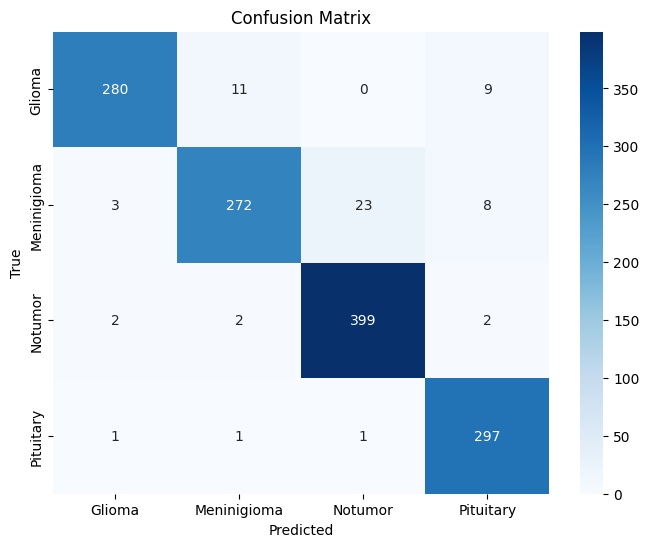

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
model.save('SSL_50-50.h5')

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_50-50.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/2854 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


  0%|          | 1/2854 [00:00<32:27,  1.46it/s]

Tr-pi_1149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1149.jpg to BT100/Training/pituitary/20250330_221519_Tr-pi_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1072.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1072.jpg to BT100/Training/glioma/20250330_221519_Tr-gl_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 3/2854 [00:00<10:55,  4.35it/s]

Tr-no_0442.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0442.jpg to BT100/Training/notumor/20250330_221519_Tr-no_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0585.jpg to BT100/Training/notumor/20250330_221519_Tr-no_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 5/2854 [00:00<06:56,  6.83it/s]

Tr-pi_0917.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0917.jpg to BT100/Training/pituitary/20250330_221519_Tr-pi_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0370.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0370.jpg to BT100/Training/pituitary/20250330_221519_Tr-pi_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 7/2854 [00:01<05:35,  8.49it/s]

Tr-me_1169.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1169.jpg to BT100/Training/meningioma/20250330_221519_Tr-me_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0046.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0046.jpg to BT100/Training/meningioma/20250330_221520_Tr-me_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 9/2854 [00:01<05:06,  9.28it/s]

Tr-pi_0448.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0448.jpg to BT100/Training/pituitary/20250330_221520_Tr-pi_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1223.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1223.jpg to BT100/Training/pituitary/20250330_221520_Tr-pi_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 11/2854 [00:01<04:26, 10.67it/s]

Tr-me_1217.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_1217.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0191.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0191.jpg to BT100/Training/glioma/20250330_221520_Tr-gl_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 13/2854 [00:01<03:59, 11.86it/s]

Tr-gl_0839.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0839.jpg to BT100/Training/glioma/20250330_221520_Tr-gl_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1357.jpg to BT100/Training/pituitary/20250330_221520_Tr-pi_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 15/2854 [00:01<03:47, 12.48it/s]

Tr-pi_0570.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0570.jpg to BT100/Training/pituitary/20250330_221520_Tr-pi_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0021.jpg to BT100/Training/notumor/20250330_221520_Tr-no_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|          | 17/2854 [00:01<03:39, 12.90it/s]

Tr-me_0990.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0990.jpg to BT100/Training/meningioma/20250330_221520_Tr-me_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0874.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0874.jpg to BT100/Training/pituitary/20250330_221520_Tr-pi_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 19/2854 [00:01<03:33, 13.28it/s]

Tr-no_1338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1338.jpg to BT100/Training/notumor/20250330_221520_Tr-no_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0150.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0150.jpg to BT100/Training/notumor/20250330_221520_Tr-no_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 21/2854 [00:02<03:30, 13.49it/s]

Tr-no_1038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1038.jpg to BT100/Training/notumor/20250330_221521_Tr-no_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0119.jpg -> Class: notumor, Confidence: 0.67
Moved low-confidence image Tr-gl_0119.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|          | 23/2854 [00:02<03:46, 12.48it/s]

Tr-no_0679.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0679.jpg to BT100/Training/notumor/20250330_221521_Tr-no_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0349.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0349.jpg to BT100/Training/pituitary/20250330_221521_Tr-pi_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 25/2854 [00:02<03:37, 13.02it/s]

Tr-pi_1389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1389.jpg to BT100/Training/pituitary/20250330_221521_Tr-pi_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0401.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0401.jpg to BT100/Training/glioma/20250330_221521_Tr-gl_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 27/2854 [00:02<03:27, 13.62it/s]

Tr-pi_0738.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0738.jpg to BT100/Training/pituitary/20250330_221521_Tr-pi_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0370.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0370.jpg to BT100/Training/glioma/20250330_221521_Tr-me_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0096.jpg to BT100/Training/notumor/20250330_221521_Tr-no_0096.jpg


  1%|          | 29/2854 [00:02<03:22, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0345.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0345.jpg to BT100/Training/glioma/20250330_221521_Tr-gl_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 31/2854 [00:02<03:52, 12.15it/s]

Tr-me_0350.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0350.jpg to BT100/Training/meningioma/20250330_221521_Tr-me_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0539.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0539.jpg to BT100/Training/pituitary/20250330_221521_Tr-pi_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|          | 33/2854 [00:03<04:24, 10.66it/s]

Tr-no_1175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1175.jpg to BT100/Training/notumor/20250330_221522_Tr-no_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_0400.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0400.jpg to BT100/Training/meningioma/20250330_221522_Tr-me_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 35/2854 [00:03<05:00,  9.37it/s]

Tr-pi_0604.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0604.jpg to BT100/Training/pituitary/20250330_221522_Tr-pi_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-me_0185.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0185.jpg to BT100/Training/meningioma/20250330_221522_Tr-me_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|▏         | 37/2854 [00:03<05:21,  8.77it/s]

Tr-pi_1101.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1101.jpg to BT100/Training/pituitary/20250330_221522_Tr-pi_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0683.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0683.jpg to BT100/Training/pituitary/20250330_221522_Tr-pi_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▏         | 39/2854 [00:03<05:01,  9.35it/s]

Tr-gl_0155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0155.jpg to BT100/Training/glioma/20250330_221522_Tr-gl_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1004.jpg to BT100/Training/pituitary/20250330_221522_Tr-pi_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|▏         | 41/2854 [00:04<04:48,  9.75it/s]

Tr-no_0112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0112.jpg to BT100/Training/notumor/20250330_221522_Tr-no_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-me_0076.jpg -> Class: glioma, Confidence: 0.51
Moved low-confidence image Tr-me_0076.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 43/2854 [00:04<05:19,  8.79it/s]

Tr-pi_1143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1143.jpg to BT100/Training/pituitary/20250330_221523_Tr-pi_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 44/2854 [00:04<05:26,  8.59it/s]

Tr-pi_1289.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1289.jpg to BT100/Training/pituitary/20250330_221523_Tr-pi_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 45/2854 [00:04<05:38,  8.31it/s]

Tr-no_0543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0543.jpg to BT100/Training/notumor/20250330_221523_Tr-no_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 46/2854 [00:04<05:48,  8.05it/s]

Tr-me_0978.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0978.jpg to BT100/Training/meningioma/20250330_221523_Tr-me_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1197.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1197.jpg to BT100/Training/meningioma/20250330_221523_Tr-me_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 48/2854 [00:04<04:56,  9.48it/s]

Tr-gl_0265.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0265.jpg to BT100/Training/glioma/20250330_221523_Tr-gl_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0928.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0928.jpg to BT100/Training/glioma/20250330_221523_Tr-gl_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 50/2854 [00:05<04:42,  9.93it/s]

Tr-me_0508.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0508.jpg to BT100/Training/meningioma/20250330_221523_Tr-me_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 51/2854 [00:05<04:51,  9.61it/s]

Tr-pi_0247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0247.jpg to BT100/Training/pituitary/20250330_221524_Tr-pi_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0380.jpg to BT100/Training/notumor/20250330_221524_Tr-no_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 53/2854 [00:05<04:19, 10.80it/s]

Tr-no_0598.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0598.jpg to BT100/Training/notumor/20250330_221524_Tr-no_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0291.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0291.jpg to BT100/Training/glioma/20250330_221524_Tr-gl_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 55/2854 [00:05<03:57, 11.78it/s]

Tr-me_0701.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0701.jpg to BT100/Training/meningioma/20250330_221524_Tr-me_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0635.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0635.jpg to BT100/Training/meningioma/20250330_221524_Tr-me_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 57/2854 [00:05<04:06, 11.37it/s]

Tr-no_0496.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0496.jpg to BT100/Training/notumor/20250330_221524_Tr-no_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0060.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0060.jpg to BT100/Training/glioma/20250330_221524_Tr-gl_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 59/2854 [00:05<04:08, 11.24it/s]

Tr-pi_1206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1206.jpg to BT100/Training/pituitary/20250330_221524_Tr-pi_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1223.jpg to BT100/Training/meningioma/20250330_221524_Tr-me_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 61/2854 [00:06<03:51, 12.07it/s]

Tr-no_0714.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0714.jpg to BT100/Training/notumor/20250330_221524_Tr-no_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0243.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0243.jpg to BT100/Training/meningioma/20250330_221524_Tr-me_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 63/2854 [00:06<03:39, 12.69it/s]

Tr-pi_0647.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0647.jpg to BT100/Training/pituitary/20250330_221525_Tr-pi_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0897.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0897.jpg to BT100/Training/notumor/20250330_221525_Tr-no_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 65/2854 [00:06<03:58, 11.70it/s]

Tr-me_0033.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0033.jpg to BT100/Training/meningioma/20250330_221525_Tr-me_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0306.jpg to BT100/Training/glioma/20250330_221525_Tr-gl_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 67/2854 [00:06<03:45, 12.34it/s]

Tr-me_1250.jpg -> Class: glioma, Confidence: 0.80
Moved low-confidence image Tr-me_1250.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0178.jpg to BT100/Training/notumor/20250330_221525_Tr-no_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 69/2854 [00:06<03:34, 13.01it/s]

Tr-gl_0398.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0398.jpg to BT100/Training/glioma/20250330_221525_Tr-gl_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0336.jpg to BT100/Training/pituitary/20250330_221525_Tr-pi_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 71/2854 [00:06<03:25, 13.51it/s]

Tr-no_0422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0422.jpg to BT100/Training/notumor/20250330_221525_Tr-no_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0760.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0760.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 73/2854 [00:06<03:22, 13.71it/s]

Tr-no_1457.jpg -> Class: pituitary, Confidence: 0.68
Moved low-confidence image Tr-no_1457.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1293.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1293.jpg to BT100/Training/pituitary/20250330_221525_Tr-pi_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 75/2854 [00:07<03:18, 14.02it/s]

Tr-no_0785.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0785.jpg to BT100/Training/notumor/20250330_221525_Tr-no_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0183.jpg to BT100/Training/meningioma/20250330_221525_Tr-me_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 77/2854 [00:07<03:17, 14.03it/s]

Tr-pi_0357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0357.jpg to BT100/Training/pituitary/20250330_221526_Tr-pi_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0845.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0845.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 79/2854 [00:07<03:26, 13.41it/s]

Tr-no_0895.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0895.jpg to BT100/Training/notumor/20250330_221526_Tr-no_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0088.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  3%|▎         | 81/2854 [00:07<03:23, 13.60it/s]

Tr-me_0015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0015.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0381.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0381.jpg to BT100/Training/glioma/20250330_221526_Tr-gl_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 83/2854 [00:07<03:18, 13.96it/s]

Tr-me_1317.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1317.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0893.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0893.jpg to BT100/Training/notumor/20250330_221526_Tr-no_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 85/2854 [00:07<03:34, 12.92it/s]

Tr-me_1110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1110.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0093.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0093.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_0093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 87/2854 [00:07<03:43, 12.38it/s]

Tr-me_1032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1032.jpg to BT100/Training/meningioma/20250330_221526_Tr-me_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0360.jpg to BT100/Training/notumor/20250330_221526_Tr-me_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 89/2854 [00:08<03:31, 13.05it/s]

Tr-no_0693.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0693.jpg to BT100/Training/notumor/20250330_221527_Tr-no_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1192.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1192.jpg to BT100/Training/meningioma/20250330_221527_Tr-me_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 91/2854 [00:08<03:48, 12.09it/s]

Tr-pi_1280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1280.jpg to BT100/Training/pituitary/20250330_221527_Tr-pi_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0287.jpg to BT100/Training/notumor/20250330_221527_Tr-no_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 93/2854 [00:08<03:37, 12.67it/s]

Tr-pi_0540.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0540.jpg to BT100/Training/pituitary/20250330_221527_Tr-pi_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0839.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0839.jpg to BT100/Training/pituitary/20250330_221527_Tr-pi_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 95/2854 [00:08<03:27, 13.29it/s]

Tr-me_0490.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0490.jpg to BT100/Training/meningioma/20250330_221527_Tr-me_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1202.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1202.jpg to BT100/Training/meningioma/20250330_221527_Tr-me_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 97/2854 [00:08<03:39, 12.56it/s]

Tr-gl_1065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1065.jpg to BT100/Training/glioma/20250330_221527_Tr-gl_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1131.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_1131.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 99/2854 [00:08<03:27, 13.27it/s]

Tr-gl_0359.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0359.jpg to BT100/Training/glioma/20250330_221527_Tr-gl_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0093.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0093.jpg to BT100/Training/pituitary/20250330_221527_Tr-no_0093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▎         | 101/2854 [00:09<03:17, 13.93it/s]

Tr-pi_0719.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0719.jpg to BT100/Training/pituitary/20250330_221527_Tr-pi_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0722.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0722.jpg to BT100/Training/glioma/20250330_221527_Tr-gl_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 103/2854 [00:09<03:29, 13.14it/s]

Tr-pi_1034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1034.jpg to BT100/Training/pituitary/20250330_221528_Tr-pi_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0831.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0831.jpg to BT100/Training/glioma/20250330_221528_Tr-gl_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▎         | 105/2854 [00:09<03:30, 13.04it/s]

Tr-gl_0015.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0015.jpg to BT100/Training/glioma/20250330_221528_Tr-gl_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1131.jpg -> Class: meningioma, Confidence: 0.49
Moved low-confidence image Tr-gl_1131.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 107/2854 [00:09<03:23, 13.50it/s]

Tr-gl_0565.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0565.jpg to BT100/Training/glioma/20250330_221528_Tr-gl_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0806.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0806.jpg to BT100/Training/pituitary/20250330_221528_Tr-pi_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▍         | 109/2854 [00:09<03:34, 12.80it/s]

Tr-me_0839.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0839.jpg to BT100/Training/meningioma/20250330_221528_Tr-me_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0331.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-me_0331.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▍         | 111/2854 [00:09<03:44, 12.20it/s]

Tr-no_0690.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0690.jpg to BT100/Training/notumor/20250330_221528_Tr-no_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1537.jpg to BT100/Training/notumor/20250330_221528_Tr-no_1537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0416.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0416.jpg to BT100/Training/glioma/20250330_221528_Tr-gl_0416.jpg


  4%|▍         | 113/2854 [00:09<03:35, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0804.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0804.jpg to BT100/Training/notumor/20250330_221528_Tr-no_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 115/2854 [00:10<03:29, 13.06it/s]

Tr-no_1290.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1290.jpg to BT100/Training/notumor/20250330_221529_Tr-no_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0721.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0721.jpg to BT100/Training/notumor/20250330_221529_Tr-no_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 117/2854 [00:10<04:00, 11.36it/s]

Tr-pi_0643.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0643.jpg to BT100/Training/pituitary/20250330_221529_Tr-pi_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0747.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0747.jpg to BT100/Training/notumor/20250330_221529_Tr-no_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▍         | 119/2854 [00:10<04:03, 11.24it/s]

Tr-gl_0747.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0747.jpg to BT100/Training/glioma/20250330_221529_Tr-gl_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0377.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0377.jpg to BT100/Training/glioma/20250330_221529_Tr-gl_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 121/2854 [00:10<03:47, 11.99it/s]

Tr-no_1146.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1146.jpg to BT100/Training/notumor/20250330_221529_Tr-no_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1126.jpg to BT100/Training/glioma/20250330_221529_Tr-gl_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 123/2854 [00:10<03:36, 12.63it/s]

Tr-gl_0298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0298.jpg to BT100/Training/glioma/20250330_221529_Tr-gl_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0114.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0114.jpg to BT100/Training/glioma/20250330_221529_Tr-gl_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 125/2854 [00:10<03:43, 12.24it/s]

Tr-no_1455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1455.jpg to BT100/Training/notumor/20250330_221529_Tr-no_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0363.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0363.jpg to BT100/Training/meningioma/20250330_221529_Tr-me_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 127/2854 [00:11<03:55, 11.57it/s]

Tr-me_0628.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0628.jpg to BT100/Training/meningioma/20250330_221530_Tr-me_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1147.jpg to BT100/Training/glioma/20250330_221530_Tr-gl_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▍         | 129/2854 [00:11<04:27, 10.20it/s]

Tr-gl_0054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0054.jpg to BT100/Training/glioma/20250330_221530_Tr-gl_0054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0174.jpg to BT100/Training/pituitary/20250330_221530_Tr-me_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 131/2854 [00:11<04:04, 11.14it/s]

Tr-no_1231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1231.jpg to BT100/Training/notumor/20250330_221530_Tr-no_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1097.jpg to BT100/Training/pituitary/20250330_221530_Tr-pi_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 133/2854 [00:11<04:13, 10.74it/s]

Tr-no_0134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0134.jpg to BT100/Training/notumor/20250330_221530_Tr-no_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0733.jpg to BT100/Training/glioma/20250330_221530_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 135/2854 [00:11<03:54, 11.61it/s]

Tr-me_0437.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0437.jpg to BT100/Training/meningioma/20250330_221530_Tr-me_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1213.jpg to BT100/Training/pituitary/20250330_221530_Tr-pi_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 137/2854 [00:12<03:40, 12.33it/s]

Tr-pi_1185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1185.jpg to BT100/Training/pituitary/20250330_221530_Tr-pi_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0788.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0788.jpg to BT100/Training/pituitary/20250330_221531_Tr-pi_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▍         | 139/2854 [00:12<03:34, 12.63it/s]

Tr-me_0609.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0609.jpg to BT100/Training/meningioma/20250330_221531_Tr-me_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1211.jpg to BT100/Training/notumor/20250330_221531_Tr-no_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 141/2854 [00:12<03:32, 12.80it/s]

Tr-gl_0613.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0613.jpg to BT100/Training/glioma/20250330_221531_Tr-gl_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0013.jpg to BT100/Training/meningioma/20250330_221531_Tr-me_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 143/2854 [00:12<03:28, 13.00it/s]

Tr-no_0952.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0952.jpg to BT100/Training/notumor/20250330_221531_Tr-no_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1148.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1148.jpg to BT100/Training/notumor/20250330_221531_Tr-no_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▌         | 145/2854 [00:12<03:22, 13.37it/s]

Tr-gl_0560.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0560.jpg to BT100/Training/glioma/20250330_221531_Tr-gl_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0285.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0285.jpg to BT100/Training/meningioma/20250330_221531_Tr-me_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▌         | 147/2854 [00:12<03:18, 13.62it/s]

Tr-me_0427.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0427.jpg to BT100/Training/meningioma/20250330_221531_Tr-me_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1003.jpg to BT100/Training/glioma/20250330_221531_Tr-gl_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 149/2854 [00:12<03:32, 12.74it/s]

Tr-pi_0547.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0547.jpg to BT100/Training/pituitary/20250330_221531_Tr-pi_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0905.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0905.jpg to BT100/Training/meningioma/20250330_221531_Tr-me_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 151/2854 [00:13<03:43, 12.08it/s]

Tr-pi_0378.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0378.jpg to BT100/Training/pituitary/20250330_221532_Tr-pi_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1255.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1255.jpg to BT100/Training/notumor/20250330_221532_Tr-no_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 153/2854 [00:13<03:53, 11.57it/s]

Tr-pi_0820.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0820.jpg to BT100/Training/pituitary/20250330_221532_Tr-pi_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0187.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0187.jpg to BT100/Training/meningioma/20250330_221532_Tr-me_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▌         | 155/2854 [00:13<04:00, 11.20it/s]

Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0181.jpg to BT100/Training/meningioma/20250330_221532_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0861.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0861.jpg to BT100/Training/meningioma/20250330_221532_Tr-me_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 157/2854 [00:13<03:44, 12.04it/s]

Tr-pi_1370.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1370.jpg to BT100/Training/pituitary/20250330_221532_Tr-pi_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0957.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0957.jpg to BT100/Training/meningioma/20250330_221532_Tr-me_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 159/2854 [00:13<03:47, 11.84it/s]

Tr-no_0569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0569.jpg to BT100/Training/notumor/20250330_221532_Tr-no_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0513.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0513.jpg to BT100/Training/pituitary/20250330_221532_Tr-pi_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 161/2854 [00:13<03:34, 12.57it/s]

Tr-no_1250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1250.jpg to BT100/Training/notumor/20250330_221532_Tr-no_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0110.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0110.jpg to BT100/Training/glioma/20250330_221532_Tr-gl_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 163/2854 [00:14<03:26, 13.01it/s]

Tr-gl_0132.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0132.jpg to BT100/Training/glioma/20250330_221533_Tr-gl_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0487.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0487.jpg to BT100/Training/notumor/20250330_221533_Tr-no_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 165/2854 [00:14<03:30, 12.80it/s]

Tr-me_0424.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0424.jpg to BT100/Training/meningioma/20250330_221533_Tr-me_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0119.jpg to BT100/Training/notumor/20250330_221533_Tr-no_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 167/2854 [00:14<03:38, 12.29it/s]

Tr-gl_1254.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1254.jpg to BT100/Training/glioma/20250330_221533_Tr-gl_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0686.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0686.jpg to BT100/Training/meningioma/20250330_221533_Tr-me_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 169/2854 [00:14<03:27, 12.91it/s]

Tr-pi_1271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1271.jpg to BT100/Training/pituitary/20250330_221533_Tr-pi_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0483.jpg to BT100/Training/notumor/20250330_221533_Tr-no_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 171/2854 [00:14<03:23, 13.22it/s]

Tr-pi_0545.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0545.jpg to BT100/Training/pituitary/20250330_221533_Tr-pi_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1066.jpg to BT100/Training/glioma/20250330_221533_Tr-gl_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  6%|▌         | 173/2854 [00:14<04:00, 11.15it/s]

Tr-gl_1281.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1281.jpg to BT100/Training/glioma/20250330_221533_Tr-gl_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0739.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0739.jpg to BT100/Training/meningioma/20250330_221534_Tr-me_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 175/2854 [00:15<04:43,  9.43it/s]

Tr-me_0190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0190.jpg to BT100/Training/notumor/20250330_221534_Tr-me_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0049.jpg to BT100/Training/pituitary/20250330_221534_Tr-pi_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  6%|▌         | 177/2854 [00:15<04:52,  9.14it/s]

Tr-no_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0192.jpg to BT100/Training/notumor/20250330_221534_Tr-no_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0468.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0468.jpg to BT100/Training/notumor/20250330_221534_Tr-no_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▋         | 179/2854 [00:15<04:51,  9.17it/s]

Tr-me_0894.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0894.jpg to BT100/Training/meningioma/20250330_221534_Tr-me_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▋         | 180/2854 [00:15<04:48,  9.25it/s]

Tr-no_0141.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0141.jpg to BT100/Training/notumor/20250330_221534_Tr-no_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0207.jpg to BT100/Training/pituitary/20250330_221534_Tr-pi_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  6%|▋         | 182/2854 [00:16<04:31,  9.83it/s]

Tr-me_0928.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0928.jpg to BT100/Training/meningioma/20250330_221534_Tr-me_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0916.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0916.jpg to BT100/Training/glioma/20250330_221535_Tr-gl_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  6%|▋         | 184/2854 [00:16<04:56,  9.01it/s]

Tr-gl_0680.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0680.jpg to BT100/Training/glioma/20250330_221535_Tr-gl_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▋         | 185/2854 [00:16<04:52,  9.12it/s]

Tr-no_1025.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1025.jpg to BT100/Training/notumor/20250330_221535_Tr-no_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 186/2854 [00:16<05:10,  8.61it/s]

Tr-me_0572.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0572.jpg to BT100/Training/meningioma/20250330_221535_Tr-me_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  7%|▋         | 187/2854 [00:16<05:06,  8.69it/s]

Tr-no_0975.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0975.jpg to BT100/Training/notumor/20250330_221535_Tr-no_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 188/2854 [00:16<05:18,  8.36it/s]

Tr-pi_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0317.jpg to BT100/Training/pituitary/20250330_221535_Tr-pi_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  7%|▋         | 189/2854 [00:16<05:32,  8.02it/s]

Tr-no_1042.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1042.jpg to BT100/Training/notumor/20250330_221535_Tr-no_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0686.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0686.jpg to BT100/Training/glioma/20250330_221535_Tr-gl_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 191/2854 [00:17<04:58,  8.92it/s]

Tr-no_1191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1191.jpg to BT100/Training/notumor/20250330_221535_Tr-no_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0125.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0125.jpg to BT100/Training/notumor/20250330_221536_Tr-no_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1355.jpg to BT100/Training/pituitary/20250330_221536_Tr-pi_1355.jpg


  7%|▋         | 193/2854 [00:17<04:24, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1307.jpg to BT100/Training/pituitary/20250330_221536_Tr-pi_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 195/2854 [00:17<03:58, 11.17it/s]

Tr-me_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0305.jpg to BT100/Training/meningioma/20250330_221536_Tr-me_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0188.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0188.jpg to BT100/Training/glioma/20250330_221536_Tr-gl_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 197/2854 [00:17<03:41, 11.98it/s]

Tr-me_1287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1287.jpg to BT100/Training/meningioma/20250330_221536_Tr-me_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0546.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0546.jpg to BT100/Training/glioma/20250330_221536_Tr-gl_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 199/2854 [00:17<03:35, 12.33it/s]

Tr-gl_1242.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1242.jpg to BT100/Training/meningioma/20250330_221536_Tr-gl_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0218.jpg to BT100/Training/notumor/20250330_221536_Tr-no_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 201/2854 [00:17<03:46, 11.72it/s]

Tr-pi_0865.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0865.jpg to BT100/Training/pituitary/20250330_221536_Tr-pi_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0815.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0815.jpg to BT100/Training/glioma/20250330_221536_Tr-gl_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 203/2854 [00:18<03:33, 12.41it/s]

Tr-no_0455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0455.jpg to BT100/Training/notumor/20250330_221536_Tr-no_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0600.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0600.jpg to BT100/Training/notumor/20250330_221536_Tr-no_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 205/2854 [00:18<03:25, 12.87it/s]

Tr-me_0152.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0152.jpg to BT100/Training/meningioma/20250330_221537_Tr-me_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0201.jpg to BT100/Training/pituitary/20250330_221537_Tr-pi_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 207/2854 [00:18<03:27, 12.78it/s]

Tr-gl_1054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1054.jpg to BT100/Training/glioma/20250330_221537_Tr-gl_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1437.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1437.jpg to BT100/Training/pituitary/20250330_221537_Tr-pi_1437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 209/2854 [00:18<03:19, 13.23it/s]

Tr-me_0102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0102.jpg to BT100/Training/meningioma/20250330_221537_Tr-me_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0875.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0875.jpg to BT100/Training/meningioma/20250330_221537_Tr-me_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 211/2854 [00:18<03:21, 13.11it/s]

Tr-no_0327.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0327.jpg to BT100/Training/notumor/20250330_221537_Tr-no_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0836.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0836.jpg to BT100/Training/meningioma/20250330_221537_Tr-me_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 213/2854 [00:18<03:19, 13.23it/s]

Tr-no_1249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1249.jpg to BT100/Training/notumor/20250330_221537_Tr-no_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0086.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-no_0086.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 215/2854 [00:18<03:32, 12.42it/s]

Tr-no_0249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0249.jpg to BT100/Training/notumor/20250330_221537_Tr-no_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1337.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1337.jpg to BT100/Training/notumor/20250330_221537_Tr-no_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 217/2854 [00:19<03:22, 12.99it/s]

Tr-no_1440.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1440.jpg to BT100/Training/pituitary/20250330_221537_Tr-no_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0808.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0808.jpg to BT100/Training/notumor/20250330_221538_Tr-no_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 219/2854 [00:19<03:19, 13.18it/s]

Tr-pi_0220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0220.jpg to BT100/Training/pituitary/20250330_221538_Tr-pi_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0749.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0749.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 221/2854 [00:19<03:20, 13.16it/s]

Tr-gl_0684.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0684.jpg to BT100/Training/glioma/20250330_221538_Tr-gl_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1002.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1002.jpg to BT100/Training/glioma/20250330_221538_Tr-gl_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 223/2854 [00:19<03:16, 13.40it/s]

Tr-pi_0467.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0467.jpg to BT100/Training/pituitary/20250330_221538_Tr-pi_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0713.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0713.jpg to BT100/Training/notumor/20250330_221538_Tr-no_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 225/2854 [00:19<03:16, 13.40it/s]

Tr-no_0694.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0694.jpg to BT100/Training/notumor/20250330_221538_Tr-no_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0047.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0047.jpg to BT100/Training/meningioma/20250330_221538_Tr-gl_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 227/2854 [00:19<03:28, 12.60it/s]

Tr-no_1087.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1087.jpg to BT100/Training/notumor/20250330_221538_Tr-no_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250330_221538_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 229/2854 [00:19<03:19, 13.14it/s]

Tr-gl_1077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1077.jpg to BT100/Training/glioma/20250330_221538_Tr-gl_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1305.jpg to BT100/Training/pituitary/20250330_221538_Tr-pi_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 231/2854 [00:20<03:12, 13.65it/s]

Tr-gl_1000.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1000.jpg to BT100/Training/glioma/20250330_221539_Tr-gl_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0913.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0913.jpg to BT100/Training/glioma/20250330_221539_Tr-gl_0913.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 233/2854 [00:20<03:27, 12.64it/s]

Tr-me_0600.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0600.jpg to BT100/Training/meningioma/20250330_221539_Tr-me_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1091.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1091.jpg to BT100/Training/meningioma/20250330_221539_Tr-me_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 235/2854 [00:20<03:21, 13.00it/s]

Tr-no_0012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0012.jpg to BT100/Training/notumor/20250330_221539_Tr-no_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0161.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0161.jpg to BT100/Training/glioma/20250330_221539_Tr-gl_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 237/2854 [00:20<03:47, 11.51it/s]

Tr-no_0501.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0501.jpg to BT100/Training/notumor/20250330_221539_Tr-no_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0439.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0439.jpg to BT100/Training/glioma/20250330_221539_Tr-gl_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 239/2854 [00:20<03:32, 12.29it/s]

Tr-me_0726.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0726.jpg to BT100/Training/meningioma/20250330_221539_Tr-me_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1519.jpg to BT100/Training/notumor/20250330_221539_Tr-no_1519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 241/2854 [00:20<03:38, 11.95it/s]

Tr-pi_0934.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0934.jpg to BT100/Training/pituitary/20250330_221539_Tr-pi_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0941.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0941.jpg to BT100/Training/notumor/20250330_221539_Tr-no_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▊         | 243/2854 [00:21<03:27, 12.61it/s]

Tr-pi_0598.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-pi_0598.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0954.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0954.jpg to BT100/Training/meningioma/20250330_221540_Tr-me_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▊         | 245/2854 [00:21<03:37, 12.00it/s]

Tr-no_0284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0284.jpg to BT100/Training/notumor/20250330_221540_Tr-no_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1018.jpg to BT100/Training/glioma/20250330_221540_Tr-gl_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▊         | 247/2854 [00:21<03:46, 11.53it/s]

Tr-me_0677.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0677.jpg to BT100/Training/meningioma/20250330_221540_Tr-me_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1181.jpg to BT100/Training/notumor/20250330_221540_Tr-no_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▊         | 249/2854 [00:21<03:56, 11.02it/s]

Tr-no_0821.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0821.jpg to BT100/Training/notumor/20250330_221540_Tr-no_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0661.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0661.jpg to BT100/Training/notumor/20250330_221540_Tr-no_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 251/2854 [00:21<03:41, 11.74it/s]

Tr-me_0523.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0523.jpg to BT100/Training/meningioma/20250330_221540_Tr-me_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1004.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1004.jpg to BT100/Training/meningioma/20250330_221540_Tr-me_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 253/2854 [00:21<03:30, 12.34it/s]

Tr-no_0801.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0801.jpg to BT100/Training/notumor/20250330_221540_Tr-no_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0330.jpg to BT100/Training/notumor/20250330_221540_Tr-no_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 255/2854 [00:22<03:18, 13.11it/s]

Tr-gl_1180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1180.jpg to BT100/Training/glioma/20250330_221541_Tr-gl_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0214.jpg to BT100/Training/pituitary/20250330_221541_Tr-pi_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 257/2854 [00:22<03:30, 12.31it/s]

Tr-me_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0039.jpg to BT100/Training/meningioma/20250330_221541_Tr-me_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0633.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0633.jpg to BT100/Training/pituitary/20250330_221541_Tr-pi_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 259/2854 [00:22<03:24, 12.71it/s]

Tr-me_0912.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0912.jpg to BT100/Training/meningioma/20250330_221541_Tr-me_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0430.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0430.jpg to BT100/Training/meningioma/20250330_221541_Tr-me_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 261/2854 [00:22<03:15, 13.24it/s]

Tr-me_1316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1316.jpg to BT100/Training/meningioma/20250330_221541_Tr-me_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0039.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0039.jpg to BT100/Training/glioma/20250330_221541_Tr-gl_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 263/2854 [00:22<03:14, 13.31it/s]

Tr-gl_0037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0037.jpg to BT100/Training/glioma/20250330_221541_Tr-gl_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1241.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1241.jpg to BT100/Training/pituitary/20250330_221541_Tr-pi_1241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 265/2854 [00:22<03:10, 13.58it/s]

Tr-me_0195.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0195.jpg to BT100/Training/notumor/20250330_221541_Tr-me_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0959.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0959.jpg to BT100/Training/notumor/20250330_221541_Tr-no_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 267/2854 [00:23<03:05, 13.97it/s]

Tr-me_0104.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0104.jpg to BT100/Training/meningioma/20250330_221541_Tr-me_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0313.jpg to BT100/Training/glioma/20250330_221541_Tr-gl_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 269/2854 [00:23<02:59, 14.36it/s]

Tr-pi_1062.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1062.jpg to BT100/Training/pituitary/20250330_221542_Tr-pi_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1226.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1226.jpg to BT100/Training/notumor/20250330_221542_Tr-no_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 271/2854 [00:23<03:20, 12.87it/s]

Tr-me_0947.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0947.jpg to BT100/Training/meningioma/20250330_221542_Tr-me_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0941.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0941.jpg to BT100/Training/pituitary/20250330_221542_Tr-pi_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 273/2854 [00:23<03:15, 13.18it/s]

Tr-pi_1428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1428.jpg to BT100/Training/pituitary/20250330_221542_Tr-pi_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0631.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0631.jpg to BT100/Training/glioma/20250330_221542_Tr-gl_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 275/2854 [00:23<03:10, 13.56it/s]

Tr-me_1086.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1086.jpg to BT100/Training/meningioma/20250330_221542_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0028.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_0028.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 277/2854 [00:23<03:24, 12.58it/s]

Tr-no_0887.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0887.jpg to BT100/Training/notumor/20250330_221542_Tr-no_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0340.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-me_0340.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 279/2854 [00:23<03:32, 12.11it/s]

Tr-me_0237.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0237.jpg to BT100/Training/meningioma/20250330_221542_Tr-me_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1024.jpg to BT100/Training/notumor/20250330_221542_Tr-no_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 281/2854 [00:24<03:21, 12.76it/s]

Tr-gl_0598.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0598.jpg to BT100/Training/glioma/20250330_221543_Tr-gl_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1244.jpg to BT100/Training/meningioma/20250330_221543_Tr-me_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 10%|▉         | 283/2854 [00:24<03:36, 11.85it/s]

Tr-no_1302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1302.jpg to BT100/Training/notumor/20250330_221543_Tr-no_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1262.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1262.jpg to BT100/Training/notumor/20250330_221543_Tr-no_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 285/2854 [00:24<03:40, 11.67it/s]

Tr-pi_1040.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1040.jpg to BT100/Training/pituitary/20250330_221543_Tr-pi_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250330_221543_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 287/2854 [00:24<03:42, 11.53it/s]

Tr-no_0084.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0084.jpg to BT100/Training/notumor/20250330_221543_Tr-no_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0526.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0526.jpg to BT100/Training/pituitary/20250330_221543_Tr-pi_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 289/2854 [00:24<03:33, 12.03it/s]

Tr-no_0755.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0755.jpg to BT100/Training/notumor/20250330_221543_Tr-no_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1232.jpg to BT100/Training/notumor/20250330_221543_Tr-no_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 291/2854 [00:24<03:23, 12.58it/s]

Tr-me_0239.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0239.jpg to BT100/Training/meningioma/20250330_221543_Tr-me_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0685.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0685.jpg to BT100/Training/glioma/20250330_221543_Tr-gl_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 293/2854 [00:25<03:14, 13.15it/s]

Tr-me_0464.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0464.jpg to BT100/Training/meningioma/20250330_221543_Tr-me_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0809.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0809.jpg to BT100/Training/notumor/20250330_221544_Tr-no_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 295/2854 [00:25<03:31, 12.11it/s]

Tr-pi_1179.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1179.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0543.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0543.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 297/2854 [00:25<03:21, 12.67it/s]

Tr-pi_1290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1290.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0519.jpg to BT100/Training/notumor/20250330_221544_Tr-no_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 299/2854 [00:25<03:16, 12.99it/s]

Tr-me_0180.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-me_0180.jpg to BT100/Training/notumor/20250330_221544_Tr-me_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0499.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0499.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 301/2854 [00:25<03:11, 13.31it/s]

Tr-pi_0774.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0774.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1088.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1088.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 303/2854 [00:25<03:10, 13.39it/s]

Tr-no_0366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0366.jpg to BT100/Training/notumor/20250330_221544_Tr-no_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0591.jpg to BT100/Training/notumor/20250330_221544_Tr-no_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 305/2854 [00:26<03:04, 13.78it/s]

Tr-pi_0492.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0492.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0063.jpg to BT100/Training/pituitary/20250330_221544_Tr-pi_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 307/2854 [00:26<03:04, 13.80it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250330_221545_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0216.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0216.jpg to BT100/Training/notumor/20250330_221545_Tr-no_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 309/2854 [00:26<03:22, 12.54it/s]

Tr-me_0706.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0706.jpg to BT100/Training/meningioma/20250330_221545_Tr-me_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0916.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0916.jpg to BT100/Training/meningioma/20250330_221545_Tr-me_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 311/2854 [00:26<03:31, 12.00it/s]

Tr-gl_0284.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0284.jpg to BT100/Training/glioma/20250330_221545_Tr-gl_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0538.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0538.jpg to BT100/Training/glioma/20250330_221545_Tr-gl_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 313/2854 [00:26<03:20, 12.70it/s]

Tr-no_1566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1566.jpg to BT100/Training/notumor/20250330_221545_Tr-no_1566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0175.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0175.jpg to BT100/Training/glioma/20250330_221545_Tr-gl_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 315/2854 [00:26<03:21, 12.58it/s]

Tr-no_1161.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1161.jpg to BT100/Training/notumor/20250330_221545_Tr-no_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0235.jpg to BT100/Training/notumor/20250330_221545_Tr-no_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 317/2854 [00:27<03:28, 12.17it/s]

Tr-gl_0660.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0660.jpg to BT100/Training/glioma/20250330_221545_Tr-gl_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-pi_1056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1056.jpg to BT100/Training/pituitary/20250330_221546_Tr-pi_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 11%|█         | 319/2854 [00:27<04:13,  9.99it/s]

Tr-pi_0581.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0581.jpg to BT100/Training/pituitary/20250330_221546_Tr-pi_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0574.jpg to BT100/Training/notumor/20250330_221546_Tr-no_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 321/2854 [00:27<04:37,  9.14it/s]

Tr-me_0949.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0949.jpg to BT100/Training/meningioma/20250330_221546_Tr-me_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█▏        | 322/2854 [00:27<04:44,  8.91it/s]

Tr-pi_1449.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1449.jpg to BT100/Training/pituitary/20250330_221546_Tr-pi_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█▏        | 323/2854 [00:27<04:57,  8.50it/s]

Tr-me_0634.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0634.jpg to BT100/Training/meningioma/20250330_221546_Tr-me_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█▏        | 324/2854 [00:27<04:53,  8.63it/s]

Tr-no_0613.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0613.jpg to BT100/Training/notumor/20250330_221546_Tr-no_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 11%|█▏        | 325/2854 [00:28<05:06,  8.26it/s]

Tr-no_0437.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0437.jpg to BT100/Training/notumor/20250330_221546_Tr-no_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 326/2854 [00:28<05:08,  8.19it/s]

Tr-pi_1070.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1070.jpg to BT100/Training/pituitary/20250330_221547_Tr-pi_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█▏        | 327/2854 [00:28<05:21,  7.87it/s]

Tr-pi_0747.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0747.jpg to BT100/Training/pituitary/20250330_221547_Tr-pi_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█▏        | 328/2854 [00:28<05:27,  7.71it/s]

Tr-gl_1173.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1173.jpg to BT100/Training/glioma/20250330_221547_Tr-gl_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 329/2854 [00:28<05:30,  7.63it/s]

Tr-me_0371.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0371.jpg to BT100/Training/meningioma/20250330_221547_Tr-me_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|█▏        | 330/2854 [00:28<05:41,  7.38it/s]

Tr-pi_1300.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1300.jpg to BT100/Training/pituitary/20250330_221547_Tr-pi_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 12%|█▏        | 331/2854 [00:28<05:34,  7.55it/s]

Tr-pi_0629.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0629.jpg to BT100/Training/pituitary/20250330_221547_Tr-pi_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 12%|█▏        | 332/2854 [00:29<05:35,  7.51it/s]

Tr-gl_0811.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0811.jpg to BT100/Training/glioma/20250330_221547_Tr-gl_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0616.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0616.jpg to BT100/Training/notumor/20250330_221547_Tr-no_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 334/2854 [00:29<04:35,  9.15it/s]

Tr-gl_1264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1264.jpg to BT100/Training/glioma/20250330_221548_Tr-gl_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 335/2854 [00:29<04:44,  8.84it/s]

Tr-no_1093.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1093.jpg to BT100/Training/notumor/20250330_221548_Tr-no_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1054.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1054.jpg to BT100/Training/pituitary/20250330_221548_Tr-pi_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 337/2854 [00:29<04:01, 10.42it/s]

Tr-pi_0843.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0843.jpg to BT100/Training/pituitary/20250330_221548_Tr-pi_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1546.jpg to BT100/Training/notumor/20250330_221548_Tr-no_1546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 339/2854 [00:29<03:56, 10.62it/s]

Tr-pi_0071.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0071.jpg to BT100/Training/pituitary/20250330_221548_Tr-pi_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0402.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0402.jpg to BT100/Training/meningioma/20250330_221548_Tr-me_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 341/2854 [00:29<03:37, 11.55it/s]

Tr-no_1234.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1234.jpg to BT100/Training/notumor/20250330_221548_Tr-no_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1450.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1450.jpg to BT100/Training/pituitary/20250330_221548_Tr-pi_1450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 343/2854 [00:29<03:33, 11.78it/s]

Tr-me_0141.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0141.jpg to BT100/Training/meningioma/20250330_221548_Tr-me_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0576.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0576.jpg to BT100/Training/glioma/20250330_221548_Tr-gl_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 345/2854 [00:30<03:40, 11.35it/s]

Tr-no_0319.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0319.jpg to BT100/Training/notumor/20250330_221548_Tr-no_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0837.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0837.jpg to BT100/Training/meningioma/20250330_221549_Tr-me_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 347/2854 [00:30<04:03, 10.30it/s]

Tr-pi_0697.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0697.jpg to BT100/Training/pituitary/20250330_221549_Tr-pi_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0600.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0600.jpg to BT100/Training/glioma/20250330_221549_Tr-gl_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 349/2854 [00:30<04:03, 10.31it/s]

Tr-gl_1214.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1214.jpg to BT100/Training/glioma/20250330_221549_Tr-gl_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1221.jpg to BT100/Training/pituitary/20250330_221549_Tr-pi_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 351/2854 [00:30<04:00, 10.42it/s]

Tr-gl_0392.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0392.jpg to BT100/Training/glioma/20250330_221549_Tr-gl_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0696.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0696.jpg to BT100/Training/glioma/20250330_221549_Tr-gl_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 353/2854 [00:30<03:39, 11.38it/s]

Tr-me_0022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0022.jpg to BT100/Training/meningioma/20250330_221549_Tr-me_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_1073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1073.jpg to BT100/Training/pituitary/20250330_221549_Tr-pi_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 355/2854 [00:31<03:32, 11.77it/s]

Tr-no_0204.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-no_0204.jpg to BT100/Training/notumor/20250330_221549_Tr-no_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0862.jpg to BT100/Training/glioma/20250330_221549_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 357/2854 [00:31<03:21, 12.37it/s]

Tr-no_1382.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1382.jpg to BT100/Training/notumor/20250330_221550_Tr-no_1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0387.jpg to BT100/Training/pituitary/20250330_221550_Tr-pi_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 359/2854 [00:31<03:33, 11.69it/s]

Tr-me_0583.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0583.jpg to BT100/Training/meningioma/20250330_221550_Tr-me_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0790.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0790.jpg to BT100/Training/notumor/20250330_221550_Tr-no_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 361/2854 [00:31<03:21, 12.36it/s]

Tr-pi_1042.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1042.jpg to BT100/Training/pituitary/20250330_221550_Tr-pi_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0083.jpg to BT100/Training/meningioma/20250330_221550_Tr-me_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 363/2854 [00:31<03:12, 12.94it/s]

Tr-no_1483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1483.jpg to BT100/Training/notumor/20250330_221550_Tr-no_1483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0423.jpg to BT100/Training/pituitary/20250330_221550_Tr-pi_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 365/2854 [00:31<03:08, 13.23it/s]

Tr-no_0849.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0849.jpg to BT100/Training/notumor/20250330_221550_Tr-no_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0367.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0367.jpg to BT100/Training/glioma/20250330_221550_Tr-gl_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 367/2854 [00:31<03:07, 13.28it/s]

Tr-me_0596.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0596.jpg to BT100/Training/meningioma/20250330_221550_Tr-me_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0069.jpg to BT100/Training/glioma/20250330_221550_Tr-gl_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 369/2854 [00:32<03:11, 12.95it/s]

Tr-me_0149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0149.jpg to BT100/Training/meningioma/20250330_221550_Tr-me_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250330_221551_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 371/2854 [00:32<03:25, 12.07it/s]

Tr-me_0210.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-me_0210.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1312.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1312.jpg to BT100/Training/meningioma/20250330_221551_Tr-me_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 373/2854 [00:32<03:16, 12.60it/s]

Tr-pi_0090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0090.jpg to BT100/Training/pituitary/20250330_221551_Tr-pi_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1332.jpg to BT100/Training/pituitary/20250330_221551_Tr-pi_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 375/2854 [00:32<03:24, 12.12it/s]

Tr-pi_1014.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1014.jpg to BT100/Training/pituitary/20250330_221551_Tr-pi_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0959.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0959.jpg to BT100/Training/pituitary/20250330_221551_Tr-pi_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 377/2854 [00:32<03:14, 12.75it/s]

Tr-no_1568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1568.jpg to BT100/Training/notumor/20250330_221551_Tr-no_1568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1203.jpg to BT100/Training/glioma/20250330_221551_Tr-gl_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 379/2854 [00:32<03:24, 12.10it/s]

Tr-gl_0324.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0324.jpg to BT100/Training/glioma/20250330_221551_Tr-gl_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0696.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0696.jpg to BT100/Training/pituitary/20250330_221551_Tr-pi_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 381/2854 [00:33<03:31, 11.67it/s]

Tr-no_0208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0208.jpg to BT100/Training/notumor/20250330_221551_Tr-no_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0265.jpg to BT100/Training/notumor/20250330_221552_Tr-no_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 383/2854 [00:33<03:38, 11.30it/s]

Tr-pi_1403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1403.jpg to BT100/Training/pituitary/20250330_221552_Tr-pi_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0354.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0354.jpg to BT100/Training/pituitary/20250330_221552_Tr-no_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1333.jpg -> Class: meningioma, Confidence: 1.00

 13%|█▎        | 385/2854 [00:33<03:40, 11.22it/s]


Moving Tr-me_1333.jpg to BT100/Training/meningioma/20250330_221552_Tr-me_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1214.jpg to BT100/Training/pituitary/20250330_221552_Tr-pi_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 387/2854 [00:33<03:41, 11.13it/s]

Tr-me_0298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0298.jpg to BT100/Training/meningioma/20250330_221552_Tr-me_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0308.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0308.jpg to BT100/Training/notumor/20250330_221552_Tr-no_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 389/2854 [00:33<03:27, 11.91it/s]

Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0623.jpg to BT100/Training/glioma/20250330_221552_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0919.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0919.jpg to BT100/Training/meningioma/20250330_221552_Tr-me_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 391/2854 [00:33<03:19, 12.34it/s]

Tr-pi_1189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1189.jpg to BT100/Training/pituitary/20250330_221552_Tr-pi_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0595.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0595.jpg to BT100/Training/notumor/20250330_221552_Tr-no_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0802.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0802.jpg to BT100/Training/notumor/20250330_221553_Tr-no_0802.jpg


 14%|█▍        | 393/2854 [00:34<03:32, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0041.jpg to BT100/Training/meningioma/20250330_221553_Tr-pi_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 395/2854 [00:34<03:55, 10.45it/s]

Tr-pi_0263.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0263.jpg to BT100/Training/pituitary/20250330_221553_Tr-pi_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1147.jpg to BT100/Training/pituitary/20250330_221553_Tr-pi_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 397/2854 [00:34<03:35, 11.42it/s]

Tr-me_0348.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0348.jpg to BT100/Training/meningioma/20250330_221553_Tr-me_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0871.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0871.jpg to BT100/Training/meningioma/20250330_221553_Tr-me_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 399/2854 [00:34<03:21, 12.18it/s]

Tr-pi_0673.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0673.jpg to BT100/Training/pituitary/20250330_221553_Tr-pi_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0974.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0974.jpg to BT100/Training/notumor/20250330_221553_Tr-no_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 401/2854 [00:34<03:13, 12.68it/s]

Tr-pi_0815.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0815.jpg to BT100/Training/pituitary/20250330_221553_Tr-pi_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-meTr_0008.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-meTr_0008.jpg to BT100/Training/meningioma/20250330_221553_Tr-meTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 403/2854 [00:34<03:25, 11.95it/s]

Tr-gl_0354.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0354.jpg to BT100/Training/glioma/20250330_221553_Tr-gl_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0393.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0393.jpg to BT100/Training/pituitary/20250330_221553_Tr-pi_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 405/2854 [00:35<03:48, 10.73it/s]

Tr-me_0565.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0565.jpg to BT100/Training/meningioma/20250330_221554_Tr-me_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1430.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1430.jpg to BT100/Training/notumor/20250330_221554_Tr-no_1430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 407/2854 [00:35<04:04,  9.99it/s]

Tr-me_0771.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0771.jpg to BT100/Training/meningioma/20250330_221554_Tr-me_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0448.jpg to BT100/Training/notumor/20250330_221554_Tr-no_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 409/2854 [00:35<03:45, 10.83it/s]

Tr-gl_0220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0220.jpg to BT100/Training/glioma/20250330_221554_Tr-gl_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0633.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0633.jpg to BT100/Training/meningioma/20250330_221554_Tr-me_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 411/2854 [00:35<03:45, 10.81it/s]

Tr-gl_0051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0051.jpg to BT100/Training/glioma/20250330_221554_Tr-gl_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1101.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1101.jpg to BT100/Training/meningioma/20250330_221554_Tr-me_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 413/2854 [00:35<03:30, 11.59it/s]

Tr-gl_0230.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0230.jpg to BT100/Training/glioma/20250330_221554_Tr-gl_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0405.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0405.jpg to BT100/Training/glioma/20250330_221554_Tr-gl_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▍        | 415/2854 [00:36<03:37, 11.22it/s]

Tr-no_0807.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0807.jpg to BT100/Training/notumor/20250330_221555_Tr-no_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0714.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0714.jpg to BT100/Training/glioma/20250330_221555_Tr-gl_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 417/2854 [00:36<03:50, 10.60it/s]

Tr-me_0730.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0730.jpg to BT100/Training/meningioma/20250330_221555_Tr-me_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0723.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0723.jpg to BT100/Training/notumor/20250330_221555_Tr-no_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▍        | 419/2854 [00:36<03:51, 10.53it/s]

Tr-no_0858.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0858.jpg to BT100/Training/notumor/20250330_221555_Tr-no_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1584.jpg to BT100/Training/notumor/20250330_221555_Tr-no_1584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▍        | 421/2854 [00:36<03:50, 10.53it/s]

Tr-gl_1138.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1138.jpg to BT100/Training/glioma/20250330_221555_Tr-gl_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1209.jpg to BT100/Training/glioma/20250330_221555_Tr-gl_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▍        | 423/2854 [00:36<04:06,  9.84it/s]

Tr-me_0274.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0274.jpg to BT100/Training/meningioma/20250330_221555_Tr-me_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1034.jpg to BT100/Training/meningioma/20250330_221555_Tr-me_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 425/2854 [00:37<04:19,  9.35it/s]

Tr-me_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0276.jpg to BT100/Training/notumor/20250330_221556_Tr-me_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 426/2854 [00:37<04:28,  9.06it/s]

Tr-gl_0860.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0860.jpg to BT100/Training/glioma/20250330_221556_Tr-gl_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 427/2854 [00:37<04:32,  8.89it/s]

Tr-no_0561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0561.jpg to BT100/Training/notumor/20250330_221556_Tr-no_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 428/2854 [00:37<04:33,  8.87it/s]

Tr-no_1212.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1212.jpg to BT100/Training/notumor/20250330_221556_Tr-no_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0831.jpg to BT100/Training/pituitary/20250330_221556_Tr-me_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 430/2854 [00:37<04:00, 10.08it/s]

Tr-gl_0655.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0655.jpg to BT100/Training/glioma/20250330_221556_Tr-gl_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0388.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0388.jpg to BT100/Training/glioma/20250330_221556_Tr-gl_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 432/2854 [00:37<03:57, 10.20it/s]

Tr-gl_1009.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1009.jpg to BT100/Training/glioma/20250330_221556_Tr-gl_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0832.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0832.jpg to BT100/Training/pituitary/20250330_221556_Tr-pi_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 434/2854 [00:38<03:58, 10.13it/s]

Tr-pi_0650.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0650.jpg to BT100/Training/pituitary/20250330_221556_Tr-pi_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0193.jpg to BT100/Training/pituitary/20250330_221557_Tr-pi_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 436/2854 [00:38<04:00, 10.05it/s]

Tr-me_0138.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0138.jpg to BT100/Training/meningioma/20250330_221557_Tr-me_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0475.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0475.jpg to BT100/Training/notumor/20250330_221557_Tr-no_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0448.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0448.jpg to BT100/Training/glioma/20250330_221557_Tr-gl_0448.jpg


 15%|█▌        | 438/2854 [00:38<03:59, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0616.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0616.jpg to BT100/Training/pituitary/20250330_221557_Tr-pi_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 440/2854 [00:38<03:59, 10.09it/s]

Tr-me_0970.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0970.jpg to BT100/Training/meningioma/20250330_221557_Tr-me_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1301.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1301.jpg to BT100/Training/notumor/20250330_221557_Tr-no_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 442/2854 [00:38<03:57, 10.17it/s]

Tr-pi_0199.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0199.jpg to BT100/Training/pituitary/20250330_221557_Tr-pi_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0025.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0025.jpg to BT100/Training/meningioma/20250330_221557_Tr-gl_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 444/2854 [00:39<03:41, 10.86it/s]

Tr-gl_0629.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0629.jpg to BT100/Training/glioma/20250330_221557_Tr-gl_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-no_0351.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0351.jpg to BT100/Training/notumor/20250330_221558_Tr-no_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 446/2854 [00:39<04:24,  9.12it/s]

Tr-me_0130.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0130.jpg to BT100/Training/meningioma/20250330_221558_Tr-me_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 447/2854 [00:39<04:29,  8.94it/s]

Tr-me_0539.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0539.jpg to BT100/Training/meningioma/20250330_221558_Tr-me_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 448/2854 [00:39<04:30,  8.89it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0270.jpg to BT100/Training/notumor/20250330_221558_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 449/2854 [00:39<04:32,  8.82it/s]

Tr-me_0934.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0934.jpg to BT100/Training/meningioma/20250330_221558_Tr-me_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 16%|█▌        | 450/2854 [00:39<04:48,  8.35it/s]

Tr-pi_0368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0368.jpg to BT100/Training/pituitary/20250330_221558_Tr-pi_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 16%|█▌        | 451/2854 [00:39<04:56,  8.12it/s]

Tr-no_0779.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0779.jpg to BT100/Training/notumor/20250330_221558_Tr-no_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 452/2854 [00:40<05:02,  7.94it/s]

Tr-pi_0436.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0436.jpg to BT100/Training/pituitary/20250330_221558_Tr-pi_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 16%|█▌        | 453/2854 [00:40<05:12,  7.67it/s]

Tr-gl_0756.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0756.jpg to BT100/Training/glioma/20250330_221559_Tr-gl_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 16%|█▌        | 454/2854 [00:40<05:24,  7.40it/s]

Tr-no_1438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1438.jpg to BT100/Training/notumor/20250330_221559_Tr-no_1438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1335.jpg to BT100/Training/notumor/20250330_221559_Tr-no_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 16%|█▌        | 456/2854 [00:40<05:07,  7.80it/s]

Tr-pi_0558.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0558.jpg to BT100/Training/pituitary/20250330_221559_Tr-pi_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 457/2854 [00:40<05:02,  7.93it/s]

Tr-gl_0750.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0750.jpg to BT100/Training/glioma/20250330_221559_Tr-gl_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 458/2854 [00:40<05:21,  7.45it/s]

Tr-no_1081.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1081.jpg to BT100/Training/notumor/20250330_221559_Tr-no_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 16%|█▌        | 459/2854 [00:41<05:11,  7.69it/s]

Tr-pi_1083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1083.jpg to BT100/Training/pituitary/20250330_221559_Tr-pi_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 460/2854 [00:41<05:17,  7.54it/s]

Tr-no_0546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0546.jpg to BT100/Training/notumor/20250330_221600_Tr-no_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 16%|█▌        | 461/2854 [00:41<05:42,  7.00it/s]

Tr-no_0685.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0685.jpg to BT100/Training/notumor/20250330_221600_Tr-no_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 462/2854 [00:41<05:56,  6.71it/s]

Tr-no_0019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0019.jpg to BT100/Training/notumor/20250330_221600_Tr-no_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 463/2854 [00:41<05:31,  7.21it/s]

Tr-pi_1144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1144.jpg to BT100/Training/pituitary/20250330_221600_Tr-pi_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▋        | 464/2854 [00:41<05:18,  7.51it/s]

Tr-me_0459.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0459.jpg to BT100/Training/meningioma/20250330_221600_Tr-me_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▋        | 465/2854 [00:41<05:05,  7.81it/s]

Tr-no_0984.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0984.jpg to BT100/Training/notumor/20250330_221600_Tr-no_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▋        | 466/2854 [00:41<04:54,  8.11it/s]

Tr-no_0108.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0108.jpg to BT100/Training/notumor/20250330_221600_Tr-no_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▋        | 467/2854 [00:42<04:47,  8.31it/s]

Tr-pi_0417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0417.jpg to BT100/Training/pituitary/20250330_221600_Tr-pi_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▋        | 468/2854 [00:42<04:41,  8.49it/s]

Tr-no_0478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0478.jpg to BT100/Training/notumor/20250330_221601_Tr-no_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 469/2854 [00:42<04:41,  8.46it/s]

Tr-no_1188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1188.jpg to BT100/Training/notumor/20250330_221601_Tr-no_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0179.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0179.jpg to BT100/Training/pituitary/20250330_221601_Tr-pi_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 471/2854 [00:42<03:56, 10.06it/s]

Tr-me_0018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0018.jpg to BT100/Training/meningioma/20250330_221601_Tr-me_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 472/2854 [00:42<04:03,  9.77it/s]

Tr-no_0587.jpg -> Class: pituitary, Confidence: 0.73
Moved low-confidence image Tr-no_0587.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0709.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0709.jpg to BT100/Training/notumor/20250330_221601_Tr-no_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 474/2854 [00:42<03:55, 10.12it/s]

Tr-me_0995.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0995.jpg to BT100/Training/meningioma/20250330_221601_Tr-me_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1201.jpg to BT100/Training/pituitary/20250330_221601_Tr-pi_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 476/2854 [00:42<03:31, 11.27it/s]

Tr-me_0356.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0356.jpg to BT100/Training/meningioma/20250330_221601_Tr-me_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1301.jpg to BT100/Training/pituitary/20250330_221601_Tr-pi_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 478/2854 [00:43<03:16, 12.08it/s]

Tr-me_0606.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0606.jpg to BT100/Training/meningioma/20250330_221601_Tr-me_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0295.jpg to BT100/Training/pituitary/20250330_221602_Tr-pi_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0765.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0765.jpg to BT100/Training/glioma/20250330_221602_Tr-gl_0765.jpg


 17%|█▋        | 480/2854 [00:43<03:22, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1243.jpg to BT100/Training/pituitary/20250330_221602_Tr-pi_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 482/2854 [00:43<03:30, 11.29it/s]

Tr-no_0524.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0524.jpg to BT100/Training/notumor/20250330_221602_Tr-no_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0044.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0044.jpg to BT100/Training/pituitary/20250330_221602_Tr-pi_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 484/2854 [00:43<03:46, 10.46it/s]

Tr-gl_1224.jpg -> Class: notumor, Confidence: 0.94
Moved low-confidence image Tr-gl_1224.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0700.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0700.jpg to BT100/Training/glioma/20250330_221602_Tr-gl_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 486/2854 [00:43<03:44, 10.55it/s]

Tr-me_0834.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0834.jpg to BT100/Training/meningioma/20250330_221602_Tr-me_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1371.jpg to BT100/Training/notumor/20250330_221602_Tr-no_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 488/2854 [00:43<03:28, 11.37it/s]

Tr-pi_1218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1218.jpg to BT100/Training/pituitary/20250330_221602_Tr-pi_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0521.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0521.jpg to BT100/Training/meningioma/20250330_221602_Tr-me_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 490/2854 [00:44<03:18, 11.94it/s]

Tr-pi_0444.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0444.jpg to BT100/Training/pituitary/20250330_221603_Tr-pi_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0445.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0445.jpg to BT100/Training/glioma/20250330_221603_Tr-gl_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 492/2854 [00:44<03:29, 11.28it/s]

Tr-me_0672.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0672.jpg to BT100/Training/meningioma/20250330_221603_Tr-me_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0191.jpg to BT100/Training/notumor/20250330_221603_Tr-me_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 494/2854 [00:44<03:34, 11.00it/s]

Tr-me_0123.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0123.jpg to BT100/Training/meningioma/20250330_221603_Tr-me_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0564.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0564.jpg to BT100/Training/glioma/20250330_221603_Tr-gl_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 496/2854 [00:44<03:20, 11.76it/s]

Tr-no_1219.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1219.jpg to BT100/Training/notumor/20250330_221603_Tr-no_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0577.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0577.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 498/2854 [00:44<03:26, 11.39it/s]

Tr-no_1418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1418.jpg to BT100/Training/notumor/20250330_221603_Tr-no_1418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0075.jpg to BT100/Training/meningioma/20250330_221603_Tr-me_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 500/2854 [00:44<03:14, 12.12it/s]

Tr-me_1121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1121.jpg to BT100/Training/meningioma/20250330_221603_Tr-me_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0067.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0067.jpg to BT100/Training/glioma/20250330_221603_Tr-gl_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 502/2854 [00:45<03:22, 11.59it/s]

Tr-gl_0160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0160.jpg to BT100/Training/glioma/20250330_221604_Tr-gl_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0834.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0834.jpg to BT100/Training/glioma/20250330_221604_Tr-gl_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 504/2854 [00:45<03:32, 11.08it/s]

Tr-no_0303.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0303.jpg to BT100/Training/notumor/20250330_221604_Tr-no_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1098.jpg to BT100/Training/pituitary/20250330_221604_Tr-pi_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 18%|█▊        | 506/2854 [00:45<03:20, 11.70it/s]

Tr-no_1524.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1524.jpg to BT100/Training/notumor/20250330_221604_Tr-no_1524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250330_221604_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 508/2854 [00:45<03:24, 11.48it/s]

Tr-pi_0529.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0529.jpg to BT100/Training/pituitary/20250330_221604_Tr-pi_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0823.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0823.jpg to BT100/Training/notumor/20250330_221604_Tr-no_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 510/2854 [00:45<03:42, 10.54it/s]

Tr-me_0408.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0408.jpg to BT100/Training/meningioma/20250330_221604_Tr-me_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0329.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0329.jpg to BT100/Training/glioma/20250330_221604_Tr-gl_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 512/2854 [00:46<03:39, 10.65it/s]

Tr-me_0247.jpg -> Class: notumor, Confidence: 0.98
Moved low-confidence image Tr-me_0247.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0922.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0922.jpg to BT100/Training/meningioma/20250330_221605_Tr-me_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 514/2854 [00:46<03:54,  9.97it/s]

Tr-no_0181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0181.jpg to BT100/Training/notumor/20250330_221605_Tr-no_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0237.jpg to BT100/Training/glioma/20250330_221605_Tr-gl_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 516/2854 [00:46<04:06,  9.50it/s]

Tr-no_0071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0071.jpg to BT100/Training/notumor/20250330_221605_Tr-no_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0423.jpg to BT100/Training/notumor/20250330_221605_Tr-no_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 518/2854 [00:46<03:56,  9.86it/s]

Tr-no_1589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1589.jpg to BT100/Training/notumor/20250330_221605_Tr-no_1589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0243.jpg to BT100/Training/pituitary/20250330_221605_Tr-pi_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 520/2854 [00:46<03:50, 10.13it/s]

Tr-no_0331.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0331.jpg to BT100/Training/notumor/20250330_221605_Tr-no_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1235.jpg to BT100/Training/notumor/20250330_221605_Tr-no_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 522/2854 [00:47<03:48, 10.23it/s]

Tr-no_1448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1448.jpg to BT100/Training/notumor/20250330_221606_Tr-no_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0490.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0490.jpg to BT100/Training/glioma/20250330_221606_Tr-gl_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 524/2854 [00:47<03:59,  9.72it/s]

Tr-me_0880.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0880.jpg to BT100/Training/meningioma/20250330_221606_Tr-me_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 525/2854 [00:47<04:06,  9.43it/s]

Tr-no_0481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0481.jpg to BT100/Training/notumor/20250330_221606_Tr-no_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0959.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0959.jpg to BT100/Training/glioma/20250330_221606_Tr-gl_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 527/2854 [00:47<03:58,  9.74it/s]

Tr-no_0563.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0563.jpg to BT100/Training/notumor/20250330_221606_Tr-no_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▊        | 528/2854 [00:47<04:04,  9.52it/s]

Tr-gl_1207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1207.jpg to BT100/Training/glioma/20250330_221606_Tr-gl_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1155.jpg to BT100/Training/glioma/20250330_221606_Tr-gl_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▊        | 530/2854 [00:47<03:36, 10.71it/s]

Tr-no_1248.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1248.jpg to BT100/Training/notumor/20250330_221606_Tr-no_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0201.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0201.jpg to BT100/Training/notumor/20250330_221606_Tr-no_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▊        | 532/2854 [00:48<03:21, 11.54it/s]

Tr-no_1189.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1189.jpg to BT100/Training/notumor/20250330_221606_Tr-no_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1239.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1239.jpg to BT100/Training/meningioma/20250330_221607_Tr-me_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0835.jpg -> Class: glioma, Confidence: 1.00

 19%|█▊        | 534/2854 [00:48<03:31, 10.96it/s]


Moving Tr-gl_0835.jpg to BT100/Training/glioma/20250330_221607_Tr-gl_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0818.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0818.jpg to BT100/Training/notumor/20250330_221607_Tr-no_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 536/2854 [00:48<03:46, 10.23it/s]

Tr-no_1312.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1312.jpg to BT100/Training/notumor/20250330_221607_Tr-no_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0862.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0862.jpg to BT100/Training/pituitary/20250330_221607_Tr-pi_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 538/2854 [00:48<03:59,  9.67it/s]

Tr-me_0857.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0857.jpg to BT100/Training/meningioma/20250330_221607_Tr-me_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 539/2854 [00:48<04:05,  9.41it/s]

Tr-me_0939.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0939.jpg to BT100/Training/meningioma/20250330_221607_Tr-me_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 540/2854 [00:48<04:11,  9.20it/s]

Tr-me_0764.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0764.jpg to BT100/Training/meningioma/20250330_221607_Tr-me_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0645.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0645.jpg to BT100/Training/glioma/20250330_221607_Tr-gl_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 542/2854 [00:49<03:40, 10.48it/s]

Tr-me_0566.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0566.jpg to BT100/Training/meningioma/20250330_221608_Tr-me_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1268.jpg to BT100/Training/pituitary/20250330_221608_Tr-pi_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 544/2854 [00:49<03:56,  9.78it/s]

Tr-no_1506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1506.jpg to BT100/Training/notumor/20250330_221608_Tr-no_1506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0107.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0107.jpg to BT100/Training/pituitary/20250330_221608_Tr-pi_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 546/2854 [00:49<03:50, 10.03it/s]

Tr-me_1194.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1194.jpg to BT100/Training/meningioma/20250330_221608_Tr-me_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0574.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0574.jpg to BT100/Training/meningioma/20250330_221608_Tr-me_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 548/2854 [00:49<03:47, 10.14it/s]

Tr-gl_1211.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1211.jpg to BT100/Training/glioma/20250330_221608_Tr-gl_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0261.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0261.jpg to BT100/Training/notumor/20250330_221608_Tr-me_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 550/2854 [00:49<03:29, 10.99it/s]

Tr-no_1462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1462.jpg to BT100/Training/notumor/20250330_221608_Tr-no_1462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0722.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0722.jpg to BT100/Training/pituitary/20250330_221608_Tr-pi_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 552/2854 [00:50<03:19, 11.54it/s]

Tr-pi_0419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0419.jpg to BT100/Training/pituitary/20250330_221608_Tr-pi_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0374.jpg to BT100/Training/notumor/20250330_221609_Tr-no_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 554/2854 [00:50<03:24, 11.25it/s]

Tr-me_0118.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0118.jpg to BT100/Training/meningioma/20250330_221609_Tr-me_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0112.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0112.jpg to BT100/Training/pituitary/20250330_221609_Tr-pi_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 556/2854 [00:50<03:40, 10.40it/s]

Tr-no_0924.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0924.jpg to BT100/Training/notumor/20250330_221609_Tr-no_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0249.jpg to BT100/Training/meningioma/20250330_221609_Tr-gl_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 558/2854 [00:50<03:55,  9.73it/s]

Tr-me_0853.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-me_0853.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|█▉        | 559/2854 [00:50<04:00,  9.53it/s]

Tr-no_0146.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0146.jpg to BT100/Training/notumor/20250330_221609_Tr-no_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 560/2854 [00:50<04:07,  9.28it/s]

Tr-no_0286.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0286.jpg to BT100/Training/notumor/20250330_221609_Tr-no_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 561/2854 [00:51<04:12,  9.10it/s]

Tr-me_0674.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0674.jpg to BT100/Training/meningioma/20250330_221609_Tr-me_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 562/2854 [00:51<04:18,  8.88it/s]

Tr-me_0483.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0483.jpg to BT100/Training/meningioma/20250330_221610_Tr-me_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 563/2854 [00:51<04:27,  8.55it/s]

Tr-gl_1248.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1248.jpg to BT100/Training/glioma/20250330_221610_Tr-gl_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 564/2854 [00:51<04:28,  8.54it/s]

Tr-gl_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0209.jpg to BT100/Training/glioma/20250330_221610_Tr-gl_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0071.jpg to BT100/Training/meningioma/20250330_221610_Tr-me_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 20%|█▉        | 566/2854 [00:51<04:20,  8.78it/s]

Tr-gl_1283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1283.jpg to BT100/Training/glioma/20250330_221610_Tr-gl_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|█▉        | 567/2854 [00:51<04:19,  8.81it/s]

Tr-gl_0705.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0705.jpg to BT100/Training/glioma/20250330_221610_Tr-gl_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|█▉        | 568/2854 [00:51<04:29,  8.50it/s]

Tr-no_0123.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0123.jpg to BT100/Training/notumor/20250330_221610_Tr-no_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|█▉        | 569/2854 [00:52<04:34,  8.32it/s]

Tr-me_0948.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0948.jpg to BT100/Training/meningioma/20250330_221610_Tr-me_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 570/2854 [00:52<04:31,  8.42it/s]

Tr-gl_0894.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0894.jpg to BT100/Training/glioma/20250330_221611_Tr-gl_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 20%|██        | 571/2854 [00:52<04:32,  8.39it/s]

Tr-gl_0068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_0068.jpg to BT100/Training/pituitary/20250330_221611_Tr-gl_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1209.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1209.jpg to BT100/Training/meningioma/20250330_221611_Tr-me_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 573/2854 [00:52<04:08,  9.18it/s]

Tr-gl_0123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0123.jpg to BT100/Training/glioma/20250330_221611_Tr-gl_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 574/2854 [00:52<04:19,  8.78it/s]

Tr-gl_0276.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0276.jpg to BT100/Training/glioma/20250330_221611_Tr-gl_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-pi_1274.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1274.jpg to BT100/Training/pituitary/20250330_221611_Tr-pi_1274.jpg


 20%|██        | 575/2854 [00:52<04:35,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 576/2854 [00:52<04:44,  8.00it/s]

Tr-pi_0892.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0892.jpg to BT100/Training/pituitary/20250330_221611_Tr-pi_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 577/2854 [00:52<04:37,  8.20it/s]

Tr-gl_0224.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0224.jpg to BT100/Training/glioma/20250330_221611_Tr-gl_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 20%|██        | 578/2854 [00:53<04:39,  8.14it/s]

Tr-no_0500.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0500.jpg to BT100/Training/notumor/20250330_221611_Tr-no_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 579/2854 [00:53<04:39,  8.15it/s]

Tr-gl_0757.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0757.jpg to BT100/Training/glioma/20250330_221612_Tr-gl_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 580/2854 [00:53<04:57,  7.63it/s]

Tr-me_0660.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0660.jpg to BT100/Training/meningioma/20250330_221612_Tr-me_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|██        | 581/2854 [00:53<05:02,  7.52it/s]

Tr-pi_0195.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0195.jpg to BT100/Training/pituitary/20250330_221612_Tr-pi_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 582/2854 [00:53<05:06,  7.41it/s]

Tr-me_1242.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1242.jpg to BT100/Training/meningioma/20250330_221612_Tr-me_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 583/2854 [00:53<05:16,  7.17it/s]

Tr-me_0345.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0345.jpg to BT100/Training/meningioma/20250330_221612_Tr-me_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 584/2854 [00:53<05:17,  7.15it/s]

Tr-gl_0199.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0199.jpg to BT100/Training/glioma/20250330_221612_Tr-gl_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 585/2854 [00:54<05:21,  7.06it/s]

Tr-pi_0183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0183.jpg to BT100/Training/pituitary/20250330_221612_Tr-pi_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 586/2854 [00:54<05:02,  7.50it/s]

Tr-gl_1090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1090.jpg to BT100/Training/glioma/20250330_221613_Tr-gl_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 587/2854 [00:54<04:55,  7.67it/s]

Tr-gl_0136.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0136.jpg to BT100/Training/glioma/20250330_221613_Tr-gl_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0705.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0705.jpg to BT100/Training/pituitary/20250330_221613_Tr-pi_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 589/2854 [00:54<03:57,  9.52it/s]

Tr-no_0015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0015.jpg to BT100/Training/notumor/20250330_221613_Tr-no_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1051.jpg to BT100/Training/pituitary/20250330_221613_Tr-pi_1051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 591/2854 [00:54<03:29, 10.81it/s]

Tr-gl_0669.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0669.jpg to BT100/Training/glioma/20250330_221613_Tr-gl_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0064.jpg to BT100/Training/glioma/20250330_221613_Tr-gl_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 593/2854 [00:54<03:18, 11.41it/s]

Tr-me_0145.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0145.jpg to BT100/Training/meningioma/20250330_221613_Tr-me_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0554.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0554.jpg to BT100/Training/notumor/20250330_221613_Tr-no_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 595/2854 [00:54<03:37, 10.37it/s]

Tr-pi_0139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0139.jpg to BT100/Training/pituitary/20250330_221613_Tr-pi_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-glTr_0003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0003.jpg to BT100/Training/glioma/20250330_221613_Tr-glTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 597/2854 [00:55<03:51,  9.75it/s]

Tr-me_1158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1158.jpg to BT100/Training/meningioma/20250330_221614_Tr-me_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0901.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0901.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 599/2854 [00:55<03:33, 10.58it/s]

Tr-no_0050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0050.jpg to BT100/Training/notumor/20250330_221614_Tr-no_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1156.jpg to BT100/Training/pituitary/20250330_221614_Tr-pi_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 601/2854 [00:55<03:18, 11.37it/s]

Tr-gl_0326.jpg -> Class: pituitary, Confidence: 0.90
Moved low-confidence image Tr-gl_0326.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-meTr_0004.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0004.jpg to BT100/Training/meningioma/20250330_221614_Tr-meTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 603/2854 [00:55<03:22, 11.11it/s]

Tr-pi_1434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1434.jpg to BT100/Training/pituitary/20250330_221614_Tr-pi_1434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1048.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1048.jpg to BT100/Training/notumor/20250330_221614_Tr-no_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 605/2854 [00:55<03:14, 11.57it/s]

Tr-gl_0431.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0431.jpg to BT100/Training/glioma/20250330_221614_Tr-gl_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0560.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0560.jpg to BT100/Training/pituitary/20250330_221614_Tr-pi_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 607/2854 [00:56<03:22, 11.12it/s]

Tr-pi_0781.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0781.jpg to BT100/Training/pituitary/20250330_221614_Tr-pi_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0291.jpg to BT100/Training/pituitary/20250330_221615_Tr-pi_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 609/2854 [00:56<03:29, 10.71it/s]

Tr-pi_0978.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0978.jpg to BT100/Training/pituitary/20250330_221615_Tr-pi_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0101.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0101.jpg to BT100/Training/pituitary/20250330_221615_Tr-pi_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██▏       | 611/2854 [00:56<03:41, 10.13it/s]

Tr-gl_1218.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1218.jpg to BT100/Training/glioma/20250330_221615_Tr-gl_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0660.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0660.jpg to BT100/Training/pituitary/20250330_221615_Tr-pi_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██▏       | 613/2854 [00:56<03:50,  9.72it/s]

Tr-gl_0275.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0275.jpg to BT100/Training/glioma/20250330_221615_Tr-gl_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 614/2854 [00:56<03:58,  9.41it/s]

Tr-gl_1302.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1302.jpg to BT100/Training/glioma/20250330_221615_Tr-gl_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0441.jpg to BT100/Training/notumor/20250330_221615_Tr-no_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 616/2854 [00:57<03:48,  9.80it/s]

Tr-me_0959.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0959.jpg to BT100/Training/meningioma/20250330_221615_Tr-me_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0547.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0547.jpg to BT100/Training/glioma/20250330_221615_Tr-gl_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 618/2854 [00:57<03:45,  9.94it/s]

Tr-me_0569.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0569.jpg to BT100/Training/meningioma/20250330_221616_Tr-me_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0982.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0982.jpg to BT100/Training/pituitary/20250330_221616_Tr-pi_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 620/2854 [00:57<03:42, 10.05it/s]

Tr-pi_0606.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0606.jpg to BT100/Training/pituitary/20250330_221616_Tr-pi_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0290.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0290.jpg to BT100/Training/meningioma/20250330_221616_Tr-me_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 622/2854 [00:57<03:53,  9.55it/s]

Tr-no_1010.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1010.jpg to BT100/Training/notumor/20250330_221616_Tr-no_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 623/2854 [00:57<03:57,  9.38it/s]

Tr-no_1001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1001.jpg to BT100/Training/notumor/20250330_221616_Tr-no_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 624/2854 [00:57<04:06,  9.05it/s]

Tr-me_0129.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0129.jpg to BT100/Training/meningioma/20250330_221616_Tr-me_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0024.jpg to BT100/Training/notumor/20250330_221616_Tr-no_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 626/2854 [00:58<03:51,  9.64it/s]

Tr-pi_0958.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0958.jpg to BT100/Training/pituitary/20250330_221616_Tr-pi_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0297.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0297.jpg to BT100/Training/glioma/20250330_221617_Tr-gl_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 628/2854 [00:58<03:30, 10.60it/s]

Tr-pi_0024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0024.jpg to BT100/Training/pituitary/20250330_221617_Tr-pi_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0299.jpg to BT100/Training/glioma/20250330_221617_Tr-gl_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 630/2854 [00:58<03:32, 10.48it/s]

Tr-pi_0760.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0760.jpg to BT100/Training/pituitary/20250330_221617_Tr-pi_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0548.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0548.jpg to BT100/Training/pituitary/20250330_221617_Tr-pi_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 632/2854 [00:58<03:17, 11.25it/s]

Tr-me_0621.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0621.jpg to BT100/Training/meningioma/20250330_221617_Tr-me_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0935.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0935.jpg to BT100/Training/pituitary/20250330_221617_Tr-pi_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 634/2854 [00:58<03:36, 10.27it/s]

Tr-no_1468.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1468.jpg to BT100/Training/notumor/20250330_221617_Tr-no_1468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0644.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0644.jpg to BT100/Training/glioma/20250330_221617_Tr-gl_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 636/2854 [00:59<03:38, 10.15it/s]

Tr-gl_0463.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0463.jpg to BT100/Training/glioma/20250330_221617_Tr-gl_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1061.jpg to BT100/Training/glioma/20250330_221617_Tr-gl_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 638/2854 [00:59<03:48,  9.68it/s]

Tr-no_1495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1495.jpg to BT100/Training/notumor/20250330_221618_Tr-no_1495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0450.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0450.jpg to BT100/Training/meningioma/20250330_221618_Tr-me_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 640/2854 [00:59<03:42,  9.93it/s]

Tr-me_1220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1220.jpg to BT100/Training/meningioma/20250330_221618_Tr-me_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0877.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0877.jpg to BT100/Training/pituitary/20250330_221618_Tr-pi_0877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 642/2854 [00:59<03:39, 10.10it/s]

Tr-gl_0332.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0332.jpg to BT100/Training/glioma/20250330_221618_Tr-gl_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0498.jpg to BT100/Training/notumor/20250330_221618_Tr-no_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 644/2854 [00:59<03:37, 10.15it/s]

Tr-no_1378.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1378.jpg to BT100/Training/notumor/20250330_221618_Tr-no_1378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1196.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1196.jpg to BT100/Training/meningioma/20250330_221618_Tr-me_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 646/2854 [01:00<03:36, 10.18it/s]

Tr-no_1030.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1030.jpg to BT100/Training/notumor/20250330_221618_Tr-no_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0041.jpg to BT100/Training/meningioma/20250330_221618_Tr-me_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 648/2854 [01:00<03:47,  9.71it/s]

Tr-no_0609.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0609.jpg to BT100/Training/notumor/20250330_221619_Tr-no_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0102.jpg to BT100/Training/glioma/20250330_221619_Tr-gl_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 650/2854 [01:00<03:28, 10.60it/s]

Tr-me_0470.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0470.jpg to BT100/Training/meningioma/20250330_221619_Tr-me_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0664.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0664.jpg to BT100/Training/glioma/20250330_221619_Tr-gl_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 652/2854 [01:00<03:40,  9.99it/s]

Tr-no_0101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0101.jpg to BT100/Training/notumor/20250330_221619_Tr-no_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0505.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0505.jpg to BT100/Training/notumor/20250330_221619_Tr-no_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 654/2854 [01:00<03:23, 10.82it/s]

Tr-gl_0318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0318.jpg to BT100/Training/glioma/20250330_221619_Tr-gl_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0639.jpg to BT100/Training/notumor/20250330_221619_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 656/2854 [01:00<03:16, 11.19it/s]

Tr-no_1534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1534.jpg to BT100/Training/notumor/20250330_221619_Tr-no_1534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1458.jpg to BT100/Training/notumor/20250330_221619_Tr-no_1458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 658/2854 [01:01<03:32, 10.34it/s]

Tr-me_0463.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0463.jpg to BT100/Training/meningioma/20250330_221620_Tr-me_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0148.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0148.jpg to BT100/Training/glioma/20250330_221620_Tr-gl_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 660/2854 [01:01<03:35, 10.17it/s]

Tr-no_1135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1135.jpg to BT100/Training/notumor/20250330_221620_Tr-no_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1420.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1420.jpg to BT100/Training/pituitary/20250330_221620_Tr-pi_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 662/2854 [01:01<03:32, 10.32it/s]

Tr-me_1027.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1027.jpg to BT100/Training/meningioma/20250330_221620_Tr-me_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0638.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0638.jpg to BT100/Training/pituitary/20250330_221620_Tr-pi_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 664/2854 [01:01<03:42,  9.83it/s]

Tr-no_0039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0039.jpg to BT100/Training/notumor/20250330_221620_Tr-no_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1025.jpg to BT100/Training/pituitary/20250330_221620_Tr-me_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 666/2854 [01:01<03:41,  9.90it/s]

Tr-pi_1432.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1432.jpg to BT100/Training/pituitary/20250330_221620_Tr-pi_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1048.jpg to BT100/Training/pituitary/20250330_221620_Tr-pi_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 668/2854 [01:02<03:38, 10.00it/s]

Tr-gl_1182.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1182.jpg to BT100/Training/glioma/20250330_221621_Tr-gl_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1536.jpg to BT100/Training/notumor/20250330_221621_Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 670/2854 [01:02<03:53,  9.37it/s]

Tr-gl_0211.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0211.jpg to BT100/Training/glioma/20250330_221621_Tr-gl_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 671/2854 [01:02<03:57,  9.20it/s]

Tr-pi_0767.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0767.jpg to BT100/Training/pituitary/20250330_221621_Tr-pi_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▎       | 672/2854 [01:02<04:00,  9.08it/s]

Tr-gl_0979.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0979.jpg to BT100/Training/glioma/20250330_221621_Tr-gl_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▎       | 673/2854 [01:02<04:02,  9.00it/s]

Tr-gl_0283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0283.jpg to BT100/Training/glioma/20250330_221621_Tr-gl_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 674/2854 [01:02<04:05,  8.90it/s]

Tr-pi_1220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1220.jpg to BT100/Training/pituitary/20250330_221621_Tr-pi_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0414.jpg to BT100/Training/notumor/20250330_221621_Tr-no_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 676/2854 [01:03<03:53,  9.35it/s]

Tr-pi_0255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0255.jpg to BT100/Training/pituitary/20250330_221621_Tr-pi_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▎       | 677/2854 [01:03<03:58,  9.13it/s]

Tr-gl_1108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1108.jpg to BT100/Training/glioma/20250330_221622_Tr-gl_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 678/2854 [01:03<04:09,  8.72it/s]

Tr-no_0764.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0764.jpg to BT100/Training/notumor/20250330_221622_Tr-no_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0882.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0882.jpg to BT100/Training/meningioma/20250330_221622_Tr-me_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 680/2854 [01:03<04:00,  9.05it/s]

Tr-me_0168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0168.jpg to BT100/Training/meningioma/20250330_221622_Tr-me_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0397.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0397.jpg to BT100/Training/pituitary/20250330_221622_Tr-pi_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 682/2854 [01:03<03:33, 10.16it/s]

Tr-gl_0593.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0593.jpg to BT100/Training/glioma/20250330_221622_Tr-gl_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0131.jpg to BT100/Training/pituitary/20250330_221622_Tr-pi_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 684/2854 [01:03<03:33, 10.16it/s]

Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1010.jpg to BT100/Training/pituitary/20250330_221622_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1324.jpg to BT100/Training/pituitary/20250330_221622_Tr-pi_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 686/2854 [01:04<03:33, 10.16it/s]

Tr-no_0638.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0638.jpg to BT100/Training/notumor/20250330_221622_Tr-no_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-pi_0890.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0890.jpg to BT100/Training/pituitary/20250330_221623_Tr-pi_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 688/2854 [01:04<03:50,  9.40it/s]

Tr-gl_1300.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1300.jpg to BT100/Training/glioma/20250330_221623_Tr-gl_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 689/2854 [01:04<04:03,  8.89it/s]

Tr-pi_0818.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0818.jpg to BT100/Training/pituitary/20250330_221623_Tr-pi_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 24%|██▍       | 690/2854 [01:04<04:09,  8.69it/s]

Tr-pi_0413.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0413.jpg to BT100/Training/pituitary/20250330_221623_Tr-pi_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 691/2854 [01:04<06:15,  5.77it/s]

Tr-gl_0751.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0751.jpg to BT100/Training/glioma/20250330_221623_Tr-gl_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 692/2854 [01:05<05:43,  6.29it/s]

Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0957.jpg to BT100/Training/notumor/20250330_221623_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 693/2854 [01:05<05:24,  6.65it/s]

Tr-me_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1161.jpg to BT100/Training/meningioma/20250330_221624_Tr-me_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 24%|██▍       | 694/2854 [01:05<05:05,  7.07it/s]

Tr-pi_0290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0290.jpg to BT100/Training/pituitary/20250330_221624_Tr-pi_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 695/2854 [01:05<04:57,  7.25it/s]

Tr-pi_0861.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0861.jpg to BT100/Training/pituitary/20250330_221624_Tr-pi_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 696/2854 [01:05<04:48,  7.48it/s]

Tr-gl_0609.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0609.jpg to BT100/Training/glioma/20250330_221624_Tr-gl_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 24%|██▍       | 697/2854 [01:05<04:47,  7.49it/s]

Tr-me_0358.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0358.jpg to BT100/Training/meningioma/20250330_221624_Tr-me_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 698/2854 [01:05<04:56,  7.27it/s]

Tr-no_0526.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0526.jpg to BT100/Training/notumor/20250330_221624_Tr-no_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 699/2854 [01:05<04:54,  7.31it/s]

Tr-no_1221.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1221.jpg to BT100/Training/notumor/20250330_221624_Tr-no_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 25%|██▍       | 700/2854 [01:06<04:43,  7.60it/s]

Tr-no_0508.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0508.jpg to BT100/Training/notumor/20250330_221624_Tr-no_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|██▍       | 701/2854 [01:06<04:49,  7.45it/s]

Tr-me_1296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1296.jpg to BT100/Training/meningioma/20250330_221625_Tr-me_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 702/2854 [01:06<04:47,  7.48it/s]

Tr-gl_0753.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0753.jpg to BT100/Training/glioma/20250330_221625_Tr-gl_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 703/2854 [01:06<04:52,  7.36it/s]

Tr-me_0146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0146.jpg to BT100/Training/meningioma/20250330_221625_Tr-me_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0095.jpg to BT100/Training/pituitary/20250330_221625_Tr-pi_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 705/2854 [01:06<03:49,  9.35it/s]

Tr-me_1319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1319.jpg to BT100/Training/meningioma/20250330_221625_Tr-me_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 706/2854 [01:06<03:55,  9.11it/s]

Tr-no_1163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1163.jpg to BT100/Training/notumor/20250330_221625_Tr-no_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 707/2854 [01:06<03:58,  8.99it/s]

Tr-gl_0296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0296.jpg to BT100/Training/glioma/20250330_221625_Tr-gl_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 708/2854 [01:07<04:01,  8.88it/s]

Tr-no_0955.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0955.jpg to BT100/Training/notumor/20250330_221625_Tr-no_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1173.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1173.jpg to BT100/Training/notumor/20250330_221625_Tr-no_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 710/2854 [01:07<03:46,  9.47it/s]

Tr-pi_0709.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0709.jpg to BT100/Training/pituitary/20250330_221626_Tr-pi_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 711/2854 [01:07<03:54,  9.15it/s]

Tr-pi_0971.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0971.jpg to BT100/Training/pituitary/20250330_221626_Tr-pi_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0718.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0718.jpg to BT100/Training/notumor/20250330_221626_Tr-no_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 713/2854 [01:07<03:23, 10.55it/s]

Tr-me_0334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0334.jpg to BT100/Training/meningioma/20250330_221626_Tr-me_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0708.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0708.jpg to BT100/Training/pituitary/20250330_221626_Tr-pi_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 715/2854 [01:07<03:22, 10.58it/s]

Tr-no_0773.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0773.jpg to BT100/Training/notumor/20250330_221626_Tr-no_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0479.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-gl_0479.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 717/2854 [01:07<03:21, 10.61it/s]

Tr-pi_1151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1151.jpg to BT100/Training/pituitary/20250330_221626_Tr-pi_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1267.jpg to BT100/Training/glioma/20250330_221626_Tr-gl_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 719/2854 [01:07<03:06, 11.45it/s]

Tr-me_0891.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0891.jpg to BT100/Training/meningioma/20250330_221626_Tr-me_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0312.jpg to BT100/Training/pituitary/20250330_221626_Tr-pi_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 721/2854 [01:08<03:10, 11.18it/s]

Tr-no_0317.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0317.jpg to BT100/Training/notumor/20250330_221627_Tr-no_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1310.jpg to BT100/Training/glioma/20250330_221627_Tr-gl_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 25%|██▌       | 723/2854 [01:08<03:31, 10.06it/s]

Tr-no_0847.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0847.jpg to BT100/Training/notumor/20250330_221627_Tr-no_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0439.jpg to BT100/Training/notumor/20250330_221627_Tr-no_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▌       | 725/2854 [01:08<03:39,  9.71it/s]

Tr-me_0591.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0591.jpg to BT100/Training/meningioma/20250330_221627_Tr-me_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 726/2854 [01:08<03:44,  9.47it/s]

Tr-no_0701.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0701.jpg to BT100/Training/notumor/20250330_221627_Tr-no_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 727/2854 [01:08<03:53,  9.13it/s]

Tr-pi_0751.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0751.jpg to BT100/Training/pituitary/20250330_221627_Tr-pi_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 728/2854 [01:09<03:58,  8.91it/s]

Tr-pi_0412.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0412.jpg to BT100/Training/pituitary/20250330_221627_Tr-pi_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1047.jpg to BT100/Training/notumor/20250330_221627_Tr-no_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 730/2854 [01:09<03:44,  9.48it/s]

Tr-pi_0324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0324.jpg to BT100/Training/pituitary/20250330_221628_Tr-pi_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1183.jpg to BT100/Training/meningioma/20250330_221628_Tr-me_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 732/2854 [01:09<03:24, 10.35it/s]

Tr-me_1328.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1328.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1235.jpg to BT100/Training/meningioma/20250330_221628_Tr-me_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 734/2854 [01:09<03:24, 10.35it/s]

Tr-no_0774.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0774.jpg to BT100/Training/notumor/20250330_221628_Tr-no_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0032.jpg to BT100/Training/pituitary/20250330_221628_Tr-pi_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 736/2854 [01:09<03:31, 10.03it/s]

Tr-no_0757.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0757.jpg to BT100/Training/notumor/20250330_221628_Tr-no_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0960.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0960.jpg to BT100/Training/glioma/20250330_221628_Tr-gl_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 738/2854 [01:09<03:25, 10.29it/s]

Tr-gl_0218.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0218.jpg to BT100/Training/glioma/20250330_221628_Tr-gl_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0751.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0751.jpg to BT100/Training/notumor/20250330_221628_Tr-no_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 740/2854 [01:10<03:15, 10.81it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1078.jpg to BT100/Training/pituitary/20250330_221628_Tr-pi_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0864.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0864.jpg to BT100/Training/pituitary/20250330_221629_Tr-pi_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 742/2854 [01:10<03:14, 10.85it/s]

Tr-gl_0378.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0378.jpg to BT100/Training/glioma/20250330_221629_Tr-gl_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0943.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0943.jpg to BT100/Training/notumor/20250330_221629_Tr-no_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 744/2854 [01:10<03:26, 10.20it/s]

Tr-no_1456.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1456.jpg to BT100/Training/notumor/20250330_221629_Tr-no_1456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0740.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0740.jpg to BT100/Training/meningioma/20250330_221629_Tr-me_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 746/2854 [01:10<03:34,  9.84it/s]

Tr-me_0938.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0938.jpg to BT100/Training/meningioma/20250330_221629_Tr-me_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1407.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1407.jpg to BT100/Training/pituitary/20250330_221629_Tr-pi_1407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 748/2854 [01:10<03:16, 10.70it/s]

Tr-pi_0968.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0968.jpg to BT100/Training/pituitary/20250330_221629_Tr-pi_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0955.jpg -> Class: meningioma, Confidence: 0.67
Moved low-confidence image Tr-pi_0955.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 750/2854 [01:11<03:30, 10.00it/s]

Tr-pi_0285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0285.jpg to BT100/Training/pituitary/20250330_221629_Tr-pi_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0108.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0108.jpg to BT100/Training/pituitary/20250330_221630_Tr-pi_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▋       | 752/2854 [01:11<03:32,  9.91it/s]

Tr-me_0280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0280.jpg to BT100/Training/meningioma/20250330_221630_Tr-me_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0615.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0615.jpg to BT100/Training/notumor/20250330_221630_Tr-no_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 754/2854 [01:11<03:43,  9.40it/s]

Tr-pi_0129.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0129.jpg to BT100/Training/pituitary/20250330_221630_Tr-pi_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 755/2854 [01:11<03:47,  9.25it/s]

Tr-pi_1025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1025.jpg to BT100/Training/pituitary/20250330_221630_Tr-pi_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▋       | 756/2854 [01:11<03:50,  9.08it/s]

Tr-me_0558.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0558.jpg to BT100/Training/meningioma/20250330_221630_Tr-me_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0451.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0451.jpg to BT100/Training/glioma/20250330_221630_Tr-gl_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 758/2854 [01:11<03:26, 10.14it/s]

Tr-me_0434.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0434.jpg to BT100/Training/meningioma/20250330_221630_Tr-me_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1215.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1215.jpg to BT100/Training/meningioma/20250330_221630_Tr-me_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 760/2854 [01:12<03:24, 10.24it/s]

Tr-pi_0637.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0637.jpg to BT100/Training/pituitary/20250330_221631_Tr-pi_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0387.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0387.jpg to BT100/Training/meningioma/20250330_221631_Tr-no_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 762/2854 [01:12<03:35,  9.69it/s]

Tr-pi_1359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1359.jpg to BT100/Training/pituitary/20250330_221631_Tr-pi_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 763/2854 [01:12<03:43,  9.36it/s]

Tr-me_0844.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0844.jpg to BT100/Training/meningioma/20250330_221631_Tr-me_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1057.jpg to BT100/Training/meningioma/20250330_221631_Tr-me_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 765/2854 [01:12<03:34,  9.76it/s]

Tr-pi_1361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1361.jpg to BT100/Training/pituitary/20250330_221631_Tr-pi_1361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 766/2854 [01:12<03:38,  9.55it/s]

Tr-no_0136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0136.jpg to BT100/Training/notumor/20250330_221631_Tr-no_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0225.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0225.jpg to BT100/Training/pituitary/20250330_221631_Tr-pi_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 768/2854 [01:12<03:15, 10.69it/s]

Tr-gl_0766.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0766.jpg to BT100/Training/glioma/20250330_221631_Tr-gl_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0477.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0477.jpg to BT100/Training/pituitary/20250330_221631_Tr-pi_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 770/2854 [01:13<03:14, 10.70it/s]

Tr-pi_1261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1261.jpg to BT100/Training/pituitary/20250330_221632_Tr-pi_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0130.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0130.jpg to BT100/Training/glioma/20250330_221632_Tr-gl_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 772/2854 [01:13<03:29,  9.96it/s]

Tr-no_0479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0479.jpg to BT100/Training/notumor/20250330_221632_Tr-no_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0173.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0173.jpg to BT100/Training/meningioma/20250330_221632_Tr-me_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 774/2854 [01:13<03:24, 10.17it/s]

Tr-pi_1247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1247.jpg to BT100/Training/pituitary/20250330_221632_Tr-pi_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1046.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-pi_1046.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 776/2854 [01:13<03:24, 10.17it/s]

Tr-me_0035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0035.jpg to BT100/Training/meningioma/20250330_221632_Tr-me_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1138.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1138.jpg to BT100/Training/meningioma/20250330_221632_Tr-me_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 778/2854 [01:13<03:37,  9.56it/s]

Tr-pi_0281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0281.jpg to BT100/Training/pituitary/20250330_221632_Tr-pi_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0119.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0119.jpg to BT100/Training/pituitary/20250330_221632_Tr-pi_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 780/2854 [01:14<03:31,  9.79it/s]

Tr-gl_0507.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0507.jpg to BT100/Training/glioma/20250330_221633_Tr-gl_0507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 27%|██▋       | 781/2854 [01:14<03:43,  9.30it/s]

Tr-me_0659.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-me_0659.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0305.jpg to BT100/Training/meningioma/20250330_221633_Tr-gl_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 783/2854 [01:14<03:40,  9.39it/s]

Tr-pi_0232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0232.jpg to BT100/Training/pituitary/20250330_221633_Tr-pi_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 784/2854 [01:14<03:42,  9.29it/s]

Tr-no_1540.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1540.jpg to BT100/Training/notumor/20250330_221633_Tr-no_1540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0044.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0044.jpg to BT100/Training/meningioma/20250330_221633_Tr-me_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 786/2854 [01:14<03:35,  9.59it/s]

Tr-pi_0369.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0369.jpg to BT100/Training/pituitary/20250330_221633_Tr-pi_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 787/2854 [01:14<03:44,  9.22it/s]

Tr-gl_0854.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0854.jpg to BT100/Training/glioma/20250330_221633_Tr-gl_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 788/2854 [01:15<03:48,  9.04it/s]

Tr-pi_0825.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0825.jpg to BT100/Training/pituitary/20250330_221633_Tr-pi_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1008.jpg to BT100/Training/pituitary/20250330_221634_Tr-pi_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 790/2854 [01:15<03:29,  9.86it/s]

Tr-no_0079.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0079.jpg to BT100/Training/notumor/20250330_221634_Tr-no_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0077.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0077.jpg to BT100/Training/pituitary/20250330_221634_Tr-pi_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 792/2854 [01:15<03:16, 10.48it/s]

Tr-no_0452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0452.jpg to BT100/Training/notumor/20250330_221634_Tr-no_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0893.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0893.jpg to BT100/Training/pituitary/20250330_221634_Tr-pi_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 794/2854 [01:15<03:25, 10.02it/s]

Tr-no_0438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0438.jpg to BT100/Training/notumor/20250330_221634_Tr-no_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 795/2854 [01:15<03:31,  9.73it/s]

Tr-me_0321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0321.jpg to BT100/Training/meningioma/20250330_221634_Tr-me_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 796/2854 [01:15<03:39,  9.39it/s]

Tr-pi_1089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1089.jpg to BT100/Training/pituitary/20250330_221634_Tr-pi_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0733.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0733.jpg to BT100/Training/notumor/20250330_221634_Tr-no_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 798/2854 [01:16<03:31,  9.71it/s]

Tr-gl_0742.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0742.jpg to BT100/Training/glioma/20250330_221634_Tr-gl_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0396.jpg to BT100/Training/notumor/20250330_221635_Tr-no_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 800/2854 [01:16<03:32,  9.68it/s]

Tr-me_0681.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0681.jpg to BT100/Training/meningioma/20250330_221635_Tr-me_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 801/2854 [01:16<03:36,  9.49it/s]

Tr-pi_0056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0056.jpg to BT100/Training/pituitary/20250330_221635_Tr-pi_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██▊       | 802/2854 [01:16<03:44,  9.14it/s]

Tr-no_1365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1365.jpg to BT100/Training/notumor/20250330_221635_Tr-no_1365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██▊       | 803/2854 [01:16<03:57,  8.62it/s]

Tr-no_0796.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0796.jpg to BT100/Training/notumor/20250330_221635_Tr-no_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 804/2854 [01:16<03:51,  8.86it/s]

Tr-gl_0508.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0508.jpg to BT100/Training/glioma/20250330_221635_Tr-gl_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 805/2854 [01:16<04:04,  8.38it/s]

Tr-gl_0308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0308.jpg to BT100/Training/glioma/20250330_221635_Tr-gl_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1225.jpg to BT100/Training/notumor/20250330_221635_Tr-no_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 807/2854 [01:17<04:02,  8.46it/s]

Tr-me_0640.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0640.jpg to BT100/Training/meningioma/20250330_221635_Tr-me_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 28%|██▊       | 808/2854 [01:17<04:09,  8.21it/s]

Tr-no_1348.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1348.jpg to BT100/Training/notumor/20250330_221636_Tr-no_1348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 809/2854 [01:17<04:08,  8.23it/s]

Tr-no_0127.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0127.jpg to BT100/Training/notumor/20250330_221636_Tr-no_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 810/2854 [01:17<04:17,  7.94it/s]

Tr-me_0278.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0278.jpg to BT100/Training/meningioma/20250330_221636_Tr-me_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 811/2854 [01:17<04:23,  7.75it/s]

Tr-me_0311.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0311.jpg to BT100/Training/meningioma/20250330_221636_Tr-me_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 28%|██▊       | 812/2854 [01:17<04:30,  7.55it/s]

Tr-pi_0653.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0653.jpg to BT100/Training/pituitary/20250330_221636_Tr-pi_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 813/2854 [01:17<04:36,  7.38it/s]

Tr-no_0251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0251.jpg to BT100/Training/notumor/20250330_221636_Tr-no_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1140.jpg to BT100/Training/notumor/20250330_221636_Tr-no_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 29%|██▊       | 815/2854 [01:18<04:23,  7.74it/s]

Tr-me_1274.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1274.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▊       | 816/2854 [01:18<04:33,  7.45it/s]

Tr-me_0224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0224.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|██▊       | 817/2854 [01:18<04:29,  7.55it/s]

Tr-gl_0595.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0595.jpg to BT100/Training/glioma/20250330_221637_Tr-gl_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 29%|██▊       | 818/2854 [01:18<04:36,  7.37it/s]

Tr-pi_0549.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0549.jpg to BT100/Training/pituitary/20250330_221637_Tr-pi_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 819/2854 [01:18<04:20,  7.81it/s]

Tr-me_0716.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0716.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|██▊       | 820/2854 [01:18<04:11,  8.09it/s]

Tr-me_1058.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1058.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|██▉       | 821/2854 [01:18<04:25,  7.65it/s]

Tr-me_1321.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1321.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 822/2854 [01:19<04:18,  7.85it/s]

Tr-me_0620.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0620.jpg to BT100/Training/meningioma/20250330_221637_Tr-me_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0940.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0940.jpg to BT100/Training/meningioma/20250330_221638_Tr-me_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▉       | 824/2854 [01:19<03:43,  9.09it/s]

Tr-pi_0830.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0830.jpg to BT100/Training/pituitary/20250330_221638_Tr-pi_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1452.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1452.jpg to BT100/Training/pituitary/20250330_221638_Tr-pi_1452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 826/2854 [01:19<03:32,  9.56it/s]

Tr-me_1171.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1171.jpg to BT100/Training/meningioma/20250330_221638_Tr-me_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 827/2854 [01:19<03:39,  9.25it/s]

Tr-me_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0496.jpg to BT100/Training/pituitary/20250330_221638_Tr-me_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1386.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1386.jpg to BT100/Training/pituitary/20250330_221638_Tr-pi_1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 829/2854 [01:19<03:19, 10.13it/s]

Tr-no_0746.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0746.jpg to BT100/Training/notumor/20250330_221638_Tr-no_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0574.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0574.jpg to BT100/Training/glioma/20250330_221638_Tr-gl_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 831/2854 [01:19<03:05, 10.90it/s]

Tr-pi_0690.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0690.jpg to BT100/Training/pituitary/20250330_221638_Tr-pi_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0484.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0484.jpg to BT100/Training/glioma/20250330_221638_Tr-gl_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 833/2854 [01:20<03:21, 10.03it/s]

Tr-no_0899.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0899.jpg to BT100/Training/notumor/20250330_221639_Tr-no_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0107.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0107.jpg to BT100/Training/meningioma/20250330_221639_Tr-gl_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 835/2854 [01:20<03:33,  9.47it/s]

Tr-pi_0739.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0739.jpg to BT100/Training/pituitary/20250330_221639_Tr-pi_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1228.jpg to BT100/Training/notumor/20250330_221639_Tr-no_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 837/2854 [01:20<03:28,  9.69it/s]

Tr-me_1168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1168.jpg to BT100/Training/meningioma/20250330_221639_Tr-me_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 838/2854 [01:20<03:33,  9.43it/s]

Tr-me_0108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0108.jpg to BT100/Training/meningioma/20250330_221639_Tr-me_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 839/2854 [01:20<03:39,  9.20it/s]

Tr-me_0624.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0624.jpg to BT100/Training/meningioma/20250330_221639_Tr-me_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0065.jpg to BT100/Training/pituitary/20250330_221639_Tr-pi_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 841/2854 [01:20<03:30,  9.56it/s]

Tr-gl_0567.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0567.jpg to BT100/Training/glioma/20250330_221639_Tr-gl_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 842/2854 [01:21<03:33,  9.41it/s]

Tr-no_1590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1590.jpg to BT100/Training/notumor/20250330_221639_Tr-no_1590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1358.jpg to BT100/Training/notumor/20250330_221640_Tr-no_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 844/2854 [01:21<03:19, 10.08it/s]

Tr-me_0696.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0696.jpg to BT100/Training/meningioma/20250330_221640_Tr-me_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|██▉       | 845/2854 [01:21<03:26,  9.74it/s]

Tr-pi_0415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0415.jpg to BT100/Training/pituitary/20250330_221640_Tr-pi_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0897.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0897.jpg to BT100/Training/meningioma/20250330_221640_Tr-me_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 847/2854 [01:21<03:05, 10.81it/s]

Tr-pi_0621.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0621.jpg to BT100/Training/pituitary/20250330_221640_Tr-pi_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0988.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0988.jpg to BT100/Training/pituitary/20250330_221640_Tr-pi_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 849/2854 [01:21<02:58, 11.22it/s]

Tr-me_0531.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0531.jpg to BT100/Training/meningioma/20250330_221640_Tr-me_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0203.jpg to BT100/Training/pituitary/20250330_221640_Tr-pi_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0090.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0090.jpg to BT100/Training/meningioma/20250330_221640_Tr-me_0090.jpg


 30%|██▉       | 851/2854 [01:21<03:04, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0606.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0606.jpg to BT100/Training/glioma/20250330_221640_Tr-gl_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 853/2854 [01:22<03:17, 10.11it/s]

Tr-gl_0474.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0474.jpg to BT100/Training/glioma/20250330_221641_Tr-gl_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0805.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0805.jpg to BT100/Training/pituitary/20250330_221641_Tr-pi_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 855/2854 [01:22<03:15, 10.24it/s]

Tr-gl_0966.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0966.jpg to BT100/Training/glioma/20250330_221641_Tr-gl_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0148.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0148.jpg to BT100/Training/notumor/20250330_221641_Tr-no_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 857/2854 [01:22<03:25,  9.71it/s]

Tr-me_0409.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0409.jpg to BT100/Training/meningioma/20250330_221641_Tr-me_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 858/2854 [01:22<03:29,  9.52it/s]

Tr-gl_0904.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0904.jpg to BT100/Training/glioma/20250330_221641_Tr-gl_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 859/2854 [01:22<03:41,  9.01it/s]

Tr-gl_1230.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-gl_1230.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0340.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0340.jpg to BT100/Training/pituitary/20250330_221641_Tr-pi_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 861/2854 [01:22<03:14, 10.26it/s]

Tr-gl_1234.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1234.jpg to BT100/Training/glioma/20250330_221641_Tr-gl_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1067.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1067.jpg to BT100/Training/pituitary/20250330_221641_Tr-pi_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 863/2854 [01:23<03:12, 10.36it/s]

Tr-gl_0794.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0794.jpg to BT100/Training/glioma/20250330_221642_Tr-gl_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0785.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0785.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 865/2854 [01:23<03:25,  9.67it/s]

Tr-me_0390.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0390.jpg to BT100/Training/meningioma/20250330_221642_Tr-me_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0930.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0930.jpg to BT100/Training/meningioma/20250330_221642_Tr-me_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 867/2854 [01:23<03:08, 10.52it/s]

Tr-no_0273.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0273.jpg to BT100/Training/notumor/20250330_221642_Tr-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0417.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0417.jpg to BT100/Training/notumor/20250330_221642_Tr-no_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 869/2854 [01:23<03:20,  9.91it/s]

Tr-gl_0884.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0884.jpg to BT100/Training/glioma/20250330_221642_Tr-gl_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0538.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0538.jpg to BT100/Training/pituitary/20250330_221642_Tr-pi_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 871/2854 [01:23<03:29,  9.45it/s]

Tr-no_0089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0089.jpg to BT100/Training/notumor/20250330_221642_Tr-no_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0086.jpg to BT100/Training/glioma/20250330_221642_Tr-gl_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 873/2854 [01:24<03:24,  9.70it/s]

Tr-gl_1127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1127.jpg to BT100/Training/glioma/20250330_221643_Tr-gl_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0027.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0027.jpg to BT100/Training/pituitary/20250330_221643_Tr-pi_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 875/2854 [01:24<03:11, 10.31it/s]

Tr-gl_0518.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0518.jpg to BT100/Training/glioma/20250330_221643_Tr-gl_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0464.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0464.jpg to BT100/Training/pituitary/20250330_221643_Tr-pi_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 877/2854 [01:24<03:23,  9.71it/s]

Tr-no_1402.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1402.jpg to BT100/Training/notumor/20250330_221643_Tr-no_1402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0049.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0049.jpg to BT100/Training/notumor/20250330_221643_Tr-no_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 879/2854 [01:24<03:18,  9.94it/s]

Tr-no_0623.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0623.jpg to BT100/Training/notumor/20250330_221643_Tr-no_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0343.jpg to BT100/Training/notumor/20250330_221643_Tr-no_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 881/2854 [01:24<03:05, 10.65it/s]

Tr-no_0377.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0377.jpg to BT100/Training/notumor/20250330_221643_Tr-no_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0335.jpg to BT100/Training/notumor/20250330_221643_Tr-no_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 883/2854 [01:25<03:06, 10.59it/s]

Tr-pi_1036.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1036.jpg to BT100/Training/pituitary/20250330_221644_Tr-pi_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0089.jpg to BT100/Training/pituitary/20250330_221644_Tr-pi_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 885/2854 [01:25<03:19,  9.88it/s]

Tr-gl_0070.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0070.jpg to BT100/Training/glioma/20250330_221644_Tr-gl_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1227.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1227.jpg to BT100/Training/glioma/20250330_221644_Tr-gl_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 887/2854 [01:25<03:26,  9.52it/s]

Tr-no_0829.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0829.jpg to BT100/Training/notumor/20250330_221644_Tr-no_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 888/2854 [01:25<03:31,  9.28it/s]

Tr-gl_0044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0044.jpg to BT100/Training/glioma/20250330_221644_Tr-gl_0044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1404.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1404.jpg to BT100/Training/notumor/20250330_221644_Tr-no_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 890/2854 [01:25<03:26,  9.53it/s]

Tr-pi_1250.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1250.jpg to BT100/Training/pituitary/20250330_221644_Tr-pi_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 891/2854 [01:26<03:30,  9.31it/s]

Tr-gl_0154.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0154.jpg to BT100/Training/glioma/20250330_221644_Tr-gl_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███▏      | 892/2854 [01:26<03:34,  9.16it/s]

Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1260.jpg to BT100/Training/pituitary/20250330_221645_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███▏      | 893/2854 [01:26<03:42,  8.82it/s]

Tr-me_1082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1082.jpg to BT100/Training/meningioma/20250330_221645_Tr-me_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███▏      | 894/2854 [01:26<03:43,  8.77it/s]

Tr-gl_0895.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0895.jpg to BT100/Training/glioma/20250330_221645_Tr-gl_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███▏      | 895/2854 [01:26<03:47,  8.62it/s]

Tr-me_0205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0205.jpg to BT100/Training/meningioma/20250330_221645_Tr-me_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███▏      | 896/2854 [01:26<03:50,  8.48it/s]

Tr-me_0069.jpg -> Class: glioma, Confidence: 0.77
Moved low-confidence image Tr-me_0069.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0222.jpg to BT100/Training/notumor/20250330_221645_Tr-no_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 898/2854 [01:26<03:18,  9.84it/s]

Tr-no_1471.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1471.jpg to BT100/Training/notumor/20250330_221645_Tr-no_1471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███▏      | 899/2854 [01:26<03:36,  9.01it/s]

Tr-me_0588.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0588.jpg to BT100/Training/meningioma/20250330_221645_Tr-me_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 900/2854 [01:27<03:37,  8.97it/s]

Tr-me_0133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0133.jpg to BT100/Training/meningioma/20250330_221645_Tr-me_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1019.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1019.jpg to BT100/Training/notumor/20250330_221646_Tr-no_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 902/2854 [01:27<03:29,  9.31it/s]

Tr-gl_0590.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0590.jpg to BT100/Training/glioma/20250330_221646_Tr-gl_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 903/2854 [01:27<03:33,  9.14it/s]

Tr-me_0744.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0744.jpg to BT100/Training/meningioma/20250330_221646_Tr-me_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1243.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1243.jpg to BT100/Training/meningioma/20250330_221646_Tr-me_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 905/2854 [01:27<03:10, 10.23it/s]

Tr-no_1122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1122.jpg to BT100/Training/notumor/20250330_221646_Tr-no_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0607.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0607.jpg to BT100/Training/glioma/20250330_221646_Tr-gl_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 907/2854 [01:27<02:57, 10.96it/s]

Tr-me_0694.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0694.jpg to BT100/Training/glioma/20250330_221646_Tr-me_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1427.jpg to BT100/Training/pituitary/20250330_221646_Tr-pi_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 909/2854 [01:27<03:19,  9.75it/s]

Tr-pi_1031.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1031.jpg to BT100/Training/pituitary/20250330_221646_Tr-pi_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 910/2854 [01:28<03:27,  9.39it/s]

Tr-me_0234.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0234.jpg to BT100/Training/meningioma/20250330_221646_Tr-me_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0926.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0926.jpg to BT100/Training/meningioma/20250330_221647_Tr-me_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0724.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0724.jpg to BT100/Training/notumor/20250330_221647_Tr-no_0724.jpg


 32%|███▏      | 912/2854 [01:28<03:22,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1142.jpg to BT100/Training/glioma/20250330_221647_Tr-gl_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 914/2854 [01:28<03:05, 10.49it/s]

Tr-pi_1329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1329.jpg to BT100/Training/pituitary/20250330_221647_Tr-pi_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1028.jpg to BT100/Training/meningioma/20250330_221647_Tr-me_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 916/2854 [01:28<03:05, 10.47it/s]

Tr-gl_1192.jpg -> Class: glioma, Confidence: 0.53
Moved low-confidence image Tr-gl_1192.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0063.jpg to BT100/Training/glioma/20250330_221647_Tr-gl_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 918/2854 [01:28<03:06, 10.40it/s]

Tr-gl_1154.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1154.jpg to BT100/Training/glioma/20250330_221647_Tr-gl_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1152.jpg to BT100/Training/notumor/20250330_221647_Tr-no_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|███▏      | 920/2854 [01:29<03:24,  9.47it/s]

Tr-me_1126.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1126.jpg to BT100/Training/meningioma/20250330_221647_Tr-me_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 921/2854 [01:29<03:29,  9.22it/s]

Tr-me_0296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0296.jpg to BT100/Training/meningioma/20250330_221648_Tr-me_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 32%|███▏      | 922/2854 [01:29<03:36,  8.94it/s]

Tr-gl_0146.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0146.jpg to BT100/Training/glioma/20250330_221648_Tr-gl_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 923/2854 [01:29<03:51,  8.33it/s]

Tr-no_0590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0590.jpg to BT100/Training/notumor/20250330_221648_Tr-no_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 924/2854 [01:29<03:42,  8.66it/s]

Tr-pi_1374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1374.jpg to BT100/Training/pituitary/20250330_221648_Tr-pi_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 925/2854 [01:29<03:41,  8.72it/s]

Tr-pi_0023.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0023.jpg to BT100/Training/pituitary/20250330_221648_Tr-pi_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 926/2854 [01:29<03:49,  8.39it/s]

Tr-no_1220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1220.jpg to BT100/Training/notumor/20250330_221648_Tr-no_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0410.jpg -> Class: meningioma, Confidence: 1.00

 32%|███▏      | 927/2854 [01:29<04:05,  7.85it/s]


Moving Tr-me_0410.jpg to BT100/Training/meningioma/20250330_221648_Tr-me_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 928/2854 [01:30<04:11,  7.65it/s]

Tr-no_0300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0300.jpg to BT100/Training/notumor/20250330_221648_Tr-no_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 929/2854 [01:30<04:04,  7.87it/s]

Tr-pi_0404.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0404.jpg to BT100/Training/pituitary/20250330_221649_Tr-pi_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 930/2854 [01:30<04:18,  7.44it/s]

Tr-gl_0510.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0510.jpg to BT100/Training/glioma/20250330_221649_Tr-gl_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 931/2854 [01:30<04:07,  7.76it/s]

Tr-me_1144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1144.jpg to BT100/Training/meningioma/20250330_221649_Tr-me_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 932/2854 [01:30<04:08,  7.74it/s]

Tr-pi_1331.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1331.jpg to BT100/Training/pituitary/20250330_221649_Tr-pi_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 33%|███▎      | 933/2854 [01:30<04:07,  7.77it/s]

Tr-no_1223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1223.jpg to BT100/Training/notumor/20250330_221649_Tr-no_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 33%|███▎      | 934/2854 [01:30<04:13,  7.57it/s]

Tr-pi_1425.jpg -> Class: pituitary, Confidence: 0.62
Moved low-confidence image Tr-pi_1425.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 33%|███▎      | 935/2854 [01:30<04:15,  7.50it/s]

Tr-me_0092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0092.jpg to BT100/Training/meningioma/20250330_221649_Tr-me_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 33%|███▎      | 936/2854 [01:31<04:21,  7.32it/s]

Tr-gl_1312.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1312.jpg to BT100/Training/glioma/20250330_221650_Tr-gl_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 33%|███▎      | 937/2854 [01:31<04:32,  7.04it/s]

Tr-me_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0259.jpg to BT100/Training/notumor/20250330_221650_Tr-me_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0193.jpg -> Class: pituitary, Confidence: 1.00

 33%|███▎      | 938/2854 [01:31<04:32,  7.02it/s]


Moving Tr-me_0193.jpg to BT100/Training/pituitary/20250330_221650_Tr-me_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 939/2854 [01:31<04:33,  7.00it/s]

Tr-me_0268.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0268.jpg to BT100/Training/meningioma/20250330_221650_Tr-me_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 33%|███▎      | 940/2854 [01:31<04:31,  7.05it/s]

Tr-pi_0428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0428.jpg to BT100/Training/pituitary/20250330_221650_Tr-pi_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 941/2854 [01:31<04:19,  7.38it/s]

Tr-pi_0455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0455.jpg to BT100/Training/pituitary/20250330_221650_Tr-pi_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 942/2854 [01:31<04:10,  7.64it/s]

Tr-no_1347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1347.jpg to BT100/Training/notumor/20250330_221650_Tr-no_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0632.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0632.jpg to BT100/Training/glioma/20250330_221650_Tr-gl_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 944/2854 [01:32<03:33,  8.95it/s]

Tr-me_0398.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0398.jpg to BT100/Training/meningioma/20250330_221651_Tr-me_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 945/2854 [01:32<03:41,  8.62it/s]

Tr-gl_1098.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1098.jpg to BT100/Training/glioma/20250330_221651_Tr-gl_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0080.jpg to BT100/Training/meningioma/20250330_221651_Tr-me_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 947/2854 [01:32<03:27,  9.19it/s]

Tr-pi_0554.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0554.jpg to BT100/Training/pituitary/20250330_221651_Tr-pi_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 948/2854 [01:32<03:31,  9.00it/s]

Tr-pi_0631.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0631.jpg to BT100/Training/pituitary/20250330_221651_Tr-pi_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 949/2854 [01:32<03:37,  8.77it/s]

Tr-pi_0858.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0858.jpg to BT100/Training/pituitary/20250330_221651_Tr-pi_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 950/2854 [01:32<03:39,  8.67it/s]

Tr-gl_0902.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0902.jpg to BT100/Training/glioma/20250330_221651_Tr-gl_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1081.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1081.jpg to BT100/Training/glioma/20250330_221651_Tr-gl_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 952/2854 [01:33<03:24,  9.32it/s]

Tr-pi_0265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0265.jpg to BT100/Training/pituitary/20250330_221651_Tr-pi_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0165.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0165.jpg to BT100/Training/notumor/20250330_221651_Tr-no_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 954/2854 [01:33<03:19,  9.51it/s]

Tr-no_1144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1144.jpg to BT100/Training/notumor/20250330_221652_Tr-no_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 955/2854 [01:33<03:25,  9.26it/s]

Tr-gl_0635.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0635.jpg to BT100/Training/glioma/20250330_221652_Tr-gl_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0238.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0238.jpg to BT100/Training/meningioma/20250330_221652_Tr-me_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 957/2854 [01:33<03:03, 10.31it/s]

Tr-gl_0539.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0539.jpg to BT100/Training/glioma/20250330_221652_Tr-gl_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0886.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0886.jpg to BT100/Training/meningioma/20250330_221652_Tr-me_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 959/2854 [01:33<03:16,  9.63it/s]

Tr-no_0397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0397.jpg to BT100/Training/notumor/20250330_221652_Tr-no_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 960/2854 [01:33<03:22,  9.35it/s]

Tr-pi_1211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1211.jpg to BT100/Training/pituitary/20250330_221652_Tr-pi_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 961/2854 [01:33<03:26,  9.16it/s]

Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0662.jpg to BT100/Training/notumor/20250330_221652_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0260.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-no_0260.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 963/2854 [01:34<03:21,  9.38it/s]

Tr-gl_0932.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0932.jpg to BT100/Training/glioma/20250330_221653_Tr-gl_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 964/2854 [01:34<03:31,  8.96it/s]

Tr-me_0899.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0899.jpg to BT100/Training/meningioma/20250330_221653_Tr-me_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1145.jpg to BT100/Training/pituitary/20250330_221653_Tr-pi_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 966/2854 [01:34<03:18,  9.50it/s]

Tr-no_0431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0431.jpg to BT100/Training/notumor/20250330_221653_Tr-no_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 967/2854 [01:34<03:26,  9.16it/s]

Tr-gl_1161.jpg -> Class: meningioma, Confidence: 0.74
Moved low-confidence image Tr-gl_1161.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0908.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0908.jpg to BT100/Training/notumor/20250330_221653_Tr-no_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 969/2854 [01:34<03:03, 10.28it/s]

Tr-me_0906.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0906.jpg to BT100/Training/meningioma/20250330_221653_Tr-me_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1392.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1392.jpg to BT100/Training/notumor/20250330_221653_Tr-no_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 971/2854 [01:35<03:18,  9.50it/s]

Tr-gl_0770.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0770.jpg to BT100/Training/glioma/20250330_221653_Tr-gl_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 972/2854 [01:35<03:23,  9.23it/s]

Tr-pi_1114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1114.jpg to BT100/Training/pituitary/20250330_221654_Tr-pi_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0712.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0712.jpg to BT100/Training/pituitary/20250330_221654_Tr-pi_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 34%|███▍      | 974/2854 [01:35<03:22,  9.28it/s]

Tr-no_0404.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0404.jpg to BT100/Training/notumor/20250330_221654_Tr-no_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 975/2854 [01:35<03:24,  9.20it/s]

Tr-me_0107.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0107.jpg to BT100/Training/meningioma/20250330_221654_Tr-me_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 976/2854 [01:35<03:27,  9.04it/s]

Tr-gl_0171.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0171.jpg to BT100/Training/glioma/20250330_221654_Tr-gl_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 977/2854 [01:35<03:30,  8.93it/s]

Tr-gl_0958.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0958.jpg to BT100/Training/glioma/20250330_221654_Tr-gl_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1219.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1219.jpg to BT100/Training/pituitary/20250330_221654_Tr-pi_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 979/2854 [01:35<03:06, 10.03it/s]

Tr-gl_0300.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0300.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 980/2854 [01:35<03:15,  9.61it/s]

Tr-no_1530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1530.jpg to BT100/Training/notumor/20250330_221654_Tr-no_1530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 981/2854 [01:36<03:19,  9.40it/s]

Tr-gl_0207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0207.jpg to BT100/Training/glioma/20250330_221654_Tr-gl_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 982/2854 [01:36<03:17,  9.50it/s]

Tr-gl_0260.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0260.jpg to BT100/Training/glioma/20250330_221655_Tr-gl_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 983/2854 [01:36<03:31,  8.86it/s]

Tr-no_0758.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0758.jpg to BT100/Training/notumor/20250330_221655_Tr-no_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0355.jpg to BT100/Training/notumor/20250330_221655_Tr-no_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 985/2854 [01:36<03:18,  9.41it/s]

Tr-no_0521.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0521.jpg to BT100/Training/notumor/20250330_221655_Tr-no_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 986/2854 [01:36<03:24,  9.14it/s]

Tr-gl_0740.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0740.jpg to BT100/Training/glioma/20250330_221655_Tr-gl_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▍      | 987/2854 [01:36<03:28,  8.93it/s]

Tr-gl_0919.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0919.jpg to BT100/Training/glioma/20250330_221655_Tr-gl_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 988/2854 [01:36<03:33,  8.75it/s]

Tr-me_0631.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0631.jpg to BT100/Training/meningioma/20250330_221655_Tr-me_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 989/2854 [01:36<03:36,  8.62it/s]

Tr-no_0973.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0973.jpg to BT100/Training/notumor/20250330_221655_Tr-no_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 990/2854 [01:37<03:36,  8.59it/s]

Tr-gl_1145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1145.jpg to BT100/Training/glioma/20250330_221655_Tr-gl_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 991/2854 [01:37<03:32,  8.78it/s]

Tr-no_0735.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0735.jpg to BT100/Training/notumor/20250330_221656_Tr-no_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 992/2854 [01:37<03:39,  8.47it/s]

Tr-pi_1100.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1100.jpg to BT100/Training/pituitary/20250330_221656_Tr-pi_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 993/2854 [01:37<03:42,  8.38it/s]

Tr-me_1302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1302.jpg to BT100/Training/meningioma/20250330_221656_Tr-me_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0536.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0536.jpg to BT100/Training/glioma/20250330_221656_Tr-gl_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 995/2854 [01:37<03:22,  9.19it/s]

Tr-me_0752.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0752.jpg to BT100/Training/meningioma/20250330_221656_Tr-me_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 996/2854 [01:37<03:26,  8.98it/s]

Tr-gl_0785.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0785.jpg to BT100/Training/glioma/20250330_221656_Tr-gl_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 997/2854 [01:37<03:30,  8.82it/s]

Tr-pi_1118.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1118.jpg to BT100/Training/pituitary/20250330_221656_Tr-pi_1118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 998/2854 [01:38<03:32,  8.72it/s]

Tr-pi_0473.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0473.jpg to BT100/Training/pituitary/20250330_221656_Tr-pi_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1258.jpg to BT100/Training/notumor/20250330_221656_Tr-no_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1000/2854 [01:38<03:17,  9.38it/s]

Tr-no_1485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1485.jpg to BT100/Training/notumor/20250330_221657_Tr-no_1485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 1001/2854 [01:38<03:22,  9.15it/s]

Tr-pi_0665.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0665.jpg to BT100/Training/pituitary/20250330_221657_Tr-pi_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▌      | 1002/2854 [01:38<03:24,  9.06it/s]

Tr-pi_0596.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0596.jpg to BT100/Training/pituitary/20250330_221657_Tr-pi_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0282.jpg to BT100/Training/glioma/20250330_221657_Tr-gl_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1004/2854 [01:38<03:04, 10.03it/s]

Tr-no_1104.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1104.jpg to BT100/Training/notumor/20250330_221657_Tr-no_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 1005/2854 [01:38<03:14,  9.49it/s]

Tr-gl_0189.jpg -> Class: pituitary, Confidence: 0.98
Moved low-confidence image Tr-gl_0189.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0028.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-pi_0028.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 1007/2854 [01:38<03:09,  9.75it/s]

Tr-me_0116.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0116.jpg to BT100/Training/meningioma/20250330_221657_Tr-me_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 1008/2854 [01:39<03:17,  9.37it/s]

Tr-pi_0521.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0521.jpg to BT100/Training/pituitary/20250330_221657_Tr-pi_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 1009/2854 [01:39<03:25,  8.99it/s]

Tr-pi_0749.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0749.jpg to BT100/Training/pituitary/20250330_221658_Tr-pi_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1010/2854 [01:39<03:39,  8.41it/s]

Tr-me_1088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1088.jpg to BT100/Training/meningioma/20250330_221658_Tr-me_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1011/2854 [01:39<03:39,  8.41it/s]

Tr-pi_0070.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0070.jpg to BT100/Training/pituitary/20250330_221658_Tr-pi_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0172.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0172.jpg to BT100/Training/meningioma/20250330_221658_Tr-me_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 1013/2854 [01:39<03:07,  9.80it/s]

Tr-me_0213.jpg -> Class: meningioma, Confidence: 0.74
Moved low-confidence image Tr-me_0213.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 1014/2854 [01:39<03:16,  9.35it/s]

Tr-pi_0816.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0816.jpg to BT100/Training/pituitary/20250330_221658_Tr-pi_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1015/2854 [01:39<03:22,  9.07it/s]

Tr-no_1159.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1159.jpg to BT100/Training/notumor/20250330_221658_Tr-no_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0189.jpg to BT100/Training/pituitary/20250330_221658_Tr-pi_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1017/2854 [01:40<03:19,  9.19it/s]

Tr-pi_0275.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0275.jpg to BT100/Training/pituitary/20250330_221658_Tr-pi_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1018/2854 [01:40<03:27,  8.86it/s]

Tr-pi_0365.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0365.jpg to BT100/Training/pituitary/20250330_221659_Tr-pi_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 1019/2854 [01:40<03:36,  8.48it/s]

Tr-gl_0412.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0412.jpg to BT100/Training/glioma/20250330_221659_Tr-gl_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1020/2854 [01:40<03:37,  8.44it/s]

Tr-no_0665.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0665.jpg to BT100/Training/notumor/20250330_221659_Tr-no_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 1021/2854 [01:40<03:37,  8.43it/s]

Tr-gl_0651.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0651.jpg to BT100/Training/glioma/20250330_221659_Tr-gl_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1347.jpg to BT100/Training/pituitary/20250330_221659_Tr-pi_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 1023/2854 [01:40<03:04,  9.93it/s]

Tr-gl_0867.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0867.jpg to BT100/Training/glioma/20250330_221659_Tr-gl_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1024/2854 [01:40<03:14,  9.41it/s]

Tr-pi_0576.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0576.jpg to BT100/Training/pituitary/20250330_221659_Tr-pi_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 1025/2854 [01:40<03:20,  9.12it/s]

Tr-no_1387.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1387.jpg to BT100/Training/notumor/20250330_221659_Tr-no_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0415.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0415.jpg to BT100/Training/glioma/20250330_221659_Tr-gl_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 1027/2854 [01:41<02:55, 10.42it/s]

Tr-me_1094.jpg -> Class: glioma, Confidence: 0.65
Moved low-confidence image Tr-me_1094.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0447.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0447.jpg to BT100/Training/notumor/20250330_221700_Tr-no_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1029/2854 [01:41<03:05,  9.83it/s]

Tr-no_0038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0038.jpg to BT100/Training/notumor/20250330_221700_Tr-no_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 1030/2854 [01:41<03:11,  9.55it/s]

Tr-no_0549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0549.jpg to BT100/Training/notumor/20250330_221700_Tr-no_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 1031/2854 [01:41<03:17,  9.21it/s]

Tr-pi_0296.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0296.jpg to BT100/Training/pituitary/20250330_221700_Tr-pi_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 1032/2854 [01:41<03:24,  8.90it/s]

Tr-gl_0541.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0541.jpg to BT100/Training/glioma/20250330_221700_Tr-gl_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 1033/2854 [01:41<03:41,  8.24it/s]

Tr-no_0541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0541.jpg to BT100/Training/notumor/20250330_221700_Tr-no_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 1034/2854 [01:41<03:49,  7.92it/s]

Tr-gl_0035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0035.jpg to BT100/Training/glioma/20250330_221700_Tr-gl_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▋      | 1035/2854 [01:42<03:50,  7.89it/s]

Tr-gl_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0793.jpg to BT100/Training/glioma/20250330_221700_Tr-gl_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 36%|███▋      | 1036/2854 [01:42<04:04,  7.43it/s]

Tr-gl_0874.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0874.jpg to BT100/Training/glioma/20250330_221701_Tr-gl_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▋      | 1037/2854 [01:42<04:14,  7.13it/s]

Tr-gl_0528.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0528.jpg to BT100/Training/glioma/20250330_221701_Tr-gl_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▋      | 1038/2854 [01:42<04:02,  7.49it/s]

Tr-gl_1021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1021.jpg to BT100/Training/glioma/20250330_221701_Tr-gl_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 36%|███▋      | 1039/2854 [01:42<03:53,  7.77it/s]

Tr-me_0419.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0419.jpg to BT100/Training/meningioma/20250330_221701_Tr-me_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▋      | 1040/2854 [01:42<03:59,  7.58it/s]

Tr-me_0517.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0517.jpg to BT100/Training/meningioma/20250330_221701_Tr-me_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 36%|███▋      | 1041/2854 [01:42<03:59,  7.58it/s]

Tr-pi_1363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1363.jpg to BT100/Training/pituitary/20250330_221701_Tr-pi_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 37%|███▋      | 1042/2854 [01:43<04:00,  7.52it/s]

Tr-gl_0080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0080.jpg to BT100/Training/glioma/20250330_221701_Tr-gl_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-me_0757.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0757.jpg to BT100/Training/meningioma/20250330_221702_Tr-me_0757.jpg


 37%|███▋      | 1043/2854 [01:43<04:07,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 37%|███▋      | 1044/2854 [01:43<04:20,  6.95it/s]

Tr-no_1066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1066.jpg to BT100/Training/notumor/20250330_221702_Tr-no_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1045/2854 [01:43<04:16,  7.05it/s]

Tr-gl_0506.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_0506.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 1046/2854 [01:43<03:58,  7.58it/s]

Tr-me_1182.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1182.jpg to BT100/Training/meningioma/20250330_221702_Tr-me_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|███▋      | 1047/2854 [01:43<04:06,  7.34it/s]

Tr-no_0305.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0305.jpg to BT100/Training/notumor/20250330_221702_Tr-no_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|███▋      | 1048/2854 [01:43<04:01,  7.47it/s]

Tr-me_0594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0594.jpg to BT100/Training/notumor/20250330_221702_Tr-me_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 1049/2854 [01:43<03:45,  7.99it/s]

Tr-me_0085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0085.jpg to BT100/Training/meningioma/20250330_221702_Tr-me_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 37%|███▋      | 1050/2854 [01:44<03:47,  7.92it/s]

Tr-gl_0302.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0302.jpg to BT100/Training/glioma/20250330_221703_Tr-gl_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 37%|███▋      | 1051/2854 [01:44<03:56,  7.62it/s]

Tr-pi_0657.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0657.jpg to BT100/Training/pituitary/20250330_221703_Tr-pi_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0346.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0346.jpg to BT100/Training/glioma/20250330_221703_Tr-gl_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1053/2854 [01:44<03:22,  8.88it/s]

Tr-no_1362.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1362.jpg to BT100/Training/notumor/20250330_221703_Tr-no_1362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1054/2854 [01:44<03:26,  8.72it/s]

Tr-gl_0094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0094.jpg to BT100/Training/glioma/20250330_221703_Tr-gl_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0519.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0519.jpg to BT100/Training/meningioma/20250330_221703_Tr-me_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1056/2854 [01:44<02:59, 10.00it/s]

Tr-pi_1424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1424.jpg to BT100/Training/pituitary/20250330_221703_Tr-pi_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1057/2854 [01:44<03:08,  9.54it/s]

Tr-pi_1360.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1360.jpg to BT100/Training/pituitary/20250330_221703_Tr-pi_1360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1058/2854 [01:44<03:14,  9.23it/s]

Tr-pi_0115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0115.jpg to BT100/Training/pituitary/20250330_221703_Tr-pi_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 1059/2854 [01:45<03:17,  9.08it/s]

Tr-gl_0817.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0817.jpg to BT100/Training/glioma/20250330_221703_Tr-gl_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1060/2854 [01:45<03:20,  8.93it/s]

Tr-gl_0350.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0350.jpg to BT100/Training/glioma/20250330_221704_Tr-gl_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1061/2854 [01:45<03:29,  8.57it/s]

Tr-no_1110.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1110.jpg to BT100/Training/notumor/20250330_221704_Tr-no_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1062/2854 [01:45<03:29,  8.54it/s]

Tr-no_0255.jpg -> Class: notumor, Confidence: 0.87
Moved low-confidence image Tr-no_0255.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1063/2854 [01:45<03:30,  8.51it/s]

Tr-me_0693.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0693.jpg to BT100/Training/meningioma/20250330_221704_Tr-me_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1380.jpg to BT100/Training/pituitary/20250330_221704_Tr-pi_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 1065/2854 [01:45<03:14,  9.20it/s]

Tr-pi_1209.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1209.jpg to BT100/Training/pituitary/20250330_221704_Tr-pi_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 1066/2854 [01:45<03:18,  9.00it/s]

Tr-no_0628.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0628.jpg to BT100/Training/notumor/20250330_221704_Tr-no_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 1067/2854 [01:46<03:23,  8.76it/s]

Tr-me_0460.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0460.jpg to BT100/Training/meningioma/20250330_221704_Tr-me_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0263.jpg to BT100/Training/notumor/20250330_221704_Tr-no_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 1069/2854 [01:46<03:10,  9.37it/s]

Tr-no_1366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1366.jpg to BT100/Training/notumor/20250330_221705_Tr-no_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 1070/2854 [01:46<03:18,  9.01it/s]

Tr-no_1266.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1266.jpg to BT100/Training/notumor/20250330_221705_Tr-no_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0900.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0900.jpg to BT100/Training/meningioma/20250330_221705_Tr-me_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 1072/2854 [01:46<02:58, 10.01it/s]

Tr-me_0047.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0047.jpg to BT100/Training/meningioma/20250330_221705_Tr-me_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1251.jpg to BT100/Training/pituitary/20250330_221705_Tr-pi_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 1074/2854 [01:46<02:44, 10.81it/s]

Tr-gl_0710.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0710.jpg to BT100/Training/glioma/20250330_221705_Tr-gl_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1581.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1581.jpg to BT100/Training/notumor/20250330_221705_Tr-no_1581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 1076/2854 [01:46<03:01,  9.81it/s]

Tr-gl_0587.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0587.jpg to BT100/Training/glioma/20250330_221705_Tr-gl_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1285.jpg to BT100/Training/glioma/20250330_221705_Tr-gl_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0582.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0582.jpg to BT100/Training/meningioma/20250330_221705_Tr-me_0582.jpg


 38%|███▊      | 1078/2854 [01:47<02:48, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1414.jpg to BT100/Training/notumor/20250330_221706_Tr-no_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 1080/2854 [01:47<02:52, 10.28it/s]

Tr-no_1411.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1411.jpg to BT100/Training/notumor/20250330_221706_Tr-no_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0910.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0910.jpg to BT100/Training/glioma/20250330_221706_Tr-gl_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 1082/2854 [01:47<03:02,  9.72it/s]

Tr-pi_0057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0057.jpg to BT100/Training/pituitary/20250330_221706_Tr-pi_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0535.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0535.jpg to BT100/Training/meningioma/20250330_221706_Tr-me_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1084/2854 [01:47<03:01,  9.77it/s]

Tr-me_0858.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-me_0858.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1085/2854 [01:47<03:04,  9.59it/s]

Tr-gl_0140.jpg -> Class: pituitary, Confidence: 0.61
Moved low-confidence image Tr-gl_0140.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 1086/2854 [01:47<03:10,  9.30it/s]

Tr-pi_1020.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1020.jpg to BT100/Training/pituitary/20250330_221706_Tr-pi_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███▊      | 1087/2854 [01:48<03:17,  8.95it/s]

Tr-gl_0851.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0851.jpg to BT100/Training/glioma/20250330_221706_Tr-gl_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 1088/2854 [01:48<03:24,  8.64it/s]

Tr-no_1279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1279.jpg to BT100/Training/notumor/20250330_221707_Tr-no_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 1089/2854 [01:48<03:30,  8.39it/s]

Tr-no_0845.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0845.jpg to BT100/Training/notumor/20250330_221707_Tr-no_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0390.jpg to BT100/Training/notumor/20250330_221707_Tr-no_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0597.jpg -> Class: notumor, Confidence: 1.00

 38%|███▊      | 1091/2854 [01:48<03:16,  8.97it/s]


Moving Tr-no_0597.jpg to BT100/Training/notumor/20250330_221707_Tr-no_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 1092/2854 [01:48<03:19,  8.84it/s]

Tr-pi_0949.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0949.jpg to BT100/Training/pituitary/20250330_221707_Tr-pi_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0750.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0750.jpg to BT100/Training/notumor/20250330_221707_Tr-no_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 1094/2854 [01:48<02:58,  9.85it/s]

Tr-gl_0927.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0927.jpg to BT100/Training/glioma/20250330_221707_Tr-gl_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1095/2854 [01:48<03:06,  9.41it/s]

Tr-no_0162.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0162.jpg to BT100/Training/notumor/20250330_221707_Tr-no_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1096/2854 [01:49<03:12,  9.12it/s]

Tr-pi_0626.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0626.jpg to BT100/Training/pituitary/20250330_221707_Tr-pi_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 1097/2854 [01:49<03:17,  8.90it/s]

Tr-me_0768.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0768.jpg to BT100/Training/meningioma/20250330_221708_Tr-me_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 1098/2854 [01:49<03:23,  8.61it/s]

Tr-gl_0478.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0478.jpg to BT100/Training/glioma/20250330_221708_Tr-gl_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▊      | 1099/2854 [01:49<03:24,  8.59it/s]

Tr-gl_0043.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0043.jpg to BT100/Training/glioma/20250330_221708_Tr-gl_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0876.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0876.jpg to BT100/Training/notumor/20250330_221708_Tr-no_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 1101/2854 [01:49<03:13,  9.04it/s]

Tr-me_0423.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0423.jpg to BT100/Training/meningioma/20250330_221708_Tr-me_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 1102/2854 [01:49<03:15,  8.95it/s]

Tr-piTr_0000.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0000.jpg to BT100/Training/pituitary/20250330_221708_Tr-piTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 1103/2854 [01:49<03:20,  8.73it/s]

Tr-pi_1421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1421.jpg to BT100/Training/pituitary/20250330_221708_Tr-pi_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 1104/2854 [01:49<03:23,  8.60it/s]

Tr-pi_0840.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0840.jpg to BT100/Training/pituitary/20250330_221708_Tr-pi_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0042.jpg to BT100/Training/meningioma/20250330_221708_Tr-pi_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250330_221709_Tr-pi_0765.jpg


 39%|███▉      | 1106/2854 [01:50<03:10,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▉      | 1107/2854 [01:50<03:18,  8.79it/s]

Tr-gl_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1086.jpg to BT100/Training/glioma/20250330_221709_Tr-gl_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1047.jpg -> Class: pituitary, Confidence: 0.57
Moved low-confidence image Tr-pi_1047.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 1109/2854 [01:50<03:06,  9.35it/s]

Tr-pi_0390.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0390.jpg to BT100/Training/pituitary/20250330_221709_Tr-pi_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 1110/2854 [01:50<03:13,  9.00it/s]

Tr-pi_0544.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0544.jpg to BT100/Training/pituitary/20250330_221709_Tr-pi_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1111/2854 [01:50<03:18,  8.79it/s]

Tr-me_0449.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0449.jpg to BT100/Training/meningioma/20250330_221709_Tr-me_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1112/2854 [01:50<03:25,  8.48it/s]

Tr-pi_0389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0389.jpg to BT100/Training/pituitary/20250330_221709_Tr-pi_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0232.jpg to BT100/Training/glioma/20250330_221709_Tr-gl_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 1114/2854 [01:51<03:00,  9.66it/s]

Tr-gl_0724.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0724.jpg to BT100/Training/glioma/20250330_221709_Tr-gl_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1115/2854 [01:51<03:10,  9.12it/s]

Tr-me_0607.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0607.jpg to BT100/Training/meningioma/20250330_221710_Tr-me_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███▉      | 1116/2854 [01:51<03:20,  8.68it/s]

Tr-gl_0248.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0248.jpg to BT100/Training/glioma/20250330_221710_Tr-gl_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 1117/2854 [01:51<03:24,  8.50it/s]

Tr-no_0630.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0630.jpg to BT100/Training/notumor/20250330_221710_Tr-no_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1118/2854 [01:51<03:25,  8.47it/s]

Tr-gl_0679.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0679.jpg to BT100/Training/glioma/20250330_221710_Tr-gl_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1119/2854 [01:51<03:32,  8.18it/s]

Tr-me_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0515.jpg to BT100/Training/meningioma/20250330_221710_Tr-me_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 1120/2854 [01:51<03:30,  8.25it/s]

Tr-no_1464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1464.jpg to BT100/Training/notumor/20250330_221710_Tr-no_1464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0064.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0064.jpg to BT100/Training/meningioma/20250330_221710_Tr-me_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 1122/2854 [01:51<03:04,  9.40it/s]

Tr-pi_0287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0287.jpg to BT100/Training/pituitary/20250330_221710_Tr-pi_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1260.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_1260.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1124/2854 [01:52<02:52, 10.02it/s]

Tr-me_0736.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0736.jpg to BT100/Training/meningioma/20250330_221711_Tr-me_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 1125/2854 [01:52<02:54,  9.91it/s]

Tr-me_0160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0160.jpg to BT100/Training/meningioma/20250330_221711_Tr-me_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 1126/2854 [01:52<03:03,  9.43it/s]

Tr-pi_1417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1417.jpg to BT100/Training/pituitary/20250330_221711_Tr-pi_1417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1127/2854 [01:52<03:10,  9.09it/s]

Tr-no_0405.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0405.jpg to BT100/Training/notumor/20250330_221711_Tr-no_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 1128/2854 [01:52<03:15,  8.83it/s]

Tr-no_0648.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0648.jpg to BT100/Training/notumor/20250330_221711_Tr-no_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0572.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0572.jpg to BT100/Training/pituitary/20250330_221711_Tr-pi_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 1130/2854 [01:52<03:07,  9.18it/s]

Tr-no_1138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1138.jpg to BT100/Training/notumor/20250330_221711_Tr-no_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0871.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0871.jpg to BT100/Training/notumor/20250330_221711_Tr-no_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███▉      | 1132/2854 [01:53<03:02,  9.44it/s]

Tr-gl_0055.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0055.jpg to BT100/Training/glioma/20250330_221711_Tr-gl_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 1133/2854 [01:53<03:06,  9.25it/s]

Tr-pi_1267.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1267.jpg to BT100/Training/pituitary/20250330_221712_Tr-pi_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███▉      | 1134/2854 [01:53<03:13,  8.90it/s]

Tr-pi_0568.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0568.jpg to BT100/Training/pituitary/20250330_221712_Tr-pi_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1135/2854 [01:53<03:15,  8.79it/s]

Tr-me_0489.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0489.jpg to BT100/Training/meningioma/20250330_221712_Tr-me_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 1136/2854 [01:53<03:22,  8.48it/s]

Tr-no_0863.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0863.jpg to BT100/Training/notumor/20250330_221712_Tr-no_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 1137/2854 [01:53<03:21,  8.52it/s]

Tr-no_0412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0412.jpg to BT100/Training/notumor/20250330_221712_Tr-no_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 1138/2854 [01:53<03:22,  8.48it/s]

Tr-gl_0642.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0642.jpg to BT100/Training/glioma/20250330_221712_Tr-gl_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|███▉      | 1139/2854 [01:53<03:23,  8.45it/s]

Tr-pi_1041.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1041.jpg to BT100/Training/pituitary/20250330_221712_Tr-pi_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 1140/2854 [01:53<03:25,  8.34it/s]

Tr-gl_1232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1232.jpg to BT100/Training/glioma/20250330_221712_Tr-gl_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 1141/2854 [01:54<03:25,  8.34it/s]

Tr-gl_1298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1298.jpg to BT100/Training/glioma/20250330_221712_Tr-gl_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 1142/2854 [01:54<03:25,  8.34it/s]

Tr-me_0510.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0510.jpg to BT100/Training/meningioma/20250330_221713_Tr-me_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0759.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0759.jpg to BT100/Training/pituitary/20250330_221713_Tr-pi_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 1144/2854 [01:54<03:23,  8.38it/s]

Tr-no_0992.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0992.jpg to BT100/Training/notumor/20250330_221713_Tr-no_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|████      | 1145/2854 [01:54<03:31,  8.07it/s]

Tr-pi_0270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0270.jpg to BT100/Training/pituitary/20250330_221713_Tr-pi_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1146/2854 [01:54<03:27,  8.21it/s]

Tr-gl_0290.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0290.jpg to BT100/Training/glioma/20250330_221713_Tr-gl_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1147/2854 [01:54<03:36,  7.88it/s]

Tr-no_0738.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0738.jpg to BT100/Training/notumor/20250330_221713_Tr-no_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1148/2854 [01:54<03:40,  7.73it/s]

Tr-gl_1067.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1067.jpg to BT100/Training/glioma/20250330_221713_Tr-gl_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 40%|████      | 1149/2854 [01:55<03:44,  7.60it/s]

Tr-pi_0273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0273.jpg to BT100/Training/pituitary/20250330_221714_Tr-pi_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|████      | 1150/2854 [01:55<03:52,  7.34it/s]

Tr-gl_0101.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0101.jpg to BT100/Training/glioma/20250330_221714_Tr-gl_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|████      | 1151/2854 [01:55<03:57,  7.18it/s]

Tr-pi_1127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1127.jpg to BT100/Training/pituitary/20250330_221714_Tr-pi_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|████      | 1152/2854 [01:55<03:49,  7.42it/s]

Tr-me_0713.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0713.jpg to BT100/Training/meningioma/20250330_221714_Tr-me_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1153/2854 [01:55<03:54,  7.25it/s]

Tr-no_0949.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0949.jpg to BT100/Training/notumor/20250330_221714_Tr-no_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 1154/2854 [01:55<03:53,  7.28it/s]

Tr-me_0932.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0932.jpg to BT100/Training/meningioma/20250330_221714_Tr-me_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 1155/2854 [01:55<04:04,  6.95it/s]

Tr-no_0176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0176.jpg to BT100/Training/notumor/20250330_221714_Tr-no_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 41%|████      | 1156/2854 [01:56<04:00,  7.07it/s]

Tr-me_0229.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0229.jpg to BT100/Training/meningioma/20250330_221715_Tr-me_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 41%|████      | 1157/2854 [01:56<04:03,  6.96it/s]

Tr-no_0363.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0363.jpg to BT100/Training/notumor/20250330_221715_Tr-no_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 1158/2854 [01:56<04:02,  7.00it/s]

Tr-me_1036.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1036.jpg to BT100/Training/meningioma/20250330_221715_Tr-me_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 1159/2854 [01:56<03:58,  7.11it/s]

Tr-no_0368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0368.jpg to BT100/Training/notumor/20250330_221715_Tr-no_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 1160/2854 [01:56<04:01,  7.01it/s]

Tr-no_0556.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0556.jpg to BT100/Training/notumor/20250330_221715_Tr-no_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 41%|████      | 1161/2854 [01:56<04:09,  6.80it/s]

Tr-gl_0573.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0573.jpg to BT100/Training/glioma/20250330_221715_Tr-gl_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 41%|████      | 1162/2854 [01:56<03:56,  7.16it/s]

Tr-gl_0486.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0486.jpg to BT100/Training/glioma/20250330_221715_Tr-gl_0486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 1163/2854 [01:57<04:00,  7.02it/s]

Tr-gl_0135.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0135.jpg to BT100/Training/glioma/20250330_221716_Tr-gl_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 1164/2854 [01:57<03:52,  7.27it/s]

Tr-no_1109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1109.jpg to BT100/Training/notumor/20250330_221716_Tr-no_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 1165/2854 [01:57<03:45,  7.48it/s]

Tr-me_0171.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0171.jpg to BT100/Training/meningioma/20250330_221716_Tr-me_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 1166/2854 [01:57<03:38,  7.74it/s]

Tr-me_0095.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0095.jpg to BT100/Training/meningioma/20250330_221716_Tr-me_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 1167/2854 [01:57<03:31,  7.99it/s]

Tr-gl_0930.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0930.jpg to BT100/Training/glioma/20250330_221716_Tr-gl_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1259.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1259.jpg to BT100/Training/meningioma/20250330_221716_Tr-me_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 1169/2854 [01:57<03:10,  8.85it/s]

Tr-pi_0664.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0664.jpg to BT100/Training/pituitary/20250330_221716_Tr-pi_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 1170/2854 [01:57<03:12,  8.74it/s]

Tr-gl_0228.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0228.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 1171/2854 [01:58<03:13,  8.69it/s]

Tr-gl_0048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0048.jpg to BT100/Training/glioma/20250330_221716_Tr-gl_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1382.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1382.jpg to BT100/Training/pituitary/20250330_221717_Tr-pi_1382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0926.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0926.jpg to BT100/Training/glioma/20250330_221717_Tr-gl_0926.jpg


 41%|████      | 1173/2854 [01:58<03:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 1174/2854 [01:58<03:07,  8.98it/s]

Tr-me_0164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0164.jpg to BT100/Training/meningioma/20250330_221717_Tr-me_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 1175/2854 [01:58<03:09,  8.86it/s]

Tr-me_0257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0257.jpg to BT100/Training/meningioma/20250330_221717_Tr-me_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 1176/2854 [01:58<03:11,  8.74it/s]

Tr-gl_0421.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0421.jpg to BT100/Training/glioma/20250330_221717_Tr-gl_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 1177/2854 [01:58<03:16,  8.53it/s]

Tr-pi_0130.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0130.jpg to BT100/Training/pituitary/20250330_221717_Tr-pi_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████▏     | 1178/2854 [01:58<03:18,  8.45it/s]

Tr-pi_0392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0392.jpg to BT100/Training/pituitary/20250330_221717_Tr-pi_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 1179/2854 [01:58<03:21,  8.32it/s]

Tr-no_1068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1068.jpg to BT100/Training/notumor/20250330_221717_Tr-no_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0945.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0945.jpg to BT100/Training/pituitary/20250330_221717_Tr-pi_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████▏     | 1181/2854 [01:59<02:50,  9.84it/s]

Tr-gl_0939.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0939.jpg to BT100/Training/glioma/20250330_221718_Tr-gl_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0289.jpg to BT100/Training/glioma/20250330_221718_Tr-gl_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 1183/2854 [01:59<02:53,  9.61it/s]

Tr-gl_0746.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0746.jpg to BT100/Training/glioma/20250330_221718_Tr-gl_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████▏     | 1184/2854 [01:59<02:59,  9.30it/s]

Tr-noTr_0004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0004.jpg to BT100/Training/notumor/20250330_221718_Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0851.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0851.jpg to BT100/Training/notumor/20250330_221718_Tr-no_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 1186/2854 [01:59<02:42, 10.24it/s]

Tr-no_0705.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0705.jpg to BT100/Training/notumor/20250330_221718_Tr-no_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0228.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0228.jpg to BT100/Training/meningioma/20250330_221718_Tr-me_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1188/2854 [01:59<02:47,  9.92it/s]

Tr-gl_0612.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0612.jpg to BT100/Training/glioma/20250330_221718_Tr-gl_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0813.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0813.jpg to BT100/Training/pituitary/20250330_221718_Tr-pi_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1190/2854 [02:00<02:48,  9.90it/s]

Tr-pi_0254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0254.jpg to BT100/Training/pituitary/20250330_221718_Tr-pi_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1139.jpg to BT100/Training/meningioma/20250330_221719_Tr-me_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 1192/2854 [02:00<02:40, 10.33it/s]

Tr-gl_1037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1037.jpg to BT100/Training/glioma/20250330_221719_Tr-gl_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0280.jpg to BT100/Training/glioma/20250330_221719_Tr-gl_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1194/2854 [02:00<02:44, 10.10it/s]

Tr-me_1207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1207.jpg to BT100/Training/meningioma/20250330_221719_Tr-me_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0837.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0837.jpg to BT100/Training/pituitary/20250330_221719_Tr-pi_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 1196/2854 [02:00<02:46,  9.93it/s]

Tr-pi_0624.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0624.jpg to BT100/Training/pituitary/20250330_221719_Tr-pi_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 1197/2854 [02:00<02:51,  9.64it/s]

Tr-me_0908.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0908.jpg to BT100/Training/meningioma/20250330_221719_Tr-me_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 1198/2854 [02:00<02:58,  9.26it/s]

Tr-gl_0017.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0017.jpg to BT100/Training/glioma/20250330_221719_Tr-gl_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1199/2854 [02:01<03:03,  9.02it/s]

Tr-me_0113.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0113.jpg to BT100/Training/meningioma/20250330_221719_Tr-me_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1325.jpg to BT100/Training/notumor/20250330_221719_Tr-no_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 1201/2854 [02:01<02:54,  9.45it/s]

Tr-gl_0434.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0434.jpg to BT100/Training/glioma/20250330_221720_Tr-gl_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1202/2854 [02:01<03:03,  8.98it/s]

Tr-me_0709.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0709.jpg to BT100/Training/meningioma/20250330_221720_Tr-me_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 1203/2854 [02:01<03:06,  8.85it/s]

Tr-gl_0264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0264.jpg to BT100/Training/glioma/20250330_221720_Tr-gl_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 1204/2854 [02:01<03:08,  8.73it/s]

Tr-me_1147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1147.jpg to BT100/Training/meningioma/20250330_221720_Tr-me_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 1205/2854 [02:01<03:11,  8.61it/s]

Tr-me_1270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1270.jpg to BT100/Training/pituitary/20250330_221720_Tr-me_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 1206/2854 [02:01<03:11,  8.60it/s]

Tr-pi_0856.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0856.jpg to BT100/Training/pituitary/20250330_221720_Tr-pi_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1207/2854 [02:01<03:14,  8.48it/s]

Tr-no_0211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0211.jpg to BT100/Training/notumor/20250330_221720_Tr-no_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 1208/2854 [02:02<03:18,  8.31it/s]

Tr-gl_0286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0286.jpg to BT100/Training/glioma/20250330_221720_Tr-gl_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 1209/2854 [02:02<03:18,  8.28it/s]

Tr-no_0580.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0580.jpg to BT100/Training/notumor/20250330_221721_Tr-no_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1210/2854 [02:02<03:09,  8.69it/s]

Tr-no_1577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1577.jpg to BT100/Training/notumor/20250330_221721_Tr-no_1577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 1211/2854 [02:02<03:13,  8.50it/s]

Tr-no_0614.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0614.jpg to BT100/Training/notumor/20250330_221721_Tr-no_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 1212/2854 [02:02<03:13,  8.49it/s]

Tr-pi_1377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1377.jpg to BT100/Training/pituitary/20250330_221721_Tr-pi_1377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1213/2854 [02:02<03:17,  8.32it/s]

Tr-no_0611.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0611.jpg to BT100/Training/notumor/20250330_221721_Tr-no_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1214/2854 [02:02<03:17,  8.32it/s]

Tr-no_1054.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1054.jpg to BT100/Training/notumor/20250330_221721_Tr-no_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1215/2854 [02:02<03:17,  8.29it/s]

Tr-no_0477.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0477.jpg to BT100/Training/notumor/20250330_221721_Tr-no_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1216/2854 [02:03<03:26,  7.92it/s]

Tr-no_1331.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1331.jpg to BT100/Training/notumor/20250330_221721_Tr-no_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1223.jpg to BT100/Training/meningioma/20250330_221721_Tr-gl_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1218/2854 [02:03<02:53,  9.46it/s]

Tr-no_1210.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1210.jpg to BT100/Training/notumor/20250330_221722_Tr-no_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1219/2854 [02:03<03:05,  8.82it/s]

Tr-me_0513.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0513.jpg to BT100/Training/meningioma/20250330_221722_Tr-me_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 1220/2854 [02:03<03:09,  8.64it/s]

Tr-no_0509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0509.jpg to BT100/Training/notumor/20250330_221722_Tr-no_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1221/2854 [02:03<03:11,  8.55it/s]

Tr-no_1473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1473.jpg to BT100/Training/notumor/20250330_221722_Tr-no_1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0789.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0789.jpg to BT100/Training/pituitary/20250330_221722_Tr-pi_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1223/2854 [02:03<02:51,  9.50it/s]

Tr-glTr_0001.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0001.jpg to BT100/Training/glioma/20250330_221722_Tr-glTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1224/2854 [02:03<03:00,  9.05it/s]

Tr-gl_1053.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1053.jpg to BT100/Training/glioma/20250330_221722_Tr-gl_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0466.jpg to BT100/Training/notumor/20250330_221722_Tr-no_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1226/2854 [02:04<03:01,  8.99it/s]

Tr-pi_1262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1262.jpg to BT100/Training/pituitary/20250330_221722_Tr-pi_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 1227/2854 [02:04<03:05,  8.77it/s]

Tr-gl_1044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1044.jpg to BT100/Training/glioma/20250330_221723_Tr-gl_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1228/2854 [02:04<03:10,  8.53it/s]

Tr-no_0869.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0869.jpg to BT100/Training/notumor/20250330_221723_Tr-no_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 1229/2854 [02:04<03:12,  8.42it/s]

Tr-me_0556.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0556.jpg to BT100/Training/meningioma/20250330_221723_Tr-me_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1230/2854 [02:04<03:13,  8.41it/s]

Tr-pi_1364.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1364.jpg to BT100/Training/pituitary/20250330_221723_Tr-pi_1364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1311.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1311.jpg to BT100/Training/notumor/20250330_221723_Tr-no_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 1232/2854 [02:04<03:00,  8.98it/s]

Tr-pi_0891.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0891.jpg to BT100/Training/pituitary/20250330_221723_Tr-pi_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 1233/2854 [02:04<03:05,  8.72it/s]

Tr-gl_0887.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0887.jpg to BT100/Training/glioma/20250330_221723_Tr-gl_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1234/2854 [02:05<03:09,  8.56it/s]

Tr-no_0987.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0987.jpg to BT100/Training/notumor/20250330_221723_Tr-no_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0121.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0121.jpg to BT100/Training/pituitary/20250330_221724_Tr-pi_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 1236/2854 [02:05<02:50,  9.47it/s]

Tr-gl_0487.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0487.jpg to BT100/Training/glioma/20250330_221724_Tr-gl_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1237/2854 [02:05<03:00,  8.97it/s]

Tr-no_0394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0394.jpg to BT100/Training/notumor/20250330_221724_Tr-no_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1238/2854 [02:05<03:04,  8.75it/s]

Tr-gl_0468.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0468.jpg to BT100/Training/glioma/20250330_221724_Tr-gl_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 1239/2854 [02:05<03:07,  8.63it/s]

Tr-pi_1176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1176.jpg to BT100/Training/pituitary/20250330_221724_Tr-pi_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0025.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0025.jpg to BT100/Training/pituitary/20250330_221724_Tr-pi_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 1241/2854 [02:05<02:52,  9.33it/s]

Tr-gl_0226.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0226.jpg to BT100/Training/glioma/20250330_221724_Tr-gl_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1092.jpg to BT100/Training/glioma/20250330_221724_Tr-gl_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▎     | 1243/2854 [02:05<02:48,  9.54it/s]

Tr-pi_0204.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0204.jpg to BT100/Training/pituitary/20250330_221724_Tr-pi_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0779.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0779.jpg to BT100/Training/meningioma/20250330_221724_Tr-me_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▎     | 1245/2854 [02:06<02:50,  9.42it/s]

Tr-pi_0152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0152.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▎     | 1246/2854 [02:06<02:57,  9.07it/s]

Tr-no_0036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0036.jpg to BT100/Training/notumor/20250330_221725_Tr-no_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 1247/2854 [02:06<03:00,  8.89it/s]

Tr-pi_0484.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0484.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-noTr_0006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0006.jpg to BT100/Training/notumor/20250330_221725_Tr-noTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 1249/2854 [02:06<02:50,  9.39it/s]

Tr-pi_1256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1256.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 1250/2854 [02:06<02:56,  9.10it/s]

Tr-pi_0691.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0691.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1251/2854 [02:06<03:05,  8.65it/s]

Tr-no_0931.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0931.jpg to BT100/Training/notumor/20250330_221725_Tr-no_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1409.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_1409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|████▍     | 1253/2854 [02:07<02:50,  9.42it/s]

Tr-pi_1240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1240.jpg to BT100/Training/pituitary/20250330_221725_Tr-pi_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 44%|████▍     | 1254/2854 [02:07<03:05,  8.63it/s]

Tr-gl_0891.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0891.jpg to BT100/Training/glioma/20250330_221726_Tr-gl_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 44%|████▍     | 1255/2854 [02:07<03:15,  8.19it/s]

Tr-no_1435.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1435.jpg to BT100/Training/notumor/20250330_221726_Tr-no_1435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 44%|████▍     | 1256/2854 [02:07<03:34,  7.45it/s]

Tr-pi_0221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0221.jpg to BT100/Training/pituitary/20250330_221726_Tr-pi_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1257/2854 [02:07<03:36,  7.36it/s]

Tr-pi_0575.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0575.jpg to BT100/Training/pituitary/20250330_221726_Tr-pi_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1258/2854 [02:07<03:25,  7.77it/s]

Tr-me_0712.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0712.jpg to BT100/Training/meningioma/20250330_221726_Tr-me_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 44%|████▍     | 1259/2854 [02:07<03:41,  7.20it/s]

Tr-no_0681.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0681.jpg to BT100/Training/notumor/20250330_221726_Tr-no_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1260/2854 [02:08<03:46,  7.04it/s]

Tr-me_1074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1074.jpg to BT100/Training/meningioma/20250330_221726_Tr-me_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 1261/2854 [02:08<03:37,  7.33it/s]

Tr-gl_0406.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0406.jpg to BT100/Training/glioma/20250330_221727_Tr-gl_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 44%|████▍     | 1262/2854 [02:08<03:35,  7.40it/s]

Tr-gl_1257.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1257.jpg to BT100/Training/glioma/20250330_221727_Tr-gl_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1263/2854 [02:08<03:36,  7.34it/s]

Tr-pi_0991.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0991.jpg to BT100/Training/pituitary/20250330_221727_Tr-pi_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 44%|████▍     | 1264/2854 [02:08<03:43,  7.11it/s]

Tr-no_0229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0229.jpg to BT100/Training/notumor/20250330_221727_Tr-no_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|████▍     | 1265/2854 [02:08<03:44,  7.09it/s]

Tr-gl_0857.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0857.jpg to BT100/Training/glioma/20250330_221727_Tr-gl_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1266/2854 [02:08<03:48,  6.96it/s]

Tr-me_1222.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1222.jpg to BT100/Training/meningioma/20250330_221727_Tr-me_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 44%|████▍     | 1267/2854 [02:09<03:34,  7.41it/s]

Tr-gl_1318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1318.jpg to BT100/Training/glioma/20250330_221727_Tr-gl_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 44%|████▍     | 1268/2854 [02:09<03:38,  7.27it/s]

Tr-me_1149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1149.jpg to BT100/Training/meningioma/20250330_221728_Tr-me_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 44%|████▍     | 1269/2854 [02:09<03:49,  6.91it/s]

Tr-pi_0026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0026.jpg to BT100/Training/pituitary/20250330_221728_Tr-pi_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 44%|████▍     | 1270/2854 [02:09<03:53,  6.79it/s]

Tr-pi_0511.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0511.jpg to BT100/Training/pituitary/20250330_221728_Tr-pi_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 45%|████▍     | 1271/2854 [02:09<03:51,  6.84it/s]

Tr-me_0320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0320.jpg to BT100/Training/meningioma/20250330_221728_Tr-me_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▍     | 1272/2854 [02:09<03:42,  7.10it/s]

Tr-me_0293.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0293.jpg to BT100/Training/meningioma/20250330_221728_Tr-me_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 1273/2854 [02:09<03:39,  7.20it/s]

Tr-gl_0235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0235.jpg to BT100/Training/glioma/20250330_221728_Tr-gl_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1442.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1442.jpg to BT100/Training/pituitary/20250330_221728_Tr-pi_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1045.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1045.jpg to BT100/Training/notumor/20250330_221729_Tr-no_1045.jpg


 45%|████▍     | 1275/2854 [02:10<03:11,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0831.jpg to BT100/Training/pituitary/20250330_221729_Tr-pi_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▍     | 1277/2854 [02:10<03:00,  8.72it/s]

Tr-pi_1440.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1440.jpg to BT100/Training/pituitary/20250330_221729_Tr-pi_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 1278/2854 [02:10<03:02,  8.66it/s]

Tr-me_0161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0161.jpg to BT100/Training/meningioma/20250330_221729_Tr-me_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 1279/2854 [02:10<03:02,  8.62it/s]

Tr-no_0281.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0281.jpg to BT100/Training/notumor/20250330_221729_Tr-no_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 1280/2854 [02:10<03:07,  8.40it/s]

Tr-me_0245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0245.jpg to BT100/Training/meningioma/20250330_221729_Tr-me_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0074.jpg to BT100/Training/pituitary/20250330_221729_Tr-pi_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1282/2854 [02:10<02:55,  8.96it/s]

Tr-piTr_0004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0004.jpg to BT100/Training/pituitary/20250330_221729_Tr-piTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1283/2854 [02:11<02:57,  8.86it/s]

Tr-pi_0737.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0737.jpg to BT100/Training/pituitary/20250330_221729_Tr-pi_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 1284/2854 [02:11<03:01,  8.63it/s]

Tr-me_0182.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0182.jpg to BT100/Training/meningioma/20250330_221730_Tr-me_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1285/2854 [02:11<03:11,  8.21it/s]

Tr-pi_0021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0021.jpg to BT100/Training/pituitary/20250330_221730_Tr-pi_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 1286/2854 [02:11<03:16,  7.99it/s]

Tr-no_0115.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0115.jpg to BT100/Training/notumor/20250330_221730_Tr-no_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▌     | 1287/2854 [02:11<03:15,  8.01it/s]

Tr-me_0860.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0860.jpg to BT100/Training/meningioma/20250330_221730_Tr-me_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1288/2854 [02:11<03:13,  8.08it/s]

Tr-gl_0983.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0983.jpg to BT100/Training/glioma/20250330_221730_Tr-gl_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1177.jpg to BT100/Training/notumor/20250330_221730_Tr-no_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1290/2854 [02:11<03:07,  8.35it/s]

Tr-pi_0426.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0426.jpg to BT100/Training/pituitary/20250330_221730_Tr-pi_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1291/2854 [02:12<03:07,  8.32it/s]

Tr-me_1246.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1246.jpg to BT100/Training/meningioma/20250330_221730_Tr-me_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 1292/2854 [02:12<03:10,  8.20it/s]

Tr-pi_1049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1049.jpg to BT100/Training/pituitary/20250330_221731_Tr-pi_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 1293/2854 [02:12<03:15,  7.97it/s]

Tr-gl_0599.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0599.jpg to BT100/Training/glioma/20250330_221731_Tr-gl_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 1294/2854 [02:12<03:16,  7.94it/s]

Tr-me_0552.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0552.jpg to BT100/Training/meningioma/20250330_221731_Tr-me_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 1295/2854 [02:12<03:15,  7.97it/s]

Tr-pi_0569.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0569.jpg to BT100/Training/pituitary/20250330_221731_Tr-pi_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 1296/2854 [02:12<03:11,  8.12it/s]

Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0691.jpg to BT100/Training/glioma/20250330_221731_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0566.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0566.jpg to BT100/Training/glioma/20250330_221731_Tr-gl_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 1298/2854 [02:12<02:56,  8.82it/s]

Tr-gl_0233.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0233.jpg to BT100/Training/glioma/20250330_221731_Tr-gl_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 1299/2854 [02:12<02:57,  8.78it/s]

Tr-gl_0390.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0390.jpg to BT100/Training/glioma/20250330_221731_Tr-gl_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1300/2854 [02:13<02:58,  8.69it/s]

Tr-me_0026.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0026.jpg to BT100/Training/meningioma/20250330_221731_Tr-me_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1301/2854 [02:13<03:02,  8.53it/s]

Tr-no_1037.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1037.jpg to BT100/Training/notumor/20250330_221732_Tr-no_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1302/2854 [02:13<03:04,  8.40it/s]

Tr-no_0901.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0901.jpg to BT100/Training/notumor/20250330_221732_Tr-no_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0241.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0241.jpg to BT100/Training/glioma/20250330_221732_Tr-gl_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1304/2854 [02:13<02:59,  8.66it/s]

Tr-gl_1171.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1171.jpg to BT100/Training/glioma/20250330_221732_Tr-gl_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0627.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0627.jpg to BT100/Training/glioma/20250330_221732_Tr-gl_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0320.jpg to BT100/Training/glioma/20250330_221732_Tr-gl_0320.jpg


 46%|████▌     | 1306/2854 [02:13<02:49,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1307/2854 [02:13<02:54,  8.87it/s]

Tr-pi_0628.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0628.jpg to BT100/Training/pituitary/20250330_221732_Tr-pi_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1308/2854 [02:14<02:56,  8.75it/s]

Tr-gl_0159.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0159.jpg to BT100/Training/glioma/20250330_221732_Tr-gl_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1396.jpg to BT100/Training/notumor/20250330_221732_Tr-no_1396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 1310/2854 [02:14<02:45,  9.35it/s]

Tr-pi_1187.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1187.jpg to BT100/Training/pituitary/20250330_221733_Tr-pi_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1311/2854 [02:14<02:52,  8.93it/s]

Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_1201.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0073.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0073.jpg to BT100/Training/glioma/20250330_221733_Tr-gl_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1313/2854 [02:14<02:51,  9.01it/s]

Tr-gl_0582.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0582.jpg to BT100/Training/glioma/20250330_221733_Tr-gl_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 1314/2854 [02:14<02:51,  8.97it/s]

Tr-pi_0986.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0986.jpg to BT100/Training/pituitary/20250330_221733_Tr-pi_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1315/2854 [02:14<02:55,  8.77it/s]

Tr-gl_1179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1179.jpg to BT100/Training/glioma/20250330_221733_Tr-gl_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 1316/2854 [02:14<03:01,  8.48it/s]

Tr-pi_1294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1294.jpg to BT100/Training/pituitary/20250330_221733_Tr-pi_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1317/2854 [02:15<03:03,  8.35it/s]

Tr-no_0430.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0430.jpg to BT100/Training/notumor/20250330_221733_Tr-no_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1318/2854 [02:15<03:07,  8.17it/s]

Tr-pi_1009.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1009.jpg to BT100/Training/pituitary/20250330_221734_Tr-pi_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1319/2854 [02:15<03:16,  7.80it/s]

Tr-pi_1157.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1157.jpg to BT100/Training/pituitary/20250330_221734_Tr-pi_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▋     | 1320/2854 [02:15<03:14,  7.89it/s]

Tr-pi_1167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1167.jpg to BT100/Training/pituitary/20250330_221734_Tr-pi_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 1321/2854 [02:15<03:16,  7.82it/s]

Tr-no_0789.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0789.jpg to BT100/Training/notumor/20250330_221734_Tr-no_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▋     | 1322/2854 [02:15<03:17,  7.75it/s]

Tr-me_0319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0319.jpg to BT100/Training/meningioma/20250330_221734_Tr-me_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▋     | 1323/2854 [02:15<03:04,  8.29it/s]

Tr-pi_1411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1411.jpg to BT100/Training/pituitary/20250330_221734_Tr-pi_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0250.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0250.jpg to BT100/Training/pituitary/20250330_221734_Tr-pi_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▋     | 1325/2854 [02:16<02:56,  8.66it/s]

Tr-no_0023.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0023.jpg to BT100/Training/notumor/20250330_221734_Tr-no_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 1326/2854 [02:16<02:55,  8.69it/s]

Tr-me_0286.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0286.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▋     | 1327/2854 [02:16<03:00,  8.46it/s]

Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0120.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1328/2854 [02:16<03:04,  8.25it/s]

Tr-me_1041.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1041.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1329/2854 [02:16<03:07,  8.15it/s]

Tr-me_1127.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1127.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0198.jpg to BT100/Training/notumor/20250330_221735_Tr-me_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1331/2854 [02:16<02:42,  9.39it/s]

Tr-me_1267.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1267.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1332/2854 [02:16<02:49,  8.96it/s]

Tr-pi_0079.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0079.jpg to BT100/Training/pituitary/20250330_221735_Tr-pi_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_1069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1069.jpg to BT100/Training/notumor/20250330_221735_Tr-no_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1334/2854 [02:17<02:45,  9.17it/s]

Tr-me_0979.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0979.jpg to BT100/Training/meningioma/20250330_221735_Tr-me_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0395.jpg to BT100/Training/pituitary/20250330_221735_Tr-pi_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0478.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0478.jpg to BT100/Training/pituitary/20250330_221736_Tr-pi_0478.jpg


 47%|████▋     | 1336/2854 [02:17<02:40,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0404.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0404.jpg to BT100/Training/meningioma/20250330_221736_Tr-me_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 1338/2854 [02:17<02:28, 10.18it/s]

Tr-pi_0213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0213.jpg to BT100/Training/pituitary/20250330_221736_Tr-pi_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1239.jpg to BT100/Training/pituitary/20250330_221736_Tr-pi_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1340/2854 [02:17<02:41,  9.37it/s]

Tr-no_0217.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0217.jpg to BT100/Training/notumor/20250330_221736_Tr-no_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1085.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1085.jpg to BT100/Training/glioma/20250330_221736_Tr-gl_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1342/2854 [02:17<02:30, 10.05it/s]

Tr-no_0511.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0511.jpg to BT100/Training/notumor/20250330_221736_Tr-no_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-meTr_0001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0001.jpg to BT100/Training/meningioma/20250330_221736_Tr-meTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1344/2854 [02:18<02:38,  9.52it/s]

Tr-me_0156.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0156.jpg to BT100/Training/meningioma/20250330_221736_Tr-me_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0582.jpg to BT100/Training/notumor/20250330_221737_Tr-no_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1346/2854 [02:18<02:37,  9.56it/s]

Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0332.jpg to BT100/Training/pituitary/20250330_221737_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1347/2854 [02:18<02:39,  9.44it/s]

Tr-pi_1141.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1141.jpg to BT100/Training/pituitary/20250330_221737_Tr-pi_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 1348/2854 [02:18<02:44,  9.17it/s]

Tr-pi_0656.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0656.jpg to BT100/Training/pituitary/20250330_221737_Tr-pi_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 1349/2854 [02:18<02:52,  8.74it/s]

Tr-me_0855.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0855.jpg to BT100/Training/meningioma/20250330_221737_Tr-me_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 1350/2854 [02:18<02:54,  8.63it/s]

Tr-me_0100.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0100.jpg to BT100/Training/meningioma/20250330_221737_Tr-me_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1305.jpg to BT100/Training/meningioma/20250330_221737_Tr-me_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1352/2854 [02:18<02:35,  9.67it/s]

Tr-pi_0424.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0424.jpg to BT100/Training/pituitary/20250330_221737_Tr-pi_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0130.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0130.jpg to BT100/Training/notumor/20250330_221737_Tr-no_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1354/2854 [02:19<02:28, 10.11it/s]

Tr-gl_0557.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0557.jpg to BT100/Training/glioma/20250330_221737_Tr-gl_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0402.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0402.jpg to BT100/Training/notumor/20250330_221738_Tr-no_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 1356/2854 [02:19<02:25, 10.29it/s]

Tr-gl_1079.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_1079.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1583.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1583.jpg to BT100/Training/notumor/20250330_221738_Tr-no_1583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 1358/2854 [02:19<02:30,  9.95it/s]

Tr-no_0278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0278.jpg to BT100/Training/glioma/20250330_221738_Tr-no_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 48%|████▊     | 1359/2854 [02:19<02:34,  9.70it/s]

Tr-pi_0235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0235.jpg to BT100/Training/pituitary/20250330_221738_Tr-pi_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 1360/2854 [02:19<02:39,  9.35it/s]

Tr-gl_1107.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1107.jpg to BT100/Training/glioma/20250330_221738_Tr-gl_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0518.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0518.jpg to BT100/Training/notumor/20250330_221738_Tr-no_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1362/2854 [02:19<02:35,  9.62it/s]

Tr-no_0865.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0865.jpg to BT100/Training/notumor/20250330_221738_Tr-no_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1363/2854 [02:20<02:35,  9.58it/s]

Tr-no_0726.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0726.jpg to BT100/Training/notumor/20250330_221738_Tr-no_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 48%|████▊     | 1364/2854 [02:20<02:53,  8.61it/s]

Tr-no_1103.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1103.jpg to BT100/Training/notumor/20250330_221739_Tr-no_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 1365/2854 [02:20<03:08,  7.91it/s]

Tr-pi_1281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1281.jpg to BT100/Training/pituitary/20250330_221739_Tr-pi_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 1366/2854 [02:20<03:11,  7.78it/s]

Tr-pi_0785.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0785.jpg to BT100/Training/pituitary/20250330_221739_Tr-pi_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1367/2854 [02:20<03:01,  8.21it/s]

Tr-no_1579.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1579.jpg to BT100/Training/notumor/20250330_221739_Tr-no_1579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 48%|████▊     | 1368/2854 [02:20<03:09,  7.86it/s]

Tr-pi_0261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0261.jpg to BT100/Training/pituitary/20250330_221739_Tr-pi_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 1369/2854 [02:20<03:17,  7.50it/s]

Tr-no_0064.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0064.jpg to BT100/Training/notumor/20250330_221739_Tr-no_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 48%|████▊     | 1370/2854 [02:21<03:18,  7.46it/s]

Tr-pi_0962.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0962.jpg to BT100/Training/pituitary/20250330_221739_Tr-pi_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-gl_0028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0028.jpg to BT100/Training/glioma/20250330_221740_Tr-gl_0028.jpg


 48%|████▊     | 1371/2854 [02:21<03:22,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 48%|████▊     | 1372/2854 [02:21<03:34,  6.92it/s]

Tr-me_0089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0089.jpg to BT100/Training/meningioma/20250330_221740_Tr-me_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1373/2854 [02:21<03:29,  7.07it/s]

Tr-pi_0408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0408.jpg to BT100/Training/pituitary/20250330_221740_Tr-pi_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1125.jpg -> Class: notumor, Confidence: 1.00

 48%|████▊     | 1374/2854 [02:21<03:30,  7.02it/s]


Moving Tr-no_1125.jpg to BT100/Training/notumor/20250330_221740_Tr-no_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 1375/2854 [02:21<03:26,  7.18it/s]

Tr-no_0124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0124.jpg to BT100/Training/notumor/20250330_221740_Tr-no_0124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Tr-no_1554.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1554.jpg to BT100/Training/notumor/20250330_221740_Tr-no_1554.jpg


 48%|████▊     | 1376/2854 [02:21<03:29,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 48%|████▊     | 1377/2854 [02:22<03:38,  6.76it/s]

Tr-pi_0334.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0334.jpg to BT100/Training/pituitary/20250330_221740_Tr-pi_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1378/2854 [02:22<03:26,  7.13it/s]

Tr-pi_0508.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0508.jpg to BT100/Training/pituitary/20250330_221741_Tr-pi_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 48%|████▊     | 1379/2854 [02:22<03:28,  7.07it/s]

Tr-gl_1012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1012.jpg to BT100/Training/glioma/20250330_221741_Tr-gl_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 48%|████▊     | 1380/2854 [02:22<03:39,  6.73it/s]

Tr-gl_0052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0052.jpg to BT100/Training/glioma/20250330_221741_Tr-gl_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 1381/2854 [02:22<03:38,  6.73it/s]

Tr-me_0175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0175.jpg to BT100/Training/meningioma/20250330_221741_Tr-me_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 48%|████▊     | 1382/2854 [02:22<03:29,  7.03it/s]

Tr-gl_0843.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0843.jpg to BT100/Training/glioma/20250330_221741_Tr-gl_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 1383/2854 [02:22<03:39,  6.70it/s]

Tr-pi_1445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1445.jpg to BT100/Training/pituitary/20250330_221741_Tr-pi_1445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 1384/2854 [02:23<03:29,  7.03it/s]

Tr-me_0084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0084.jpg to BT100/Training/pituitary/20250330_221741_Tr-me_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 1385/2854 [02:23<03:19,  7.36it/s]

Tr-gl_0879.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0879.jpg to BT100/Training/glioma/20250330_221742_Tr-gl_0879.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 1386/2854 [02:23<03:16,  7.48it/s]

Tr-gl_0605.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0605.jpg to BT100/Training/glioma/20250330_221742_Tr-gl_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1288.jpg to BT100/Training/glioma/20250330_221742_Tr-gl_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 1388/2854 [02:23<02:54,  8.40it/s]

Tr-no_0173.jpg -> Class: pituitary, Confidence: 0.57
Moved low-confidence image Tr-no_0173.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0946.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0946.jpg to BT100/Training/notumor/20250330_221742_Tr-no_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 1390/2854 [02:23<02:42,  9.00it/s]

Tr-gl_1169.jpg -> Class: glioma, Confidence: 0.78
Moved low-confidence image Tr-gl_1169.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 1391/2854 [02:23<02:45,  8.86it/s]

Tr-gl_0204.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0204.jpg to BT100/Training/glioma/20250330_221742_Tr-gl_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 1392/2854 [02:23<02:49,  8.63it/s]

Tr-gl_0059.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-gl_0059.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1393/2854 [02:24<02:51,  8.54it/s]

Tr-no_1427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1427.jpg to BT100/Training/notumor/20250330_221742_Tr-no_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0398.jpg to BT100/Training/notumor/20250330_221743_Tr-no_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 1395/2854 [02:24<02:43,  8.94it/s]

Tr-me_1114.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1114.jpg to BT100/Training/meningioma/20250330_221743_Tr-me_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 1396/2854 [02:24<02:43,  8.93it/s]

Tr-no_0969.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0969.jpg to BT100/Training/notumor/20250330_221743_Tr-no_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1397/2854 [02:24<02:45,  8.80it/s]

Tr-pi_0851.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0851.jpg to BT100/Training/pituitary/20250330_221743_Tr-pi_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1434.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1434.jpg to BT100/Training/notumor/20250330_221743_Tr-no_1434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 1399/2854 [02:24<02:37,  9.24it/s]

Tr-pi_1237.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1237.jpg to BT100/Training/pituitary/20250330_221743_Tr-pi_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 1400/2854 [02:24<02:41,  9.00it/s]

Tr-pi_0133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0133.jpg to BT100/Training/pituitary/20250330_221743_Tr-pi_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1401/2854 [02:24<02:48,  8.62it/s]

Tr-me_0010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0010.jpg to BT100/Training/meningioma/20250330_221743_Tr-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0777.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0777.jpg to BT100/Training/notumor/20250330_221743_Tr-no_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 1403/2854 [02:25<02:26,  9.87it/s]

Tr-pi_1316.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1316.jpg to BT100/Training/pituitary/20250330_221743_Tr-pi_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1404/2854 [02:25<02:34,  9.40it/s]

Tr-pi_0256.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0256.jpg to BT100/Training/pituitary/20250330_221744_Tr-pi_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1292.jpg to BT100/Training/pituitary/20250330_221744_Tr-pi_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0993.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0993.jpg to BT100/Training/pituitary/20250330_221744_Tr-pi_0993.jpg


 49%|████▉     | 1406/2854 [02:25<02:30,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1407/2854 [02:25<02:35,  9.32it/s]

Tr-gl_0776.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0776.jpg to BT100/Training/glioma/20250330_221744_Tr-gl_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 1408/2854 [02:25<02:40,  9.02it/s]

Tr-glTr_0006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0006.jpg to BT100/Training/glioma/20250330_221744_Tr-glTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0385.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0385.jpg to BT100/Training/notumor/20250330_221744_Tr-no_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 1410/2854 [02:25<02:31,  9.52it/s]

Tr-no_0482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0482.jpg to BT100/Training/notumor/20250330_221744_Tr-no_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0680.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0680.jpg to BT100/Training/pituitary/20250330_221744_Tr-pi_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1412/2854 [02:26<02:20, 10.25it/s]

Tr-gl_0394.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0394.jpg to BT100/Training/glioma/20250330_221744_Tr-gl_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0613.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0613.jpg to BT100/Training/pituitary/20250330_221745_Tr-pi_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 1414/2854 [02:26<02:28,  9.69it/s]

Tr-no_0839.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0839.jpg to BT100/Training/notumor/20250330_221745_Tr-no_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 1415/2854 [02:26<02:32,  9.45it/s]

Tr-gl_0915.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0915.jpg to BT100/Training/glioma/20250330_221745_Tr-gl_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 1416/2854 [02:26<02:37,  9.12it/s]

Tr-pi_0772.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0772.jpg to BT100/Training/pituitary/20250330_221745_Tr-pi_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 1417/2854 [02:26<02:43,  8.80it/s]

Tr-pi_0153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0153.jpg to BT100/Training/pituitary/20250330_221745_Tr-pi_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 1418/2854 [02:26<02:47,  8.58it/s]

Tr-me_0595.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0595.jpg to BT100/Training/notumor/20250330_221745_Tr-me_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 1419/2854 [02:26<02:49,  8.48it/s]

Tr-gl_1047.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1047.jpg to BT100/Training/glioma/20250330_221745_Tr-gl_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0814.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0814.jpg to BT100/Training/pituitary/20250330_221745_Tr-pi_0814.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 1421/2854 [02:27<02:28,  9.67it/s]

Tr-pi_0348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0348.jpg to BT100/Training/pituitary/20250330_221745_Tr-pi_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 1422/2854 [02:27<02:35,  9.20it/s]

Tr-no_0144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0144.jpg to BT100/Training/notumor/20250330_221746_Tr-no_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0848.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0848.jpg to BT100/Training/meningioma/20250330_221746_Tr-me_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 1424/2854 [02:27<02:26,  9.75it/s]

Tr-me_1087.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1087.jpg to BT100/Training/meningioma/20250330_221746_Tr-me_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 1425/2854 [02:27<02:34,  9.24it/s]

Tr-me_0670.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0670.jpg to BT100/Training/meningioma/20250330_221746_Tr-me_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 1426/2854 [02:27<02:39,  8.97it/s]

Tr-no_0027.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0027.jpg to BT100/Training/notumor/20250330_221746_Tr-no_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0568.jpg to BT100/Training/notumor/20250330_221746_Tr-no_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1165.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1165.jpg to BT100/Training/notumor/20250330_221746_Tr-no_1165.jpg


 50%|█████     | 1428/2854 [02:27<02:32,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0417.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0417.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 1430/2854 [02:28<02:34,  9.21it/s]

Tr-gl_0977.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0977.jpg to BT100/Training/glioma/20250330_221746_Tr-gl_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1342.jpg to BT100/Training/notumor/20250330_221746_Tr-no_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1432/2854 [02:28<02:30,  9.42it/s]

Tr-no_1224.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1224.jpg to BT100/Training/notumor/20250330_221747_Tr-no_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0607.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0607.jpg to BT100/Training/pituitary/20250330_221747_Tr-pi_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 1434/2854 [02:28<02:28,  9.54it/s]

Tr-no_0240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0240.jpg to BT100/Training/notumor/20250330_221747_Tr-no_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1160.jpg to BT100/Training/meningioma/20250330_221747_Tr-me_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 1436/2854 [02:28<02:29,  9.49it/s]

Tr-me_0162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0162.jpg to BT100/Training/meningioma/20250330_221747_Tr-me_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 1437/2854 [02:28<02:33,  9.25it/s]

Tr-me_1303.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1303.jpg to BT100/Training/meningioma/20250330_221747_Tr-me_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0657.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-me_0657.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 1439/2854 [02:28<02:24,  9.81it/s]

Tr-no_0769.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0769.jpg to BT100/Training/notumor/20250330_221747_Tr-no_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 1440/2854 [02:29<02:26,  9.63it/s]

Tr-no_0138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0138.jpg to BT100/Training/notumor/20250330_221747_Tr-no_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0016.jpg to BT100/Training/notumor/20250330_221748_Tr-no_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 1442/2854 [02:29<02:31,  9.31it/s]

Tr-no_0193.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0193.jpg to BT100/Training/notumor/20250330_221748_Tr-no_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 1443/2854 [02:29<02:34,  9.14it/s]

Tr-gl_1111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1111.jpg to BT100/Training/glioma/20250330_221748_Tr-gl_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 1444/2854 [02:29<02:36,  9.04it/s]

Tr-gl_0948.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_0948.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-noTr_0005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0005.jpg to BT100/Training/notumor/20250330_221748_Tr-noTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1227.jpg to BT100/Training/pituitary/20250330_221748_Tr-pi_1227.jpg


 51%|█████     | 1446/2854 [02:29<02:30,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0072.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0072.jpg to BT100/Training/glioma/20250330_221748_Tr-gl_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 1448/2854 [02:29<02:28,  9.44it/s]

Tr-pi_1446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1446.jpg to BT100/Training/pituitary/20250330_221748_Tr-pi_1446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 1449/2854 [02:30<02:35,  9.06it/s]

Tr-pi_1171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1171.jpg to BT100/Training/pituitary/20250330_221748_Tr-pi_1171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 1450/2854 [02:30<02:38,  8.85it/s]

Tr-me_0475.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0475.jpg to BT100/Training/meningioma/20250330_221749_Tr-me_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 1451/2854 [02:30<02:45,  8.47it/s]

Tr-pi_1327.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1327.jpg to BT100/Training/pituitary/20250330_221749_Tr-pi_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 1452/2854 [02:30<02:47,  8.36it/s]

Tr-no_1050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1050.jpg to BT100/Training/notumor/20250330_221749_Tr-no_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1453/2854 [02:30<02:48,  8.32it/s]

Tr-gl_0259.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0259.jpg to BT100/Training/glioma/20250330_221749_Tr-gl_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1454/2854 [02:30<02:50,  8.21it/s]

Tr-me_0789.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0789.jpg to BT100/Training/meningioma/20250330_221749_Tr-me_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1455/2854 [02:30<02:51,  8.16it/s]

Tr-pi_1037.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1037.jpg to BT100/Training/pituitary/20250330_221749_Tr-pi_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1456/2854 [02:30<02:51,  8.16it/s]

Tr-no_0844.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0844.jpg to BT100/Training/notumor/20250330_221749_Tr-no_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1457/2854 [02:31<02:54,  8.03it/s]

Tr-pi_1391.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1391.jpg to BT100/Training/pituitary/20250330_221749_Tr-pi_1391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1458/2854 [02:31<02:52,  8.08it/s]

Tr-me_0951.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0951.jpg to BT100/Training/meningioma/20250330_221750_Tr-me_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 1459/2854 [02:31<02:55,  7.93it/s]

Tr-gl_0837.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0837.jpg to BT100/Training/glioma/20250330_221750_Tr-gl_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1113.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1113.jpg to BT100/Training/pituitary/20250330_221750_Tr-pi_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 1461/2854 [02:31<02:41,  8.65it/s]

Tr-me_0641.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0641.jpg to BT100/Training/meningioma/20250330_221750_Tr-me_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 1462/2854 [02:31<02:39,  8.71it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250330_221750_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████▏    | 1463/2854 [02:31<02:42,  8.58it/s]

Tr-pi_0507.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0507.jpg to BT100/Training/pituitary/20250330_221750_Tr-pi_0507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████▏    | 1464/2854 [02:31<02:43,  8.49it/s]

Tr-me_1269.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-me_1269.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 1465/2854 [02:31<02:45,  8.38it/s]

Tr-piTr_0008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0008.jpg to BT100/Training/pituitary/20250330_221750_Tr-piTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0077.jpg to BT100/Training/meningioma/20250330_221750_Tr-me_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████▏    | 1467/2854 [02:32<02:21,  9.82it/s]

Tr-pi_1315.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1315.jpg to BT100/Training/pituitary/20250330_221751_Tr-pi_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████▏    | 1468/2854 [02:32<02:29,  9.29it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0627.jpg to BT100/Training/notumor/20250330_221751_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████▏    | 1469/2854 [02:32<02:32,  9.05it/s]

Tr-gl_0502.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0502.jpg to BT100/Training/glioma/20250330_221751_Tr-gl_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0088.jpg to BT100/Training/notumor/20250330_221751_Tr-no_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 1471/2854 [02:32<02:25,  9.49it/s]

Tr-gl_1308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1308.jpg to BT100/Training/glioma/20250330_221751_Tr-gl_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0963.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0963.jpg to BT100/Training/meningioma/20250330_221751_Tr-me_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1473/2854 [02:32<02:15, 10.19it/s]

Tr-pi_1090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1090.jpg to BT100/Training/pituitary/20250330_221751_Tr-pi_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0823.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0823.jpg to BT100/Training/meningioma/20250330_221751_Tr-me_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1475/2854 [02:32<02:17, 10.02it/s]

Tr-gl_0163.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0163.jpg to BT100/Training/glioma/20250330_221751_Tr-gl_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 52%|█████▏    | 1476/2854 [02:33<02:33,  8.98it/s]

Tr-no_1236.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1236.jpg to BT100/Training/notumor/20250330_221752_Tr-no_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 52%|█████▏    | 1477/2854 [02:33<02:45,  8.30it/s]

Tr-gl_0459.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0459.jpg to BT100/Training/glioma/20250330_221752_Tr-gl_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1478/2854 [02:33<02:54,  7.88it/s]

Tr-gl_0520.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0520.jpg to BT100/Training/glioma/20250330_221752_Tr-gl_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1479/2854 [02:33<03:00,  7.61it/s]

Tr-no_0859.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0859.jpg to BT100/Training/notumor/20250330_221752_Tr-no_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Tr-pi_1158.jpg -> Class: pituitary, Confidence: 1.00

 52%|█████▏    | 1480/2854 [02:33<03:04,  7.44it/s]


Moving Tr-pi_1158.jpg to BT100/Training/pituitary/20250330_221752_Tr-pi_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 1481/2854 [02:33<02:58,  7.70it/s]

Tr-pi_0376.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0376.jpg to BT100/Training/pituitary/20250330_221752_Tr-pi_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 1482/2854 [02:33<02:54,  7.84it/s]

Tr-me_0578.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0578.jpg to BT100/Training/meningioma/20250330_221752_Tr-me_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 1483/2854 [02:34<02:58,  7.66it/s]

Tr-pi_0855.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0855.jpg to BT100/Training/pituitary/20250330_221752_Tr-pi_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 52%|█████▏    | 1484/2854 [02:34<03:08,  7.27it/s]

Tr-gl_0682.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0682.jpg to BT100/Training/glioma/20250330_221753_Tr-gl_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 52%|█████▏    | 1485/2854 [02:34<03:15,  6.99it/s]

Tr-gl_0494.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0494.jpg to BT100/Training/glioma/20250330_221753_Tr-gl_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 1486/2854 [02:34<03:02,  7.48it/s]

Tr-no_1588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1588.jpg to BT100/Training/notumor/20250330_221753_Tr-no_1588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 52%|█████▏    | 1487/2854 [02:34<03:09,  7.22it/s]

Tr-gl_0946.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0946.jpg to BT100/Training/glioma/20250330_221753_Tr-gl_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 52%|█████▏    | 1488/2854 [02:34<03:05,  7.38it/s]

Tr-pi_1024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1024.jpg to BT100/Training/pituitary/20250330_221753_Tr-pi_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 1489/2854 [02:34<02:59,  7.60it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250330_221753_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 1490/2854 [02:35<03:04,  7.38it/s]

Tr-no_1465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1465.jpg to BT100/Training/notumor/20250330_221753_Tr-no_1465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 52%|█████▏    | 1491/2854 [02:35<03:10,  7.14it/s]

Tr-gl_1059.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1059.jpg to BT100/Training/glioma/20250330_221754_Tr-gl_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 52%|█████▏    | 1492/2854 [02:35<03:19,  6.84it/s]

Tr-pi_1334.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1334.jpg to BT100/Training/pituitary/20250330_221754_Tr-pi_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1493/2854 [02:35<03:16,  6.94it/s]

Tr-pi_0717.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0717.jpg to BT100/Training/pituitary/20250330_221754_Tr-pi_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 52%|█████▏    | 1494/2854 [02:35<03:22,  6.71it/s]

Tr-me_0581.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0581.jpg to BT100/Training/meningioma/20250330_221754_Tr-me_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 52%|█████▏    | 1495/2854 [02:35<03:17,  6.90it/s]

Tr-pi_1367.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1367.jpg to BT100/Training/pituitary/20250330_221754_Tr-pi_1367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 1496/2854 [02:35<03:16,  6.90it/s]

Tr-pi_0472.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0472.jpg to BT100/Training/pituitary/20250330_221754_Tr-pi_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1497/2854 [02:36<03:09,  7.17it/s]

Tr-gl_1178.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1178.jpg to BT100/Training/glioma/20250330_221754_Tr-gl_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1009.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1009.jpg to BT100/Training/meningioma/20250330_221755_Tr-me_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 1499/2854 [02:36<02:50,  7.97it/s]

Tr-me_0898.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0898.jpg to BT100/Training/meningioma/20250330_221755_Tr-me_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1500/2854 [02:36<02:47,  8.08it/s]

Tr-no_0625.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0625.jpg to BT100/Training/notumor/20250330_221755_Tr-no_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1501/2854 [02:36<02:45,  8.19it/s]

Tr-pi_1203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1203.jpg to BT100/Training/pituitary/20250330_221755_Tr-pi_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0661.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0661.jpg to BT100/Training/glioma/20250330_221755_Tr-gl_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1503/2854 [02:36<02:21,  9.54it/s]

Tr-me_0481.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0481.jpg to BT100/Training/meningioma/20250330_221755_Tr-me_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 1504/2854 [02:36<02:28,  9.10it/s]

Tr-pi_0174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0174.jpg to BT100/Training/pituitary/20250330_221755_Tr-pi_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1505/2854 [02:36<02:29,  9.04it/s]

Tr-gl_0639.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0639.jpg to BT100/Training/glioma/20250330_221755_Tr-gl_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0604.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0604.jpg to BT100/Training/notumor/20250330_221755_Tr-no_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1507/2854 [02:37<02:24,  9.30it/s]

Tr-pi_1123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1123.jpg to BT100/Training/pituitary/20250330_221756_Tr-pi_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 53%|█████▎    | 1508/2854 [02:37<02:36,  8.63it/s]

Tr-pi_0171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0171.jpg to BT100/Training/pituitary/20250330_221756_Tr-pi_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0619.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0619.jpg to BT100/Training/notumor/20250330_221756_Tr-no_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 1510/2854 [02:37<02:28,  9.06it/s]

Tr-me_1286.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1286.jpg to BT100/Training/meningioma/20250330_221756_Tr-me_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0020.jpg -> Class: glioma, Confidence: 0.50
Moved low-confidence image Tr-me_0020.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 1512/2854 [02:37<02:26,  9.16it/s]

Tr-gl_0693.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0693.jpg to BT100/Training/glioma/20250330_221756_Tr-gl_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1513/2854 [02:37<02:29,  8.97it/s]

Tr-me_0725.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0725.jpg to BT100/Training/meningioma/20250330_221756_Tr-me_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1514/2854 [02:37<02:32,  8.77it/s]

Tr-no_0444.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0444.jpg to BT100/Training/notumor/20250330_221756_Tr-no_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1515/2854 [02:38<02:34,  8.67it/s]

Tr-no_0756.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0756.jpg to BT100/Training/notumor/20250330_221756_Tr-no_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1516/2854 [02:38<02:37,  8.51it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250330_221757_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1517/2854 [02:38<02:40,  8.32it/s]

Tr-gl_0630.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0630.jpg to BT100/Training/glioma/20250330_221757_Tr-gl_0630.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1518/2854 [02:38<02:40,  8.32it/s]

Tr-me_0812.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0812.jpg to BT100/Training/meningioma/20250330_221757_Tr-me_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1339.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1339.jpg to BT100/Training/pituitary/20250330_221757_Tr-pi_1339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1520/2854 [02:38<02:19,  9.59it/s]

Tr-pi_0716.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0716.jpg to BT100/Training/pituitary/20250330_221757_Tr-pi_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 1521/2854 [02:38<02:26,  9.11it/s]

Tr-no_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0267.jpg to BT100/Training/notumor/20250330_221757_Tr-no_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 1522/2854 [02:38<02:28,  8.96it/s]

Tr-me_0323.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0323.jpg to BT100/Training/meningioma/20250330_221757_Tr-me_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 1523/2854 [02:38<02:34,  8.59it/s]

Tr-me_0087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0087.jpg to BT100/Training/pituitary/20250330_221757_Tr-me_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 1524/2854 [02:39<02:38,  8.41it/s]

Tr-gl_0240.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0240.jpg to BT100/Training/glioma/20250330_221757_Tr-gl_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1186.jpg to BT100/Training/pituitary/20250330_221758_Tr-pi_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1526/2854 [02:39<02:24,  9.22it/s]

Tr-noTr_0000.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0000.jpg to BT100/Training/notumor/20250330_221758_Tr-noTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▎    | 1527/2854 [02:39<02:34,  8.58it/s]

Tr-gl_0105.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0105.jpg to BT100/Training/glioma/20250330_221758_Tr-gl_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1297.jpg to BT100/Training/pituitary/20250330_221758_Tr-pi_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▎    | 1529/2854 [02:39<02:29,  8.87it/s]

Tr-gl_0812.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0812.jpg to BT100/Training/glioma/20250330_221758_Tr-gl_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0176.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0176.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▎    | 1531/2854 [02:39<02:23,  9.23it/s]

Tr-gl_0369.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0369.jpg to BT100/Training/glioma/20250330_221758_Tr-gl_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0951.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0951.jpg to BT100/Training/glioma/20250330_221758_Tr-gl_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 1533/2854 [02:40<02:20,  9.37it/s]

Tr-no_0484.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0484.jpg to BT100/Training/notumor/20250330_221758_Tr-no_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 1534/2854 [02:40<02:24,  9.13it/s]

Tr-pi_1082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1082.jpg to BT100/Training/pituitary/20250330_221759_Tr-pi_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1535/2854 [02:40<02:31,  8.69it/s]

Tr-me_1132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1132.jpg to BT100/Training/meningioma/20250330_221759_Tr-me_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 1536/2854 [02:40<02:37,  8.34it/s]

Tr-no_1041.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1041.jpg to BT100/Training/notumor/20250330_221759_Tr-no_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0362.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0362.jpg to BT100/Training/notumor/20250330_221759_Tr-no_0362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1538/2854 [02:40<02:31,  8.71it/s]

Tr-no_0014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0014.jpg to BT100/Training/notumor/20250330_221759_Tr-no_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0333.jpg to BT100/Training/meningioma/20250330_221759_Tr-me_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1540/2854 [02:40<02:25,  9.02it/s]

Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0788.jpg to BT100/Training/glioma/20250330_221759_Tr-gl_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 1541/2854 [02:40<02:27,  8.90it/s]

Tr-gl_0515.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0515.jpg to BT100/Training/glioma/20250330_221759_Tr-gl_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▍    | 1542/2854 [02:41<02:29,  8.76it/s]

Tr-me_1172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1172.jpg to BT100/Training/meningioma/20250330_221759_Tr-me_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0129.jpg to BT100/Training/notumor/20250330_221800_Tr-no_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 1544/2854 [02:41<02:19,  9.42it/s]

Tr-gl_0112.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0112.jpg to BT100/Training/glioma/20250330_221800_Tr-gl_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 1545/2854 [02:41<02:18,  9.47it/s]

Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250330_221800_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0551.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0551.jpg to BT100/Training/glioma/20250330_221800_Tr-gl_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 1547/2854 [02:41<02:17,  9.53it/s]

Tr-gl_0203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0203.jpg to BT100/Training/glioma/20250330_221800_Tr-gl_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0338.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0338.jpg to BT100/Training/glioma/20250330_221800_Tr-gl_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1549/2854 [02:41<02:07, 10.23it/s]

Tr-no_1294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1294.jpg to BT100/Training/notumor/20250330_221800_Tr-no_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-me_0998.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0998.jpg to BT100/Training/meningioma/20250330_221800_Tr-me_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1551/2854 [02:42<02:19,  9.34it/s]

Tr-me_1200.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-me_1200.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 1552/2854 [02:42<02:22,  9.13it/s]

Tr-gl_1165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1165.jpg to BT100/Training/glioma/20250330_221801_Tr-gl_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1539.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1539.jpg to BT100/Training/notumor/20250330_221801_Tr-no_1539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 1554/2854 [02:42<02:21,  9.17it/s]

Tr-gl_0247.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0247.jpg to BT100/Training/glioma/20250330_221801_Tr-gl_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-gl_1175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1175.jpg to BT100/Training/meningioma/20250330_221801_Tr-gl_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 1556/2854 [02:42<02:24,  9.01it/s]

Tr-me_1166.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1166.jpg to BT100/Training/meningioma/20250330_221801_Tr-me_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 1557/2854 [02:42<02:26,  8.86it/s]

Tr-pi_0942.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0942.jpg to BT100/Training/pituitary/20250330_221801_Tr-pi_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0194.jpg to BT100/Training/glioma/20250330_221801_Tr-gl_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 1559/2854 [02:42<02:22,  9.12it/s]

Tr-no_0670.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0670.jpg to BT100/Training/notumor/20250330_221801_Tr-no_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1560/2854 [02:43<02:23,  9.02it/s]

Tr-gl_0245.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0245.jpg to BT100/Training/glioma/20250330_221801_Tr-gl_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0833.jpg to BT100/Training/notumor/20250330_221802_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 1562/2854 [02:43<02:15,  9.55it/s]

Tr-no_0815.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0815.jpg to BT100/Training/notumor/20250330_221802_Tr-no_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0982.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0982.jpg to BT100/Training/notumor/20250330_221802_Tr-no_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 1564/2854 [02:43<02:08, 10.07it/s]

Tr-me_0991.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0991.jpg to BT100/Training/meningioma/20250330_221802_Tr-me_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0592.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0592.jpg to BT100/Training/glioma/20250330_221802_Tr-gl_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 1566/2854 [02:43<02:11,  9.77it/s]

Tr-gl_0492.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0492.jpg to BT100/Training/glioma/20250330_221802_Tr-gl_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1567/2854 [02:43<02:15,  9.51it/s]

Tr-pi_1109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1109.jpg to BT100/Training/pituitary/20250330_221802_Tr-pi_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 1568/2854 [02:43<02:23,  8.99it/s]

Tr-me_0412.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0412.jpg to BT100/Training/meningioma/20250330_221802_Tr-me_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 1569/2854 [02:44<02:28,  8.68it/s]

Tr-gl_0907.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0907.jpg to BT100/Training/glioma/20250330_221802_Tr-gl_0907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1366.jpg to BT100/Training/pituitary/20250330_221802_Tr-pi_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▌    | 1571/2854 [02:44<02:17,  9.32it/s]

Tr-pi_1296.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1296.jpg to BT100/Training/pituitary/20250330_221803_Tr-pi_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 1572/2854 [02:44<02:15,  9.46it/s]

Tr-me_0735.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0735.jpg to BT100/Training/meningioma/20250330_221803_Tr-me_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 1573/2854 [02:44<02:23,  8.90it/s]

Tr-me_0112.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0112.jpg to BT100/Training/meningioma/20250330_221803_Tr-me_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 1574/2854 [02:44<02:20,  9.14it/s]

Tr-no_1425.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1425.jpg to BT100/Training/notumor/20250330_221803_Tr-no_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0500.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0500.jpg to BT100/Training/glioma/20250330_221803_Tr-gl_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 1576/2854 [02:44<02:10,  9.81it/s]

Tr-pi_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0496.jpg to BT100/Training/pituitary/20250330_221803_Tr-pi_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 1577/2854 [02:44<02:18,  9.25it/s]

Tr-no_0981.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0981.jpg to BT100/Training/notumor/20250330_221803_Tr-no_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 1578/2854 [02:44<02:23,  8.88it/s]

Tr-gl_0192.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0192.jpg to BT100/Training/glioma/20250330_221803_Tr-gl_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 1579/2854 [02:45<02:26,  8.71it/s]

Tr-me_0999.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0999.jpg to BT100/Training/meningioma/20250330_221803_Tr-me_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 1580/2854 [02:45<02:32,  8.37it/s]

Tr-me_0724.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0724.jpg to BT100/Training/meningioma/20250330_221804_Tr-me_0724.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1080.jpg to BT100/Training/glioma/20250330_221804_Tr-gl_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 1582/2854 [02:45<02:18,  9.21it/s]

Tr-no_0551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0551.jpg to BT100/Training/notumor/20250330_221804_Tr-no_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 1583/2854 [02:45<02:24,  8.81it/s]

Tr-gl_0950.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0950.jpg to BT100/Training/glioma/20250330_221804_Tr-gl_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0420.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0420.jpg to BT100/Training/meningioma/20250330_221804_Tr-me_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1585/2854 [02:45<02:19,  9.09it/s]

Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0134.jpg to BT100/Training/pituitary/20250330_221804_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 1586/2854 [02:45<02:23,  8.84it/s]

Tr-me_0317.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0317.jpg to BT100/Training/meningioma/20250330_221804_Tr-me_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 1587/2854 [02:46<02:34,  8.23it/s]

Tr-pi_1142.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1142.jpg to BT100/Training/pituitary/20250330_221804_Tr-pi_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████▌    | 1588/2854 [02:46<02:39,  7.95it/s]

Tr-pi_0144.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0144.jpg to BT100/Training/pituitary/20250330_221805_Tr-pi_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 56%|█████▌    | 1589/2854 [02:46<02:51,  7.39it/s]

Tr-me_0458.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0458.jpg to BT100/Training/meningioma/20250330_221805_Tr-me_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1590/2854 [02:46<02:40,  7.86it/s]

Tr-gl_0113.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0113.jpg to BT100/Training/glioma/20250330_221805_Tr-gl_0113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1591/2854 [02:46<02:39,  7.92it/s]

Tr-gl_0384.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0384.jpg to BT100/Training/glioma/20250330_221805_Tr-gl_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 1592/2854 [02:46<02:44,  7.65it/s]

Tr-no_1281.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1281.jpg to BT100/Training/notumor/20250330_221805_Tr-no_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 1593/2854 [02:46<02:50,  7.39it/s]

Tr-no_0306.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-no_0306.jpg to BT100/Training/glioma/20250330_221805_Tr-no_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 56%|█████▌    | 1594/2854 [02:47<03:01,  6.93it/s]

Tr-gl_0011.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0011.jpg to BT100/Training/glioma/20250330_221805_Tr-gl_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 56%|█████▌    | 1595/2854 [02:47<02:57,  7.10it/s]

Tr-gl_0423.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0423.jpg to BT100/Training/glioma/20250330_221806_Tr-gl_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 56%|█████▌    | 1596/2854 [02:47<03:03,  6.84it/s]

Tr-gl_1265.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_1265.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 56%|█████▌    | 1597/2854 [02:47<03:10,  6.59it/s]

Tr-me_0380.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0380.jpg to BT100/Training/meningioma/20250330_221806_Tr-me_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 1598/2854 [02:47<03:06,  6.75it/s]

Tr-pi_0618.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0618.jpg to BT100/Training/pituitary/20250330_221806_Tr-pi_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▌    | 1599/2854 [02:47<03:02,  6.89it/s]

Tr-gl_0764.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0764.jpg to BT100/Training/glioma/20250330_221806_Tr-gl_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Tr-me_0134.jpg -> Class: meningioma, Confidence: 1.00

 56%|█████▌    | 1600/2854 [02:47<03:05,  6.78it/s]


Moving Tr-me_0134.jpg to BT100/Training/meningioma/20250330_221806_Tr-me_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 56%|█████▌    | 1601/2854 [02:48<03:09,  6.62it/s]

Tr-no_0202.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0202.jpg to BT100/Training/notumor/20250330_221806_Tr-no_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 1602/2854 [02:48<03:03,  6.83it/s]

Tr-me_0516.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0516.jpg to BT100/Training/meningioma/20250330_221807_Tr-me_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 1603/2854 [02:48<03:06,  6.70it/s]

Tr-me_0869.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0869.jpg to BT100/Training/meningioma/20250330_221807_Tr-me_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 1604/2854 [02:48<03:08,  6.62it/s]

Tr-gl_0845.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0845.jpg to BT100/Training/glioma/20250330_221807_Tr-gl_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 56%|█████▌    | 1605/2854 [02:48<03:08,  6.63it/s]

Tr-pi_1269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1269.jpg to BT100/Training/pituitary/20250330_221807_Tr-pi_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 56%|█████▋    | 1606/2854 [02:48<03:11,  6.52it/s]

Tr-gl_0509.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0509.jpg to BT100/Training/glioma/20250330_221807_Tr-gl_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 1607/2854 [02:48<03:10,  6.55it/s]

Tr-me_0073.jpg -> Class: meningioma, Confidence: 0.72
Moved low-confidence image Tr-me_0073.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 1608/2854 [02:49<02:59,  6.96it/s]

Tr-me_1017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1017.jpg to BT100/Training/meningioma/20250330_221807_Tr-me_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 1609/2854 [02:49<02:42,  7.65it/s]

Tr-gl_0295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0295.jpg to BT100/Training/glioma/20250330_221808_Tr-gl_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 1610/2854 [02:49<02:44,  7.56it/s]

Tr-gl_1235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1235.jpg to BT100/Training/glioma/20250330_221808_Tr-gl_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0766.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0766.jpg to BT100/Training/pituitary/20250330_221808_Tr-pi_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▋    | 1612/2854 [02:49<02:32,  8.13it/s]

Tr-pi_0623.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0623.jpg to BT100/Training/pituitary/20250330_221808_Tr-pi_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1613/2854 [02:49<02:32,  8.16it/s]

Tr-gl_0147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0147.jpg to BT100/Training/glioma/20250330_221808_Tr-gl_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0150.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0150.jpg to BT100/Training/glioma/20250330_221808_Tr-gl_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1615/2854 [02:49<02:24,  8.55it/s]

Tr-gl_1159.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-gl_1159.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 1616/2854 [02:50<02:27,  8.40it/s]

Tr-no_0914.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0914.jpg to BT100/Training/notumor/20250330_221808_Tr-no_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0927.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0927.jpg to BT100/Training/notumor/20250330_221808_Tr-no_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 1618/2854 [02:50<02:21,  8.72it/s]

Tr-me_0520.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0520.jpg to BT100/Training/meningioma/20250330_221809_Tr-me_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1619/2854 [02:50<02:22,  8.66it/s]

Tr-gl_0505.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0505.jpg to BT100/Training/glioma/20250330_221809_Tr-gl_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1620/2854 [02:50<02:25,  8.46it/s]

Tr-pi_1131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1131.jpg to BT100/Training/pituitary/20250330_221809_Tr-pi_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1621/2854 [02:50<02:27,  8.35it/s]

Tr-me_0482.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0482.jpg to BT100/Training/meningioma/20250330_221809_Tr-me_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1622/2854 [02:50<02:28,  8.30it/s]

Tr-gl_0890.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0890.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 1623/2854 [02:50<02:34,  7.98it/s]

Tr-no_0621.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0621.jpg to BT100/Training/notumor/20250330_221809_Tr-no_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0576.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0576.jpg to BT100/Training/notumor/20250330_221809_Tr-no_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1625/2854 [02:51<02:21,  8.70it/s]

Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0542.jpg to BT100/Training/notumor/20250330_221809_Tr-no_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 1626/2854 [02:51<02:20,  8.71it/s]

Tr-gl_0698.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0698.jpg to BT100/Training/glioma/20250330_221810_Tr-gl_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|█████▋    | 1627/2854 [02:51<02:27,  8.31it/s]

Tr-me_0393.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0393.jpg to BT100/Training/meningioma/20250330_221810_Tr-me_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1628/2854 [02:51<02:30,  8.17it/s]

Tr-pi_0678.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0678.jpg to BT100/Training/pituitary/20250330_221810_Tr-pi_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1629/2854 [02:51<02:31,  8.08it/s]

Tr-gl_0195.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0195.jpg to BT100/Training/glioma/20250330_221810_Tr-gl_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1630/2854 [02:51<02:31,  8.10it/s]

Tr-me_1213.jpg -> Class: meningioma, Confidence: 0.67
Moved low-confidence image Tr-me_1213.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0371.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0371.jpg to BT100/Training/glioma/20250330_221810_Tr-gl_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1632/2854 [02:51<02:24,  8.47it/s]

Tr-gl_0804.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0804.jpg to BT100/Training/glioma/20250330_221810_Tr-gl_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 1633/2854 [02:52<02:27,  8.27it/s]

Tr-no_0188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0188.jpg to BT100/Training/notumor/20250330_221810_Tr-no_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0062.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0062.jpg to BT100/Training/pituitary/20250330_221811_Tr-pi_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 1635/2854 [02:52<02:20,  8.65it/s]

Tr-no_0525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0525.jpg to BT100/Training/notumor/20250330_221811_Tr-no_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1636/2854 [02:52<02:21,  8.59it/s]

Tr-pi_0439.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0439.jpg to BT100/Training/pituitary/20250330_221811_Tr-pi_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1637/2854 [02:52<02:25,  8.37it/s]

Tr-gl_1029.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1029.jpg to BT100/Training/glioma/20250330_221811_Tr-gl_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1081.jpg to BT100/Training/meningioma/20250330_221811_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1639/2854 [02:52<02:19,  8.73it/s]

Tr-pi_0535.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0535.jpg to BT100/Training/pituitary/20250330_221811_Tr-pi_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 1640/2854 [02:52<02:15,  8.93it/s]

Tr-me_0652.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0652.jpg to BT100/Training/meningioma/20250330_221811_Tr-me_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|█████▋    | 1641/2854 [02:52<02:27,  8.22it/s]

Tr-me_1309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1309.jpg to BT100/Training/meningioma/20250330_221811_Tr-me_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1642/2854 [02:53<02:21,  8.58it/s]

Tr-pi_1115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1115.jpg to BT100/Training/pituitary/20250330_221811_Tr-pi_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 1643/2854 [02:53<02:27,  8.20it/s]

Tr-me_1329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1329.jpg to BT100/Training/meningioma/20250330_221812_Tr-me_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1644/2854 [02:53<02:31,  7.98it/s]

Tr-no_0269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0269.jpg to BT100/Training/notumor/20250330_221812_Tr-no_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0675.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0675.jpg to BT100/Training/glioma/20250330_221812_Tr-gl_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 1646/2854 [02:53<02:25,  8.33it/s]

Tr-pi_0288.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0288.jpg to BT100/Training/pituitary/20250330_221812_Tr-pi_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1405.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1405.jpg to BT100/Training/notumor/20250330_221812_Tr-no_1405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1648/2854 [02:53<02:16,  8.80it/s]

Tr-me_0680.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0680.jpg to BT100/Training/meningioma/20250330_221812_Tr-me_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1061.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1061.jpg to BT100/Training/pituitary/20250330_221812_Tr-pi_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 1650/2854 [02:53<02:14,  8.98it/s]

Tr-no_0626.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0626.jpg to BT100/Training/notumor/20250330_221812_Tr-no_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1057.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1057.jpg to BT100/Training/notumor/20250330_221812_Tr-no_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1652/2854 [02:54<02:01,  9.90it/s]

Tr-pi_1006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1006.jpg to BT100/Training/pituitary/20250330_221813_Tr-pi_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1653/2854 [02:54<02:10,  9.21it/s]

Tr-no_0650.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0650.jpg to BT100/Training/notumor/20250330_221813_Tr-no_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1654/2854 [02:54<02:12,  9.06it/s]

Tr-gl_0708.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0708.jpg to BT100/Training/glioma/20250330_221813_Tr-gl_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1655/2854 [02:54<02:15,  8.85it/s]

Tr-no_0087.jpg -> Class: notumor, Confidence: 0.84
Moved low-confidence image Tr-no_0087.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 1656/2854 [02:54<02:18,  8.64it/s]

Tr-me_0737.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0737.jpg to BT100/Training/meningioma/20250330_221813_Tr-me_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0131.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0131.jpg to BT100/Training/glioma/20250330_221813_Tr-gl_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 1658/2854 [02:54<02:11,  9.08it/s]

Tr-gl_0485.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0485.jpg to BT100/Training/glioma/20250330_221813_Tr-gl_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-pi_0897.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0897.jpg to BT100/Training/pituitary/20250330_221813_Tr-pi_0897.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1660/2854 [02:55<02:11,  9.07it/s]

Tr-me_0656.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0656.jpg to BT100/Training/meningioma/20250330_221813_Tr-me_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1661/2854 [02:55<02:13,  8.93it/s]

Tr-me_0031.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0031.jpg to BT100/Training/meningioma/20250330_221814_Tr-me_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 1662/2854 [02:55<02:17,  8.65it/s]

Tr-no_0786.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0786.jpg to BT100/Training/notumor/20250330_221814_Tr-no_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0798.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0798.jpg to BT100/Training/glioma/20250330_221814_Tr-gl_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 1664/2854 [02:55<02:12,  8.95it/s]

Tr-me_1146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1146.jpg to BT100/Training/meningioma/20250330_221814_Tr-me_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0313.jpg to BT100/Training/notumor/20250330_221814_Tr-no_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1666/2854 [02:55<02:08,  9.25it/s]

Tr-no_1318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1318.jpg to BT100/Training/notumor/20250330_221814_Tr-no_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1667/2854 [02:55<02:12,  8.98it/s]

Tr-me_0219.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0219.jpg to BT100/Training/meningioma/20250330_221814_Tr-me_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|█████▊    | 1668/2854 [02:55<02:15,  8.78it/s]

Tr-gl_0615.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0615.jpg to BT100/Training/glioma/20250330_221814_Tr-gl_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 1669/2854 [02:56<02:18,  8.57it/s]

Tr-no_1421.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1421.jpg to BT100/Training/notumor/20250330_221814_Tr-no_1421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 1670/2854 [02:56<02:21,  8.39it/s]

Tr-pi_0566.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0566.jpg to BT100/Training/pituitary/20250330_221815_Tr-pi_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▊    | 1671/2854 [02:56<02:23,  8.26it/s]

Tr-no_0692.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0692.jpg to BT100/Training/notumor/20250330_221815_Tr-no_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 1672/2854 [02:56<02:23,  8.26it/s]

Tr-me_1072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1072.jpg to BT100/Training/meningioma/20250330_221815_Tr-me_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0739.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0739.jpg to BT100/Training/notumor/20250330_221815_Tr-no_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▊    | 1674/2854 [02:56<02:11,  8.98it/s]

Tr-me_0260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0260.jpg to BT100/Training/notumor/20250330_221815_Tr-me_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 1675/2854 [02:56<02:15,  8.72it/s]

Tr-no_0415.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0415.jpg to BT100/Training/notumor/20250330_221815_Tr-no_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▊    | 1676/2854 [02:56<02:21,  8.34it/s]

Tr-me_1307.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1307.jpg to BT100/Training/meningioma/20250330_221815_Tr-me_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1087.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1087.jpg to BT100/Training/glioma/20250330_221815_Tr-gl_1087.jpg


 59%|█████▉    | 1677/2854 [02:57<02:27,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 1678/2854 [02:57<02:26,  8.03it/s]

Tr-gl_0739.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0739.jpg to BT100/Training/glioma/20250330_221816_Tr-gl_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 1679/2854 [02:57<02:27,  7.97it/s]

Tr-no_0886.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0886.jpg to BT100/Training/notumor/20250330_221816_Tr-no_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 59%|█████▉    | 1680/2854 [02:57<02:27,  7.96it/s]

Tr-no_0930.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0930.jpg to BT100/Training/notumor/20250330_221816_Tr-no_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0989.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0989.jpg to BT100/Training/glioma/20250330_221816_Tr-gl_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1682/2854 [02:57<02:05,  9.33it/s]

Tr-gl_0533.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0533.jpg to BT100/Training/glioma/20250330_221816_Tr-gl_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 1683/2854 [02:57<02:11,  8.93it/s]

Tr-no_1244.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1244.jpg to BT100/Training/notumor/20250330_221816_Tr-no_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 1684/2854 [02:57<02:13,  8.75it/s]

Tr-pi_0639.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0639.jpg to BT100/Training/pituitary/20250330_221816_Tr-pi_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0399.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0399.jpg to BT100/Training/notumor/20250330_221816_Tr-no_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1686/2854 [02:58<02:08,  9.06it/s]

Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250330_221816_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 1687/2854 [02:58<02:09,  9.01it/s]

Tr-no_0143.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0143.jpg to BT100/Training/notumor/20250330_221817_Tr-no_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1330.jpg to BT100/Training/notumor/20250330_221817_Tr-no_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 1689/2854 [02:58<01:59,  9.76it/s]

Tr-pi_0503.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0503.jpg to BT100/Training/pituitary/20250330_221817_Tr-pi_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 1690/2854 [02:58<02:06,  9.22it/s]

Tr-me_0878.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0878.jpg to BT100/Training/meningioma/20250330_221817_Tr-me_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0162.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0162.jpg to BT100/Training/pituitary/20250330_221817_Tr-pi_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 1692/2854 [02:58<01:52, 10.31it/s]

Tr-no_1265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1265.jpg to BT100/Training/notumor/20250330_221817_Tr-no_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0988.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0988.jpg to BT100/Training/meningioma/20250330_221817_Tr-me_0988.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 1694/2854 [02:58<01:56,  9.96it/s]

Tr-no_1011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1011.jpg to BT100/Training/notumor/20250330_221817_Tr-no_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|█████▉    | 1695/2854 [02:59<02:08,  9.02it/s]

Tr-no_0018.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0018.jpg to BT100/Training/notumor/20250330_221817_Tr-no_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 59%|█████▉    | 1696/2854 [02:59<02:27,  7.84it/s]

Tr-no_0499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0499.jpg to BT100/Training/notumor/20250330_221818_Tr-no_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 1697/2854 [02:59<02:32,  7.57it/s]

Tr-gl_0078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0078.jpg to BT100/Training/glioma/20250330_221818_Tr-gl_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 1698/2854 [02:59<02:35,  7.44it/s]

Tr-gl_0222.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0222.jpg to BT100/Training/glioma/20250330_221818_Tr-gl_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|█████▉    | 1699/2854 [02:59<02:33,  7.52it/s]

Tr-pi_1282.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1282.jpg to BT100/Training/pituitary/20250330_221818_Tr-pi_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 60%|█████▉    | 1700/2854 [02:59<02:34,  7.48it/s]

Tr-me_0543.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0543.jpg to BT100/Training/meningioma/20250330_221818_Tr-me_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 60%|█████▉    | 1701/2854 [02:59<02:42,  7.11it/s]

Tr-pi_0321.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0321.jpg to BT100/Training/pituitary/20250330_221818_Tr-pi_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|█████▉    | 1702/2854 [03:00<02:34,  7.47it/s]

Tr-me_1143.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1143.jpg to BT100/Training/meningioma/20250330_221818_Tr-me_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 60%|█████▉    | 1703/2854 [03:00<02:38,  7.28it/s]

Tr-me_0690.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0690.jpg to BT100/Training/meningioma/20250330_221819_Tr-me_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 60%|█████▉    | 1704/2854 [03:00<02:46,  6.91it/s]

Tr-no_1558.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1558.jpg to BT100/Training/notumor/20250330_221819_Tr-no_1558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 60%|█████▉    | 1705/2854 [03:00<02:59,  6.41it/s]

Tr-no_0732.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0732.jpg to BT100/Training/notumor/20250330_221819_Tr-no_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 60%|█████▉    | 1706/2854 [03:00<02:46,  6.91it/s]

Tr-gl_1058.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1058.jpg to BT100/Training/glioma/20250330_221819_Tr-gl_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 60%|█████▉    | 1707/2854 [03:00<02:53,  6.62it/s]

Tr-no_0640.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0640.jpg to BT100/Training/notumor/20250330_221819_Tr-no_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 1708/2854 [03:00<02:52,  6.64it/s]

Tr-pi_0445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0445.jpg to BT100/Training/pituitary/20250330_221819_Tr-pi_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|█████▉    | 1709/2854 [03:01<02:50,  6.70it/s]

Tr-no_0340.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0340.jpg to BT100/Training/notumor/20250330_221820_Tr-no_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 60%|█████▉    | 1710/2854 [03:01<02:53,  6.60it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250330_221820_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 60%|█████▉    | 1711/2854 [03:01<02:56,  6.48it/s]

Tr-no_0584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0584.jpg to BT100/Training/notumor/20250330_221820_Tr-no_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 60%|█████▉    | 1712/2854 [03:01<02:53,  6.57it/s]

Tr-no_0560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0560.jpg to BT100/Training/notumor/20250330_221820_Tr-no_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 60%|██████    | 1713/2854 [03:01<02:54,  6.54it/s]

Tr-no_0510.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0510.jpg to BT100/Training/notumor/20250330_221820_Tr-no_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 60%|██████    | 1714/2854 [03:01<02:54,  6.55it/s]

Tr-no_1170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1170.jpg to BT100/Training/notumor/20250330_221820_Tr-no_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 1715/2854 [03:02<02:47,  6.81it/s]

Tr-pi_1399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1399.jpg to BT100/Training/pituitary/20250330_221820_Tr-pi_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0121.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-gl_0121.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|██████    | 1717/2854 [03:02<02:32,  7.46it/s]

Tr-no_0894.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0894.jpg to BT100/Training/notumor/20250330_221821_Tr-no_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 1718/2854 [03:02<02:22,  7.95it/s]

Tr-no_1017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1017.jpg to BT100/Training/notumor/20250330_221821_Tr-no_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 1719/2854 [03:02<02:25,  7.81it/s]

Tr-no_1114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1114.jpg to BT100/Training/notumor/20250330_221821_Tr-no_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 1720/2854 [03:02<02:24,  7.83it/s]

Tr-gl_0790.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0790.jpg to BT100/Training/glioma/20250330_221821_Tr-gl_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 1721/2854 [03:02<02:24,  7.83it/s]

Tr-pi_0617.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0617.jpg to BT100/Training/pituitary/20250330_221821_Tr-pi_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 1722/2854 [03:02<02:23,  7.89it/s]

Tr-me_1089.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1089.jpg to BT100/Training/meningioma/20250330_221821_Tr-me_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 1723/2854 [03:03<02:21,  7.99it/s]

Tr-me_0128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0128.jpg to BT100/Training/meningioma/20250330_221821_Tr-me_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 1724/2854 [03:03<02:22,  7.95it/s]

Tr-no_0968.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0968.jpg to BT100/Training/notumor/20250330_221822_Tr-no_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 1725/2854 [03:03<02:22,  7.90it/s]

Tr-gl_0103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0103.jpg to BT100/Training/glioma/20250330_221822_Tr-gl_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 1726/2854 [03:03<02:15,  8.31it/s]

Tr-me_1221.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1221.jpg to BT100/Training/meningioma/20250330_221822_Tr-me_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1727/2854 [03:03<02:18,  8.12it/s]

Tr-gl_0128.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0128.jpg to BT100/Training/glioma/20250330_221822_Tr-gl_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 1728/2854 [03:03<02:18,  8.13it/s]

Tr-me_1225.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1225.jpg to BT100/Training/meningioma/20250330_221822_Tr-me_1225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 1729/2854 [03:03<02:19,  8.04it/s]

Tr-pi_1404.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1404.jpg to BT100/Training/pituitary/20250330_221822_Tr-pi_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 1730/2854 [03:03<02:20,  8.01it/s]

Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250330_221822_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0732.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0732.jpg to BT100/Training/glioma/20250330_221822_Tr-gl_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 1732/2854 [03:04<02:12,  8.48it/s]

Tr-no_1522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1522.jpg to BT100/Training/notumor/20250330_221822_Tr-no_1522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0620.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0620.jpg to BT100/Training/pituitary/20250330_221823_Tr-pi_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████    | 1734/2854 [03:04<02:02,  9.15it/s]

Tr-gl_1174.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-gl_1174.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 61%|██████    | 1735/2854 [03:04<02:09,  8.64it/s]

Tr-gl_1287.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1287.jpg to BT100/Training/glioma/20250330_221823_Tr-gl_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 1736/2854 [03:04<02:14,  8.33it/s]

Tr-no_0891.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0891.jpg to BT100/Training/notumor/20250330_221823_Tr-no_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 1737/2854 [03:04<02:15,  8.22it/s]

Tr-no_0742.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0742.jpg to BT100/Training/notumor/20250330_221823_Tr-no_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 1738/2854 [03:04<02:18,  8.06it/s]

Tr-no_1329.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1329.jpg to BT100/Training/notumor/20250330_221823_Tr-no_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0396.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0396.jpg to BT100/Training/pituitary/20250330_221823_Tr-pi_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 1740/2854 [03:04<02:03,  9.03it/s]

Tr-no_0490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0490.jpg to BT100/Training/notumor/20250330_221823_Tr-no_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 1741/2854 [03:05<02:10,  8.50it/s]

Tr-me_0929.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0929.jpg to BT100/Training/meningioma/20250330_221824_Tr-me_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 61%|██████    | 1742/2854 [03:05<02:15,  8.20it/s]

Tr-no_1582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1582.jpg to BT100/Training/notumor/20250330_221824_Tr-no_1582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1743/2854 [03:05<02:17,  8.08it/s]

Tr-me_0611.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0611.jpg to BT100/Training/meningioma/20250330_221824_Tr-me_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1744/2854 [03:05<02:16,  8.13it/s]

Tr-pi_1381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1381.jpg to BT100/Training/pituitary/20250330_221824_Tr-pi_1381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1745/2854 [03:05<02:15,  8.17it/s]

Tr-pi_0873.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0873.jpg to BT100/Training/pituitary/20250330_221824_Tr-pi_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 1746/2854 [03:05<02:17,  8.07it/s]

Tr-me_0717.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0717.jpg to BT100/Training/meningioma/20250330_221824_Tr-me_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0220.jpg to BT100/Training/meningioma/20250330_221824_Tr-me_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1748/2854 [03:05<02:06,  8.76it/s]

Tr-gl_0092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0092.jpg to BT100/Training/glioma/20250330_221824_Tr-gl_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████▏   | 1749/2854 [03:06<02:10,  8.45it/s]

Tr-gl_0941.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0941.jpg to BT100/Training/glioma/20250330_221824_Tr-gl_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 1750/2854 [03:06<02:12,  8.36it/s]

Tr-no_0841.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0841.jpg to BT100/Training/notumor/20250330_221825_Tr-no_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 1751/2854 [03:06<02:13,  8.25it/s]

Tr-gl_1116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1116.jpg to BT100/Training/glioma/20250330_221825_Tr-gl_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|██████▏   | 1752/2854 [03:06<02:07,  8.67it/s]

Tr-no_1205.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1205.jpg to BT100/Training/notumor/20250330_221825_Tr-no_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████▏   | 1753/2854 [03:06<02:11,  8.37it/s]

Tr-pi_0150.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0150.jpg to BT100/Training/pituitary/20250330_221825_Tr-pi_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_1122.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1122.jpg to BT100/Training/meningioma/20250330_221825_Tr-me_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 1755/2854 [03:06<02:02,  8.99it/s]

Tr-gl_0900.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0900.jpg to BT100/Training/glioma/20250330_221825_Tr-gl_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1756/2854 [03:06<02:03,  8.92it/s]

Tr-no_1380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1380.jpg to BT100/Training/notumor/20250330_221825_Tr-no_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 1757/2854 [03:07<02:08,  8.54it/s]

Tr-no_1561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1561.jpg to BT100/Training/notumor/20250330_221825_Tr-no_1561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0670.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0670.jpg to BT100/Training/glioma/20250330_221826_Tr-gl_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 1759/2854 [03:07<02:00,  9.12it/s]

Tr-me_1175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1175.jpg to BT100/Training/meningioma/20250330_221826_Tr-me_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1078.jpg to BT100/Training/glioma/20250330_221826_Tr-gl_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1761/2854 [03:07<01:51,  9.81it/s]

Tr-gl_0929.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0929.jpg to BT100/Training/glioma/20250330_221826_Tr-gl_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 1762/2854 [03:07<02:02,  8.92it/s]

Tr-gl_0997.jpg -> Class: glioma, Confidence: 0.79
Moved low-confidence image Tr-gl_0997.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1551.jpg to BT100/Training/notumor/20250330_221826_Tr-no_1551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 1764/2854 [03:07<01:54,  9.50it/s]

Tr-meTr_0009.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0009.jpg to BT100/Training/meningioma/20250330_221826_Tr-meTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|██████▏   | 1765/2854 [03:07<02:01,  8.98it/s]

Tr-gl_0976.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0976.jpg to BT100/Training/glioma/20250330_221826_Tr-gl_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 1766/2854 [03:08<02:05,  8.69it/s]

Tr-no_0677.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0677.jpg to BT100/Training/notumor/20250330_221826_Tr-no_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1767/2854 [03:08<02:09,  8.39it/s]

Tr-no_0168.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0168.jpg to BT100/Training/notumor/20250330_221827_Tr-no_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1768/2854 [03:08<02:14,  8.09it/s]

Tr-no_0395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0395.jpg to BT100/Training/notumor/20250330_221827_Tr-no_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1769/2854 [03:08<02:13,  8.12it/s]

Tr-pi_1003.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1003.jpg to BT100/Training/pituitary/20250330_221827_Tr-pi_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 1770/2854 [03:08<02:13,  8.13it/s]

Tr-gl_0704.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0704.jpg to BT100/Training/glioma/20250330_221827_Tr-gl_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 1771/2854 [03:08<02:12,  8.15it/s]

Tr-pi_0824.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0824.jpg to BT100/Training/pituitary/20250330_221827_Tr-pi_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1772/2854 [03:08<02:15,  8.00it/s]

Tr-me_1151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1151.jpg to BT100/Training/meningioma/20250330_221827_Tr-me_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0984.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0984.jpg to BT100/Training/pituitary/20250330_221827_Tr-pi_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 1774/2854 [03:08<02:03,  8.75it/s]

Tr-pi_1246.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1246.jpg to BT100/Training/pituitary/20250330_221827_Tr-pi_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0870.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0870.jpg to BT100/Training/meningioma/20250330_221827_Tr-me_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1776/2854 [03:09<01:52,  9.57it/s]

Tr-no_1096.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1096.jpg to BT100/Training/notumor/20250330_221828_Tr-no_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|██████▏   | 1777/2854 [03:09<02:02,  8.81it/s]

Tr-me_0813.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0813.jpg to BT100/Training/meningioma/20250330_221828_Tr-me_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0045.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_0045.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1779/2854 [03:09<02:00,  8.93it/s]

Tr-gl_1094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1094.jpg to BT100/Training/glioma/20250330_221828_Tr-gl_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 1780/2854 [03:09<02:02,  8.74it/s]

Tr-pi_0807.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0807.jpg to BT100/Training/pituitary/20250330_221828_Tr-pi_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1781/2854 [03:09<02:05,  8.53it/s]

Tr-me_0473.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0473.jpg to BT100/Training/meningioma/20250330_221828_Tr-me_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1782/2854 [03:09<02:08,  8.31it/s]

Tr-no_0220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0220.jpg to BT100/Training/notumor/20250330_221828_Tr-no_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 1783/2854 [03:10<02:12,  8.11it/s]

Tr-no_0252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0252.jpg to BT100/Training/notumor/20250330_221828_Tr-no_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 1784/2854 [03:10<02:06,  8.46it/s]

Tr-me_0159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0159.jpg to BT100/Training/meningioma/20250330_221829_Tr-me_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 63%|██████▎   | 1785/2854 [03:10<02:05,  8.50it/s]

Tr-me_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0267.jpg to BT100/Training/notumor/20250330_221829_Tr-me_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|██████▎   | 1786/2854 [03:10<02:10,  8.19it/s]

Tr-no_1333.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1333.jpg to BT100/Training/notumor/20250330_221829_Tr-no_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 1787/2854 [03:10<02:12,  8.05it/s]

Tr-me_0563.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0563.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 1788/2854 [03:10<02:07,  8.38it/s]

Tr-me_0589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0589.jpg to BT100/Training/notumor/20250330_221829_Tr-me_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 1789/2854 [03:10<02:01,  8.78it/s]

Tr-no_0461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0461.jpg to BT100/Training/notumor/20250330_221829_Tr-no_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_1011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1011.jpg to BT100/Training/pituitary/20250330_221829_Tr-pi_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 1791/2854 [03:10<01:57,  9.02it/s]

Tr-pi_0530.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0530.jpg to BT100/Training/pituitary/20250330_221829_Tr-pi_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 1792/2854 [03:11<01:59,  8.91it/s]

Tr-me_0647.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_0647.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 1793/2854 [03:11<02:02,  8.66it/s]

Tr-gl_0914.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0914.jpg to BT100/Training/glioma/20250330_221830_Tr-gl_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 1794/2854 [03:11<02:08,  8.28it/s]

Tr-me_0780.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0780.jpg to BT100/Training/meningioma/20250330_221830_Tr-me_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1795/2854 [03:11<02:09,  8.20it/s]

Tr-no_0606.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0606.jpg to BT100/Training/notumor/20250330_221830_Tr-no_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1796/2854 [03:11<02:10,  8.13it/s]

Tr-no_0671.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0671.jpg to BT100/Training/notumor/20250330_221830_Tr-no_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1797/2854 [03:11<02:14,  7.87it/s]

Tr-gl_1233.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1233.jpg to BT100/Training/glioma/20250330_221830_Tr-gl_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 1798/2854 [03:11<02:12,  7.95it/s]

Tr-no_1218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1218.jpg to BT100/Training/notumor/20250330_221830_Tr-no_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 1799/2854 [03:11<02:04,  8.44it/s]

Tr-gl_0206.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0206.jpg to BT100/Training/glioma/20250330_221830_Tr-gl_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 63%|██████▎   | 1800/2854 [03:12<02:12,  7.98it/s]

Tr-pi_0399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0399.jpg to BT100/Training/pituitary/20250330_221830_Tr-pi_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 63%|██████▎   | 1801/2854 [03:12<02:21,  7.47it/s]

Tr-gl_1141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1141.jpg to BT100/Training/glioma/20250330_221831_Tr-gl_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 63%|██████▎   | 1802/2854 [03:12<02:31,  6.97it/s]

Tr-gl_0727.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0727.jpg to BT100/Training/glioma/20250330_221831_Tr-gl_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 63%|██████▎   | 1803/2854 [03:12<02:37,  6.68it/s]

Tr-pi_0567.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0567.jpg to BT100/Training/pituitary/20250330_221831_Tr-pi_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 1804/2854 [03:12<02:34,  6.79it/s]

Tr-pi_1153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1153.jpg to BT100/Training/pituitary/20250330_221831_Tr-pi_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 1805/2854 [03:12<02:29,  7.02it/s]

Tr-no_0888.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0888.jpg to BT100/Training/notumor/20250330_221831_Tr-no_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 1806/2854 [03:12<02:27,  7.10it/s]

Tr-gl_0432.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0432.jpg to BT100/Training/glioma/20250330_221831_Tr-gl_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|██████▎   | 1807/2854 [03:13<02:27,  7.10it/s]

Tr-gl_1132.jpg -> Class: meningioma, Confidence: 0.79
Moved low-confidence image Tr-gl_1132.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Tr-no_0488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0488.jpg to BT100/Training/notumor/20250330_221832_Tr-no_0488.jpg


 63%|██████▎   | 1808/2854 [03:13<02:28,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 63%|██████▎   | 1809/2854 [03:13<02:29,  6.99it/s]

Tr-me_0221.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0221.jpg to BT100/Training/meningioma/20250330_221832_Tr-me_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 63%|██████▎   | 1810/2854 [03:13<02:28,  7.02it/s]

Tr-gl_0888.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-gl_0888.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 63%|██████▎   | 1811/2854 [03:13<02:35,  6.72it/s]

Tr-gl_1101.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1101.jpg to BT100/Training/glioma/20250330_221832_Tr-gl_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 63%|██████▎   | 1812/2854 [03:13<02:38,  6.58it/s]

Tr-me_0034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0034.jpg to BT100/Training/meningioma/20250330_221832_Tr-me_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▎   | 1813/2854 [03:13<02:32,  6.81it/s]

Tr-gl_1194.jpg -> Class: glioma, Confidence: 0.71
Moved low-confidence image Tr-gl_1194.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▎   | 1814/2854 [03:14<02:37,  6.62it/s]

Tr-no_0200.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0200.jpg to BT100/Training/notumor/20250330_221833_Tr-no_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 64%|██████▎   | 1815/2854 [03:14<03:05,  5.61it/s]

Tr-pi_0030.jpg -> Class: pituitary, Confidence: 0.84
Moved low-confidence image Tr-pi_0030.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▎   | 1816/2854 [03:14<02:44,  6.30it/s]

Tr-pi_1358.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1358.jpg to BT100/Training/pituitary/20250330_221833_Tr-pi_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 64%|██████▎   | 1817/2854 [03:14<02:37,  6.57it/s]

Tr-me_1006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1006.jpg to BT100/Training/meningioma/20250330_221833_Tr-me_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 64%|██████▎   | 1818/2854 [03:14<02:39,  6.51it/s]

Tr-no_0356.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0356.jpg to BT100/Training/pituitary/20250330_221833_Tr-no_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 64%|██████▎   | 1819/2854 [03:14<02:36,  6.61it/s]

Tr-pi_0402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0402.jpg to BT100/Training/pituitary/20250330_221833_Tr-pi_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 1820/2854 [03:15<02:38,  6.53it/s]

Tr-me_0551.jpg -> Class: pituitary, Confidence: 0.76
Moved low-confidence image Tr-me_0551.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 64%|██████▍   | 1821/2854 [03:15<02:32,  6.76it/s]

Tr-gl_0921.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0921.jpg to BT100/Training/glioma/20250330_221834_Tr-gl_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 1822/2854 [03:15<02:18,  7.45it/s]

Tr-pi_0315.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0315.jpg to BT100/Training/pituitary/20250330_221834_Tr-pi_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 1823/2854 [03:15<02:08,  8.04it/s]

Tr-me_1134.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1134.jpg to BT100/Training/meningioma/20250330_221834_Tr-me_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 1824/2854 [03:15<02:10,  7.89it/s]

Tr-no_0056.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0056.jpg to BT100/Training/notumor/20250330_221834_Tr-no_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_0420.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0420.jpg to BT100/Training/notumor/20250330_221834_Tr-no_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 64%|██████▍   | 1826/2854 [03:15<02:03,  8.32it/s]

Tr-pi_1291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1291.jpg to BT100/Training/pituitary/20250330_221834_Tr-pi_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 1827/2854 [03:15<02:10,  7.87it/s]

Tr-gl_1286.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1286.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1828/2854 [03:16<02:10,  7.89it/s]

Tr-me_0703.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0703.jpg to BT100/Training/meningioma/20250330_221834_Tr-me_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1829/2854 [03:16<02:10,  7.87it/s]

Tr-no_0154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0154.jpg to BT100/Training/notumor/20250330_221835_Tr-no_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 1830/2854 [03:16<02:12,  7.72it/s]

Tr-me_1093.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1093.jpg to BT100/Training/glioma/20250330_221835_Tr-me_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1831/2854 [03:16<02:11,  7.79it/s]

Tr-no_0449.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0449.jpg to BT100/Training/notumor/20250330_221835_Tr-no_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1832/2854 [03:16<02:10,  7.82it/s]

Tr-me_1129.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1129.jpg to BT100/Training/meningioma/20250330_221835_Tr-me_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 1833/2854 [03:16<02:09,  7.87it/s]

Tr-no_0558.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0558.jpg to BT100/Training/notumor/20250330_221835_Tr-no_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 1834/2854 [03:16<02:08,  7.94it/s]

Tr-gl_0319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0319.jpg to BT100/Training/glioma/20250330_221835_Tr-gl_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 1835/2854 [03:16<02:11,  7.72it/s]

Tr-gl_0293.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0293.jpg to BT100/Training/glioma/20250330_221835_Tr-gl_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1466.jpg to BT100/Training/notumor/20250330_221835_Tr-no_1466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 1837/2854 [03:17<01:53,  8.94it/s]

Tr-no_1067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1067.jpg to BT100/Training/notumor/20250330_221836_Tr-no_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 1838/2854 [03:17<01:56,  8.75it/s]

Tr-pi_0097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0097.jpg to BT100/Training/pituitary/20250330_221836_Tr-pi_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1095.jpg to BT100/Training/pituitary/20250330_221836_Tr-pi_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 1840/2854 [03:17<01:52,  8.98it/s]

Tr-me_0810.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0810.jpg to BT100/Training/meningioma/20250330_221836_Tr-me_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 1841/2854 [03:17<01:54,  8.85it/s]

Tr-pi_0505.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0505.jpg to BT100/Training/pituitary/20250330_221836_Tr-pi_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 1842/2854 [03:17<01:57,  8.62it/s]

Tr-me_0914.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0914.jpg to BT100/Training/glioma/20250330_221836_Tr-me_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 1843/2854 [03:17<01:59,  8.43it/s]

Tr-gl_0568.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0568.jpg to BT100/Training/glioma/20250330_221836_Tr-gl_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▍   | 1844/2854 [03:18<02:05,  8.07it/s]

Tr-pi_0489.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0489.jpg to BT100/Training/pituitary/20250330_221836_Tr-pi_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 1845/2854 [03:18<02:07,  7.94it/s]

Tr-pi_0852.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0852.jpg to BT100/Training/pituitary/20250330_221837_Tr-pi_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 1846/2854 [03:18<02:09,  7.81it/s]

Tr-pi_0609.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0609.jpg to BT100/Training/pituitary/20250330_221837_Tr-pi_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 1847/2854 [03:18<02:09,  7.81it/s]

Tr-me_0235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0235.jpg to BT100/Training/meningioma/20250330_221837_Tr-me_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 1848/2854 [03:18<02:08,  7.81it/s]

Tr-pi_1255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1255.jpg to BT100/Training/pituitary/20250330_221837_Tr-pi_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 1849/2854 [03:18<02:07,  7.86it/s]

Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0766.jpg to BT100/Training/notumor/20250330_221837_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 1850/2854 [03:18<02:07,  7.84it/s]

Tr-gl_0316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0316.jpg to BT100/Training/glioma/20250330_221837_Tr-gl_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0400.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0400.jpg to BT100/Training/glioma/20250330_221837_Tr-gl_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 1852/2854 [03:18<01:58,  8.44it/s]

Tr-gl_1206.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1206.jpg to BT100/Training/glioma/20250330_221837_Tr-gl_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0946.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0946.jpg to BT100/Training/pituitary/20250330_221837_Tr-pi_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 1854/2854 [03:19<01:47,  9.34it/s]

Tr-no_1323.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1323.jpg to BT100/Training/notumor/20250330_221838_Tr-no_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 1855/2854 [03:19<01:53,  8.80it/s]

Tr-no_1460.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1460.jpg to BT100/Training/notumor/20250330_221838_Tr-no_1460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 1856/2854 [03:19<01:58,  8.44it/s]

Tr-me_1042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1042.jpg to BT100/Training/meningioma/20250330_221838_Tr-me_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 1857/2854 [03:19<02:01,  8.19it/s]

Tr-pi_1022.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1022.jpg to BT100/Training/pituitary/20250330_221838_Tr-pi_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 1858/2854 [03:19<01:55,  8.61it/s]

Tr-me_0748.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0748.jpg to BT100/Training/meningioma/20250330_221838_Tr-me_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_1574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1574.jpg to BT100/Training/notumor/20250330_221838_Tr-no_1574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 1860/2854 [03:19<01:53,  8.73it/s]

Tr-gl_1046.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1046.jpg to BT100/Training/glioma/20250330_221838_Tr-gl_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 65%|██████▌   | 1861/2854 [03:20<01:54,  8.70it/s]

Tr-pi_0346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0346.jpg to BT100/Training/pituitary/20250330_221838_Tr-pi_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 1862/2854 [03:20<01:50,  8.97it/s]

Tr-me_0546.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0546.jpg to BT100/Training/meningioma/20250330_221838_Tr-me_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0514.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0514.jpg to BT100/Training/glioma/20250330_221839_Tr-gl_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 1864/2854 [03:20<01:51,  8.88it/s]

Tr-gl_0278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0278.jpg to BT100/Training/glioma/20250330_221839_Tr-gl_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 1865/2854 [03:20<01:54,  8.63it/s]

Tr-me_0514.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0514.jpg to BT100/Training/meningioma/20250330_221839_Tr-me_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▌   | 1866/2854 [03:20<01:55,  8.55it/s]

Tr-pi_0817.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0817.jpg to BT100/Training/pituitary/20250330_221839_Tr-pi_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1156.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1156.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 1868/2854 [03:20<01:47,  9.21it/s]

Tr-no_0761.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0761.jpg to BT100/Training/notumor/20250330_221839_Tr-no_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 1869/2854 [03:20<01:52,  8.73it/s]

Tr-pi_0307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0307.jpg to BT100/Training/pituitary/20250330_221839_Tr-pi_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|██████▌   | 1870/2854 [03:21<01:57,  8.35it/s]

Tr-pi_1232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1232.jpg to BT100/Training/pituitary/20250330_221839_Tr-pi_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 1871/2854 [03:21<02:00,  8.14it/s]

Tr-no_0577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0577.jpg to BT100/Training/notumor/20250330_221840_Tr-no_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|██████▌   | 1872/2854 [03:21<02:05,  7.85it/s]

Tr-gl_0690.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0690.jpg to BT100/Training/glioma/20250330_221840_Tr-gl_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0673.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0673.jpg to BT100/Training/meningioma/20250330_221840_Tr-me_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 1874/2854 [03:21<01:56,  8.40it/s]

Tr-pi_0685.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0685.jpg to BT100/Training/pituitary/20250330_221840_Tr-pi_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_1148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1148.jpg to BT100/Training/pituitary/20250330_221840_Tr-pi_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 1876/2854 [03:21<01:43,  9.43it/s]

Tr-no_0566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0566.jpg to BT100/Training/notumor/20250330_221840_Tr-no_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 1877/2854 [03:21<01:48,  9.00it/s]

Tr-pi_0734.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0734.jpg to BT100/Training/pituitary/20250330_221840_Tr-pi_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 1878/2854 [03:21<01:49,  8.90it/s]

Tr-no_1500.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1500.jpg to BT100/Training/notumor/20250330_221840_Tr-no_1500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 1879/2854 [03:22<01:53,  8.61it/s]

Tr-me_0346.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0346.jpg to BT100/Training/notumor/20250330_221840_Tr-me_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 1880/2854 [03:22<01:57,  8.29it/s]

Tr-no_0169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0169.jpg to BT100/Training/notumor/20250330_221841_Tr-no_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 1881/2854 [03:22<01:52,  8.68it/s]

Tr-no_0977.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0977.jpg to BT100/Training/notumor/20250330_221841_Tr-no_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|██████▌   | 1882/2854 [03:22<01:58,  8.23it/s]

Tr-me_0446.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0446.jpg to BT100/Training/meningioma/20250330_221841_Tr-me_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 1883/2854 [03:22<01:59,  8.10it/s]

Tr-pi_0226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0226.jpg to BT100/Training/pituitary/20250330_221841_Tr-pi_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 1884/2854 [03:22<02:01,  7.99it/s]

Tr-me_0842.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0842.jpg to BT100/Training/meningioma/20250330_221841_Tr-me_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 1885/2854 [03:22<02:00,  8.02it/s]

Tr-gl_0730.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0730.jpg to BT100/Training/glioma/20250330_221841_Tr-gl_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 1886/2854 [03:22<02:02,  7.89it/s]

Tr-pi_0167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0167.jpg to BT100/Training/pituitary/20250330_221841_Tr-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 1887/2854 [03:23<02:01,  7.94it/s]

Tr-me_0851.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0851.jpg to BT100/Training/meningioma/20250330_221841_Tr-me_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 1888/2854 [03:23<02:01,  7.93it/s]

Tr-pi_0367.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0367.jpg to BT100/Training/pituitary/20250330_221842_Tr-pi_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1092.jpg to BT100/Training/pituitary/20250330_221842_Tr-pi_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 1890/2854 [03:23<01:52,  8.54it/s]

Tr-pi_0956.jpg -> Class: meningioma, Confidence: 0.69
Moved low-confidence image Tr-pi_0956.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 1891/2854 [03:23<01:54,  8.45it/s]

Tr-gl_1220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1220.jpg to BT100/Training/glioma/20250330_221842_Tr-gl_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 1892/2854 [03:23<01:58,  8.15it/s]

Tr-no_0203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0203.jpg to BT100/Training/notumor/20250330_221842_Tr-no_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0889.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0889.jpg to BT100/Training/notumor/20250330_221842_Tr-no_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 1894/2854 [03:23<01:50,  8.68it/s]

Tr-no_0069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0069.jpg to BT100/Training/notumor/20250330_221842_Tr-no_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 1895/2854 [03:24<01:50,  8.65it/s]

Tr-gl_0944.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0944.jpg to BT100/Training/glioma/20250330_221842_Tr-gl_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▋   | 1896/2854 [03:24<01:48,  8.83it/s]

Tr-pi_0836.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0836.jpg to BT100/Training/pituitary/20250330_221843_Tr-pi_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 66%|██████▋   | 1897/2854 [03:24<01:56,  8.22it/s]

Tr-gl_0918.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0918.jpg to BT100/Training/glioma/20250330_221843_Tr-gl_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 1898/2854 [03:24<01:57,  8.13it/s]

Tr-me_0103.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0103.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 1899/2854 [03:24<01:58,  8.09it/s]

Tr-gl_0905.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0905.jpg to BT100/Training/glioma/20250330_221843_Tr-gl_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 1900/2854 [03:24<01:58,  8.04it/s]

Tr-pi_0516.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0516.jpg to BT100/Training/pituitary/20250330_221843_Tr-pi_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1901/2854 [03:24<01:58,  8.06it/s]

Tr-me_1245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1245.jpg to BT100/Training/meningioma/20250330_221843_Tr-me_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1902/2854 [03:24<01:57,  8.08it/s]

Tr-no_1560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1560.jpg to BT100/Training/notumor/20250330_221843_Tr-no_1560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1903/2854 [03:25<01:56,  8.15it/s]

Tr-me_1005.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1005.jpg to BT100/Training/meningioma/20250330_221843_Tr-me_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 1904/2854 [03:25<01:58,  7.99it/s]

Tr-no_0166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0166.jpg to BT100/Training/notumor/20250330_221844_Tr-no_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 67%|██████▋   | 1905/2854 [03:25<02:06,  7.49it/s]

Tr-me_0910.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0910.jpg to BT100/Training/meningioma/20250330_221844_Tr-me_0910.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 67%|██████▋   | 1906/2854 [03:25<02:13,  7.08it/s]

Tr-me_0537.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0537.jpg to BT100/Training/meningioma/20250330_221844_Tr-me_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████▋   | 1907/2854 [03:25<02:16,  6.95it/s]

Tr-me_0308.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0308.jpg to BT100/Training/meningioma/20250330_221844_Tr-me_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 1908/2854 [03:25<02:16,  6.93it/s]

Tr-no_0406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0406.jpg to BT100/Training/notumor/20250330_221844_Tr-no_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████▋   | 1909/2854 [03:25<02:18,  6.84it/s]

Tr-gl_0579.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0579.jpg to BT100/Training/glioma/20250330_221844_Tr-gl_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 67%|██████▋   | 1910/2854 [03:26<02:20,  6.70it/s]

Tr-gl_0036.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0036.jpg to BT100/Training/glioma/20250330_221844_Tr-gl_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 67%|██████▋   | 1911/2854 [03:26<02:23,  6.59it/s]

Tr-gl_1193.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1193.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 67%|██████▋   | 1912/2854 [03:26<02:19,  6.74it/s]

Tr-no_1269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1269.jpg to BT100/Training/notumor/20250330_221845_Tr-no_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 1913/2854 [03:26<02:16,  6.90it/s]

Tr-no_0684.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0684.jpg to BT100/Training/notumor/20250330_221845_Tr-no_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 67%|██████▋   | 1914/2854 [03:26<02:19,  6.73it/s]

Tr-me_0251.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0251.jpg to BT100/Training/meningioma/20250330_221845_Tr-me_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 1915/2854 [03:26<02:14,  6.98it/s]

Tr-pi_0216.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0216.jpg to BT100/Training/pituitary/20250330_221845_Tr-pi_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 1916/2854 [03:26<02:10,  7.21it/s]

Tr-no_0294.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0294.jpg to BT100/Training/notumor/20250330_221845_Tr-no_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 1917/2854 [03:27<02:10,  7.19it/s]

Tr-pi_0702.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0702.jpg to BT100/Training/pituitary/20250330_221845_Tr-pi_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 67%|██████▋   | 1918/2854 [03:27<02:14,  6.94it/s]

Tr-gl_0840.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0840.jpg to BT100/Training/glioma/20250330_221846_Tr-gl_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 67%|██████▋   | 1919/2854 [03:27<02:21,  6.59it/s]

Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250330_221846_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 1920/2854 [03:27<02:16,  6.85it/s]

Tr-no_1254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1254.jpg to BT100/Training/notumor/20250330_221846_Tr-no_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 67%|██████▋   | 1921/2854 [03:27<02:16,  6.83it/s]

Tr-no_1300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1300.jpg to BT100/Training/notumor/20250330_221846_Tr-no_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tr-me_0648.jpg -> Class: meningioma, Confidence: 1.00

 67%|██████▋   | 1922/2854 [03:27<02:15,  6.87it/s]


Moving Tr-me_0648.jpg to BT100/Training/meningioma/20250330_221846_Tr-me_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 1923/2854 [03:27<02:19,  6.69it/s]

Tr-pi_0733.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0733.jpg to BT100/Training/pituitary/20250330_221846_Tr-pi_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 67%|██████▋   | 1924/2854 [03:28<02:16,  6.81it/s]

Tr-no_1112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1112.jpg to BT100/Training/notumor/20250330_221846_Tr-no_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 67%|██████▋   | 1925/2854 [03:28<02:21,  6.58it/s]

Tr-no_0868.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0868.jpg to BT100/Training/notumor/20250330_221847_Tr-no_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 1926/2854 [03:28<02:11,  7.08it/s]

Tr-no_1046.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1046.jpg to BT100/Training/notumor/20250330_221847_Tr-no_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 1927/2854 [03:28<02:08,  7.23it/s]

Tr-no_1423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1423.jpg to BT100/Training/notumor/20250330_221847_Tr-no_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 1928/2854 [03:28<01:58,  7.82it/s]

Tr-me_0206.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0206.jpg to BT100/Training/meningioma/20250330_221847_Tr-me_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 68%|██████▊   | 1929/2854 [03:28<02:01,  7.62it/s]

Tr-me_0479.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0479.jpg to BT100/Training/meningioma/20250330_221847_Tr-me_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 1930/2854 [03:28<01:54,  8.06it/s]

Tr-gl_0210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0210.jpg to BT100/Training/glioma/20250330_221847_Tr-gl_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 1931/2854 [03:28<01:48,  8.55it/s]

Tr-pi_1371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1371.jpg to BT100/Training/pituitary/20250330_221847_Tr-pi_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1932/2854 [03:29<01:52,  8.21it/s]

Tr-pi_0918.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0918.jpg to BT100/Training/pituitary/20250330_221847_Tr-pi_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 68%|██████▊   | 1933/2854 [03:29<01:57,  7.85it/s]

Tr-no_0392.jpg -> Class: notumor, Confidence: 0.55
Moved low-confidence image Tr-no_0392.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 68%|██████▊   | 1934/2854 [03:29<02:01,  7.60it/s]

Tr-pi_0466.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0466.jpg to BT100/Training/pituitary/20250330_221848_Tr-pi_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 1935/2854 [03:29<02:04,  7.41it/s]

Tr-no_1176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1176.jpg to BT100/Training/notumor/20250330_221848_Tr-no_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 1936/2854 [03:29<02:02,  7.49it/s]

Tr-pi_0828.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0828.jpg to BT100/Training/pituitary/20250330_221848_Tr-pi_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1937/2854 [03:29<02:03,  7.45it/s]

Tr-me_1335.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1335.jpg to BT100/Training/meningioma/20250330_221848_Tr-me_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 1938/2854 [03:29<02:02,  7.47it/s]

Tr-pi_0320.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0320.jpg to BT100/Training/pituitary/20250330_221848_Tr-pi_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 1939/2854 [03:30<01:59,  7.65it/s]

Tr-gl_0752.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0752.jpg to BT100/Training/glioma/20250330_221848_Tr-gl_0752.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1940/2854 [03:30<02:00,  7.61it/s]

Tr-me_0762.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0762.jpg to BT100/Training/meningioma/20250330_221849_Tr-me_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 1941/2854 [03:30<02:01,  7.49it/s]

Tr-no_1355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1355.jpg to BT100/Training/notumor/20250330_221849_Tr-no_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 1942/2854 [03:30<01:59,  7.61it/s]

Tr-pi_1416.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1416.jpg to BT100/Training/pituitary/20250330_221849_Tr-pi_1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 1943/2854 [03:30<01:51,  8.18it/s]

Tr-pi_0073.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0073.jpg to BT100/Training/pituitary/20250330_221849_Tr-pi_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 1944/2854 [03:30<01:55,  7.89it/s]

Tr-gl_0172.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0172.jpg to BT100/Training/glioma/20250330_221849_Tr-gl_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0866.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0866.jpg to BT100/Training/meningioma/20250330_221849_Tr-me_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 1946/2854 [03:30<01:45,  8.60it/s]

Tr-no_1569.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1569.jpg to BT100/Training/notumor/20250330_221849_Tr-no_1569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0624.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0624.jpg to BT100/Training/glioma/20250330_221849_Tr-gl_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 1948/2854 [03:31<01:34,  9.59it/s]

Tr-no_0618.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0618.jpg to BT100/Training/notumor/20250330_221849_Tr-no_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0912.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0912.jpg to BT100/Training/notumor/20250330_221850_Tr-no_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 1950/2854 [03:31<01:38,  9.20it/s]

Tr-no_1120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1120.jpg to BT100/Training/notumor/20250330_221850_Tr-no_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 1951/2854 [03:31<01:40,  8.95it/s]

Tr-no_0830.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0830.jpg to BT100/Training/notumor/20250330_221850_Tr-no_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 1952/2854 [03:31<01:47,  8.38it/s]

Tr-no_0836.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0836.jpg to BT100/Training/notumor/20250330_221850_Tr-no_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 1953/2854 [03:31<01:48,  8.28it/s]

Tr-gl_0386.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0386.jpg to BT100/Training/glioma/20250330_221850_Tr-gl_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0780.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0780.jpg to BT100/Training/pituitary/20250330_221850_Tr-pi_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 1955/2854 [03:31<01:43,  8.72it/s]

Tr-pi_0965.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0965.jpg to BT100/Training/pituitary/20250330_221850_Tr-pi_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▊   | 1956/2854 [03:32<01:43,  8.72it/s]

Tr-gl_0849.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0849.jpg to BT100/Training/glioma/20250330_221850_Tr-gl_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1155.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-me_1155.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 1958/2854 [03:32<01:39,  9.04it/s]

Tr-gl_0442.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0442.jpg to BT100/Training/glioma/20250330_221851_Tr-gl_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 1959/2854 [03:32<01:40,  8.91it/s]

Tr-pi_0671.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0671.jpg to BT100/Training/pituitary/20250330_221851_Tr-pi_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▊   | 1960/2854 [03:32<01:42,  8.71it/s]

Tr-pi_1248.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1248.jpg to BT100/Training/pituitary/20250330_221851_Tr-pi_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 1961/2854 [03:32<01:47,  8.32it/s]

Tr-me_0997.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0997.jpg to BT100/Training/meningioma/20250330_221851_Tr-me_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 1962/2854 [03:32<01:48,  8.19it/s]

Tr-pi_0069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0069.jpg to BT100/Training/pituitary/20250330_221851_Tr-pi_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0985.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0985.jpg to BT100/Training/meningioma/20250330_221851_Tr-me_0985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 1964/2854 [03:32<01:45,  8.48it/s]

Tr-me_0135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0135.jpg to BT100/Training/meningioma/20250330_221851_Tr-me_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 1965/2854 [03:33<01:41,  8.79it/s]

Tr-no_0776.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0776.jpg to BT100/Training/notumor/20250330_221851_Tr-no_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▉   | 1966/2854 [03:33<01:38,  9.03it/s]

Tr-no_0645.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0645.jpg to BT100/Training/notumor/20250330_221852_Tr-no_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 1967/2854 [03:33<01:45,  8.44it/s]

Tr-no_1359.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1359.jpg to BT100/Training/notumor/20250330_221852_Tr-no_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1968/2854 [03:33<01:46,  8.28it/s]

Tr-pi_1375.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1375.jpg to BT100/Training/pituitary/20250330_221852_Tr-pi_1375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 1969/2854 [03:33<01:48,  8.19it/s]

Tr-no_0911.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0911.jpg to BT100/Training/notumor/20250330_221852_Tr-no_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1970/2854 [03:33<01:49,  8.05it/s]

Tr-me_0605.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0605.jpg to BT100/Training/meningioma/20250330_221852_Tr-me_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 1971/2854 [03:33<01:50,  7.96it/s]

Tr-pi_1057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1057.jpg to BT100/Training/pituitary/20250330_221852_Tr-pi_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0763.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0763.jpg to BT100/Training/meningioma/20250330_221852_Tr-me_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 1973/2854 [03:34<01:39,  8.81it/s]

Tr-pi_0038.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0038.jpg to BT100/Training/pituitary/20250330_221852_Tr-pi_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1974/2854 [03:34<01:42,  8.57it/s]

Tr-me_1063.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1063.jpg to BT100/Training/meningioma/20250330_221853_Tr-me_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 1975/2854 [03:34<01:44,  8.44it/s]

Tr-no_1467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1467.jpg to BT100/Training/notumor/20250330_221853_Tr-no_1467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 1976/2854 [03:34<01:47,  8.20it/s]

Tr-me_0527.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-me_0527.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0330.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0330.jpg to BT100/Training/pituitary/20250330_221853_Tr-pi_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|██████▉   | 1978/2854 [03:34<01:43,  8.47it/s]

Tr-no_0280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0280.jpg to BT100/Training/notumor/20250330_221853_Tr-no_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 1979/2854 [03:34<01:45,  8.33it/s]

Tr-me_0399.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0399.jpg to BT100/Training/meningioma/20250330_221853_Tr-me_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0429.jpg to BT100/Training/pituitary/20250330_221853_Tr-pi_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 1981/2854 [03:34<01:41,  8.57it/s]

Tr-gl_1100.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1100.jpg to BT100/Training/glioma/20250330_221853_Tr-gl_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▉   | 1982/2854 [03:35<01:43,  8.44it/s]

Tr-pi_0848.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0848.jpg to BT100/Training/pituitary/20250330_221853_Tr-pi_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▉   | 1983/2854 [03:35<01:46,  8.21it/s]

Tr-no_0033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0033.jpg to BT100/Training/notumor/20250330_221854_Tr-no_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 1984/2854 [03:35<01:46,  8.14it/s]

Tr-no_0680.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0680.jpg to BT100/Training/notumor/20250330_221854_Tr-no_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 1985/2854 [03:35<01:47,  8.08it/s]

Tr-no_1479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1479.jpg to BT100/Training/notumor/20250330_221854_Tr-no_1479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 1986/2854 [03:35<01:48,  7.99it/s]

Tr-gl_0082.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0082.jpg to BT100/Training/glioma/20250330_221854_Tr-gl_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 1987/2854 [03:35<01:49,  7.95it/s]

Tr-gl_1213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1213.jpg to BT100/Training/glioma/20250330_221854_Tr-gl_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0919.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0919.jpg to BT100/Training/notumor/20250330_221854_Tr-no_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 1989/2854 [03:35<01:42,  8.46it/s]

Tr-gl_0402.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0402.jpg to BT100/Training/glioma/20250330_221854_Tr-gl_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0629.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0629.jpg to BT100/Training/notumor/20250330_221854_Tr-no_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 1991/2854 [03:36<01:38,  8.74it/s]

Tr-pi_1052.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1052.jpg to BT100/Training/pituitary/20250330_221855_Tr-pi_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|██████▉   | 1992/2854 [03:36<01:37,  8.81it/s]

Tr-pi_0284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0284.jpg to BT100/Training/pituitary/20250330_221855_Tr-pi_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|██████▉   | 1993/2854 [03:36<01:41,  8.45it/s]

Tr-me_1100.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1100.jpg to BT100/Training/meningioma/20250330_221855_Tr-me_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████▉   | 1994/2854 [03:36<01:43,  8.29it/s]

Tr-me_1299.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1299.jpg to BT100/Training/meningioma/20250330_221855_Tr-me_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 1995/2854 [03:36<01:47,  8.00it/s]

Tr-pi_0809.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0809.jpg to BT100/Training/pituitary/20250330_221855_Tr-pi_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|██████▉   | 1996/2854 [03:36<01:47,  7.99it/s]

Tr-pi_0658.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0658.jpg to BT100/Training/pituitary/20250330_221855_Tr-pi_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|██████▉   | 1997/2854 [03:36<01:49,  7.81it/s]

Tr-me_0868.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0868.jpg to BT100/Training/meningioma/20250330_221855_Tr-me_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|███████   | 1998/2854 [03:37<01:50,  7.76it/s]

Tr-no_1157.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1157.jpg to BT100/Training/notumor/20250330_221855_Tr-no_1157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 1999/2854 [03:37<01:49,  7.83it/s]

Tr-no_0778.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0778.jpg to BT100/Training/notumor/20250330_221856_Tr-no_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 2000/2854 [03:37<01:46,  8.04it/s]

Tr-no_1078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1078.jpg to BT100/Training/notumor/20250330_221856_Tr-no_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 2001/2854 [03:37<01:47,  7.90it/s]

Tr-no_0179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0179.jpg to BT100/Training/notumor/20250330_221856_Tr-no_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████   | 2002/2854 [03:37<01:47,  7.96it/s]

Tr-no_0352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0352.jpg to BT100/Training/notumor/20250330_221856_Tr-no_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 2003/2854 [03:37<01:47,  7.88it/s]

Tr-pi_1055.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1055.jpg to BT100/Training/pituitary/20250330_221856_Tr-pi_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 2004/2854 [03:37<01:46,  7.95it/s]

Tr-gl_0762.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0762.jpg to BT100/Training/glioma/20250330_221856_Tr-gl_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 2005/2854 [03:37<01:48,  7.81it/s]

Tr-pi_1172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1172.jpg to BT100/Training/pituitary/20250330_221856_Tr-pi_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1343.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1343.jpg to BT100/Training/pituitary/20250330_221856_Tr-pi_1343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 2007/2854 [03:38<01:32,  9.13it/s]

Tr-me_0279.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0279.jpg to BT100/Training/meningioma/20250330_221856_Tr-me_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 2008/2854 [03:38<01:37,  8.67it/s]

Tr-no_0635.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0635.jpg to BT100/Training/notumor/20250330_221857_Tr-no_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|███████   | 2009/2854 [03:38<01:38,  8.60it/s]

Tr-gl_0992.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0992.jpg to BT100/Training/glioma/20250330_221857_Tr-gl_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|███████   | 2010/2854 [03:38<01:45,  8.02it/s]

Tr-me_1007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1007.jpg to BT100/Training/meningioma/20250330_221857_Tr-me_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 70%|███████   | 2011/2854 [03:38<01:45,  7.98it/s]

Tr-pi_1027.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1027.jpg to BT100/Training/pituitary/20250330_221857_Tr-pi_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 70%|███████   | 2012/2854 [03:38<01:53,  7.45it/s]

Tr-pi_0645.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0645.jpg to BT100/Training/pituitary/20250330_221857_Tr-pi_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 2013/2854 [03:38<01:53,  7.38it/s]

Tr-pi_0615.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0615.jpg to BT100/Training/pituitary/20250330_221857_Tr-pi_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 2014/2854 [03:39<01:53,  7.37it/s]

Tr-pi_0386.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0386.jpg to BT100/Training/pituitary/20250330_221857_Tr-pi_0386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 2015/2854 [03:39<01:57,  7.16it/s]

Tr-me_1180.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1180.jpg to BT100/Training/meningioma/20250330_221858_Tr-me_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2016/2854 [03:39<01:58,  7.08it/s]

Tr-gl_0424.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0424.jpg to BT100/Training/glioma/20250330_221858_Tr-gl_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 71%|███████   | 2017/2854 [03:39<01:59,  7.01it/s]

Tr-gl_1028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1028.jpg to BT100/Training/glioma/20250330_221858_Tr-gl_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 71%|███████   | 2018/2854 [03:39<01:57,  7.14it/s]

Tr-me_0388.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0388.jpg to BT100/Training/meningioma/20250330_221858_Tr-me_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 71%|███████   | 2019/2854 [03:39<02:01,  6.89it/s]

Tr-no_1201.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1201.jpg to BT100/Training/notumor/20250330_221858_Tr-no_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 71%|███████   | 2020/2854 [03:39<02:00,  6.95it/s]

Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0987.jpg to BT100/Training/pituitary/20250330_221858_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 71%|███████   | 2021/2854 [03:40<01:59,  6.96it/s]

Tr-no_1186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1186.jpg to BT100/Training/notumor/20250330_221858_Tr-no_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 2022/2854 [03:40<02:00,  6.91it/s]

Tr-no_1542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1542.jpg to BT100/Training/notumor/20250330_221859_Tr-no_1542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 71%|███████   | 2023/2854 [03:40<02:04,  6.68it/s]

Tr-gl_0802.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0802.jpg to BT100/Training/glioma/20250330_221859_Tr-gl_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 71%|███████   | 2024/2854 [03:40<02:08,  6.48it/s]

Tr-no_1178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1178.jpg to BT100/Training/notumor/20250330_221859_Tr-no_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 71%|███████   | 2025/2854 [03:40<02:06,  6.56it/s]

Tr-no_1076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1076.jpg to BT100/Training/notumor/20250330_221859_Tr-no_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 71%|███████   | 2026/2854 [03:40<02:08,  6.44it/s]

Tr-gl_1115.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1115.jpg to BT100/Training/glioma/20250330_221859_Tr-gl_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 71%|███████   | 2027/2854 [03:41<02:11,  6.31it/s]

Tr-no_0515.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0515.jpg to BT100/Training/notumor/20250330_221859_Tr-no_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 71%|███████   | 2028/2854 [03:41<02:04,  6.61it/s]

Tr-me_0833.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0833.jpg to BT100/Training/meningioma/20250330_221900_Tr-me_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 71%|███████   | 2029/2854 [03:41<02:07,  6.49it/s]

Tr-gl_1270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1270.jpg to BT100/Training/glioma/20250330_221900_Tr-gl_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 71%|███████   | 2030/2854 [03:41<02:09,  6.36it/s]

Tr-no_1215.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1215.jpg to BT100/Training/notumor/20250330_221900_Tr-no_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2031/2854 [03:41<02:03,  6.68it/s]

Tr-gl_1112.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1112.jpg to BT100/Training/glioma/20250330_221900_Tr-gl_1112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 2032/2854 [03:41<01:53,  7.24it/s]

Tr-me_0283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0283.jpg to BT100/Training/notumor/20250330_221900_Tr-me_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 2033/2854 [03:41<01:51,  7.38it/s]

Tr-gl_0906.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0906.jpg to BT100/Training/glioma/20250330_221900_Tr-gl_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0884.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0884.jpg to BT100/Training/pituitary/20250330_221900_Tr-pi_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████▏  | 2035/2854 [03:42<01:36,  8.52it/s]

Tr-pi_1076.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1076.jpg to BT100/Training/pituitary/20250330_221900_Tr-pi_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 2036/2854 [03:42<01:40,  8.17it/s]

Tr-no_0292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0292.jpg to BT100/Training/notumor/20250330_221901_Tr-no_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████▏  | 2037/2854 [03:42<01:43,  7.88it/s]

Tr-gl_0261.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0261.jpg to BT100/Training/glioma/20250330_221901_Tr-gl_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████▏  | 2038/2854 [03:42<01:45,  7.75it/s]

Tr-me_0733.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0733.jpg to BT100/Training/meningioma/20250330_221901_Tr-me_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_1403.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1403.jpg to BT100/Training/notumor/20250330_221901_Tr-no_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 2040/2854 [03:42<01:40,  8.13it/s]

Tr-pi_0329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0329.jpg to BT100/Training/pituitary/20250330_221901_Tr-pi_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2041/2854 [03:42<01:41,  8.01it/s]

Tr-gl_0809.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0809.jpg to BT100/Training/glioma/20250330_221901_Tr-gl_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 2042/2854 [03:42<01:45,  7.70it/s]

Tr-gl_0517.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0517.jpg to BT100/Training/glioma/20250330_221901_Tr-gl_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0358.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-no_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2044/2854 [03:43<01:39,  8.17it/s]

Tr-gl_0911.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0911.jpg to BT100/Training/glioma/20250330_221902_Tr-gl_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 2045/2854 [03:43<01:42,  7.88it/s]

Tr-pi_0794.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0794.jpg to BT100/Training/pituitary/20250330_221902_Tr-pi_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 2046/2854 [03:43<01:41,  7.93it/s]

Tr-me_0215.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0215.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 2047/2854 [03:43<01:41,  7.98it/s]

Tr-me_0040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0040.jpg to BT100/Training/meningioma/20250330_221902_Tr-me_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 2048/2854 [03:43<01:35,  8.44it/s]

Tr-me_0304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0304.jpg to BT100/Training/meningioma/20250330_221902_Tr-me_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2049/2854 [03:43<01:38,  8.21it/s]

Tr-pi_0218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0218.jpg to BT100/Training/pituitary/20250330_221902_Tr-pi_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1307.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1307.jpg to BT100/Training/notumor/20250330_221902_Tr-no_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 2051/2854 [03:44<01:35,  8.37it/s]

Tr-me_0540.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-me_0540.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 2052/2854 [03:44<01:37,  8.23it/s]

Tr-gl_0531.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0531.jpg to BT100/Training/glioma/20250330_221903_Tr-gl_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 2053/2854 [03:44<01:32,  8.61it/s]

Tr-gl_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0621.jpg to BT100/Training/glioma/20250330_221903_Tr-gl_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 2054/2854 [03:44<01:37,  8.23it/s]

Tr-gl_0339.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0339.jpg to BT100/Training/glioma/20250330_221903_Tr-gl_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2055/2854 [03:44<01:39,  8.05it/s]

Tr-no_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0082.jpg to BT100/Training/pituitary/20250330_221903_Tr-no_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 2056/2854 [03:44<01:39,  8.02it/s]

Tr-me_0316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0316.jpg to BT100/Training/meningioma/20250330_221903_Tr-me_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0549.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0549.jpg to BT100/Training/meningioma/20250330_221903_Tr-me_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 2058/2854 [03:44<01:27,  9.12it/s]

Tr-pi_0085.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0085.jpg to BT100/Training/pituitary/20250330_221903_Tr-pi_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 2059/2854 [03:44<01:30,  8.80it/s]

Tr-pi_1423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1423.jpg to BT100/Training/pituitary/20250330_221903_Tr-pi_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 2060/2854 [03:45<01:28,  8.94it/s]

Tr-me_0759.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0759.jpg to BT100/Training/meningioma/20250330_221903_Tr-me_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 2061/2854 [03:45<01:33,  8.52it/s]

Tr-no_0586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0586.jpg to BT100/Training/notumor/20250330_221904_Tr-no_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2062/2854 [03:45<01:35,  8.28it/s]

Tr-pi_0686.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0686.jpg to BT100/Training/pituitary/20250330_221904_Tr-pi_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 2063/2854 [03:45<01:36,  8.20it/s]

Tr-no_0232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0232.jpg to BT100/Training/notumor/20250330_221904_Tr-no_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0297.jpg to BT100/Training/meningioma/20250330_221904_Tr-me_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 2065/2854 [03:45<01:30,  8.71it/s]

Tr-gl_0040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0040.jpg to BT100/Training/glioma/20250330_221904_Tr-gl_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 2066/2854 [03:45<01:32,  8.55it/s]

Tr-pi_0583.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0583.jpg to BT100/Training/pituitary/20250330_221904_Tr-pi_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 2067/2854 [03:45<01:33,  8.39it/s]

Tr-me_0302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0302.jpg to BT100/Training/meningioma/20250330_221904_Tr-me_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 2068/2854 [03:46<01:36,  8.14it/s]

Tr-me_0974.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0974.jpg to BT100/Training/meningioma/20250330_221904_Tr-me_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 2069/2854 [03:46<01:36,  8.14it/s]

Tr-no_1126.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1126.jpg to BT100/Training/notumor/20250330_221905_Tr-no_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1470.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1470.jpg to BT100/Training/notumor/20250330_221905_Tr-no_1470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2071/2854 [03:46<01:32,  8.47it/s]

Tr-gl_0095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0095.jpg to BT100/Training/glioma/20250330_221905_Tr-gl_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0668.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0668.jpg to BT100/Training/meningioma/20250330_221905_Tr-me_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2073/2854 [03:46<01:24,  9.23it/s]

Tr-me_0024.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0024.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 2074/2854 [03:46<01:23,  9.29it/s]

Tr-no_1207.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1207.jpg to BT100/Training/notumor/20250330_221905_Tr-no_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0636.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0636.jpg to BT100/Training/glioma/20250330_221905_Tr-gl_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 2076/2854 [03:46<01:19,  9.79it/s]

Tr-no_1394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1394.jpg to BT100/Training/notumor/20250330_221905_Tr-no_1394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|███████▎  | 2077/2854 [03:47<01:24,  9.24it/s]

Tr-pi_0230.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0230.jpg to BT100/Training/pituitary/20250330_221905_Tr-pi_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2078/2854 [03:47<01:29,  8.69it/s]

Tr-gl_0848.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0848.jpg to BT100/Training/glioma/20250330_221906_Tr-gl_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2079/2854 [03:47<01:33,  8.26it/s]

Tr-gl_1075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1075.jpg to BT100/Training/glioma/20250330_221906_Tr-gl_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0607.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0607.jpg to BT100/Training/notumor/20250330_221906_Tr-no_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 2081/2854 [03:47<01:28,  8.72it/s]

Tr-pi_1286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1286.jpg to BT100/Training/pituitary/20250330_221906_Tr-pi_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 2082/2854 [03:47<01:28,  8.69it/s]

Tr-pi_0053.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0053.jpg to BT100/Training/pituitary/20250330_221906_Tr-pi_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 2083/2854 [03:47<01:26,  8.91it/s]

Tr-no_1429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1429.jpg to BT100/Training/notumor/20250330_221906_Tr-no_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2084/2854 [03:47<01:31,  8.45it/s]

Tr-gl_1185.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1185.jpg to BT100/Training/glioma/20250330_221906_Tr-gl_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 2085/2854 [03:48<01:32,  8.30it/s]

Tr-me_0248.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0248.jpg to BT100/Training/meningioma/20250330_221906_Tr-me_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 73%|███████▎  | 2086/2854 [03:48<01:38,  7.78it/s]

Tr-no_0517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0517.jpg to BT100/Training/notumor/20250330_221907_Tr-no_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2087/2854 [03:48<01:39,  7.73it/s]

Tr-no_1160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1160.jpg to BT100/Training/notumor/20250330_221907_Tr-no_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2088/2854 [03:48<01:38,  7.79it/s]

Tr-me_0885.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0885.jpg to BT100/Training/meningioma/20250330_221907_Tr-me_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2089/2854 [03:48<01:37,  7.81it/s]

Tr-me_1108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1108.jpg to BT100/Training/meningioma/20250330_221907_Tr-me_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1451.jpg to BT100/Training/notumor/20250330_221907_Tr-no_1451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 2091/2854 [03:48<01:30,  8.47it/s]

Tr-gl_0836.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0836.jpg to BT100/Training/glioma/20250330_221907_Tr-gl_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 2092/2854 [03:48<01:29,  8.48it/s]

Tr-me_0707.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0707.jpg to BT100/Training/meningioma/20250330_221907_Tr-me_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 2093/2854 [03:48<01:31,  8.33it/s]

Tr-pi_0556.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0556.jpg to BT100/Training/pituitary/20250330_221907_Tr-pi_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 2094/2854 [03:49<01:31,  8.28it/s]

Tr-no_1285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1285.jpg to BT100/Training/notumor/20250330_221907_Tr-no_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 2095/2854 [03:49<01:35,  7.98it/s]

Tr-me_0049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0049.jpg to BT100/Training/meningioma/20250330_221908_Tr-me_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2096/2854 [03:49<01:36,  7.87it/s]

Tr-pi_1231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1231.jpg to BT100/Training/pituitary/20250330_221908_Tr-pi_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 2097/2854 [03:49<01:36,  7.83it/s]

Tr-pi_0259.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0259.jpg to BT100/Training/pituitary/20250330_221908_Tr-pi_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▎  | 2098/2854 [03:49<01:36,  7.86it/s]

Tr-no_0474.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0474.jpg to BT100/Training/notumor/20250330_221908_Tr-no_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 2099/2854 [03:49<01:36,  7.81it/s]

Tr-pi_0276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0276.jpg to BT100/Training/pituitary/20250330_221908_Tr-pi_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▎  | 2100/2854 [03:49<01:36,  7.79it/s]

Tr-no_1036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1036.jpg to BT100/Training/notumor/20250330_221908_Tr-no_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 2101/2854 [03:50<01:36,  7.81it/s]

Tr-gl_0760.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0760.jpg to BT100/Training/glioma/20250330_221908_Tr-gl_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▎  | 2102/2854 [03:50<01:37,  7.73it/s]

Tr-pi_1129.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1129.jpg to BT100/Training/pituitary/20250330_221909_Tr-pi_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▎  | 2103/2854 [03:50<01:38,  7.64it/s]

Tr-me_0335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0335.jpg to BT100/Training/notumor/20250330_221909_Tr-me_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0943.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0943.jpg to BT100/Training/pituitary/20250330_221909_Tr-pi_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 2105/2854 [03:50<01:30,  8.26it/s]

Tr-me_0960.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0960.jpg to BT100/Training/meningioma/20250330_221909_Tr-me_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 2106/2854 [03:50<01:29,  8.37it/s]

Tr-meTr_0006.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0006.jpg to BT100/Training/meningioma/20250330_221909_Tr-meTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 2107/2854 [03:50<01:30,  8.26it/s]

Tr-no_1515.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1515.jpg to BT100/Training/notumor/20250330_221909_Tr-no_1515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 2108/2854 [03:50<01:33,  8.02it/s]

Tr-gl_0180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0180.jpg to BT100/Training/glioma/20250330_221909_Tr-gl_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2109/2854 [03:51<01:34,  7.87it/s]

Tr-me_0722.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0722.jpg to BT100/Training/meningioma/20250330_221909_Tr-me_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2110/2854 [03:51<01:36,  7.73it/s]

Tr-pi_0784.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0784.jpg to BT100/Training/pituitary/20250330_221910_Tr-pi_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▍  | 2111/2854 [03:51<01:39,  7.48it/s]

Tr-me_0140.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0140.jpg to BT100/Training/meningioma/20250330_221910_Tr-me_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 2112/2854 [03:51<01:37,  7.60it/s]

Tr-me_1186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1186.jpg to BT100/Training/meningioma/20250330_221910_Tr-me_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2113/2854 [03:51<01:31,  8.10it/s]

Tr-gl_1246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1246.jpg to BT100/Training/glioma/20250330_221910_Tr-gl_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 74%|███████▍  | 2114/2854 [03:51<01:39,  7.42it/s]

Tr-no_0601.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0601.jpg to BT100/Training/notumor/20250330_221910_Tr-no_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 2115/2854 [03:51<01:44,  7.06it/s]

Tr-no_0321.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0321.jpg to BT100/Training/notumor/20250330_221910_Tr-no_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 2116/2854 [03:52<01:46,  6.90it/s]

Tr-pi_1087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1087.jpg to BT100/Training/pituitary/20250330_221910_Tr-pi_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 74%|███████▍  | 2117/2854 [03:52<01:45,  6.97it/s]

Tr-pi_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1311.jpg to BT100/Training/pituitary/20250330_221911_Tr-pi_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 74%|███████▍  | 2118/2854 [03:52<01:48,  6.81it/s]

Tr-no_0788.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0788.jpg to BT100/Training/notumor/20250330_221911_Tr-no_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 2119/2854 [03:52<01:46,  6.88it/s]

Tr-me_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1133.jpg to BT100/Training/meningioma/20250330_221911_Tr-me_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▍  | 2120/2854 [03:52<01:44,  7.00it/s]

Tr-no_0463.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0463.jpg to BT100/Training/notumor/20250330_221911_Tr-no_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▍  | 2121/2854 [03:52<01:40,  7.33it/s]

Tr-pi_1193.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1193.jpg to BT100/Training/pituitary/20250330_221911_Tr-pi_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 2122/2854 [03:52<01:41,  7.19it/s]

Tr-gl_0021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0021.jpg to BT100/Training/glioma/20250330_221911_Tr-gl_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 74%|███████▍  | 2123/2854 [03:52<01:40,  7.26it/s]

Tr-no_0749.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0749.jpg to BT100/Training/notumor/20250330_221911_Tr-no_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|███████▍  | 2124/2854 [03:53<01:43,  7.08it/s]

Tr-me_1077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1077.jpg to BT100/Training/meningioma/20250330_221912_Tr-me_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 74%|███████▍  | 2125/2854 [03:53<01:50,  6.60it/s]

Tr-pi_1447.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1447.jpg to BT100/Training/pituitary/20250330_221912_Tr-pi_1447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 74%|███████▍  | 2126/2854 [03:53<01:48,  6.73it/s]

Tr-gl_0480.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-gl_0480.jpg to BT100/Training/notumor/20250330_221912_Tr-gl_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 75%|███████▍  | 2127/2854 [03:53<01:49,  6.65it/s]

Tr-gl_0779.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0779.jpg to BT100/Training/glioma/20250330_221912_Tr-gl_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▍  | 2128/2854 [03:53<01:42,  7.07it/s]

Tr-pi_0127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0127.jpg to BT100/Training/pituitary/20250330_221912_Tr-pi_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 75%|███████▍  | 2129/2854 [03:53<01:43,  6.98it/s]

Tr-gl_0543.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0543.jpg to BT100/Training/glioma/20250330_221912_Tr-gl_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2130/2854 [03:54<01:45,  6.88it/s]

Tr-no_0754.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0754.jpg to BT100/Training/notumor/20250330_221912_Tr-no_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▍  | 2131/2854 [03:54<01:42,  7.05it/s]

Tr-pi_0923.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0923.jpg to BT100/Training/pituitary/20250330_221913_Tr-pi_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 75%|███████▍  | 2132/2854 [03:54<01:44,  6.89it/s]

Tr-pi_0573.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0573.jpg to BT100/Training/pituitary/20250330_221913_Tr-pi_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 75%|███████▍  | 2133/2854 [03:54<01:45,  6.84it/s]

Tr-no_1390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1390.jpg to BT100/Training/notumor/20250330_221913_Tr-no_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▍  | 2134/2854 [03:54<01:41,  7.12it/s]

Tr-pi_0599.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0599.jpg to BT100/Training/pituitary/20250330_221913_Tr-pi_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 75%|███████▍  | 2135/2854 [03:54<01:45,  6.85it/s]

Tr-pi_0869.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0869.jpg to BT100/Training/pituitary/20250330_221913_Tr-pi_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2136/2854 [03:54<01:43,  6.95it/s]

Tr-no_1174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1174.jpg to BT100/Training/notumor/20250330_221913_Tr-no_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2137/2854 [03:55<01:41,  7.06it/s]

Tr-gl_0972.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0972.jpg to BT100/Training/glioma/20250330_221913_Tr-gl_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2138/2854 [03:55<01:39,  7.20it/s]

Tr-me_0282.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0282.jpg to BT100/Training/meningioma/20250330_221914_Tr-me_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▍  | 2139/2854 [03:55<01:40,  7.11it/s]

Tr-no_0172.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0172.jpg to BT100/Training/notumor/20250330_221914_Tr-no_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 2140/2854 [03:55<01:39,  7.20it/s]

Tr-no_0588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0588.jpg to BT100/Training/notumor/20250330_221914_Tr-no_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2141/2854 [03:55<01:36,  7.39it/s]

Tr-no_1516.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1516.jpg to BT100/Training/notumor/20250330_221914_Tr-no_1516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2142/2854 [03:55<01:35,  7.48it/s]

Tr-me_0045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250330_221914_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 2143/2854 [03:55<01:34,  7.56it/s]

Tr-gl_1279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1279.jpg to BT100/Training/glioma/20250330_221914_Tr-gl_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 2144/2854 [03:55<01:35,  7.45it/s]

Tr-pi_1448.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1448.jpg to BT100/Training/pituitary/20250330_221914_Tr-pi_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0541.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0541.jpg to BT100/Training/pituitary/20250330_221914_Tr-pi_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 2146/2854 [03:56<01:28,  8.00it/s]

Tr-no_1313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1313.jpg to BT100/Training/notumor/20250330_221915_Tr-no_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 2147/2854 [03:56<01:27,  8.09it/s]

Tr-pi_0504.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0504.jpg to BT100/Training/pituitary/20250330_221915_Tr-pi_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 2148/2854 [03:56<01:28,  7.99it/s]

Tr-no_0545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0545.jpg to BT100/Training/notumor/20250330_221915_Tr-no_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 2149/2854 [03:56<01:31,  7.69it/s]

Tr-me_1165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1165.jpg to BT100/Training/meningioma/20250330_221915_Tr-me_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2150/2854 [03:56<01:32,  7.64it/s]

Tr-pi_1229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1229.jpg to BT100/Training/pituitary/20250330_221915_Tr-pi_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 2151/2854 [03:56<01:31,  7.72it/s]

Tr-me_1039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1039.jpg to BT100/Training/meningioma/20250330_221915_Tr-me_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0822.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0822.jpg to BT100/Training/notumor/20250330_221915_Tr-no_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 2153/2854 [03:57<01:19,  8.84it/s]

Tr-no_1198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1198.jpg to BT100/Training/notumor/20250330_221915_Tr-no_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2154/2854 [03:57<01:22,  8.53it/s]

Tr-me_1130.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1130.jpg to BT100/Training/meningioma/20250330_221916_Tr-me_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|███████▌  | 2155/2854 [03:57<01:19,  8.82it/s]

Tr-pi_0860.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0860.jpg to BT100/Training/pituitary/20250330_221916_Tr-pi_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 2156/2854 [03:57<01:22,  8.42it/s]

Tr-me_0189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0189.jpg to BT100/Training/pituitary/20250330_221916_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2157/2854 [03:57<01:25,  8.20it/s]

Tr-pi_0048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0048.jpg to BT100/Training/pituitary/20250330_221916_Tr-pi_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 2158/2854 [03:57<01:25,  8.14it/s]

Tr-me_0344.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0344.jpg to BT100/Training/meningioma/20250330_221916_Tr-me_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 2159/2854 [03:57<01:26,  8.04it/s]

Tr-no_0902.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0902.jpg to BT100/Training/notumor/20250330_221916_Tr-no_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 2160/2854 [03:57<01:26,  7.99it/s]

Tr-me_0913.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0913.jpg to BT100/Training/meningioma/20250330_221916_Tr-me_0913.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0725.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0725.jpg to BT100/Training/glioma/20250330_221916_Tr-gl_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 2162/2854 [03:58<01:21,  8.46it/s]

Tr-me_0915.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0915.jpg to BT100/Training/meningioma/20250330_221916_Tr-me_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Tr-no_1433.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1433.jpg to BT100/Training/notumor/20250330_221917_Tr-no_1433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 2164/2854 [03:58<01:21,  8.50it/s]

Tr-no_0443.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0443.jpg to BT100/Training/notumor/20250330_221917_Tr-no_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 76%|███████▌  | 2165/2854 [03:58<01:23,  8.29it/s]

Tr-gl_0349.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0349.jpg to BT100/Training/glioma/20250330_221917_Tr-gl_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 2166/2854 [03:58<01:26,  7.96it/s]

Tr-me_0277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0277.jpg to BT100/Training/notumor/20250330_221917_Tr-me_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 2167/2854 [03:58<01:26,  7.90it/s]

Tr-pi_0523.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0523.jpg to BT100/Training/pituitary/20250330_221917_Tr-pi_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1206.jpg to BT100/Training/notumor/20250330_221917_Tr-no_1206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 2169/2854 [03:58<01:18,  8.77it/s]

Tr-pi_0977.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0977.jpg to BT100/Training/pituitary/20250330_221917_Tr-pi_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2170/2854 [03:59<01:20,  8.51it/s]

Tr-no_1043.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1043.jpg to BT100/Training/notumor/20250330_221917_Tr-no_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2171/2854 [03:59<01:21,  8.34it/s]

Tr-gl_0368.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0368.jpg to BT100/Training/glioma/20250330_221918_Tr-gl_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2172/2854 [03:59<01:24,  8.08it/s]

Tr-me_0983.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0983.jpg to BT100/Training/meningioma/20250330_221918_Tr-me_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▌  | 2173/2854 [03:59<01:24,  8.02it/s]

Tr-gl_0337.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0337.jpg to BT100/Training/glioma/20250330_221918_Tr-gl_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 2174/2854 [03:59<01:20,  8.46it/s]

Tr-pi_0122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0122.jpg to BT100/Training/pituitary/20250330_221918_Tr-pi_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 76%|███████▌  | 2175/2854 [03:59<01:22,  8.21it/s]

Tr-no_0418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0418.jpg to BT100/Training/notumor/20250330_221918_Tr-no_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2176/2854 [03:59<01:23,  8.10it/s]

Tr-gl_0433.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0433.jpg to BT100/Training/glioma/20250330_221918_Tr-gl_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 2177/2854 [03:59<01:24,  8.03it/s]

Tr-gl_0426.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0426.jpg to BT100/Training/glioma/20250330_221918_Tr-gl_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▋  | 2178/2854 [04:00<01:24,  8.03it/s]

Tr-me_0052.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0052.jpg to BT100/Training/meningioma/20250330_221918_Tr-me_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 2179/2854 [04:00<01:24,  8.03it/s]

Tr-no_0864.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0864.jpg to BT100/Training/notumor/20250330_221919_Tr-no_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 2180/2854 [04:00<01:26,  7.76it/s]

Tr-gl_0869.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0869.jpg to BT100/Training/glioma/20250330_221919_Tr-gl_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▋  | 2181/2854 [04:00<01:28,  7.64it/s]

Tr-me_1300.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1300.jpg to BT100/Training/meningioma/20250330_221919_Tr-me_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 2182/2854 [04:00<01:28,  7.63it/s]

Tr-no_0436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0436.jpg to BT100/Training/notumor/20250330_221919_Tr-no_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 2183/2854 [04:00<01:28,  7.62it/s]

Tr-no_0320.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0320.jpg to BT100/Training/notumor/20250330_221919_Tr-no_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2184/2854 [04:00<01:27,  7.62it/s]

Tr-pi_1126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1126.jpg to BT100/Training/pituitary/20250330_221919_Tr-pi_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2185/2854 [04:01<01:29,  7.51it/s]

Tr-pi_1431.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1431.jpg to BT100/Training/pituitary/20250330_221919_Tr-pi_1431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0880.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0880.jpg to BT100/Training/pituitary/20250330_221919_Tr-pi_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|███████▋  | 2187/2854 [04:01<01:23,  8.03it/s]

Tr-pi_0859.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0859.jpg to BT100/Training/pituitary/20250330_221920_Tr-pi_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0872.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0872.jpg to BT100/Training/notumor/20250330_221920_Tr-no_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 2189/2854 [04:01<01:18,  8.52it/s]

Tr-gl_1152.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-gl_1152.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1306.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1306.jpg to BT100/Training/pituitary/20250330_221920_Tr-pi_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 2191/2854 [04:01<01:13,  8.96it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1280.jpg to BT100/Training/notumor/20250330_221920_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 2192/2854 [04:01<01:16,  8.63it/s]

Tr-pi_0885.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0885.jpg to BT100/Training/pituitary/20250330_221920_Tr-pi_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2193/2854 [04:01<01:18,  8.46it/s]

Tr-no_0230.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0230.jpg to BT100/Training/notumor/20250330_221920_Tr-no_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-meTr_0003.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-meTr_0003.jpg to BT100/Training/meningioma/20250330_221920_Tr-meTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2195/2854 [04:02<01:16,  8.63it/s]

Tr-gl_0438.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0438.jpg to BT100/Training/glioma/20250330_221921_Tr-gl_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 77%|███████▋  | 2196/2854 [04:02<01:15,  8.76it/s]

Tr-gl_0214.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0214.jpg to BT100/Training/glioma/20250330_221921_Tr-gl_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 2197/2854 [04:02<01:18,  8.39it/s]

Tr-me_1251.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1251.jpg to BT100/Training/meningioma/20250330_221921_Tr-me_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 77%|███████▋  | 2198/2854 [04:02<01:20,  8.15it/s]

Tr-me_0312.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0312.jpg to BT100/Training/meningioma/20250330_221921_Tr-me_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1077.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1077.jpg to BT100/Training/pituitary/20250330_221921_Tr-pi_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2200/2854 [04:02<01:16,  8.57it/s]

Tr-pi_1125.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1125.jpg to BT100/Training/pituitary/20250330_221921_Tr-pi_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 2201/2854 [04:02<01:15,  8.60it/s]

Tr-me_1022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1022.jpg to BT100/Training/meningioma/20250330_221921_Tr-me_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 2202/2854 [04:02<01:17,  8.39it/s]

Tr-pi_0746.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0746.jpg to BT100/Training/pituitary/20250330_221921_Tr-pi_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2203/2854 [04:03<01:19,  8.20it/s]

Tr-gl_0556.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0556.jpg to BT100/Training/glioma/20250330_221921_Tr-gl_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2204/2854 [04:03<01:16,  8.53it/s]

Tr-me_0953.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0953.jpg to BT100/Training/meningioma/20250330_221922_Tr-me_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2205/2854 [04:03<01:15,  8.62it/s]

Tr-no_0695.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0695.jpg to BT100/Training/notumor/20250330_221922_Tr-no_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2206/2854 [04:03<01:18,  8.26it/s]

Tr-gl_0885.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0885.jpg to BT100/Training/glioma/20250330_221922_Tr-gl_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 2207/2854 [04:03<01:20,  8.09it/s]

Tr-pi_0550.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0550.jpg to BT100/Training/pituitary/20250330_221922_Tr-pi_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 2208/2854 [04:03<01:15,  8.51it/s]

Tr-me_0664.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0664.jpg to BT100/Training/meningioma/20250330_221922_Tr-me_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 2209/2854 [04:03<01:21,  7.96it/s]

Tr-pi_1174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1174.jpg to BT100/Training/pituitary/20250330_221922_Tr-pi_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 2210/2854 [04:03<01:21,  7.93it/s]

Tr-me_0794.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0794.jpg to BT100/Training/meningioma/20250330_221922_Tr-me_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 2211/2854 [04:04<01:21,  7.87it/s]

Tr-me_0536.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0536.jpg to BT100/Training/meningioma/20250330_221922_Tr-me_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2212/2854 [04:04<01:22,  7.81it/s]

Tr-no_0128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0128.jpg to BT100/Training/notumor/20250330_221923_Tr-no_0128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 2213/2854 [04:04<01:23,  7.68it/s]

Tr-me_1090.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1090.jpg to BT100/Training/meningioma/20250330_221923_Tr-me_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 2214/2854 [04:04<01:23,  7.68it/s]

Tr-pi_1137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1137.jpg to BT100/Training/pituitary/20250330_221923_Tr-pi_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1023.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1023.jpg to BT100/Training/glioma/20250330_221923_Tr-gl_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 2216/2854 [04:04<01:18,  8.17it/s]

Tr-me_0462.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0462.jpg to BT100/Training/meningioma/20250330_221923_Tr-me_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 2217/2854 [04:04<01:18,  8.07it/s]

Tr-me_1000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1000.jpg to BT100/Training/meningioma/20250330_221923_Tr-me_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 78%|███████▊  | 2218/2854 [04:04<01:22,  7.74it/s]

Tr-no_0881.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0881.jpg to BT100/Training/notumor/20250330_221923_Tr-no_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 2219/2854 [04:05<01:23,  7.62it/s]

Tr-no_0853.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0853.jpg to BT100/Training/notumor/20250330_221923_Tr-no_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 78%|███████▊  | 2220/2854 [04:05<01:25,  7.39it/s]

Tr-pi_1444.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1444.jpg to BT100/Training/pituitary/20250330_221924_Tr-pi_1444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 78%|███████▊  | 2221/2854 [04:05<01:32,  6.81it/s]

Tr-gl_0383.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0383.jpg to BT100/Training/glioma/20250330_221924_Tr-gl_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 2222/2854 [04:05<01:31,  6.93it/s]

Tr-gl_0419.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0419.jpg to BT100/Training/glioma/20250330_221924_Tr-gl_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 2223/2854 [04:05<01:31,  6.90it/s]

Tr-pi_0222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0222.jpg to BT100/Training/pituitary/20250330_221924_Tr-pi_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 78%|███████▊  | 2224/2854 [04:05<01:33,  6.76it/s]

Tr-no_1538.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1538.jpg to BT100/Training/notumor/20250330_221924_Tr-no_1538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 78%|███████▊  | 2225/2854 [04:06<01:33,  6.75it/s]

Tr-pi_0844.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0844.jpg to BT100/Training/pituitary/20250330_221924_Tr-pi_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 78%|███████▊  | 2226/2854 [04:06<01:34,  6.63it/s]

Tr-no_0139.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0139.jpg to BT100/Training/notumor/20250330_221925_Tr-no_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 2227/2854 [04:06<01:37,  6.43it/s]

Tr-pi_0536.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0536.jpg to BT100/Training/pituitary/20250330_221925_Tr-pi_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 2228/2854 [04:06<01:36,  6.45it/s]

Tr-no_0133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0133.jpg to BT100/Training/notumor/20250330_221925_Tr-no_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 2229/2854 [04:06<01:36,  6.49it/s]

Tr-no_0947.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0947.jpg to BT100/Training/notumor/20250330_221925_Tr-no_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 78%|███████▊  | 2230/2854 [04:06<01:32,  6.74it/s]

Tr-no_0678.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0678.jpg to BT100/Training/notumor/20250330_221925_Tr-no_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 2231/2854 [04:06<01:26,  7.21it/s]

Tr-me_1124.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-me_1124.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 2232/2854 [04:07<01:27,  7.13it/s]

Tr-gl_0162.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_0162.jpg to BT100/Training/pituitary/20250330_221925_Tr-gl_0162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 2233/2854 [04:07<01:27,  7.11it/s]

Tr-pi_1277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1277.jpg to BT100/Training/pituitary/20250330_221926_Tr-pi_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 2234/2854 [04:07<01:26,  7.16it/s]

Tr-pi_1436.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1436.jpg to BT100/Training/pituitary/20250330_221926_Tr-pi_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 2235/2854 [04:07<01:23,  7.42it/s]

Tr-no_0506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0506.jpg to BT100/Training/notumor/20250330_221926_Tr-no_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2236/2854 [04:07<01:22,  7.45it/s]

Tr-me_0787.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0787.jpg to BT100/Training/meningioma/20250330_221926_Tr-me_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Tr-gl_0829.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0829.jpg to BT100/Training/glioma/20250330_221926_Tr-gl_0829.jpg


 78%|███████▊  | 2237/2854 [04:07<01:28,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 2238/2854 [04:07<01:31,  6.77it/s]

Tr-me_0062.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0062.jpg to BT100/Training/meningioma/20250330_221926_Tr-me_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 78%|███████▊  | 2239/2854 [04:08<01:34,  6.48it/s]

Tr-gl_0580.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0580.jpg to BT100/Training/glioma/20250330_221926_Tr-gl_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|███████▊  | 2240/2854 [04:08<01:33,  6.60it/s]

Tr-pi_0418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0418.jpg to BT100/Training/pituitary/20250330_221927_Tr-pi_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 79%|███████▊  | 2241/2854 [04:08<01:31,  6.69it/s]

Tr-no_1086.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1086.jpg to BT100/Training/notumor/20250330_221927_Tr-no_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 2242/2854 [04:08<01:28,  6.93it/s]

Tr-no_1094.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1094.jpg to BT100/Training/notumor/20250330_221927_Tr-no_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 2243/2854 [04:08<01:20,  7.59it/s]

Tr-gl_0850.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0850.jpg to BT100/Training/glioma/20250330_221927_Tr-gl_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 2244/2854 [04:08<01:19,  7.65it/s]

Tr-no_0010.jpg -> Class: notumor, Confidence: 0.81
Moved low-confidence image Tr-no_0010.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 2245/2854 [04:08<01:19,  7.64it/s]

Tr-me_0658.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-me_0658.jpg to BT100/Training/glioma/20250330_221927_Tr-me_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 2246/2854 [04:08<01:20,  7.56it/s]

Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250330_221927_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▊  | 2247/2854 [04:09<01:24,  7.22it/s]

Tr-no_0631.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0631.jpg to BT100/Training/notumor/20250330_221928_Tr-no_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 2248/2854 [04:09<01:26,  7.03it/s]

Tr-no_0219.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0219.jpg to BT100/Training/notumor/20250330_221928_Tr-no_0219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 2249/2854 [04:09<01:25,  7.09it/s]

Tr-pi_1320.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1320.jpg to BT100/Training/pituitary/20250330_221928_Tr-pi_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2250/2854 [04:09<01:23,  7.27it/s]

Tr-pi_0379.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0379.jpg to BT100/Training/pituitary/20250330_221928_Tr-pi_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 2251/2854 [04:09<01:21,  7.41it/s]

Tr-gl_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0967.jpg to BT100/Training/glioma/20250330_221928_Tr-gl_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 2252/2854 [04:09<01:20,  7.44it/s]

Tr-gl_0360.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_0360.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 2253/2854 [04:09<01:19,  7.53it/s]

Tr-gl_0201.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0201.jpg to BT100/Training/glioma/20250330_221928_Tr-gl_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 2254/2854 [04:10<01:18,  7.62it/s]

Tr-pi_0787.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0787.jpg to BT100/Training/pituitary/20250330_221928_Tr-pi_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2255/2854 [04:10<01:18,  7.60it/s]

Tr-no_0413.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0413.jpg to BT100/Training/notumor/20250330_221929_Tr-no_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▉  | 2256/2854 [04:10<01:21,  7.37it/s]

Tr-gl_0548.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0548.jpg to BT100/Training/glioma/20250330_221929_Tr-gl_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 2257/2854 [04:10<01:21,  7.36it/s]

Tr-pi_0727.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0727.jpg to BT100/Training/pituitary/20250330_221929_Tr-pi_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2258/2854 [04:10<01:19,  7.46it/s]

Tr-pi_1263.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1263.jpg to BT100/Training/pituitary/20250330_221929_Tr-pi_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2259/2854 [04:10<01:19,  7.50it/s]

Tr-me_0992.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0992.jpg to BT100/Training/meningioma/20250330_221929_Tr-me_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 2260/2854 [04:10<01:18,  7.60it/s]

Tr-pi_0434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0434.jpg to BT100/Training/pituitary/20250330_221929_Tr-pi_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 2261/2854 [04:11<01:17,  7.63it/s]

Tr-gl_1083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1083.jpg to BT100/Training/glioma/20250330_221929_Tr-gl_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|███████▉  | 2262/2854 [04:11<01:18,  7.58it/s]

Tr-gl_0617.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0617.jpg to BT100/Training/glioma/20250330_221930_Tr-gl_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 2263/2854 [04:11<01:18,  7.55it/s]

Tr-me_0671.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0671.jpg to BT100/Training/meningioma/20250330_221930_Tr-me_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 2264/2854 [04:11<01:12,  8.12it/s]

Tr-pi_0208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0208.jpg to BT100/Training/pituitary/20250330_221930_Tr-pi_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2265/2854 [04:11<01:13,  8.04it/s]

Tr-gl_0292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0292.jpg to BT100/Training/glioma/20250330_221930_Tr-gl_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 2266/2854 [04:11<01:12,  8.10it/s]

Tr-no_0459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0459.jpg to BT100/Training/notumor/20250330_221930_Tr-no_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▉  | 2267/2854 [04:11<01:13,  7.96it/s]

Tr-pi_0126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0126.jpg to BT100/Training/pituitary/20250330_221930_Tr-pi_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 2268/2854 [04:11<01:14,  7.87it/s]

Tr-no_1074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1074.jpg to BT100/Training/notumor/20250330_221930_Tr-no_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0823.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0823.jpg to BT100/Training/glioma/20250330_221930_Tr-gl_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 2270/2854 [04:12<01:08,  8.47it/s]

Tr-no_0450.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0450.jpg to BT100/Training/notumor/20250330_221930_Tr-no_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|███████▉  | 2271/2854 [04:12<01:12,  8.00it/s]

Tr-pi_0701.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0701.jpg to BT100/Training/pituitary/20250330_221931_Tr-pi_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0318.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0318.jpg to BT100/Training/meningioma/20250330_221931_Tr-me_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████▉  | 2273/2854 [04:12<01:08,  8.49it/s]

Tr-gl_0942.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0942.jpg to BT100/Training/glioma/20250330_221931_Tr-gl_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████▉  | 2274/2854 [04:12<01:07,  8.54it/s]

Tr-no_0993.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0993.jpg to BT100/Training/notumor/20250330_221931_Tr-no_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1135.jpg to BT100/Training/meningioma/20250330_221931_Tr-me_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 2276/2854 [04:12<01:06,  8.63it/s]

Tr-gl_0553.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0553.jpg to BT100/Training/glioma/20250330_221931_Tr-gl_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 2277/2854 [04:12<01:08,  8.46it/s]

Tr-pi_0601.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0601.jpg to BT100/Training/pituitary/20250330_221931_Tr-pi_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 2278/2854 [04:13<01:09,  8.31it/s]

Tr-gl_1122.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1122.jpg to BT100/Training/glioma/20250330_221931_Tr-gl_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 2279/2854 [04:13<01:06,  8.60it/s]

Tr-me_0056.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0056.jpg to BT100/Training/meningioma/20250330_221932_Tr-me_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|███████▉  | 2280/2854 [04:13<01:11,  8.03it/s]

Tr-me_0066.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0066.jpg to BT100/Training/meningioma/20250330_221932_Tr-me_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 2281/2854 [04:13<01:11,  7.97it/s]

Tr-gl_0462.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0462.jpg to BT100/Training/glioma/20250330_221932_Tr-gl_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 2282/2854 [04:13<01:12,  7.94it/s]

Tr-no_1053.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1053.jpg to BT100/Training/notumor/20250330_221932_Tr-no_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 2283/2854 [04:13<01:12,  7.91it/s]

Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250330_221932_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 2284/2854 [04:13<01:12,  7.86it/s]

Tr-me_0755.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0755.jpg to BT100/Training/meningioma/20250330_221932_Tr-me_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 2285/2854 [04:13<01:12,  7.88it/s]

Tr-pi_0425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0425.jpg to BT100/Training/pituitary/20250330_221932_Tr-pi_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 2286/2854 [04:14<01:12,  7.86it/s]

Tr-pi_0792.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0792.jpg to BT100/Training/pituitary/20250330_221932_Tr-pi_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0199.jpg to BT100/Training/notumor/20250330_221933_Tr-me_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2288/2854 [04:14<01:07,  8.40it/s]

Tr-me_0422.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0422.jpg to BT100/Training/meningioma/20250330_221933_Tr-me_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|████████  | 2289/2854 [04:14<01:09,  8.13it/s]

Tr-pi_0895.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0895.jpg to BT100/Training/pituitary/20250330_221933_Tr-pi_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0937.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0937.jpg to BT100/Training/meningioma/20250330_221933_Tr-me_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 2291/2854 [04:14<01:05,  8.55it/s]

Tr-pi_0842.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0842.jpg to BT100/Training/pituitary/20250330_221933_Tr-pi_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0375.jpg to BT100/Training/notumor/20250330_221933_Tr-no_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 2293/2854 [04:14<01:03,  8.81it/s]

Tr-no_0854.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0854.jpg to BT100/Training/notumor/20250330_221933_Tr-no_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 2294/2854 [04:14<01:04,  8.68it/s]

Tr-me_1264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1264.jpg to BT100/Training/meningioma/20250330_221933_Tr-me_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0360.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0360.jpg to BT100/Training/pituitary/20250330_221933_Tr-pi_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|████████  | 2296/2854 [04:15<01:03,  8.73it/s]

Tr-no_0594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0594.jpg to BT100/Training/notumor/20250330_221934_Tr-no_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|████████  | 2297/2854 [04:15<01:07,  8.24it/s]

Tr-pi_0590.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0590.jpg to BT100/Training/pituitary/20250330_221934_Tr-pi_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 2298/2854 [04:15<01:08,  8.10it/s]

Tr-me_1334.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_1334.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 2299/2854 [04:15<01:08,  8.07it/s]

Tr-me_0194.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0194.jpg to BT100/Training/meningioma/20250330_221934_Tr-me_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 2300/2854 [04:15<01:05,  8.48it/s]

Tr-no_0353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0353.jpg to BT100/Training/notumor/20250330_221934_Tr-no_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 2301/2854 [04:15<01:09,  7.95it/s]

Tr-pi_0440.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0440.jpg to BT100/Training/pituitary/20250330_221934_Tr-pi_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2302/2854 [04:16<01:11,  7.67it/s]

Tr-me_1061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1061.jpg to BT100/Training/meningioma/20250330_221934_Tr-me_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2303/2854 [04:16<01:11,  7.69it/s]

Tr-no_1016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1016.jpg to BT100/Training/notumor/20250330_221935_Tr-no_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 2304/2854 [04:16<01:13,  7.45it/s]

Tr-pi_1402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1402.jpg to BT100/Training/pituitary/20250330_221935_Tr-pi_1402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2305/2854 [04:16<01:14,  7.39it/s]

Tr-no_0187.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0187.jpg to BT100/Training/notumor/20250330_221935_Tr-no_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0755.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0755.jpg to BT100/Training/glioma/20250330_221935_Tr-gl_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 2307/2854 [04:16<01:08,  8.01it/s]

Tr-gl_0519.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0519.jpg to BT100/Training/glioma/20250330_221935_Tr-gl_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 2308/2854 [04:16<01:08,  7.95it/s]

Tr-me_1123.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1123.jpg to BT100/Training/meningioma/20250330_221935_Tr-me_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 2309/2854 [04:16<01:09,  7.88it/s]

Tr-pi_0184.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0184.jpg to BT100/Training/pituitary/20250330_221935_Tr-pi_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 2310/2854 [04:17<01:09,  7.80it/s]

Tr-pi_1085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1085.jpg to BT100/Training/pituitary/20250330_221935_Tr-pi_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 2311/2854 [04:17<01:09,  7.81it/s]

Tr-me_0843.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0843.jpg to BT100/Training/meningioma/20250330_221936_Tr-me_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2312/2854 [04:17<01:12,  7.47it/s]

Tr-pi_0750.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0750.jpg to BT100/Training/pituitary/20250330_221936_Tr-pi_0750.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2313/2854 [04:17<01:14,  7.30it/s]

Tr-me_1060.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1060.jpg to BT100/Training/meningioma/20250330_221936_Tr-me_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 2314/2854 [04:17<01:08,  7.87it/s]

Tr-me_0328.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0328.jpg to BT100/Training/meningioma/20250330_221936_Tr-me_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2315/2854 [04:17<01:09,  7.77it/s]

Tr-no_0536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0536.jpg to BT100/Training/notumor/20250330_221936_Tr-no_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2316/2854 [04:17<01:11,  7.58it/s]

Tr-no_0244.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0244.jpg to BT100/Training/notumor/20250330_221936_Tr-no_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 2317/2854 [04:17<01:11,  7.55it/s]

Tr-no_1416.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1416.jpg to BT100/Training/notumor/20250330_221936_Tr-no_1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 2318/2854 [04:18<01:10,  7.59it/s]

Tr-gl_0628.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0628.jpg to BT100/Training/glioma/20250330_221936_Tr-gl_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 2319/2854 [04:18<01:11,  7.52it/s]

Tr-gl_0254.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0254.jpg to BT100/Training/glioma/20250330_221937_Tr-gl_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1225.jpg -> Class: notumor, Confidence: 0.95
Moved low-confidence image Tr-gl_1225.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 81%|████████▏ | 2321/2854 [04:18<01:08,  7.73it/s]

Tr-no_1095.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1095.jpg to BT100/Training/notumor/20250330_221937_Tr-no_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Tr-gl_1215.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1215.jpg to BT100/Training/glioma/20250330_221937_Tr-gl_1215.jpg


 81%|████████▏ | 2322/2854 [04:18<01:10,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████▏ | 2323/2854 [04:18<01:13,  7.23it/s]

Tr-pi_0632.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0632.jpg to BT100/Training/pituitary/20250330_221937_Tr-pi_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 81%|████████▏ | 2324/2854 [04:18<01:18,  6.73it/s]

Tr-gl_1014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1014.jpg to BT100/Training/glioma/20250330_221937_Tr-gl_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████▏ | 2325/2854 [04:19<01:15,  6.97it/s]

Tr-me_0615.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0615.jpg to BT100/Training/meningioma/20250330_221937_Tr-me_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 81%|████████▏ | 2326/2854 [04:19<01:16,  6.89it/s]

Tr-no_0900.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0900.jpg to BT100/Training/notumor/20250330_221938_Tr-no_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 82%|████████▏ | 2327/2854 [04:19<01:16,  6.89it/s]

Tr-no_0344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0344.jpg to BT100/Training/notumor/20250330_221938_Tr-no_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 82%|████████▏ | 2328/2854 [04:19<01:13,  7.20it/s]

Tr-no_0971.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0971.jpg to BT100/Training/notumor/20250330_221938_Tr-no_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 82%|████████▏ | 2329/2854 [04:19<01:13,  7.18it/s]

Tr-gl_1275.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_1275.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2330/2854 [04:19<01:14,  7.03it/s]

Tr-pi_1312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1312.jpg to BT100/Training/pituitary/20250330_221938_Tr-pi_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 82%|████████▏ | 2331/2854 [04:19<01:15,  6.96it/s]

Tr-me_0012.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0012.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████▏ | 2332/2854 [04:20<01:16,  6.80it/s]

Tr-pi_0762.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0762.jpg to BT100/Training/pituitary/20250330_221938_Tr-pi_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 82%|████████▏ | 2333/2854 [04:20<01:14,  7.04it/s]

Tr-pi_0361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0361.jpg to BT100/Training/pituitary/20250330_221939_Tr-pi_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 2334/2854 [04:20<01:15,  6.92it/s]

Tr-pi_0797.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0797.jpg to BT100/Training/pituitary/20250330_221939_Tr-pi_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 2335/2854 [04:20<01:15,  6.87it/s]

Tr-gl_0407.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0407.jpg to BT100/Training/glioma/20250330_221939_Tr-gl_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 82%|████████▏ | 2336/2854 [04:20<01:20,  6.42it/s]

Tr-pi_1053.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1053.jpg to BT100/Training/pituitary/20250330_221939_Tr-pi_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 82%|████████▏ | 2337/2854 [04:20<01:21,  6.31it/s]

Tr-me_1119.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1119.jpg to BT100/Training/meningioma/20250330_221939_Tr-me_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 82%|████████▏ | 2338/2854 [04:21<01:20,  6.39it/s]

Tr-gl_0643.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0643.jpg to BT100/Training/glioma/20250330_221939_Tr-gl_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 82%|████████▏ | 2339/2854 [04:21<01:21,  6.34it/s]

Tr-me_0249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0249.jpg to BT100/Training/meningioma/20250330_221940_Tr-me_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 82%|████████▏ | 2340/2854 [04:21<01:25,  5.98it/s]

Tr-pi_0229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0229.jpg to BT100/Training/pituitary/20250330_221940_Tr-pi_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2341/2854 [04:21<01:24,  6.09it/s]

Tr-me_0326.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0326.jpg to BT100/Training/meningioma/20250330_221940_Tr-me_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 82%|████████▏ | 2342/2854 [04:21<01:24,  6.08it/s]

Tr-no_0940.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0940.jpg to BT100/Training/notumor/20250330_221940_Tr-no_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2343/2854 [04:21<01:20,  6.32it/s]

Tr-no_0427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0427.jpg to BT100/Training/notumor/20250330_221940_Tr-no_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2344/2854 [04:21<01:15,  6.73it/s]

Tr-gl_0340.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0340.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2345/2854 [04:22<01:12,  7.02it/s]

Tr-gl_1309.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1309.jpg to BT100/Training/glioma/20250330_221940_Tr-gl_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 2346/2854 [04:22<01:11,  7.12it/s]

Tr-me_0821.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0821.jpg to BT100/Training/meningioma/20250330_221941_Tr-me_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2347/2854 [04:22<01:05,  7.77it/s]

Tr-me_0665.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0665.jpg to BT100/Training/meningioma/20250330_221941_Tr-me_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 2348/2854 [04:22<01:06,  7.56it/s]

Tr-gl_1024.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1024.jpg to BT100/Training/glioma/20250330_221941_Tr-gl_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2349/2854 [04:22<01:06,  7.62it/s]

Tr-no_0622.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0622.jpg to BT100/Training/notumor/20250330_221941_Tr-no_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2350/2854 [04:22<01:06,  7.62it/s]

Tr-me_0892.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0892.jpg to BT100/Training/meningioma/20250330_221941_Tr-me_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2351/2854 [04:22<01:05,  7.63it/s]

Tr-no_0905.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0905.jpg to BT100/Training/notumor/20250330_221941_Tr-no_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 2352/2854 [04:22<01:05,  7.62it/s]

Tr-no_1513.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1513.jpg to BT100/Training/notumor/20250330_221941_Tr-no_1513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 2353/2854 [04:23<01:05,  7.62it/s]

Tr-pi_0904.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0904.jpg to BT100/Training/pituitary/20250330_221942_Tr-pi_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|████████▏ | 2354/2854 [04:23<01:06,  7.53it/s]

Tr-gl_0020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0020.jpg to BT100/Training/glioma/20250330_221942_Tr-gl_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 2355/2854 [04:23<01:06,  7.47it/s]

Tr-me_1277.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1277.jpg to BT100/Training/meningioma/20250330_221942_Tr-me_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0270.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0270.jpg to BT100/Training/meningioma/20250330_221942_Tr-me_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 2357/2854 [04:23<00:58,  8.54it/s]

Tr-me_0627.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0627.jpg to BT100/Training/meningioma/20250330_221942_Tr-me_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 2358/2854 [04:23<01:01,  8.04it/s]

Tr-pi_0906.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0906.jpg to BT100/Training/pituitary/20250330_221942_Tr-pi_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2359/2854 [04:23<01:01,  8.02it/s]

Tr-pi_1354.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1354.jpg to BT100/Training/pituitary/20250330_221942_Tr-pi_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2360/2854 [04:24<01:03,  7.76it/s]

Tr-me_0110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0110.jpg to BT100/Training/meningioma/20250330_221942_Tr-me_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_1324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1324.jpg to BT100/Training/notumor/20250330_221942_Tr-no_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 2362/2854 [04:24<01:00,  8.17it/s]

Tr-gl_0096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0096.jpg to BT100/Training/glioma/20250330_221943_Tr-gl_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 2363/2854 [04:24<01:00,  8.08it/s]

Tr-no_0612.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0612.jpg to BT100/Training/notumor/20250330_221943_Tr-no_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 2364/2854 [04:24<01:01,  7.99it/s]

Tr-gl_0924.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0924.jpg to BT100/Training/glioma/20250330_221943_Tr-gl_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 2365/2854 [04:24<01:01,  7.90it/s]

Tr-no_1454.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1454.jpg to BT100/Training/notumor/20250330_221943_Tr-no_1454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 2366/2854 [04:24<01:03,  7.73it/s]

Tr-gl_0559.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0559.jpg to BT100/Training/glioma/20250330_221943_Tr-gl_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 2367/2854 [04:24<01:03,  7.64it/s]

Tr-gl_0323.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0323.jpg to BT100/Training/glioma/20250330_221943_Tr-gl_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1408.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1408.jpg to BT100/Training/notumor/20250330_221943_Tr-no_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 2369/2854 [04:25<00:59,  8.21it/s]

Tr-gl_0389.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0389.jpg to BT100/Training/glioma/20250330_221943_Tr-gl_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 2370/2854 [04:25<01:00,  7.96it/s]

Tr-no_1052.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1052.jpg to BT100/Training/notumor/20250330_221944_Tr-no_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2371/2854 [04:25<01:01,  7.89it/s]

Tr-no_0158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0158.jpg to BT100/Training/notumor/20250330_221944_Tr-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2372/2854 [04:25<01:03,  7.61it/s]

Tr-pi_0980.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0980.jpg to BT100/Training/pituitary/20250330_221944_Tr-pi_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 2373/2854 [04:25<01:02,  7.66it/s]

Tr-gl_0032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0032.jpg to BT100/Training/glioma/20250330_221944_Tr-gl_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 2374/2854 [04:25<01:02,  7.63it/s]

Tr-me_1015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1015.jpg to BT100/Training/meningioma/20250330_221944_Tr-me_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 2375/2854 [04:25<01:03,  7.51it/s]

Tr-gl_0127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0127.jpg to BT100/Training/glioma/20250330_221944_Tr-gl_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 2376/2854 [04:26<01:00,  7.95it/s]

Tr-no_1259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1259.jpg to BT100/Training/notumor/20250330_221944_Tr-no_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 2377/2854 [04:26<01:01,  7.75it/s]

Tr-no_0081.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0081.jpg to BT100/Training/notumor/20250330_221945_Tr-no_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 2378/2854 [04:26<00:59,  8.07it/s]

Tr-pi_1236.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1236.jpg to BT100/Training/pituitary/20250330_221945_Tr-pi_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2379/2854 [04:26<01:00,  7.88it/s]

Tr-no_0102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0102.jpg to BT100/Training/notumor/20250330_221945_Tr-no_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1321.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1321.jpg to BT100/Training/notumor/20250330_221945_Tr-no_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 2381/2854 [04:26<00:52,  8.97it/s]

Tr-gl_0104.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0104.jpg to BT100/Training/glioma/20250330_221945_Tr-gl_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 2382/2854 [04:26<00:55,  8.56it/s]

Tr-no_0547.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0547.jpg to BT100/Training/notumor/20250330_221945_Tr-no_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 83%|████████▎ | 2383/2854 [04:26<00:59,  7.93it/s]

Tr-pi_0602.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0602.jpg to BT100/Training/pituitary/20250330_221945_Tr-pi_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▎ | 2384/2854 [04:26<00:56,  8.26it/s]

Tr-me_0587.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0587.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▎ | 2385/2854 [04:27<00:58,  8.05it/s]

Tr-no_0206.jpg -> Class: notumor, Confidence: 0.95
Moved low-confidence image Tr-no_0206.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 2386/2854 [04:27<00:59,  7.87it/s]

Tr-gl_0743.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0743.jpg to BT100/Training/glioma/20250330_221946_Tr-gl_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 2387/2854 [04:27<00:59,  7.81it/s]

Tr-me_1262.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1262.jpg to BT100/Training/meningioma/20250330_221946_Tr-me_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 2388/2854 [04:27<00:59,  7.82it/s]

Tr-gl_1117.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1117.jpg to BT100/Training/glioma/20250330_221946_Tr-gl_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 2389/2854 [04:27<01:00,  7.72it/s]

Tr-gl_0943.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0943.jpg to BT100/Training/glioma/20250330_221946_Tr-gl_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 2390/2854 [04:27<01:00,  7.73it/s]

Tr-no_1391.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1391.jpg to BT100/Training/notumor/20250330_221946_Tr-no_1391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 84%|████████▍ | 2391/2854 [04:27<01:02,  7.37it/s]

Tr-me_1019.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1019.jpg to BT100/Training/meningioma/20250330_221946_Tr-me_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1023.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1023.jpg to BT100/Training/notumor/20250330_221946_Tr-no_1023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 2393/2854 [04:28<00:53,  8.65it/s]

Tr-pi_0769.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0769.jpg to BT100/Training/pituitary/20250330_221946_Tr-pi_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 2394/2854 [04:28<00:54,  8.39it/s]

Tr-gl_1106.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1106.jpg to BT100/Training/glioma/20250330_221947_Tr-gl_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2395/2854 [04:28<00:55,  8.21it/s]

Tr-gl_0998.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0998.jpg to BT100/Training/meningioma/20250330_221947_Tr-gl_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0562.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0562.jpg to BT100/Training/glioma/20250330_221947_Tr-gl_0562.jpg


 84%|████████▍ | 2396/2854 [04:28<00:58,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2397/2854 [04:28<00:58,  7.81it/s]

Tr-me_0485.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0485.jpg to BT100/Training/meningioma/20250330_221947_Tr-me_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 2398/2854 [04:28<00:54,  8.32it/s]

Tr-no_1169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1169.jpg to BT100/Training/notumor/20250330_221947_Tr-no_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2399/2854 [04:28<00:56,  8.07it/s]

Tr-me_0774.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0774.jpg to BT100/Training/meningioma/20250330_221947_Tr-me_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2400/2854 [04:29<00:58,  7.74it/s]

Tr-pi_0102.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0102.jpg to BT100/Training/pituitary/20250330_221947_Tr-pi_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2401/2854 [04:29<00:59,  7.67it/s]

Tr-me_0275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0275.jpg to BT100/Training/meningioma/20250330_221948_Tr-me_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 84%|████████▍ | 2402/2854 [04:29<01:01,  7.38it/s]

Tr-pi_0286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0286.jpg to BT100/Training/pituitary/20250330_221948_Tr-pi_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0397.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0397.jpg to BT100/Training/meningioma/20250330_221948_Tr-me_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0700.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0700.jpg to BT100/Training/notumor/20250330_221948_Tr-no_0700.jpg


 84%|████████▍ | 2404/2854 [04:29<00:53,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 2405/2854 [04:29<00:54,  8.21it/s]

Tr-me_1076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1076.jpg to BT100/Training/meningioma/20250330_221948_Tr-me_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 2406/2854 [04:29<00:55,  8.06it/s]

Tr-pi_1299.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1299.jpg to BT100/Training/pituitary/20250330_221948_Tr-pi_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2407/2854 [04:29<00:56,  7.95it/s]

Tr-gl_0777.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0777.jpg to BT100/Training/glioma/20250330_221948_Tr-gl_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 2408/2854 [04:30<00:58,  7.60it/s]

Tr-pi_0802.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0802.jpg to BT100/Training/pituitary/20250330_221948_Tr-pi_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 2409/2854 [04:30<00:58,  7.55it/s]

Tr-pi_1321.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1321.jpg to BT100/Training/pituitary/20250330_221949_Tr-pi_1321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 2410/2854 [04:30<01:00,  7.36it/s]

Tr-pi_0509.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0509.jpg to BT100/Training/pituitary/20250330_221949_Tr-pi_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 2411/2854 [04:30<01:00,  7.30it/s]

Tr-no_1549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1549.jpg to BT100/Training/notumor/20250330_221949_Tr-no_1549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 2412/2854 [04:30<01:00,  7.34it/s]

Tr-gl_0968.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0968.jpg to BT100/Training/glioma/20250330_221949_Tr-gl_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 2413/2854 [04:30<00:59,  7.42it/s]

Tr-pi_0427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0427.jpg to BT100/Training/pituitary/20250330_221949_Tr-pi_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 2414/2854 [04:30<00:59,  7.45it/s]

Tr-no_0156.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0156.jpg to BT100/Training/notumor/20250330_221949_Tr-no_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 2415/2854 [04:30<00:58,  7.51it/s]

Tr-no_1445.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1445.jpg to BT100/Training/notumor/20250330_221949_Tr-no_1445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 2416/2854 [04:31<00:58,  7.54it/s]

Tr-no_0664.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0664.jpg to BT100/Training/notumor/20250330_221949_Tr-no_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|████████▍ | 2417/2854 [04:31<00:58,  7.47it/s]

Tr-pi_0251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0251.jpg to BT100/Training/pituitary/20250330_221950_Tr-pi_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 2418/2854 [04:31<00:57,  7.62it/s]

Tr-me_0097.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0097.jpg to BT100/Training/meningioma/20250330_221950_Tr-me_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 2419/2854 [04:31<00:56,  7.67it/s]

Tr-pi_1124.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1124.jpg to BT100/Training/pituitary/20250330_221950_Tr-pi_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 2420/2854 [04:31<00:56,  7.63it/s]

Tr-gl_0987.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0987.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 2421/2854 [04:31<00:56,  7.64it/s]

Tr-no_1072.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1072.jpg to BT100/Training/notumor/20250330_221950_Tr-no_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Tr-pi_0488.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0488.jpg to BT100/Training/pituitary/20250330_221950_Tr-pi_0488.jpg


 85%|████████▍ | 2422/2854 [04:31<01:00,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|████████▍ | 2423/2854 [04:32<01:05,  6.60it/s]

Tr-no_0339.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0339.jpg to BT100/Training/notumor/20250330_221950_Tr-no_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 85%|████████▍ | 2424/2854 [04:32<01:07,  6.41it/s]

Tr-me_1318.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1318.jpg to BT100/Training/meningioma/20250330_221951_Tr-me_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 85%|████████▍ | 2425/2854 [04:32<01:07,  6.33it/s]

Tr-pi_1454.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1454.jpg to BT100/Training/pituitary/20250330_221951_Tr-pi_1454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 85%|████████▌ | 2426/2854 [04:32<01:03,  6.70it/s]

Tr-gl_0270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0270.jpg to BT100/Training/glioma/20250330_221951_Tr-gl_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▌ | 2427/2854 [04:32<01:00,  7.03it/s]

Tr-gl_0252.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0252.jpg to BT100/Training/glioma/20250330_221951_Tr-gl_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▌ | 2428/2854 [04:32<01:04,  6.63it/s]

Tr-pi_0669.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0669.jpg to BT100/Training/pituitary/20250330_221951_Tr-pi_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 85%|████████▌ | 2429/2854 [04:32<01:01,  6.96it/s]

Tr-no_0834.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0834.jpg to BT100/Training/notumor/20250330_221951_Tr-no_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|████████▌ | 2430/2854 [04:33<01:01,  6.85it/s]

Tr-gl_0633.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0633.jpg to BT100/Training/glioma/20250330_221952_Tr-gl_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 85%|████████▌ | 2431/2854 [04:33<01:04,  6.59it/s]

Tr-gl_0018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0018.jpg to BT100/Training/glioma/20250330_221952_Tr-gl_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 2432/2854 [04:33<01:02,  6.77it/s]

Tr-no_1003.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1003.jpg to BT100/Training/notumor/20250330_221952_Tr-no_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 85%|████████▌ | 2433/2854 [04:33<01:06,  6.37it/s]

Tr-me_0299.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0299.jpg to BT100/Training/meningioma/20250330_221952_Tr-me_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 2434/2854 [04:33<01:04,  6.54it/s]

Tr-gl_0497.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0497.jpg to BT100/Training/glioma/20250330_221952_Tr-gl_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 85%|████████▌ | 2435/2854 [04:33<01:01,  6.76it/s]

Tr-pi_0249.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0249.jpg to BT100/Training/pituitary/20250330_221952_Tr-pi_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 85%|████████▌ | 2436/2854 [04:34<01:02,  6.73it/s]

Tr-me_0502.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0502.jpg to BT100/Training/meningioma/20250330_221952_Tr-me_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 85%|████████▌ | 2437/2854 [04:34<01:04,  6.49it/s]

Tr-gl_0706.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0706.jpg to BT100/Training/glioma/20250330_221953_Tr-gl_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 85%|████████▌ | 2438/2854 [04:34<01:04,  6.48it/s]

Tr-pi_1132.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1132.jpg to BT100/Training/pituitary/20250330_221953_Tr-pi_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 85%|████████▌ | 2439/2854 [04:34<01:00,  6.87it/s]

Tr-pi_0351.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0351.jpg to BT100/Training/pituitary/20250330_221953_Tr-pi_0351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▌ | 2440/2854 [04:34<00:57,  7.18it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0613.jpg to BT100/Training/meningioma/20250330_221953_Tr-me_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 86%|████████▌ | 2441/2854 [04:34<01:01,  6.73it/s]

Tr-no_1299.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1299.jpg to BT100/Training/notumor/20250330_221953_Tr-no_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 2442/2854 [04:34<00:59,  6.90it/s]

Tr-gl_0404.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0404.jpg to BT100/Training/glioma/20250330_221953_Tr-gl_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 86%|████████▌ | 2443/2854 [04:35<00:57,  7.14it/s]

Tr-no_1488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1488.jpg to BT100/Training/notumor/20250330_221953_Tr-no_1488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 86%|████████▌ | 2444/2854 [04:35<01:01,  6.62it/s]

Tr-me_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1026.jpg to BT100/Training/pituitary/20250330_221954_Tr-me_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 2445/2854 [04:35<00:59,  6.85it/s]

Tr-no_0555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0555.jpg to BT100/Training/notumor/20250330_221954_Tr-no_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 2446/2854 [04:35<00:58,  7.01it/s]

Tr-gl_0335.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0335.jpg to BT100/Training/glioma/20250330_221954_Tr-gl_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 2447/2854 [04:35<00:57,  7.07it/s]

Tr-me_0343.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0343.jpg to BT100/Training/meningioma/20250330_221954_Tr-me_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0809.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0809.jpg to BT100/Training/meningioma/20250330_221954_Tr-me_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 2449/2854 [04:35<00:52,  7.72it/s]

Tr-me_0639.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0639.jpg to BT100/Training/meningioma/20250330_221954_Tr-me_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 2450/2854 [04:36<00:53,  7.61it/s]

Tr-pi_0475.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0475.jpg to BT100/Training/pituitary/20250330_221954_Tr-pi_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 2451/2854 [04:36<00:53,  7.60it/s]

Tr-no_1322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1322.jpg to BT100/Training/notumor/20250330_221955_Tr-no_1322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 86%|████████▌ | 2452/2854 [04:36<00:54,  7.39it/s]

Tr-me_1095.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1095.jpg to BT100/Training/meningioma/20250330_221955_Tr-me_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0250.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0250.jpg to BT100/Training/glioma/20250330_221955_Tr-gl_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2454/2854 [04:36<00:46,  8.53it/s]

Tr-gl_0504.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0504.jpg to BT100/Training/glioma/20250330_221955_Tr-gl_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 2455/2854 [04:36<00:47,  8.39it/s]

Tr-me_0411.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0411.jpg to BT100/Training/meningioma/20250330_221955_Tr-me_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 2456/2854 [04:36<00:49,  8.11it/s]

Tr-no_1209.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1209.jpg to BT100/Training/notumor/20250330_221955_Tr-no_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 2457/2854 [04:36<00:49,  7.97it/s]

Tr-pi_1372.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1372.jpg to BT100/Training/pituitary/20250330_221955_Tr-pi_1372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▌ | 2458/2854 [04:36<00:47,  8.37it/s]

Tr-no_0782.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0782.jpg to BT100/Training/notumor/20250330_221955_Tr-no_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 2459/2854 [04:37<00:48,  8.20it/s]

Tr-gl_0791.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0791.jpg to BT100/Training/glioma/20250330_221955_Tr-gl_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|████████▌ | 2460/2854 [04:37<00:49,  7.91it/s]

Tr-me_1284.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1284.jpg to BT100/Training/meningioma/20250330_221956_Tr-me_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 86%|████████▌ | 2461/2854 [04:37<00:52,  7.48it/s]

Tr-pi_0776.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0776.jpg to BT100/Training/pituitary/20250330_221956_Tr-pi_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▋ | 2462/2854 [04:37<00:52,  7.49it/s]

Tr-gl_0408.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0408.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2463/2854 [04:37<00:52,  7.41it/s]

Tr-no_1562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1562.jpg to BT100/Training/notumor/20250330_221956_Tr-no_1562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0027.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0027.jpg to BT100/Training/meningioma/20250330_221956_Tr-me_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2465/2854 [04:37<00:46,  8.44it/s]

Tr-me_1164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1164.jpg to BT100/Training/meningioma/20250330_221956_Tr-me_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 86%|████████▋ | 2466/2854 [04:37<00:47,  8.24it/s]

Tr-gl_1317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1317.jpg to BT100/Training/glioma/20250330_221956_Tr-gl_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 2467/2854 [04:38<00:47,  8.09it/s]

Tr-gl_0244.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0244.jpg to BT100/Training/glioma/20250330_221957_Tr-gl_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▋ | 2468/2854 [04:38<00:48,  8.01it/s]

Tr-no_1357.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1357.jpg to BT100/Training/notumor/20250330_221957_Tr-no_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 2469/2854 [04:38<00:46,  8.21it/s]

Tr-gl_1170.jpg -> Class: glioma, Confidence: 0.77
Moved low-confidence image Tr-gl_1170.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2470/2854 [04:38<00:48,  7.91it/s]

Tr-gl_0149.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0149.jpg to BT100/Training/glioma/20250330_221957_Tr-gl_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2471/2854 [04:38<00:49,  7.74it/s]

Tr-pi_0084.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0084.jpg to BT100/Training/pituitary/20250330_221957_Tr-pi_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2472/2854 [04:38<00:46,  8.21it/s]

Tr-gl_1124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1124.jpg to BT100/Training/glioma/20250330_221957_Tr-gl_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2473/2854 [04:38<00:47,  8.07it/s]

Tr-gl_0662.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0662.jpg to BT100/Training/glioma/20250330_221957_Tr-gl_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 2474/2854 [04:39<00:48,  7.87it/s]

Tr-no_1504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1504.jpg to BT100/Training/notumor/20250330_221957_Tr-no_1504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0847.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0847.jpg to BT100/Training/pituitary/20250330_221957_Tr-pi_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 2476/2854 [04:39<00:43,  8.79it/s]

Tr-pi_0294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0294.jpg to BT100/Training/pituitary/20250330_221958_Tr-pi_0294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 2477/2854 [04:39<00:45,  8.25it/s]

Tr-me_1103.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1103.jpg to BT100/Training/meningioma/20250330_221958_Tr-me_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 2478/2854 [04:39<00:47,  7.87it/s]

Tr-no_1550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1550.jpg to BT100/Training/notumor/20250330_221958_Tr-no_1550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0151.jpg to BT100/Training/meningioma/20250330_221958_Tr-me_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2480/2854 [04:39<00:42,  8.72it/s]

Tr-me_0476.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0476.jpg to BT100/Training/meningioma/20250330_221958_Tr-me_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 2481/2854 [04:39<00:44,  8.47it/s]

Tr-no_0409.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0409.jpg to BT100/Training/notumor/20250330_221958_Tr-no_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2482/2854 [04:39<00:45,  8.15it/s]

Tr-me_1191.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1191.jpg to BT100/Training/meningioma/20250330_221958_Tr-me_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 2483/2854 [04:40<00:46,  7.95it/s]

Tr-me_0214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0214.jpg to BT100/Training/meningioma/20250330_221958_Tr-me_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 2484/2854 [04:40<00:47,  7.85it/s]

Tr-me_0466.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0466.jpg to BT100/Training/meningioma/20250330_221959_Tr-me_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2485/2854 [04:40<00:47,  7.70it/s]

Tr-pi_0460.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0460.jpg to BT100/Training/pituitary/20250330_221959_Tr-pi_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 2486/2854 [04:40<00:49,  7.38it/s]

Tr-gl_0347.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0347.jpg to BT100/Training/glioma/20250330_221959_Tr-gl_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 2487/2854 [04:40<00:48,  7.51it/s]

Tr-pi_1422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1422.jpg to BT100/Training/pituitary/20250330_221959_Tr-pi_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 2488/2854 [04:40<00:48,  7.58it/s]

Tr-me_0065.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0065.jpg to BT100/Training/meningioma/20250330_221959_Tr-me_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 2489/2854 [04:40<00:47,  7.63it/s]

Tr-no_1133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1133.jpg to BT100/Training/notumor/20250330_221959_Tr-no_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0086.jpg to BT100/Training/meningioma/20250330_221959_Tr-me_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 2491/2854 [04:41<00:43,  8.26it/s]

Tr-me_0315.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0315.jpg to BT100/Training/meningioma/20250330_221959_Tr-me_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 2492/2854 [04:41<00:44,  8.06it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0329.jpg to BT100/Training/meningioma/20250330_222000_Tr-me_0329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 2493/2854 [04:41<00:45,  7.93it/s]

Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250330_222000_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2494/2854 [04:41<00:43,  8.30it/s]

Tr-pi_0177.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0177.jpg to BT100/Training/pituitary/20250330_222000_Tr-pi_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 2495/2854 [04:41<00:41,  8.69it/s]

Tr-pi_0347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0347.jpg to BT100/Training/pituitary/20250330_222000_Tr-pi_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 2496/2854 [04:41<00:39,  8.99it/s]

Tr-me_0800.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_0800.jpg to BT100/Training/pituitary/20250330_222000_Tr-me_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 2497/2854 [04:41<00:41,  8.61it/s]

Tr-me_0488.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0488.jpg to BT100/Training/meningioma/20250330_222000_Tr-me_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2498/2854 [04:41<00:42,  8.31it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250330_222000_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2499/2854 [04:42<00:43,  8.13it/s]

Tr-no_0962.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0962.jpg to BT100/Training/notumor/20250330_222000_Tr-no_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2500/2854 [04:42<00:44,  7.94it/s]

Tr-no_1101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1101.jpg to BT100/Training/notumor/20250330_222001_Tr-no_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 2501/2854 [04:42<00:45,  7.81it/s]

Tr-no_0936.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0936.jpg to BT100/Training/notumor/20250330_222001_Tr-no_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 2502/2854 [04:42<00:45,  7.77it/s]

Tr-me_1008.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1008.jpg to BT100/Training/meningioma/20250330_222001_Tr-me_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 2503/2854 [04:42<00:45,  7.66it/s]

Tr-gl_0435.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0435.jpg to BT100/Training/meningioma/20250330_222001_Tr-gl_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 2504/2854 [04:42<00:45,  7.71it/s]

Tr-no_1062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1062.jpg to BT100/Training/notumor/20250330_222001_Tr-no_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 2505/2854 [04:42<00:46,  7.47it/s]

Tr-no_0599.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0599.jpg to BT100/Training/notumor/20250330_222001_Tr-no_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 2506/2854 [04:43<00:46,  7.52it/s]

Tr-pi_0088.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0088.jpg to BT100/Training/pituitary/20250330_222001_Tr-pi_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 2507/2854 [04:43<00:46,  7.50it/s]

Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1012.jpg to BT100/Training/notumor/20250330_222002_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0257.jpg to BT100/Training/notumor/20250330_222002_Tr-no_0257.jpg


 88%|████████▊ | 2508/2854 [04:43<00:46,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0121.jpg to BT100/Training/notumor/20250330_222002_Tr-no_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2510/2854 [04:43<00:39,  8.65it/s]

Tr-pi_0407.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0407.jpg to BT100/Training/pituitary/20250330_222002_Tr-pi_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 88%|████████▊ | 2511/2854 [04:43<00:40,  8.38it/s]

Tr-me_0689.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0689.jpg to BT100/Training/meningioma/20250330_222002_Tr-me_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0347.jpg to BT100/Training/notumor/20250330_222002_Tr-no_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 2513/2854 [04:43<00:39,  8.70it/s]

Tr-no_1204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1204.jpg to BT100/Training/notumor/20250330_222002_Tr-no_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2514/2854 [04:43<00:40,  8.48it/s]

Tr-pi_0704.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0704.jpg to BT100/Training/pituitary/20250330_222002_Tr-pi_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2515/2854 [04:44<00:40,  8.30it/s]

Tr-no_0712.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0712.jpg to BT100/Training/notumor/20250330_222002_Tr-no_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 2516/2854 [04:44<00:42,  8.02it/s]

Tr-no_0476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0476.jpg to BT100/Training/notumor/20250330_222003_Tr-no_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 2517/2854 [04:44<00:42,  7.87it/s]

Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250330_222003_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2518/2854 [04:44<00:42,  7.82it/s]

Tr-gl_0687.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0687.jpg to BT100/Training/glioma/20250330_222003_Tr-gl_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 2519/2854 [04:44<00:42,  7.83it/s]

Tr-pi_0577.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0577.jpg to BT100/Training/pituitary/20250330_222003_Tr-pi_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0695.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0695.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 2521/2854 [04:44<00:39,  8.33it/s]

Tr-pi_0512.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0512.jpg to BT100/Training/pituitary/20250330_222003_Tr-pi_0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2522/2854 [04:44<00:40,  8.23it/s]

Tr-pi_0319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0319.jpg to BT100/Training/pituitary/20250330_222003_Tr-pi_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 2523/2854 [04:45<00:40,  8.09it/s]

Tr-no_0835.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0835.jpg to BT100/Training/notumor/20250330_222003_Tr-no_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 2524/2854 [04:45<00:41,  7.98it/s]

Tr-pi_0688.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0688.jpg to BT100/Training/pituitary/20250330_222004_Tr-pi_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|████████▊ | 2525/2854 [04:45<00:43,  7.51it/s]

Tr-gl_1060.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1060.jpg to BT100/Training/glioma/20250330_222004_Tr-gl_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▊ | 2526/2854 [04:45<00:45,  7.24it/s]

Tr-no_0581.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0581.jpg to BT100/Training/notumor/20250330_222004_Tr-no_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▊ | 2527/2854 [04:45<00:46,  7.01it/s]

Tr-me_0166.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0166.jpg to BT100/Training/meningioma/20250330_222004_Tr-me_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 89%|████████▊ | 2528/2854 [04:45<00:46,  7.02it/s]

Tr-no_0184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0184.jpg to BT100/Training/notumor/20250330_222004_Tr-no_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 89%|████████▊ | 2529/2854 [04:45<00:49,  6.53it/s]

Tr-me_0111.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0111.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|████████▊ | 2530/2854 [04:46<00:47,  6.80it/s]

Tr-pi_0158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0158.jpg to BT100/Training/pituitary/20250330_222004_Tr-pi_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▊ | 2531/2854 [04:46<00:49,  6.59it/s]

Tr-no_1388.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1388.jpg to BT100/Training/notumor/20250330_222005_Tr-no_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▊ | 2532/2854 [04:46<00:48,  6.58it/s]

Tr-me_0042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0042.jpg to BT100/Training/meningioma/20250330_222005_Tr-me_0042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 2533/2854 [04:46<00:47,  6.79it/s]

Tr-pi_0491.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0491.jpg to BT100/Training/pituitary/20250330_222005_Tr-pi_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 89%|████████▉ | 2534/2854 [04:46<00:48,  6.62it/s]

Tr-gl_0066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0066.jpg to BT100/Training/glioma/20250330_222005_Tr-gl_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 89%|████████▉ | 2535/2854 [04:46<00:46,  6.82it/s]

Tr-me_1001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1001.jpg to BT100/Training/meningioma/20250330_222005_Tr-me_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 2536/2854 [04:47<00:47,  6.73it/s]

Tr-me_0043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0043.jpg to BT100/Training/meningioma/20250330_222005_Tr-me_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 89%|████████▉ | 2537/2854 [04:47<00:49,  6.40it/s]

Tr-gl_0549.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0549.jpg to BT100/Training/glioma/20250330_222006_Tr-gl_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▉ | 2538/2854 [04:47<00:49,  6.36it/s]

Tr-noTr_0001.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0001.jpg to BT100/Training/notumor/20250330_222006_Tr-noTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▉ | 2539/2854 [04:47<00:47,  6.61it/s]

Tr-no_0100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0100.jpg to BT100/Training/notumor/20250330_222006_Tr-no_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 2540/2854 [04:47<00:49,  6.38it/s]

Tr-gl_1121.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1121.jpg to BT100/Training/glioma/20250330_222006_Tr-gl_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 89%|████████▉ | 2541/2854 [04:47<00:49,  6.30it/s]

Tr-pi_1356.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1356.jpg to BT100/Training/pituitary/20250330_222006_Tr-pi_1356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▉ | 2542/2854 [04:47<00:47,  6.59it/s]

Tr-pi_0518.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0518.jpg to BT100/Training/pituitary/20250330_222006_Tr-pi_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▉ | 2543/2854 [04:48<00:46,  6.63it/s]

Tr-me_0471.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0471.jpg to BT100/Training/meningioma/20250330_222006_Tr-me_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 89%|████████▉ | 2544/2854 [04:48<00:46,  6.66it/s]

Tr-no_0819.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0819.jpg to BT100/Training/notumor/20250330_222007_Tr-no_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 89%|████████▉ | 2545/2854 [04:48<00:48,  6.43it/s]

Tr-no_1276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1276.jpg to BT100/Training/notumor/20250330_222007_Tr-no_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 89%|████████▉ | 2546/2854 [04:48<00:48,  6.29it/s]

Tr-gl_1197.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1197.jpg to BT100/Training/glioma/20250330_222007_Tr-gl_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 2547/2854 [04:48<00:47,  6.50it/s]

Tr-pi_0838.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0838.jpg to BT100/Training/pituitary/20250330_222007_Tr-pi_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 2548/2854 [04:48<00:48,  6.36it/s]

Tr-me_1208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1208.jpg to BT100/Training/meningioma/20250330_222007_Tr-me_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_1273.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1273.jpg to BT100/Training/glioma/20250330_222007_Tr-gl_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 2550/2854 [04:49<00:41,  7.32it/s]

Tr-me_1288.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1288.jpg to BT100/Training/meningioma/20250330_222007_Tr-me_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 2551/2854 [04:49<00:41,  7.34it/s]

Tr-no_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0228.jpg to BT100/Training/notumor/20250330_222008_Tr-no_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 2552/2854 [04:49<00:41,  7.26it/s]

Tr-me_1049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1049.jpg to BT100/Training/meningioma/20250330_222008_Tr-me_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 2553/2854 [04:49<00:41,  7.30it/s]

Tr-me_0909.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0909.jpg to BT100/Training/meningioma/20250330_222008_Tr-me_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 2554/2854 [04:49<00:41,  7.28it/s]

Tr-no_0837.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0837.jpg to BT100/Training/notumor/20250330_222008_Tr-no_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|████████▉ | 2555/2854 [04:49<00:40,  7.35it/s]

Tr-no_1132.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1132.jpg to BT100/Training/notumor/20250330_222008_Tr-no_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 2556/2854 [04:49<00:41,  7.23it/s]

Tr-me_0560.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0560.jpg to BT100/Training/meningioma/20250330_222008_Tr-me_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 2557/2854 [04:50<00:40,  7.32it/s]

Tr-no_1134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1134.jpg to BT100/Training/notumor/20250330_222008_Tr-no_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 2558/2854 [04:50<00:37,  7.94it/s]

Tr-gl_1040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1040.jpg to BT100/Training/glioma/20250330_222009_Tr-gl_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2559/2854 [04:50<00:39,  7.49it/s]

Tr-me_0946.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0946.jpg to BT100/Training/meningioma/20250330_222009_Tr-me_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2560/2854 [04:50<00:38,  7.60it/s]

Tr-gl_0898.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0898.jpg to BT100/Training/meningioma/20250330_222009_Tr-gl_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 2561/2854 [04:50<00:38,  7.66it/s]

Tr-no_0419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0419.jpg to BT100/Training/notumor/20250330_222009_Tr-no_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1424.jpg to BT100/Training/notumor/20250330_222009_Tr-no_1424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2563/2854 [04:50<00:35,  8.23it/s]

Tr-no_1034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1034.jpg to BT100/Training/notumor/20250330_222009_Tr-no_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Tr-pi_0672.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0672.jpg to BT100/Training/pituitary/20250330_222009_Tr-pi_0672.jpg


 90%|████████▉ | 2564/2854 [04:50<00:36,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 2565/2854 [04:51<00:36,  7.83it/s]

Tr-gl_0029.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0029.jpg to BT100/Training/glioma/20250330_222009_Tr-gl_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|████████▉ | 2566/2854 [04:51<00:36,  7.88it/s]

Tr-no_0261.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0261.jpg to BT100/Training/notumor/20250330_222010_Tr-no_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 2567/2854 [04:51<00:36,  7.81it/s]

Tr-pi_1016.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1016.jpg to BT100/Training/pituitary/20250330_222010_Tr-pi_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 2568/2854 [04:51<00:37,  7.73it/s]

Tr-gl_0181.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0181.jpg to BT100/Training/glioma/20250330_222010_Tr-gl_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2569/2854 [04:51<00:37,  7.69it/s]

Tr-pi_1341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1341.jpg to BT100/Training/pituitary/20250330_222010_Tr-pi_1341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0292.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0292.jpg to BT100/Training/notumor/20250330_222010_Tr-me_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2571/2854 [04:51<00:34,  8.20it/s]

Tr-no_1182.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1182.jpg to BT100/Training/notumor/20250330_222010_Tr-no_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 2572/2854 [04:51<00:35,  7.97it/s]

Tr-pi_0111.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0111.jpg to BT100/Training/pituitary/20250330_222010_Tr-pi_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|█████████ | 2573/2854 [04:52<00:35,  7.85it/s]

Tr-no_0867.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0867.jpg to BT100/Training/notumor/20250330_222010_Tr-no_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 2574/2854 [04:52<00:36,  7.78it/s]

Tr-no_0760.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0760.jpg to BT100/Training/notumor/20250330_222011_Tr-no_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2575/2854 [04:52<00:36,  7.72it/s]

Tr-pi_0883.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0883.jpg to BT100/Training/pituitary/20250330_222011_Tr-pi_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 2576/2854 [04:52<00:36,  7.55it/s]

Tr-me_0636.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0636.jpg to BT100/Training/meningioma/20250330_222011_Tr-me_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1363.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1363.jpg to BT100/Training/notumor/20250330_222011_Tr-no_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 2578/2854 [04:52<00:32,  8.62it/s]

Tr-me_0662.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0662.jpg to BT100/Training/meningioma/20250330_222011_Tr-me_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 2579/2854 [04:52<00:32,  8.40it/s]

Tr-gl_0229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_0229.jpg to BT100/Training/pituitary/20250330_222011_Tr-gl_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 2580/2854 [04:52<00:32,  8.52it/s]

Tr-pi_1279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1279.jpg to BT100/Training/pituitary/20250330_222011_Tr-pi_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2581/2854 [04:53<00:34,  7.99it/s]

Tr-me_0478.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0478.jpg to BT100/Training/meningioma/20250330_222011_Tr-me_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 2582/2854 [04:53<00:34,  7.86it/s]

Tr-no_1397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1397.jpg to BT100/Training/notumor/20250330_222012_Tr-no_1397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 2583/2854 [04:53<00:34,  7.76it/s]

Tr-pi_0292.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0292.jpg to BT100/Training/pituitary/20250330_222012_Tr-pi_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 2584/2854 [04:53<00:34,  7.72it/s]

Tr-pi_0651.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0651.jpg to BT100/Training/pituitary/20250330_222012_Tr-pi_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████ | 2585/2854 [04:53<00:34,  7.78it/s]

Tr-gl_1109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1109.jpg to BT100/Training/glioma/20250330_222012_Tr-gl_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 2586/2854 [04:53<00:34,  7.84it/s]

Tr-me_1331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1331.jpg to BT100/Training/meningioma/20250330_222012_Tr-me_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0315.jpg to BT100/Training/notumor/20250330_222012_Tr-no_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2588/2854 [04:53<00:30,  8.80it/s]

Tr-no_1296.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1296.jpg to BT100/Training/notumor/20250330_222012_Tr-no_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|█████████ | 2589/2854 [04:54<00:31,  8.40it/s]

Tr-pi_1181.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1181.jpg to BT100/Training/pituitary/20250330_222012_Tr-pi_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 2590/2854 [04:54<00:32,  8.22it/s]

Tr-no_0458.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0458.jpg to BT100/Training/notumor/20250330_222013_Tr-no_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 2591/2854 [04:54<00:32,  8.17it/s]

Tr-me_0265.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0265.jpg to BT100/Training/meningioma/20250330_222013_Tr-me_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 2592/2854 [04:54<00:33,  7.88it/s]

Tr-pi_0240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0240.jpg to BT100/Training/pituitary/20250330_222013_Tr-pi_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0853.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0853.jpg to BT100/Training/glioma/20250330_222013_Tr-gl_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 2594/2854 [04:54<00:31,  8.23it/s]

Tr-me_0859.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0859.jpg to BT100/Training/meningioma/20250330_222013_Tr-me_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2595/2854 [04:54<00:32,  8.02it/s]

Tr-me_1013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1013.jpg to BT100/Training/meningioma/20250330_222013_Tr-me_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 2596/2854 [04:54<00:32,  7.89it/s]

Tr-gl_0098.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_0098.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 2597/2854 [04:55<00:32,  7.90it/s]

Tr-gl_0604.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0604.jpg to BT100/Training/glioma/20250330_222013_Tr-gl_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 2598/2854 [04:55<00:32,  7.91it/s]

Tr-me_0872.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0872.jpg to BT100/Training/meningioma/20250330_222014_Tr-me_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 2599/2854 [04:55<00:32,  7.76it/s]

Tr-me_1105.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1105.jpg to BT100/Training/meningioma/20250330_222014_Tr-me_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2600/2854 [04:55<00:31,  8.10it/s]

Tr-pi_0451.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0451.jpg to BT100/Training/pituitary/20250330_222014_Tr-pi_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2601/2854 [04:55<00:31,  7.95it/s]

Tr-me_0678.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0678.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2602/2854 [04:55<00:32,  7.82it/s]

Tr-no_0312.jpg -> Class: notumor, Confidence: 0.98
Moving Tr-no_0312.jpg to BT100/Training/notumor/20250330_222014_Tr-no_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2603/2854 [04:55<00:32,  7.82it/s]

Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.53
Moved low-confidence image Tr-me_0806.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1154.jpg to BT100/Training/notumor/20250330_222014_Tr-no_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 2605/2854 [04:56<00:29,  8.31it/s]

Tr-pi_0457.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0457.jpg to BT100/Training/pituitary/20250330_222014_Tr-pi_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 2606/2854 [04:56<00:30,  8.06it/s]

Tr-me_0846.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0846.jpg to BT100/Training/meningioma/20250330_222015_Tr-me_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 2607/2854 [04:56<00:31,  7.73it/s]

Tr-pi_0234.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0234.jpg to BT100/Training/pituitary/20250330_222015_Tr-pi_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 2608/2854 [04:56<00:31,  7.78it/s]

Tr-me_0888.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0888.jpg to BT100/Training/meningioma/20250330_222015_Tr-me_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 2609/2854 [04:56<00:31,  7.82it/s]

Tr-no_1021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1021.jpg to BT100/Training/notumor/20250330_222015_Tr-no_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 91%|█████████▏| 2610/2854 [04:56<00:31,  7.84it/s]

Tr-pi_0506.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0506.jpg to BT100/Training/pituitary/20250330_222015_Tr-pi_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 2611/2854 [04:56<00:31,  7.84it/s]

Tr-me_0474.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0474.jpg to BT100/Training/meningioma/20250330_222015_Tr-me_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2612/2854 [04:56<00:29,  8.29it/s]

Tr-no_0053.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0053.jpg to BT100/Training/notumor/20250330_222015_Tr-no_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 2613/2854 [04:57<00:29,  8.07it/s]

Tr-pi_0654.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0654.jpg to BT100/Training/pituitary/20250330_222015_Tr-pi_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 92%|█████████▏| 2614/2854 [04:57<00:31,  7.58it/s]

Tr-pi_1351.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1351.jpg to BT100/Training/pituitary/20250330_222016_Tr-pi_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 2615/2854 [04:57<00:32,  7.42it/s]

Tr-me_0186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0186.jpg to BT100/Training/meningioma/20250330_222016_Tr-me_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 2616/2854 [04:57<00:31,  7.50it/s]

Tr-noTr_0009.jpg -> Class: notumor, Confidence: 0.95
Moved low-confidence image Tr-noTr_0009.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 2617/2854 [04:57<00:31,  7.53it/s]

Tr-me_0518.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0518.jpg to BT100/Training/meningioma/20250330_222016_Tr-me_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2618/2854 [04:57<00:31,  7.55it/s]

Tr-gl_0074.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0074.jpg to BT100/Training/glioma/20250330_222016_Tr-gl_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2619/2854 [04:57<00:30,  7.64it/s]

Tr-me_0754.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0754.jpg to BT100/Training/meningioma/20250330_222016_Tr-me_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0380.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0380.jpg to BT100/Training/glioma/20250330_222016_Tr-gl_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 2621/2854 [04:58<00:28,  8.13it/s]

Tr-pi_1139.jpg -> Class: pituitary, Confidence: 0.95
Moved low-confidence image Tr-pi_1139.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 92%|█████████▏| 2622/2854 [04:58<00:29,  7.96it/s]

Tr-no_0302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0302.jpg to BT100/Training/notumor/20250330_222017_Tr-no_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2623/2854 [04:58<00:29,  7.94it/s]

Tr-pi_0921.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0921.jpg to BT100/Training/pituitary/20250330_222017_Tr-pi_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 2624/2854 [04:58<00:27,  8.27it/s]

Tr-no_1320.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1320.jpg to BT100/Training/notumor/20250330_222017_Tr-no_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 92%|█████████▏| 2625/2854 [04:58<00:29,  7.83it/s]

Tr-no_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0276.jpg to BT100/Training/notumor/20250330_222017_Tr-no_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 2626/2854 [04:58<00:30,  7.57it/s]

Tr-gl_0395.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0395.jpg to BT100/Training/glioma/20250330_222017_Tr-gl_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 92%|█████████▏| 2627/2854 [04:58<00:30,  7.42it/s]

Tr-no_0077.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0077.jpg to BT100/Training/notumor/20250330_222017_Tr-no_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-pi_0580.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0580.jpg to BT100/Training/pituitary/20250330_222017_Tr-pi_0580.jpg


 92%|█████████▏| 2628/2854 [04:59<00:32,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 2629/2854 [04:59<00:32,  6.96it/s]

Tr-pi_0555.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0555.jpg to BT100/Training/pituitary/20250330_222018_Tr-pi_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 92%|█████████▏| 2630/2854 [04:59<00:32,  6.89it/s]

Tr-pi_0975.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0975.jpg to BT100/Training/pituitary/20250330_222018_Tr-pi_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|█████████▏| 2631/2854 [04:59<00:32,  6.91it/s]

Tr-gl_0810.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0810.jpg to BT100/Training/glioma/20250330_222018_Tr-gl_0810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1141.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1141.jpg to BT100/Training/meningioma/20250330_222018_Tr-me_1141.jpg


 92%|█████████▏| 2632/2854 [04:59<00:32,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 2633/2854 [04:59<00:30,  7.27it/s]

Tr-me_0392.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0392.jpg to BT100/Training/meningioma/20250330_222018_Tr-me_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 92%|█████████▏| 2634/2854 [04:59<00:29,  7.43it/s]

Tr-gl_0342.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250330_222018_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 92%|█████████▏| 2635/2854 [05:00<00:31,  6.87it/s]

Tr-no_1343.jpg -> Class: pituitary, Confidence: 0.70
Moved low-confidence image Tr-no_1343.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 2636/2854 [05:00<00:32,  6.70it/s]

Tr-gl_0813.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0813.jpg to BT100/Training/glioma/20250330_222019_Tr-gl_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|█████████▏| 2637/2854 [05:00<00:33,  6.53it/s]

Tr-pi_1406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1406.jpg to BT100/Training/pituitary/20250330_222019_Tr-pi_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 2638/2854 [05:00<00:31,  6.92it/s]

Tr-me_0289.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0289.jpg to BT100/Training/meningioma/20250330_222019_Tr-me_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 92%|█████████▏| 2639/2854 [05:00<00:32,  6.64it/s]

Tr-pi_0293.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0293.jpg to BT100/Training/pituitary/20250330_222019_Tr-pi_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 2640/2854 [05:00<00:32,  6.51it/s]

Tr-pi_0532.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0532.jpg to BT100/Training/pituitary/20250330_222019_Tr-pi_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 2641/2854 [05:00<00:32,  6.64it/s]

Tr-gl_0588.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0588.jpg to BT100/Training/glioma/20250330_222019_Tr-gl_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 93%|█████████▎| 2642/2854 [05:01<00:34,  6.19it/s]

Tr-pi_0172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0172.jpg to BT100/Training/pituitary/20250330_222020_Tr-pi_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 2643/2854 [05:01<00:32,  6.42it/s]

Tr-gl_0493.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0493.jpg to BT100/Training/glioma/20250330_222020_Tr-gl_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 2644/2854 [05:01<00:32,  6.53it/s]

Tr-no_0183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0183.jpg to BT100/Training/notumor/20250330_222020_Tr-no_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 93%|█████████▎| 2645/2854 [05:01<00:30,  6.92it/s]

Tr-pi_1284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1284.jpg to BT100/Training/pituitary/20250330_222020_Tr-pi_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 93%|█████████▎| 2646/2854 [05:01<00:28,  7.29it/s]

Tr-no_0535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0535.jpg to BT100/Training/notumor/20250330_222020_Tr-no_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 2647/2854 [05:01<00:28,  7.36it/s]

Tr-no_0995.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0995.jpg to BT100/Training/notumor/20250330_222020_Tr-no_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 2648/2854 [05:02<00:29,  7.02it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1014.jpg to BT100/Training/notumor/20250330_222020_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 2649/2854 [05:02<00:28,  7.14it/s]

Tr-pi_0211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0211.jpg to BT100/Training/pituitary/20250330_222021_Tr-pi_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 2650/2854 [05:02<00:26,  7.60it/s]

Tr-no_0553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0553.jpg to BT100/Training/notumor/20250330_222021_Tr-no_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0668.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0668.jpg to BT100/Training/glioma/20250330_222021_Tr-gl_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 2652/2854 [05:02<00:25,  7.93it/s]

Tr-me_0642.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0642.jpg to BT100/Training/meningioma/20250330_222021_Tr-me_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 2653/2854 [05:02<00:25,  7.84it/s]

Tr-gl_1050.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1050.jpg to BT100/Training/glioma/20250330_222021_Tr-gl_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 2654/2854 [05:02<00:25,  7.74it/s]

Tr-no_0090.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0090.jpg to BT100/Training/notumor/20250330_222021_Tr-no_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 93%|█████████▎| 2655/2854 [05:02<00:27,  7.26it/s]

Tr-pi_0595.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0595.jpg to BT100/Training/pituitary/20250330_222021_Tr-pi_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 93%|█████████▎| 2656/2854 [05:03<00:30,  6.50it/s]

Tr-me_0201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0201.jpg to BT100/Training/meningioma/20250330_222021_Tr-me_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 2657/2854 [05:03<00:29,  6.76it/s]

Tr-me_0442.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0442.jpg to BT100/Training/meningioma/20250330_222022_Tr-me_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 2658/2854 [05:03<00:26,  7.43it/s]

Tr-me_0240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0240.jpg to BT100/Training/meningioma/20250330_222022_Tr-me_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1072.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1072.jpg to BT100/Training/pituitary/20250330_222022_Tr-pi_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 2660/2854 [05:03<00:24,  7.80it/s]

Tr-me_0575.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0575.jpg to BT100/Training/meningioma/20250330_222022_Tr-me_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 2661/2854 [05:03<00:24,  7.74it/s]

Tr-pi_0452.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0452.jpg to BT100/Training/pituitary/20250330_222022_Tr-pi_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 2662/2854 [05:03<00:24,  7.73it/s]

Tr-gl_0185.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0185.jpg to BT100/Training/glioma/20250330_222022_Tr-gl_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 2663/2854 [05:03<00:24,  7.73it/s]

Tr-no_1116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1116.jpg to BT100/Training/notumor/20250330_222022_Tr-no_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 2664/2854 [05:04<00:24,  7.74it/s]

Tr-me_0675.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0675.jpg to BT100/Training/meningioma/20250330_222022_Tr-me_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 2665/2854 [05:04<00:24,  7.59it/s]

Tr-pi_1063.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1063.jpg to BT100/Training/pituitary/20250330_222023_Tr-pi_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 2666/2854 [05:04<00:24,  7.59it/s]

Tr-no_0055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0055.jpg to BT100/Training/notumor/20250330_222023_Tr-no_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 2667/2854 [05:04<00:24,  7.49it/s]

Tr-no_1543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1543.jpg to BT100/Training/notumor/20250330_222023_Tr-no_1543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0484.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0484.jpg to BT100/Training/meningioma/20250330_222023_Tr-me_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▎| 2669/2854 [05:04<00:22,  8.21it/s]

Tr-no_1496.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1496.jpg to BT100/Training/notumor/20250330_222023_Tr-no_1496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 2670/2854 [05:04<00:22,  8.09it/s]

Tr-no_1128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1128.jpg to BT100/Training/notumor/20250330_222023_Tr-no_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 2671/2854 [05:04<00:22,  7.97it/s]

Tr-gl_0618.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0618.jpg to BT100/Training/glioma/20250330_222023_Tr-gl_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-me_1304.jpg -> Class: meningioma, Confidence: 1.00

 94%|█████████▎| 2672/2854 [05:05<00:23,  7.69it/s]


Moving Tr-me_1304.jpg to BT100/Training/meningioma/20250330_222024_Tr-me_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▎| 2673/2854 [05:05<00:24,  7.51it/s]

Tr-pi_0938.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0938.jpg to BT100/Training/pituitary/20250330_222024_Tr-pi_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0291.jpg to BT100/Training/notumor/20250330_222024_Tr-no_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▎| 2675/2854 [05:05<00:22,  7.96it/s]

Tr-pi_0147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0147.jpg to BT100/Training/pituitary/20250330_222024_Tr-pi_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2676/2854 [05:05<00:21,  8.26it/s]

Tr-me_0425.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0425.jpg to BT100/Training/meningioma/20250330_222024_Tr-me_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 2677/2854 [05:05<00:21,  8.11it/s]

Tr-me_0742.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0742.jpg to BT100/Training/meningioma/20250330_222024_Tr-me_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2678/2854 [05:05<00:22,  7.93it/s]

Tr-no_1527.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1527.jpg to BT100/Training/notumor/20250330_222024_Tr-no_1527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 2679/2854 [05:05<00:20,  8.39it/s]

Tr-no_0073.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0073.jpg to BT100/Training/notumor/20250330_222024_Tr-no_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0701.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0701.jpg to BT100/Training/glioma/20250330_222024_Tr-gl_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2681/2854 [05:06<00:20,  8.61it/s]

Tr-me_0373.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0373.jpg to BT100/Training/meningioma/20250330_222025_Tr-me_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2682/2854 [05:06<00:20,  8.25it/s]

Tr-no_1306.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1306.jpg to BT100/Training/notumor/20250330_222025_Tr-no_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 2683/2854 [05:06<00:19,  8.59it/s]

Tr-no_1018.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1018.jpg to BT100/Training/notumor/20250330_222025_Tr-no_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 2684/2854 [05:06<00:20,  8.14it/s]

Tr-no_0382.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0382.jpg to BT100/Training/notumor/20250330_222025_Tr-no_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2685/2854 [05:06<00:19,  8.54it/s]

Tr-no_1573.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1573.jpg to BT100/Training/notumor/20250330_222025_Tr-no_1573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2686/2854 [05:06<00:20,  8.26it/s]

Tr-no_0336.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0336.jpg to BT100/Training/notumor/20250330_222025_Tr-no_0336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 2687/2854 [05:06<00:20,  8.05it/s]

Tr-gl_0805.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0805.jpg to BT100/Training/glioma/20250330_222025_Tr-gl_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 2688/2854 [05:07<00:20,  7.93it/s]

Tr-gl_1042.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1042.jpg to BT100/Training/glioma/20250330_222025_Tr-gl_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2689/2854 [05:07<00:21,  7.84it/s]

Tr-pi_1433.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1433.jpg to BT100/Training/pituitary/20250330_222026_Tr-pi_1433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 2690/2854 [05:07<00:21,  7.71it/s]

Tr-pi_1353.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1353.jpg to BT100/Training/pituitary/20250330_222026_Tr-pi_1353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 2691/2854 [05:07<00:21,  7.72it/s]

Tr-me_1044.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1044.jpg to BT100/Training/meningioma/20250330_222026_Tr-me_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 2692/2854 [05:07<00:20,  7.74it/s]

Tr-gl_0179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0179.jpg to BT100/Training/glioma/20250330_222026_Tr-gl_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 2693/2854 [05:07<00:21,  7.65it/s]

Tr-pi_1385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1385.jpg to BT100/Training/pituitary/20250330_222026_Tr-pi_1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 2694/2854 [05:07<00:20,  7.73it/s]

Tr-pi_0866.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0866.jpg to BT100/Training/pituitary/20250330_222026_Tr-pi_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 2695/2854 [05:07<00:20,  7.73it/s]

Tr-no_1111.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1111.jpg to BT100/Training/notumor/20250330_222026_Tr-no_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 2696/2854 [05:08<00:20,  7.59it/s]

Tr-pi_0957.jpg -> Class: pituitary, Confidence: 0.84
Moved low-confidence image Tr-pi_0957.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 94%|█████████▍| 2697/2854 [05:08<00:21,  7.25it/s]

Tr-no_1535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1535.jpg to BT100/Training/notumor/20250330_222027_Tr-no_1535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2698/2854 [05:08<00:21,  7.33it/s]

Tr-pi_0930.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0930.jpg to BT100/Training/pituitary/20250330_222027_Tr-pi_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1370.jpg to BT100/Training/notumor/20250330_222027_Tr-no_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 2700/2854 [05:08<00:19,  7.99it/s]

Tr-pi_0266.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0266.jpg to BT100/Training/pituitary/20250330_222027_Tr-pi_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 2701/2854 [05:08<00:19,  7.90it/s]

Tr-me_0366.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0366.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 2702/2854 [05:08<00:19,  7.79it/s]

Tr-gl_0455.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0455.jpg to BT100/Training/glioma/20250330_222027_Tr-gl_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 2703/2854 [05:09<00:19,  7.77it/s]

Tr-no_1400.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1400.jpg to BT100/Training/notumor/20250330_222027_Tr-no_1400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 2704/2854 [05:09<00:19,  7.70it/s]

Tr-no_1085.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1085.jpg to BT100/Training/notumor/20250330_222028_Tr-no_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 2705/2854 [05:09<00:20,  7.35it/s]

Tr-gl_0866.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0866.jpg to BT100/Training/glioma/20250330_222028_Tr-gl_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▍| 2706/2854 [05:09<00:18,  7.93it/s]

Tr-no_1060.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1060.jpg to BT100/Training/notumor/20250330_222028_Tr-no_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 2707/2854 [05:09<00:18,  7.91it/s]

Tr-no_1417.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1417.jpg to BT100/Training/notumor/20250330_222028_Tr-no_1417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 2708/2854 [05:09<00:17,  8.21it/s]

Tr-gl_1129.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1129.jpg to BT100/Training/glioma/20250330_222028_Tr-gl_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2709/2854 [05:09<00:18,  7.96it/s]

Tr-no_0408.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0408.jpg to BT100/Training/notumor/20250330_222028_Tr-no_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2710/2854 [05:09<00:18,  7.84it/s]

Tr-gl_0532.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0532.jpg to BT100/Training/glioma/20250330_222028_Tr-gl_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0811.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0811.jpg to BT100/Training/pituitary/20250330_222028_Tr-pi_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 2712/2854 [05:10<00:17,  8.27it/s]

Tr-pi_0217.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0217.jpg to BT100/Training/pituitary/20250330_222029_Tr-pi_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|█████████▌| 2713/2854 [05:10<00:18,  7.81it/s]

Tr-pi_0283.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0283.jpg to BT100/Training/pituitary/20250330_222029_Tr-pi_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 2714/2854 [05:10<00:16,  8.26it/s]

Tr-gl_0525.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0525.jpg to BT100/Training/glioma/20250330_222029_Tr-gl_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 2715/2854 [05:10<00:17,  8.08it/s]

Tr-pi_1191.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1191.jpg to BT100/Training/pituitary/20250330_222029_Tr-pi_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 2716/2854 [05:10<00:17,  7.96it/s]

Tr-no_1284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1284.jpg to BT100/Training/notumor/20250330_222029_Tr-no_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0433.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0433.jpg to BT100/Training/pituitary/20250330_222029_Tr-pi_0433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2718/2854 [05:10<00:16,  8.40it/s]

Tr-gl_0364.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0364.jpg to BT100/Training/glioma/20250330_222029_Tr-gl_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 2719/2854 [05:11<00:16,  8.31it/s]

Tr-gl_0703.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0703.jpg to BT100/Training/glioma/20250330_222029_Tr-gl_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 2720/2854 [05:11<00:15,  8.64it/s]

Tr-me_0863.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0863.jpg to BT100/Training/meningioma/20250330_222029_Tr-me_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 2721/2854 [05:11<00:29,  4.50it/s]

Tr-pi_1015.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1015.jpg to BT100/Training/pituitary/20250330_222030_Tr-pi_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▌| 2722/2854 [05:11<00:26,  5.05it/s]

Tr-gl_0014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0014.jpg to BT100/Training/glioma/20250330_222030_Tr-gl_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████▌| 2723/2854 [05:11<00:22,  5.79it/s]

Tr-no_0213.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0213.jpg to BT100/Training/notumor/20250330_222030_Tr-no_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|█████████▌| 2724/2854 [05:11<00:20,  6.29it/s]

Tr-gl_0079.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0079.jpg to BT100/Training/glioma/20250330_222030_Tr-gl_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|█████████▌| 2725/2854 [05:12<00:19,  6.63it/s]

Tr-pi_1122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1122.jpg to BT100/Training/pituitary/20250330_222031_Tr-pi_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 96%|█████████▌| 2726/2854 [05:12<00:19,  6.42it/s]

Tr-pi_0039.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0039.jpg to BT100/Training/pituitary/20250330_222031_Tr-pi_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 96%|█████████▌| 2727/2854 [05:12<00:20,  6.35it/s]

Tr-pi_1278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1278.jpg to BT100/Training/pituitary/20250330_222031_Tr-pi_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 2728/2854 [05:12<00:18,  6.74it/s]

Tr-no_0067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0067.jpg to BT100/Training/notumor/20250330_222031_Tr-no_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 96%|█████████▌| 2729/2854 [05:12<00:18,  6.66it/s]

Tr-gl_0571.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0571.jpg to BT100/Training/glioma/20250330_222031_Tr-gl_0571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▌| 2730/2854 [05:12<00:18,  6.64it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250330_222031_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▌| 2731/2854 [05:13<00:18,  6.64it/s]

Tr-no_0410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0410.jpg to BT100/Training/notumor/20250330_222031_Tr-no_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 2732/2854 [05:13<00:18,  6.77it/s]

Tr-me_0829.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0829.jpg to BT100/Training/meningioma/20250330_222032_Tr-me_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 96%|█████████▌| 2733/2854 [05:13<00:18,  6.70it/s]

Tr-gl_0744.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0744.jpg to BT100/Training/glioma/20250330_222032_Tr-gl_0744.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 96%|█████████▌| 2734/2854 [05:13<00:17,  6.73it/s]

Tr-gl_0126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0126.jpg to BT100/Training/glioma/20250330_222032_Tr-gl_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 96%|█████████▌| 2735/2854 [05:13<00:16,  7.03it/s]

Tr-pi_0043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0043.jpg to BT100/Training/meningioma/20250330_222032_Tr-pi_0043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▌| 2736/2854 [05:13<00:16,  7.08it/s]

Tr-gl_0357.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0357.jpg to BT100/Training/glioma/20250330_222032_Tr-gl_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████▌| 2737/2854 [05:13<00:16,  7.21it/s]

Tr-no_1089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1089.jpg to BT100/Training/notumor/20250330_222032_Tr-no_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Tr-gl_0024.jpg -> Class: glioma, Confidence: 1.00

 96%|█████████▌| 2738/2854 [05:14<00:17,  6.64it/s]


Moving Tr-gl_0024.jpg to BT100/Training/glioma/20250330_222032_Tr-gl_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▌| 2739/2854 [05:14<00:17,  6.71it/s]

Tr-me_0921.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0921.jpg to BT100/Training/meningioma/20250330_222033_Tr-me_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▌| 2740/2854 [05:14<00:16,  6.77it/s]

Tr-no_1555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1555.jpg to BT100/Training/notumor/20250330_222033_Tr-no_1555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▌| 2741/2854 [05:14<00:16,  6.80it/s]

Tr-no_1032.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1032.jpg to BT100/Training/notumor/20250330_222033_Tr-no_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 96%|█████████▌| 2742/2854 [05:14<00:15,  7.16it/s]

Tr-gl_0868.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0868.jpg to BT100/Training/glioma/20250330_222033_Tr-gl_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 96%|█████████▌| 2743/2854 [05:14<00:15,  7.00it/s]

Tr-gl_0362.jpg -> Class: glioma, Confidence: 0.70
Moved low-confidence image Tr-gl_0362.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Tr-pi_1068.jpg -> Class: pituitary, Confidence: 0.60

 96%|█████████▌| 2744/2854 [05:14<00:16,  6.79it/s]


Moved low-confidence image Tr-pi_1068.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▌| 2745/2854 [05:15<00:16,  6.61it/s]

Tr-me_0731.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0731.jpg to BT100/Training/meningioma/20250330_222033_Tr-me_0731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▌| 2746/2854 [05:15<00:15,  6.87it/s]

Tr-gl_0477.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0477.jpg to BT100/Training/glioma/20250330_222034_Tr-gl_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 2747/2854 [05:15<00:15,  7.02it/s]

Tr-me_0081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0081.jpg to BT100/Training/meningioma/20250330_222034_Tr-me_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▋| 2748/2854 [05:15<00:13,  7.66it/s]

Tr-no_1256.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1256.jpg to BT100/Training/notumor/20250330_222034_Tr-no_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 2749/2854 [05:15<00:13,  7.68it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1050.jpg to BT100/Training/meningioma/20250330_222034_Tr-me_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▋| 2750/2854 [05:15<00:13,  7.68it/s]

Tr-gl_0856.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0856.jpg to BT100/Training/glioma/20250330_222034_Tr-gl_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 2751/2854 [05:15<00:13,  7.56it/s]

Tr-me_0269.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0269.jpg to BT100/Training/meningioma/20250330_222034_Tr-me_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▋| 2752/2854 [05:15<00:13,  7.47it/s]

Tr-noTr_0007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0007.jpg to BT100/Training/notumor/20250330_222034_Tr-noTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 2753/2854 [05:16<00:13,  7.42it/s]

Tr-no_0688.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0688.jpg to BT100/Training/notumor/20250330_222035_Tr-no_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▋| 2754/2854 [05:16<00:13,  7.58it/s]

Tr-me_0698.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0698.jpg to BT100/Training/meningioma/20250330_222035_Tr-me_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 2755/2854 [05:16<00:12,  7.69it/s]

Tr-me_0976.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0976.jpg to BT100/Training/meningioma/20250330_222035_Tr-me_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2756/2854 [05:16<00:12,  7.66it/s]

Tr-pi_0394.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0394.jpg to BT100/Training/pituitary/20250330_222035_Tr-pi_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2757/2854 [05:16<00:12,  7.58it/s]

Tr-gl_0931.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0931.jpg to BT100/Training/glioma/20250330_222035_Tr-gl_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 2758/2854 [05:16<00:12,  7.55it/s]

Tr-gl_0677.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0677.jpg to BT100/Training/glioma/20250330_222035_Tr-gl_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 2759/2854 [05:16<00:12,  7.47it/s]

Tr-pi_0443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0443.jpg to BT100/Training/pituitary/20250330_222035_Tr-pi_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████▋| 2760/2854 [05:17<00:12,  7.26it/s]

Tr-no_0126.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0126.jpg to BT100/Training/notumor/20250330_222035_Tr-no_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2761/2854 [05:17<00:12,  7.28it/s]

Tr-pi_0353.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0353.jpg to BT100/Training/pituitary/20250330_222036_Tr-pi_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2762/2854 [05:17<00:12,  7.27it/s]

Tr-pi_0857.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0857.jpg to BT100/Training/pituitary/20250330_222036_Tr-pi_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-no_1532.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1532.jpg to BT100/Training/notumor/20250330_222036_Tr-no_1532.jpg


 97%|█████████▋| 2763/2854 [05:17<00:12,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0666.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0666.jpg to BT100/Training/glioma/20250330_222036_Tr-gl_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2765/2854 [05:17<00:10,  8.29it/s]

Tr-pi_0046.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0046.jpg to BT100/Training/pituitary/20250330_222036_Tr-pi_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1395.jpg to BT100/Training/pituitary/20250330_222036_Tr-pi_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2767/2854 [05:17<00:10,  8.52it/s]

Tr-no_1006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1006.jpg to BT100/Training/notumor/20250330_222036_Tr-no_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 2768/2854 [05:18<00:10,  8.31it/s]

Tr-no_1315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1315.jpg to BT100/Training/notumor/20250330_222036_Tr-no_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2769/2854 [05:18<00:10,  8.03it/s]

Tr-pi_0827.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0827.jpg to BT100/Training/pituitary/20250330_222037_Tr-pi_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2770/2854 [05:18<00:10,  8.14it/s]

Tr-me_0023.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0023.jpg to BT100/Training/meningioma/20250330_222037_Tr-me_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 2771/2854 [05:18<00:10,  7.96it/s]

Tr-piTr_0007.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0007.jpg to BT100/Training/pituitary/20250330_222037_Tr-piTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 2772/2854 [05:18<00:10,  7.74it/s]

Tr-no_0295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0295.jpg to BT100/Training/notumor/20250330_222037_Tr-no_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2773/2854 [05:18<00:10,  7.62it/s]

Tr-no_1472.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1472.jpg to BT100/Training/notumor/20250330_222037_Tr-no_1472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2774/2854 [05:18<00:10,  7.49it/s]

Tr-me_0777.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0777.jpg to BT100/Training/meningioma/20250330_222037_Tr-me_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 2775/2854 [05:18<00:10,  7.44it/s]

Tr-gl_0819.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0819.jpg to BT100/Training/glioma/20250330_222037_Tr-gl_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 2776/2854 [05:19<00:10,  7.46it/s]

Tr-no_0921.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0921.jpg to BT100/Training/notumor/20250330_222037_Tr-no_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 2777/2854 [05:19<00:09,  7.73it/s]

Tr-gl_0822.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0822.jpg to BT100/Training/glioma/20250330_222038_Tr-gl_0822.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2778/2854 [05:19<00:09,  7.68it/s]

Tr-no_0105.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0105.jpg to BT100/Training/notumor/20250330_222038_Tr-no_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2779/2854 [05:19<00:09,  7.63it/s]

Tr-no_0297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0297.jpg to BT100/Training/notumor/20250330_222038_Tr-no_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2780/2854 [05:19<00:09,  7.66it/s]

Tr-no_1487.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1487.jpg to BT100/Training/notumor/20250330_222038_Tr-no_1487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2781/2854 [05:19<00:09,  8.11it/s]

Tr-no_1533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1533.jpg to BT100/Training/notumor/20250330_222038_Tr-no_1533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0497.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0497.jpg to BT100/Training/pituitary/20250330_222038_Tr-pi_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2783/2854 [05:19<00:08,  8.45it/s]

Tr-no_1192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1192.jpg to BT100/Training/notumor/20250330_222038_Tr-no_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-gl_0452.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0452.jpg to BT100/Training/glioma/20250330_222038_Tr-gl_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 2785/2854 [05:20<00:08,  8.33it/s]

Tr-me_0700.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0700.jpg to BT100/Training/meningioma/20250330_222039_Tr-me_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 2786/2854 [05:20<00:08,  7.89it/s]

Tr-pi_1198.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1198.jpg to BT100/Training/pituitary/20250330_222039_Tr-pi_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 2787/2854 [05:20<00:08,  7.72it/s]

Tr-gl_1307.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1307.jpg to BT100/Training/glioma/20250330_222039_Tr-gl_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 2788/2854 [05:20<00:08,  7.67it/s]

Tr-me_0727.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0727.jpg to BT100/Training/meningioma/20250330_222039_Tr-me_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 2789/2854 [05:20<00:08,  7.71it/s]

Tr-gl_0558.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0558.jpg to BT100/Training/glioma/20250330_222039_Tr-gl_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 2790/2854 [05:20<00:08,  7.73it/s]

Tr-no_1091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1091.jpg to BT100/Training/notumor/20250330_222039_Tr-no_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 2791/2854 [05:21<00:08,  7.61it/s]

Tr-gl_0981.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0981.jpg to BT100/Training/glioma/20250330_222039_Tr-gl_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2792/2854 [05:21<00:08,  7.60it/s]

Tr-pi_0446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0446.jpg to BT100/Training/pituitary/20250330_222040_Tr-pi_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0553.jpg -> Class: pituitary, Confidence: 1.00

 98%|█████████▊| 2793/2854 [05:21<00:08,  7.11it/s]


Moving Tr-pi_0553.jpg to BT100/Training/pituitary/20250330_222040_Tr-pi_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 2794/2854 [05:21<00:08,  7.20it/s]

Tr-no_1545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1545.jpg to BT100/Training/notumor/20250330_222040_Tr-no_1545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2795/2854 [05:21<00:08,  7.29it/s]

Tr-pi_0899.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0899.jpg to BT100/Training/pituitary/20250330_222040_Tr-pi_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0050.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0050.jpg to BT100/Training/meningioma/20250330_222040_Tr-gl_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2797/2854 [05:21<00:07,  7.94it/s]

Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0620.jpg to BT100/Training/notumor/20250330_222040_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2798/2854 [05:21<00:07,  7.86it/s]

Tr-pi_0302.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0302.jpg to BT100/Training/pituitary/20250330_222040_Tr-pi_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0267.jpg to BT100/Training/glioma/20250330_222040_Tr-gl_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 2800/2854 [05:22<00:06,  8.11it/s]

Tr-me_0192.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/meningioma/20250330_222041_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|█████████▊| 2801/2854 [05:22<00:06,  7.84it/s]

Tr-pi_0823.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0823.jpg to BT100/Training/pituitary/20250330_222041_Tr-pi_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2802/2854 [05:22<00:06,  7.78it/s]

Tr-no_1004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1004.jpg to BT100/Training/notumor/20250330_222041_Tr-no_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2803/2854 [05:22<00:06,  7.71it/s]

Tr-gl_0182.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0182.jpg to BT100/Training/glioma/20250330_222041_Tr-gl_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2804/2854 [05:22<00:06,  7.65it/s]

Tr-no_1268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1268.jpg to BT100/Training/notumor/20250330_222041_Tr-no_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2805/2854 [05:22<00:06,  7.53it/s]

Tr-gl_0824.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0824.jpg to BT100/Training/glioma/20250330_222041_Tr-gl_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2806/2854 [05:22<00:05,  8.02it/s]

Tr-pi_1196.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1196.jpg to BT100/Training/pituitary/20250330_222041_Tr-pi_1196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 2807/2854 [05:23<00:05,  7.89it/s]

Tr-me_0030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0030.jpg to BT100/Training/meningioma/20250330_222041_Tr-me_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2808/2854 [05:23<00:05,  7.82it/s]

Tr-me_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0098.jpg to BT100/Training/meningioma/20250330_222042_Tr-me_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 2809/2854 [05:23<00:06,  7.45it/s]

Tr-me_0986.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0986.jpg to BT100/Training/meningioma/20250330_222042_Tr-me_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2810/2854 [05:23<00:05,  7.39it/s]

Tr-no_0199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0199.jpg to BT100/Training/notumor/20250330_222042_Tr-no_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2811/2854 [05:23<00:05,  7.44it/s]

Tr-me_0967.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0967.jpg to BT100/Training/meningioma/20250330_222042_Tr-me_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▊| 2812/2854 [05:23<00:05,  7.43it/s]

Tr-pi_0611.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0611.jpg to BT100/Training/pituitary/20250330_222042_Tr-pi_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 2813/2854 [05:23<00:05,  7.42it/s]

Tr-gl_0379.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0379.jpg to BT100/Training/glioma/20250330_222042_Tr-gl_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▊| 2814/2854 [05:24<00:05,  7.43it/s]

Tr-me_0530.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0530.jpg to BT100/Training/meningioma/20250330_222042_Tr-me_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 2815/2854 [05:24<00:04,  8.00it/s]

Tr-me_1247.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1247.jpg to BT100/Training/meningioma/20250330_222043_Tr-me_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 99%|█████████▊| 2816/2854 [05:24<00:04,  7.71it/s]

Tr-no_1083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1083.jpg to BT100/Training/notumor/20250330_222043_Tr-no_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▊| 2817/2854 [05:24<00:04,  7.77it/s]

Tr-no_0824.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0824.jpg to BT100/Training/notumor/20250330_222043_Tr-no_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▊| 2818/2854 [05:24<00:04,  7.76it/s]

Tr-no_0328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0328.jpg to BT100/Training/notumor/20250330_222043_Tr-no_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 2819/2854 [05:24<00:04,  7.63it/s]

Tr-me_0529.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0529.jpg to BT100/Training/meningioma/20250330_222043_Tr-me_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 2820/2854 [05:24<00:04,  7.58it/s]

Tr-no_0198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0198.jpg to BT100/Training/notumor/20250330_222043_Tr-no_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_1323.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1323.jpg to BT100/Training/pituitary/20250330_222043_Tr-pi_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 2822/2854 [05:24<00:03,  8.65it/s]

Tr-pi_1275.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1275.jpg to BT100/Training/pituitary/20250330_222043_Tr-pi_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|█████████▉| 2823/2854 [05:25<00:03,  8.44it/s]

Tr-gl_1315.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1315.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 2824/2854 [05:25<00:03,  7.89it/s]

Tr-pi_1418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1418.jpg to BT100/Training/pituitary/20250330_222044_Tr-pi_1418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 99%|█████████▉| 2825/2854 [05:25<00:03,  7.73it/s]

Tr-no_1544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1544.jpg to BT100/Training/notumor/20250330_222044_Tr-no_1544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 2826/2854 [05:25<00:03,  7.69it/s]

Tr-me_0353.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0353.jpg to BT100/Training/meningioma/20250330_222044_Tr-me_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 2827/2854 [05:25<00:03,  7.41it/s]

Tr-gl_0288.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0288.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 99%|█████████▉| 2828/2854 [05:25<00:03,  7.08it/s]

Tr-pi_0666.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0666.jpg to BT100/Training/pituitary/20250330_222044_Tr-pi_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 99%|█████████▉| 2829/2854 [05:26<00:03,  6.79it/s]

Tr-no_1353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1353.jpg to BT100/Training/notumor/20250330_222044_Tr-no_1353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 99%|█████████▉| 2830/2854 [05:26<00:03,  6.96it/s]

Tr-pi_0950.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0950.jpg to BT100/Training/pituitary/20250330_222045_Tr-pi_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 2831/2854 [05:26<00:03,  6.94it/s]

Tr-pi_1050.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-pi_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 2832/2854 [05:26<00:02,  7.35it/s]

Tr-me_1102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1102.jpg to BT100/Training/meningioma/20250330_222045_Tr-me_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|█████████▉| 2833/2854 [05:26<00:02,  7.09it/s]

Tr-gl_0893.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0893.jpg to BT100/Training/glioma/20250330_222045_Tr-gl_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0191.jpg to BT100/Training/notumor/20250330_222045_Tr-no_0191.jpg


 99%|█████████▉| 2834/2854 [05:26<00:02,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2835/2854 [05:26<00:02,  7.01it/s]

Tr-gl_0046.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0046.jpg to BT100/Training/glioma/20250330_222045_Tr-gl_0046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 99%|█████████▉| 2836/2854 [05:26<00:02,  7.08it/s]

Tr-pi_0912.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0912.jpg to BT100/Training/pituitary/20250330_222045_Tr-pi_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 99%|█████████▉| 2837/2854 [05:27<00:02,  6.98it/s]

Tr-gl_1057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1057.jpg to BT100/Training/glioma/20250330_222046_Tr-gl_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 99%|█████████▉| 2838/2854 [05:27<00:02,  6.74it/s]

Tr-gl_0503.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0503.jpg to BT100/Training/glioma/20250330_222046_Tr-gl_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 2839/2854 [05:27<00:02,  6.86it/s]

Tr-pi_0210.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0210.jpg to BT100/Training/pituitary/20250330_222046_Tr-pi_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


100%|█████████▉| 2840/2854 [05:27<00:02,  6.64it/s]

Tr-pi_0011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0011.jpg to BT100/Training/pituitary/20250330_222046_Tr-pi_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 2841/2854 [05:27<00:01,  6.72it/s]

Tr-pi_0783.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0783.jpg to BT100/Training/pituitary/20250330_222046_Tr-pi_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 2842/2854 [05:27<00:01,  6.57it/s]

Tr-pi_0736.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0736.jpg to BT100/Training/pituitary/20250330_222046_Tr-pi_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


100%|█████████▉| 2843/2854 [05:28<00:01,  6.50it/s]

Tr-pi_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0192.jpg to BT100/Training/pituitary/20250330_222046_Tr-pi_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 2844/2854 [05:28<00:01,  6.79it/s]

Tr-no_0976.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0976.jpg to BT100/Training/notumor/20250330_222047_Tr-no_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 2845/2854 [05:28<00:01,  7.24it/s]

Tr-me_0494.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0494.jpg to BT100/Training/meningioma/20250330_222047_Tr-me_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


100%|█████████▉| 2846/2854 [05:28<00:01,  7.56it/s]

Tr-pi_0589.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0589.jpg to BT100/Training/pituitary/20250330_222047_Tr-pi_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 2847/2854 [05:28<00:00,  7.58it/s]

Tr-noTr_0002.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0002.jpg to BT100/Training/notumor/20250330_222047_Tr-noTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 2848/2854 [05:28<00:00,  7.56it/s]

Tr-me_0849.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0849.jpg to BT100/Training/meningioma/20250330_222047_Tr-me_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 2849/2854 [05:28<00:00,  7.62it/s]

Tr-pi_1183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1183.jpg to BT100/Training/pituitary/20250330_222047_Tr-pi_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 2850/2854 [05:28<00:00,  7.59it/s]

Tr-me_0618.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0618.jpg to BT100/Training/meningioma/20250330_222047_Tr-me_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 2851/2854 [05:29<00:00,  7.71it/s]

Tr-no_1498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1498.jpg to BT100/Training/notumor/20250330_222047_Tr-no_1498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 2852/2854 [05:29<00:00,  7.72it/s]

Tr-no_0393.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0393.jpg to BT100/Training/notumor/20250330_222048_Tr-no_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|█████████▉| 2853/2854 [05:29<00:00,  7.31it/s]

Tr-gl_0841.jpg -> Class: glioma, Confidence: 0.55
Moved low-confidence image Tr-gl_0841.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████| 2854/2854 [05:29<00:00,  8.66it/s]

Tr-me_0433.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0433.jpg to BT100/Training/meningioma/20250330_222048_Tr-me_0433.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [20]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 2858

Testing
Number of Labels: 1311


In [21]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 117


117

In [22]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5595


# SSL 1

In [23]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [24]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [25]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5595

Testing
Number of Labels: 1311


In [26]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [28]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [30]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.4759 - loss: 1.1044 - val_accuracy: 0.6644 - val_loss: 0.8747 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8001 - loss: 0.5278 - val_accuracy: 0.8215 - val_loss: 0.4784 - learning_rate: 0.0010
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.8533 - loss: 0.3868 - val_accuracy: 0.8658 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9146 - loss: 0.2402 - val_accuracy: 0.8642 - val_loss: 0.3916 - learning_rate: 0.0010
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9279 - loss: 0.2014 - val_accuracy: 0.8757 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9477 - loss: 0.1466 - val_accuracy: 0.9085 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.9572 -

In [32]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9583 - loss: 0.7871
Test accuracy: 96.3387%


In [33]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       300
           1       0.96      0.91      0.93       306
           2       0.95      0.98      0.97       405
           3       0.96      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



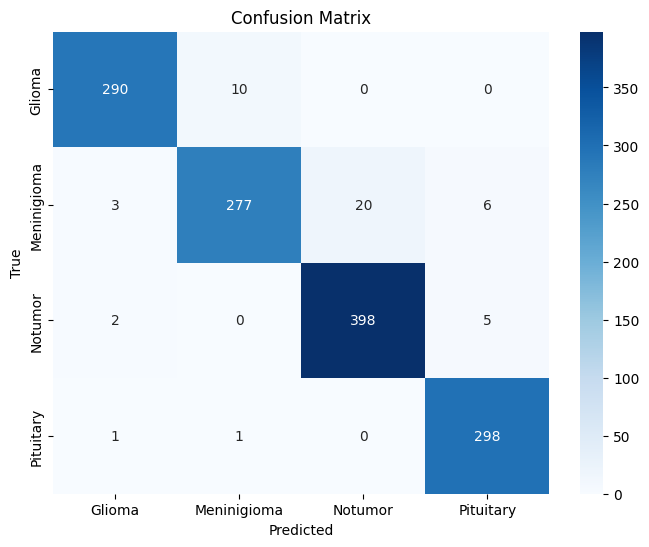

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
model_1.save("SSL_2_50-50.h5")

# SSL 2

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_2_50-50.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/low_confidence"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/very_low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/117 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


  1%|          | 1/117 [00:00<01:18,  1.48it/s]

Tr-me_1217.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_1217.jpg to BT100/Training/meningioma/20250330_224228_Tr-me_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 2/117 [00:00<00:41,  2.78it/s]

Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0119.jpg to BT100/Training/glioma/20250330_224228_Tr-gl_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|▎         | 3/117 [00:00<00:28,  3.95it/s]

Tr-me_0076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0076.jpg to BT100/Training/meningioma/20250330_224228_Tr-me_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  3%|▎         | 4/117 [00:01<00:22,  4.95it/s]

Tr-me_1250.jpg -> Class: meningioma, Confidence: 0.70
Moved low-confidence image Tr-me_1250.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 5/117 [00:01<00:19,  5.73it/s]

Tr-me_0760.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0760.jpg to BT100/Training/meningioma/20250330_224228_Tr-me_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 6/117 [00:01<00:17,  6.27it/s]

Tr-no_1457.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1457.jpg to BT100/Training/pituitary/20250330_224228_Tr-no_1457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_1131.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1131.jpg to BT100/Training/meningioma/20250330_224228_Tr-me_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 8/117 [00:01<00:13,  7.80it/s]

Tr-gl_1131.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_1131.jpg to BT100/Training/glioma/20250330_224228_Tr-gl_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 9/117 [00:01<00:14,  7.68it/s]

Tr-me_0331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0331.jpg to BT100/Training/meningioma/20250330_224228_Tr-me_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▊         | 10/117 [00:01<00:14,  7.54it/s]

Tr-no_0086.jpg -> Class: pituitary, Confidence: 0.96
Moving Tr-no_0086.jpg to BT100/Training/pituitary/20250330_224229_Tr-no_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0749.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0749.jpg to BT100/Training/meningioma/20250330_224229_Tr-me_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 12/117 [00:01<00:11,  9.05it/s]

Tr-pi_0598.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0598.jpg to BT100/Training/pituitary/20250330_224229_Tr-pi_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0028.jpg to BT100/Training/meningioma/20250330_224229_Tr-me_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0340.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0340.jpg to BT100/Training/glioma/20250330_224229_Tr-me_0340.jpg


 12%|█▏        | 14/117 [00:02<00:09, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0210.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-me_0210.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▎        | 16/117 [00:02<00:08, 12.00it/s]

Tr-no_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0587.jpg to BT100/Training/pituitary/20250330_224229_Tr-no_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1224.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1224.jpg to BT100/Training/glioma/20250330_224229_Tr-gl_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 18/117 [00:02<00:07, 12.56it/s]

Tr-gl_0577.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0577.jpg to BT100/Training/glioma/20250330_224229_Tr-gl_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0247.jpg -> Class: meningioma, Confidence: 0.92
Moving Tr-me_0247.jpg to BT100/Training/meningioma/20250330_224229_Tr-me_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 20/117 [00:02<00:08, 12.10it/s]

Tr-me_0853.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0853.jpg to BT100/Training/glioma/20250330_224229_Tr-me_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0901.jpg -> Class: meningioma, Confidence: 0.94
Moving Tr-me_0901.jpg to BT100/Training/meningioma/20250330_224229_Tr-me_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 22/117 [00:02<00:07, 12.80it/s]

Tr-gl_0326.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_0326.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0479.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_0479.jpg to BT100/Training/notumor/20250330_224230_Tr-gl_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 24/117 [00:02<00:07, 12.16it/s]

Tr-me_1328.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_1328.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0955.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0955.jpg to BT100/Training/meningioma/20250330_224230_Tr-pi_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 26/117 [00:02<00:07, 12.94it/s]

Tr-pi_1046.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1046.jpg to BT100/Training/pituitary/20250330_224230_Tr-pi_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0659.jpg -> Class: glioma, Confidence: 0.94
Moving Tr-me_0659.jpg to BT100/Training/glioma/20250330_224230_Tr-me_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1230.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1230.jpg to BT100/Training/meningioma/20250330_224230_Tr-gl_1230.jpg


 24%|██▍       | 28/117 [00:03<00:06, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0785.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0785.jpg to BT100/Training/meningioma/20250330_224230_Tr-me_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 26%|██▌       | 30/117 [00:03<00:06, 13.96it/s]

Tr-me_0069.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0069.jpg to BT100/Training/meningioma/20250330_224230_Tr-me_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1192.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1192.jpg to BT100/Training/glioma/20250330_224230_Tr-gl_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 32/117 [00:03<00:06, 13.98it/s]

Tr-pi_1425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1425.jpg to BT100/Training/pituitary/20250330_224230_Tr-pi_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0260.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0260.jpg to BT100/Training/notumor/20250330_224230_Tr-no_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 34/117 [00:03<00:05, 14.28it/s]

Tr-gl_1161.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1161.jpg to BT100/Training/glioma/20250330_224230_Tr-gl_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0300.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0300.jpg to BT100/Training/glioma/20250330_224230_Tr-gl_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 36/117 [00:03<00:05, 14.63it/s]

Tr-gl_0189.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0189.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0028.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0028.jpg to BT100/Training/pituitary/20250330_224231_Tr-pi_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 38/117 [00:03<00:05, 13.18it/s]

Tr-me_0213.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0213.jpg to BT100/Training/meningioma/20250330_224231_Tr-me_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1094.jpg to BT100/Training/glioma/20250330_224231_Tr-me_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 34%|███▍      | 40/117 [00:03<00:05, 13.75it/s]

Tr-gl_0506.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0506.jpg to BT100/Training/glioma/20250330_224231_Tr-gl_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0255.jpg -> Class: notumor, Confidence: 0.93
Moving Tr-no_0255.jpg to BT100/Training/notumor/20250330_224231_Tr-no_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 42/117 [00:04<00:05, 12.59it/s]

Tr-me_0858.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0858.jpg to BT100/Training/meningioma/20250330_224231_Tr-me_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0140.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_0140.jpg to BT100/Training/glioma/20250330_224231_Tr-gl_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 44/117 [00:04<00:05, 13.09it/s]

Tr-pi_1047.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1047.jpg to BT100/Training/pituitary/20250330_224231_Tr-pi_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1260.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1260.jpg to BT100/Training/meningioma/20250330_224231_Tr-me_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 46/117 [00:04<00:06, 11.25it/s]

Tr-gl_0228.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0228.jpg to BT100/Training/glioma/20250330_224231_Tr-gl_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.95
Moving Tr-gl_1201.jpg to BT100/Training/glioma/20250330_224231_Tr-gl_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1079.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1079.jpg to BT100/Training/glioma/20250330_224232_Tr-gl_1079.jpg


 41%|████      | 48/117 [00:04<00:05, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0173.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0173.jpg to BT100/Training/notumor/20250330_224232_Tr-no_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 50/117 [00:04<00:05, 11.54it/s]

Tr-gl_1169.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1169.jpg to BT100/Training/meningioma/20250330_224232_Tr-gl_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0059.jpg -> Class: glioma, Confidence: 0.96
Moving Tr-gl_0059.jpg to BT100/Training/glioma/20250330_224232_Tr-gl_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0417.jpg to BT100/Training/meningioma/20250330_224232_Tr-gl_0417.jpg


 44%|████▍     | 52/117 [00:05<00:05, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0657.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0657.jpg to BT100/Training/glioma/20250330_224232_Tr-me_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 46%|████▌     | 54/117 [00:05<00:04, 13.09it/s]

Tr-gl_0948.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0948.jpg to BT100/Training/glioma/20250330_224232_Tr-gl_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1269.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-me_1269.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 48%|████▊     | 56/117 [00:05<00:04, 13.75it/s]

Tr-me_0020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0020.jpg to BT100/Training/glioma/20250330_224232_Tr-me_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0176.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0176.jpg to BT100/Training/meningioma/20250330_224232_Tr-me_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|████▉     | 58/117 [00:05<00:04, 13.57it/s]

Tr-me_1200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1200.jpg to BT100/Training/meningioma/20250330_224232_Tr-me_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1265.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-gl_1265.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|█████▏    | 60/117 [00:05<00:04, 13.77it/s]

Tr-me_0073.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0073.jpg to BT100/Training/meningioma/20250330_224232_Tr-me_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1159.jpg -> Class: glioma, Confidence: 0.90
Moving Tr-gl_1159.jpg to BT100/Training/glioma/20250330_224232_Tr-gl_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 53%|█████▎    | 62/117 [00:05<00:03, 14.27it/s]

Tr-gl_0890.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0890.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1213.jpg -> Class: glioma, Confidence: 0.63
Moved low-confidence image Tr-me_1213.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 64/117 [00:05<00:03, 14.13it/s]

Tr-no_0087.jpg -> Class: pituitary, Confidence: 0.64
Moved low-confidence image Tr-no_0087.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0121.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0121.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1174.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_1174.jpg


 56%|█████▋    | 66/117 [00:05<00:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0997.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0997.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_0997.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 58%|█████▊    | 68/117 [00:06<00:03, 14.92it/s]

Tr-gl_0045.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-gl_0045.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0563.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0563.jpg to BT100/Training/meningioma/20250330_224233_Tr-me_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|█████▉    | 70/117 [00:06<00:03, 14.83it/s]

Tr-me_0647.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0647.jpg to BT100/Training/meningioma/20250330_224233_Tr-me_0647.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1132.jpg -> Class: glioma, Confidence: 0.78
Moved low-confidence image Tr-gl_1132.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▏   | 72/117 [00:06<00:02, 15.13it/s]

Tr-gl_0888.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0888.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1194.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 63%|██████▎   | 74/117 [00:06<00:02, 14.76it/s]

Tr-pi_0030.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0030.jpg to BT100/Training/pituitary/20250330_224233_Tr-pi_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0551.jpg -> Class: meningioma, Confidence: 0.56
Moved low-confidence image Tr-me_0551.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1286.jpg -> Class: glioma, Confidence: 1.00

 65%|██████▍   | 76/117 [00:06<00:02, 15.01it/s]


Moving Tr-gl_1286.jpg to BT100/Training/glioma/20250330_224233_Tr-gl_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1156.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1156.jpg to BT100/Training/glioma/20250330_224234_Tr-gl_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 78/117 [00:06<00:02, 13.62it/s]

Tr-pi_0956.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0956.jpg to BT100/Training/meningioma/20250330_224234_Tr-pi_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0103.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0103.jpg to BT100/Training/meningioma/20250330_224234_Tr-me_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 68%|██████▊   | 80/117 [00:06<00:02, 13.89it/s]

Tr-gl_1193.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_1193.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0392.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0392.jpg to BT100/Training/notumor/20250330_224234_Tr-no_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 82/117 [00:07<00:02, 14.04it/s]

Tr-me_1155.jpg -> Class: meningioma, Confidence: 0.85
Moved low-confidence image Tr-me_1155.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0527.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-me_0527.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0358.jpg -> Class: glioma, Confidence: 0.63


 72%|███████▏  | 84/117 [00:07<00:02, 14.26it/s]

Moved low-confidence image Tr-no_0358.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0215.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0215.jpg to BT100/Training/meningioma/20250330_224234_Tr-me_0215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▎  | 86/117 [00:07<00:02, 14.31it/s]

Tr-me_0540.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0540.jpg to BT100/Training/meningioma/20250330_224234_Tr-me_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0024.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-me_0024.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 88/117 [00:07<00:02, 14.34it/s]

Tr-gl_1152.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1152.jpg to BT100/Training/glioma/20250330_224234_Tr-gl_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1124.jpg to BT100/Training/glioma/20250330_224234_Tr-me_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 77%|███████▋  | 90/117 [00:07<00:01, 14.62it/s]

Tr-no_0010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0010.jpg to BT100/Training/meningioma/20250330_224234_Tr-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0360.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0360.jpg to BT100/Training/glioma/20250330_224235_Tr-gl_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 92/117 [00:07<00:01, 13.59it/s]

Tr-me_1334.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-me_1334.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1225.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-gl_1225.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|████████  | 94/117 [00:07<00:01, 13.70it/s]

Tr-gl_1275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1275.jpg to BT100/Training/meningioma/20250330_224235_Tr-gl_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0012.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0012.jpg to BT100/Training/meningioma/20250330_224235_Tr-me_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 82%|████████▏ | 96/117 [00:08<00:01, 13.96it/s]

Tr-gl_0340.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-gl_0340.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0587.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0587.jpg to BT100/Training/meningioma/20250330_224235_Tr-me_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 84%|████████▍ | 98/117 [00:08<00:01, 14.40it/s]

Tr-no_0206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0206.jpg to BT100/Training/notumor/20250330_224235_Tr-no_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0987.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0987.jpg to BT100/Training/glioma/20250330_224235_Tr-gl_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 85%|████████▌ | 100/117 [00:08<00:01, 14.49it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0408.jpg to BT100/Training/glioma/20250330_224235_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_1170.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1170.jpg to BT100/Training/glioma/20250330_224235_Tr-gl_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 87%|████████▋ | 102/117 [00:08<00:01, 14.72it/s]

Tr-gl_0695.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0695.jpg to BT100/Training/glioma/20250330_224235_Tr-gl_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0111.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0111.jpg to BT100/Training/meningioma/20250330_224235_Tr-me_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 89%|████████▉ | 104/117 [00:08<00:00, 14.55it/s]

Tr-gl_0098.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0098.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0678.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0678.jpg to BT100/Training/meningioma/20250330_224236_Tr-me_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 106/117 [00:08<00:00, 13.54it/s]

Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.97
Moving Tr-me_0806.jpg to BT100/Training/meningioma/20250330_224236_Tr-me_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-noTr_0009.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0009.jpg to BT100/Training/notumor/20250330_224236_Tr-noTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 92%|█████████▏| 108/117 [00:08<00:00, 13.71it/s]

Tr-pi_1139.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1139.jpg to BT100/Training/pituitary/20250330_224236_Tr-pi_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1343.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_1343.jpg to BT100/Training/pituitary/20250330_224236_Tr-no_1343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 94%|█████████▍| 110/117 [00:09<00:00, 14.09it/s]

Tr-pi_0957.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0957.jpg to BT100/Training/pituitary/20250330_224236_Tr-pi_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0366.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0366.jpg to BT100/Training/meningioma/20250330_224236_Tr-me_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████▌| 112/117 [00:09<00:00, 14.33it/s]

Tr-gl_0362.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0362.jpg to BT100/Training/meningioma/20250330_224236_Tr-gl_0362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1068.jpg to BT100/Training/pituitary/20250330_224236_Tr-pi_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 97%|█████████▋| 114/117 [00:09<00:00, 14.61it/s]

Tr-gl_1315.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_1315.jpg to BT100/Training/glioma/20250330_224236_Tr-gl_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0288.jpg to BT100/Training/glioma/20250330_224236_Tr-gl_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1050.jpg -> Class: pituitary, Confidence: 0.96
Moving Tr-pi_1050.jpg to BT100/Training/pituitary/20250330_224236_Tr-pi_1050.jpg


 99%|█████████▉| 116/117 [00:09<00:00, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|██████████| 117/117 [00:09<00:00, 12.23it/s]

Tr-gl_0841.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0841.jpg to BT100/Training/glioma/20250330_224236_Tr-gl_0841.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [39]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/very_low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/very_low_confidence': 21


21

In [40]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")

Total number of files in the Training folder: 5691


In [41]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

In [42]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [43]:

# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5691

Testing
Number of Labels: 1311


In [44]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)


In [45]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [46]:
model_2 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

In [48]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)


In [49]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_2.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_2 = model_2.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.5340 - loss: 1.0553 - val_accuracy: 0.7140 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.8101 - loss: 0.5082 - val_accuracy: 0.8139 - val_loss: 0.4848 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.8798 - loss: 0.3357 - val_accuracy: 0.8528 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9121 - loss: 0.2414 - val_accuracy: 0.8658 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9323 - loss: 0.1740 - val_accuracy: 0.8757 - val_loss: 0.4117 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9534 - loss: 0.1364 - val_accuracy: 0.9047 - val_loss: 0.3936 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.9617 -

In [50]:
test_loss, test_acc = model_2.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9588 - loss: 0.9079
Test accuracy: 96.1098%


In [51]:
from sklearn.metrics import classification_report

y_pred = model_2.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       300
           1       0.95      0.91      0.93       306
           2       0.95      0.99      0.97       405
           3       0.96      1.00      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



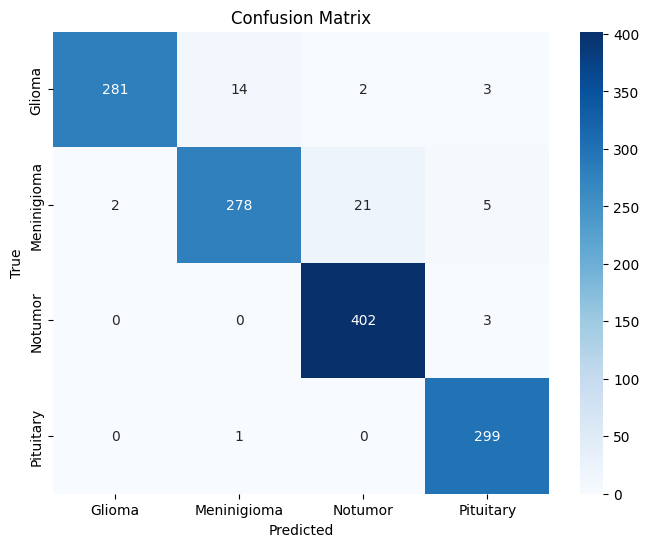

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
